In [1]:
import pandas as pd
import os
import FinanceDataReader as fdr
import numpy as np
import math
import sklearn
import sklearn.preprocessing
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm


In [2]:
valid_set_size_percentage = 10 

In [3]:
path = './'
list_name = 'stock_list.csv'
stock_list = pd.read_csv(os.path.join(path,list_name))
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
stock_list = stock_list.sort_values("종목코드")
stock_list

,종목명,종목코드,상장시장
109,메리츠화재,000060,KOSPI
126,하이트진로,000080,KOSPI
67,유한양행,000100,KOSPI
69,CJ대한통운,000120,KOSPI
156,두산,000150,KOSPI
...,...,...,...
328,넥스틴,348210,KOSDAQ
31,하이브,352820,KOSPI
199,솔브레인,357780,KOSDAQ
176,티와이홀딩스,363280,KOSPI


In [4]:
data = pd.DataFrame()
volume = pd.DataFrame()
high = pd.DataFrame()
low = pd.DataFrame()
data2 = pd.DataFrame()
volume2 = pd.DataFrame()
high2 = pd.DataFrame()
low2 = pd.DataFrame()

start_date = '20160104'
end_date = '20200214'
start_date2 = '20200608'
end_date2 = '20211126'

for stock_code in stock_list["종목코드"]:
    stock = fdr.DataReader(stock_code, start = start_date, end = end_date)
    data = pd.concat([data,stock["Close"]], axis=1)
    volume = pd.concat([volume, stock["Volume"]], axis=1)
    high = pd.concat([high,stock["High"]], axis=1)
    low = pd.concat([low,stock["Low"]], axis=1)

for stock_code in stock_list["종목코드"]:
    stock = fdr.DataReader(stock_code, start = start_date2, end = end_date2)
    data2 = pd.concat([data2,stock["Close"]], axis=1)
    volume2 = pd.concat([volume2, stock["Volume"]], axis=1)
    high2 = pd.concat([high2,stock["High"]], axis=1)
    low2 = pd.concat([low2,stock["Low"]], axis=1)

data = pd.concat([data,data2], axis=0)
volume = pd.concat([volume, volume2], axis=0)
high = pd.concat([high,high2], axis=0)
low = pd.concat([low,low2], axis=0)

data.columns = stock_list["종목코드"]
volume.columns = stock_list["종목코드"]
high.columns = stock_list["종목코드"]
low.columns = stock_list["종목코드"]

# AUTO ARIMA

In [5]:
from pmdarima.arima import auto_arima
data_diff = data.iloc[1:, :] - data.iloc[:-1, :].values

def dr_outlier(df): 
    quartile_1 = df.quantile(0.25) 
    quartile_3 = df.quantile(0.75) 
    IQR = quartile_3 - quartile_1 
    condition = (df < (quartile_1 - 1.5 * IQR)) | (df > (quartile_3 + 1.5 * IQR)) 
    search_df = df[condition] 
    return df.drop(search_df.index, axis=0)

from pmdarima.arima import ndiffs
from sklearn.linear_model import LinearRegression

def arima_pred_model(train):
    if train.isnull().sum() > 0:
        train = train.dropna(axis=0)
    kpss_diffs = ndiffs(train, alpha=0.1, test='kpss', max_d=6)
    adf_diffs = ndiffs(train, alpha=0.1, test='adf', max_d=6)
    n_diffs = max(adf_diffs, kpss_diffs)
    m = auto_arima(train, d=n_diffs, error_action='ignore', start_p=1, start_q=1, max_p=3, max_q=3)
    pred = m.predict(n_periods=5)
    return pred

result = []
for index in tqdm(range(370)):
    train = data_diff.iloc[:, index]
    train = dr_outlier(train)
    pred = arima_pred_model(train)
    result.append(pred)

sub = pd.read_csv("sample_submission.csv")
result = pd.DataFrame(result).T
for i in range(1,371):
    for j in range(5):
        result_sum = result.iloc[:j+1, i-1].sum()
        sub.iloc[j + 5, i] = np.pad(result_sum + data.iloc[-1, i - 1], (5, 0), 'constant', constant_values=0)
sub["031390"] = 0
sub.to_csv("arima_end1.csv", index=0)

100%|██████████| 370/370 [10:40<00:00,  1.73s/it]


# XGBOOST

In [6]:
def rsi(data, periods = 14, ema = True):
    close_delta = data.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi
rsi = rsi(data)

In [7]:
def bollinzer_band(data):
    k = 2
    #중심선 (MBB) : n일 이동평균선
    mbb = data.rolling(20).mean()
    MA20_std = data.rolling(20).std()

    #상한선 (UBB) : 중심선 + (표준편차 × K)
    #하한선 (LBB) : 중심선 - (표준편차 × K)
    ubb=mbb+k*MA20_std
    lbb=mbb-k*MA20_std
    return (ubb, lbb)
ubb, lbb = bollinzer_band(data)
bb = ubb - lbb

In [8]:
def fn_stoch(data, low, high, n=14): # price: 종가(시간 오름차순), n: 기간
    L14 = low.rolling(window=n).min()
    H14 = high.rolling(window=n).max()
    K = 100*((data - L14) / (H14 - L14))
    D = K.rolling(window=3).mean()

    return K - D

stochastic = pd.DataFrame()
for i in tqdm(range(370)):
    stochastic = pd.concat([stochastic,fn_stoch(data.iloc[:, i], low.iloc[:, i], high.iloc[:, i])], axis=1)
stochastic

100%|██████████| 370/370 [00:02<00:00, 128.19it/s]


,000060,000080,000100,000120,000150,000240,000250,000270,000660,000670,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
2016-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-22,-4.916749,4.163697,16.666667,5.747126,-21.776946,10.427420,6.991051,23.437500,9.197012,19.943071,...,15.286624,-5.366162,-20.985283,-26.224329,-5.541770,6.981383,-11.540110,37.320069,2.062733,-7.407407
2021-11-23,10.841833,-14.855072,-7.407407,-4.597701,-7.122100,-5.374585,-7.017544,-10.937500,0.653595,-6.540948,...,7.218684,-1.642100,-14.031562,-18.641390,-4.738272,-10.427748,-3.271984,2.554916,-14.830047,-8.641975
2021-11-24,27.379845,5.242967,2.469136,2.252874,-17.290598,-0.624478,5.701754,-11.647727,-3.948066,-9.589041,...,-5.095541,-1.075977,8.097166,-1.579779,3.686636,-12.500000,-12.970625,-3.619381,-3.986617,3.780864
2021-11-25,16.000000,-3.696561,-4.012346,-5.149425,-16.489921,1.547619,1.684465,-6.676136,-8.691044,-1.369863,...,-14.165019,-5.913043,3.546203,13.563530,3.416149,-8.333333,-16.394748,7.617582,5.637552,5.208333


In [9]:
date = pd.to_datetime(data[11:].index)
date = pd.DataFrame([date.weekday, date.month, date.quarter]).T
date.columns = ["weekday", "month", "quarter"]

In [10]:
#검색어 트렌드
import urllib
from urllib import request
import re
import json
from datetime import datetime
 
client_id = '3MEWopdxXDExnqYxHvfd'
client_secret = '02BZ16k7Zc'
 
url = "https://openapi.naver.com/v1/datalab/search"
trend = pd.DataFrame()
for stock in stock_list.iterrows():
    body = {"startDate":"2016-01-01",
            "endDate":"2021-11-27",
            "timeUnit":"date",
            "keywordGroups":[{"groupName":stock[1]["종목코드"],
                              "keywords":[stock[1]["종목코드"],stock[1]["종목명"]]}]}
    body = json.dumps(body, )

    request = urllib.request.Request(url)# 이건 HTTP Header 변경시에 사용하는 라인, 필요없으면 바로 urllib.request.urlopen()으로 ㄱㄱ
    request.add_header("X-Naver-Client-Id",client_id)
    request.add_header("X-Naver-Client-Secret",client_secret)
    request.add_header("Content-Type","application/json")

    response = urllib.request.urlopen(request, data=body.encode("utf-8")) # 메서드로 크롤링할 웹페이지 가져옴
    rescode = response.getcode() #HTTP 응담 상태 코드
    if(rescode==200):
        response_body = response.read()
        scraped = response_body.decode('utf-8')
    else:
        print("Error Code:" + rescode)

    result = json.loads(scraped)

    trend_data = result['results'][0]['data']
    time = [pd.to_datetime(i['period']) for i in trend_data]

    value = [i['ratio'] for i in trend_data]
    trend_data = pd.DataFrame({stock[1]["종목코드"]: value}, index=time)
    trend = pd.concat([trend, trend_data], axis=1)
trend = trend.fillna(0)
trend = trend.loc[pd.DatetimeIndex(data.index), :]
trend.to_csv("trend.csv", index=0)
# trend = pd.read_csv("trend.csv")

In [11]:
# s&p 500
sp = fdr.DataReader('US500', start = '20160104', end = '20211126')
sp = pd.DataFrame(sp["Close"])

insert_date = pd.DataFrame(index=pd.DatetimeIndex(['2016-01-18 00:00:00', '2016-02-15 00:00:00', '2016-03-25 00:00:00', '2016-05-30 00:00:00', '2016-07-04 00:00:00', '2016-09-05 00:00:00', '2016-11-24 00:00:00', '2016-12-26 00:00:00', '2017-01-02 00:00:00', '2017-01-16 00:00:00', '2017-02-20 00:00:00', '2017-04-14 00:00:00', '2017-05-29 00:00:00', '2017-07-04 00:00:00', '2017-09-04 00:00:00', '2017-11-23 00:00:00', '2018-01-15 00:00:00', '2018-02-19 00:00:00', '2018-03-30 00:00:00', '2018-05-28 00:00:00', '2018-07-04 00:00:00', '2018-09-03 00:00:00', '2018-11-22 00:00:00', '2018-12-05 00:00:00', '2019-01-21 00:00:00', '2019-02-18 00:00:00', '2019-04-19 00:00:00', '2019-05-27 00:00:00', '2019-07-04 00:00:00', '2019-09-02 00:00:00', '2019-11-28 00:00:00', '2020-01-20 00:00:00',  '2020-07-03 00:00:00', '2020-09-07 00:00:00', '2020-11-26 00:00:00', '2021-01-18 00:00:00', '2021-02-15 00:00:00', '2021-04-02 00:00:00', '2021-05-31 00:00:00', '2021-07-05 00:00:00', '2021-09-06 00:00:00','2021-11-25 00:00:00']))
insert_date["Close"] = None

sp = pd.concat([sp, insert_date])
sp = sp.sort_index()
sp = sp.fillna(method="ffill")
sp = sp.loc[pd.DatetimeIndex(data.index), :]
sp.columns = ["SP"]

In [12]:
def load_krx():
    kosdaq = fdr.DataReader('KS11', start = '20160104', end = '20200214')
    kosdaq = pd.DataFrame(kosdaq["Close"])
    kosdaq2 = fdr.DataReader('KS11', start = '20200608', end = '20211126')
    kosdaq2 = pd.DataFrame(kosdaq2["Close"])
    kosdaq = pd.concat([kosdaq, kosdaq2], axis=0)
    kospi = fdr.DataReader('KS11', start = '20160104', end = '20200214')
    kospi = pd.DataFrame(kospi["Close"])
    kospi2 = fdr.DataReader('KS11', start = '20200608', end = '20211126')
    kospi2 = pd.DataFrame(kospi2["Close"])
    kospi = pd.concat([kospi, kospi2], axis=0)
    return (kospi, kosdaq)

In [13]:
def preprocessing_x_test(x_test_all, date, MA5, MA20, high, low, volume, krx, index):
    x_test = pd.DataFrame(x_test_all[:, index])
    x_test = x_test.T
    x_test["MA"] = MA20.iloc[-1, index] - MA5.iloc[-1, index]
    x_test["SP"] = sp.iloc[-1,0] - sp.iloc[-2,0]
    x_test["high"] = (high.iloc[-1, index] - high.iloc[-2, index])
    x_test["low"] = (low.iloc[-1, index] - low.iloc[-2, index])
    x_test["volume"] = volume.iloc[-1, index] - volume.iloc[-2, index]
    x_test["krx"] = krx.iloc[-1, 0] - krx.iloc[-2, 0]
    x_test["trend"] = trend.iloc[-1, index]
    x_test["bb"] = bb.iloc[-1, index]
    x_test["rsi"] = rsi.iloc[-1, index]
    x_test = x_test.drop([0,1,2,3,4], axis=1)
    return x_test

def preprocessing_x_train(x_train_all, date, MA5, MA20, high, low, volume, krx, index):
    x_train = pd.DataFrame(x_train_all[:, :, index])
    x_train["MA"] = MA20.iloc[11:-5, index].values - MA5.iloc[11:-5, index].values
    x_train["SP"] = sp.iloc[11:-5, 0].values - sp.iloc[10:-6, 0].values
    x_train["high"] = (high.iloc[11:-5, index].values - high.iloc[10:-6, index].values)
    x_train["low"] = (low.iloc[11:-5, index].values - low.iloc[10:-6, index].values)
    x_train["volume"] = volume.iloc[11:-5, index].values - volume.iloc[10:-6, index].values
    x_train["krx"] = krx.iloc[11:-5, 0].values - krx.iloc[10:-6, 0].values
    x_train["trend"] = trend.iloc[11:-5, index].values
    x_train["bb"] = bb.iloc[11:-5, index].values
    x_train["rsi"] = rsi.iloc[11:-5, index].values
    x_train = x_train.drop([0,1,2,3,4], axis=1)
    return x_train

#이동 평균선
def calculate_MA(data):
    MA5 = pd.DataFrame()
    MA20 = pd.DataFrame()
    for index in range(370):
        MA5 = pd.concat([MA5 ,data.iloc[:, index].rolling(window=5).mean() - data.iloc[4:, index]], axis=1)
        MA20 = pd.concat([MA20 ,data.iloc[:, index].rolling(window=10).mean() - data.iloc[9:, index]], axis=1)
    return [MA5, MA20]

def load_data_generator(data_raw, seq_len, date, high, low, volume):
    MA5, MA20 = calculate_MA(data_raw)
    kospi, kosdaq = load_krx()
    data = []

    for index in range(len(data_raw) - 10): 
        data.append(data_raw[index: index + 10])

    data = np.array(data)
    data_diff = data[1:] - data[:-1]
    data_diff = data_diff / data[:-1] * 100
    x_train_all = data_diff[:-5,:,:]
    y_train_all = data_diff[5:,-5:,:]
    x_test_all = data_diff[-1,:,:]

    for index in range(370):
        krx = kospi if stock_list.iloc[index, 2] == "KOSPI" else kosdaq
        x_train = preprocessing_x_train(x_train_all, date, MA5, MA20, high, low, volume, krx,index)
        y_train1 = pd.DataFrame(y_train_all[:, 0, index])
        y_train2 = pd.DataFrame(y_train_all[:, 1, index])
        y_train3 = pd.DataFrame(y_train_all[:, 2, index])
        y_train4 = pd.DataFrame(y_train_all[:, 3, index])
        y_train5 = pd.DataFrame(y_train_all[:, 4, index])
        x_test = preprocessing_x_test(x_test_all, date, MA5, MA20, high, low, volume, krx, index)
        yield [x_train, [y_train1, y_train2, y_train3, y_train4, y_train5], x_test]

def normalize_data(stock):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    scaler_list = []
    for stock_code in stock_list["종목코드"]:
        stock[stock_code] = min_max_scaler.fit_transform(stock[stock_code].values.reshape(-1,1))
        scaler_list.append(min_max_scaler)
    return (stock, scaler_list)

In [14]:
# data_norm, scaler_list = normalize_data(data)
data_generator = load_data_generator(data, 10, date, high, low, volume)

In [15]:
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

def catboost_pred_model(x_train, y_train):
    if y_train[0].isnull().sum() > 0:
        x_train = x_train.dropna(axis=0)
        y_train = y_train.dropna(axis=0)
        y_train = y_train.iloc[-len(x_train):,:]
    cat = CatBoostRegressor(iterations=100, verbose=50)
    cat.fit(x_train, y_train)
    return cat

def xgboost_pred_model(x_train, y_train):
    if y_train[0].isnull().sum() > 0:
        x_train = x_train.dropna(axis=0)
        y_train = y_train.dropna(axis=0)
        y_train = y_train.iloc[-len(x_train):,:]
    xg = XGBRegressor(max_depth=8, n_estimators=256, colsample_bytree=0.5 ,subsample=1 , learning_rate=0.1)
    x_valid = x_train.iloc[-10:,:]
    y_valid = y_train.iloc[-10:,:]
    x_train2 = x_train.iloc[:-10,:]
    y_train2 = y_train.iloc[:-10,:]
    xg.fit(x_train2, y_train2, early_stopping_rounds=5, eval_set=[(x_valid, y_valid)], eval_metric="mae")
    return xg

def lgbm_pred_model(x_train, y_train):
    if y_train[0].isnull().sum() > 0:
        x_train = x_train.dropna(axis=0)
        y_train = y_train.dropna(axis=0)
        y_train = y_train.iloc[-len(x_train):,:]
    lgbm = LGBMRegressor(max_depth=5, n_estimators=128, learning_rate=0.1)
    lgbm.fit(x_train, y_train)

    return lgbm
def rf_pred_model(x_train, y_train):
    if y_train[0].isnull().sum() > 0:
        x_train = x_train.dropna(axis=0)
        y_train = y_train.dropna(axis=0)
        y_train = y_train.iloc[-len(x_train):,:]
    rf = RandomForestRegressor(n_jobs=-1, max_depth=6)    
    rf.fit(x_train, y_train)

    return rf

In [16]:
result = []
for x_train, y_train, x_test in tqdm(data_generator):
    pred_list = None
    for j in range(5):
        model = xgboost_pred_model(x_train, y_train[j])
        pred = model.predict(x_test)
        if (j == 0):
            pred_list = pred
        else:
            pred_list = np.append(pred_list, pred)
    result.append(pred_list)
result

0it [00:00, ?it/s]

[0]	validation_0-mae:1.17210
[1]	validation_0-mae:1.18686
[2]	validation_0-mae:1.14027
[3]	validation_0-mae:1.13285
[4]	validation_0-mae:1.09213
[5]	validation_0-mae:1.06115
[6]	validation_0-mae:1.03483
[7]	validation_0-mae:0.99079
[8]	validation_0-mae:0.93723
[9]	validation_0-mae:0.88969
[10]	validation_0-mae:0.89222
[11]	validation_0-mae:0.87826
[12]	validation_0-mae:0.85026
[13]	validation_0-mae:0.87205
[14]	validation_0-mae:0.87112
[15]	validation_0-mae:0.89487
[16]	validation_0-mae:0.87289
[0]	validation_0-mae:1.15068
[1]	validation_0-mae:1.14242
[2]	validation_0-mae:1.13504
[3]	validation_0-mae:1.14174
[4]	validation_0-mae:1.15122
[5]	validation_0-mae:1.14776
[6]	validation_0-mae:1.20108
[0]	validation_0-mae:1.11179
[1]	validation_0-mae:1.09714
[2]	validation_0-mae:1.09048
[3]	validation_0-mae:1.11686
[4]	validation_0-mae:1.04573
[5]	validation_0-mae:0.98515
[6]	validation_0-mae:0.99360
[7]	validation_0-mae:1.00431
[8]	validation_0-mae:1.03693
[9]	validation_0-mae:1.04278
[10]	va

1it [00:13, 13.38s/it]

[0]	validation_0-mae:1.67681
[1]	validation_0-mae:1.63301
[2]	validation_0-mae:1.60408
[3]	validation_0-mae:1.53142
[4]	validation_0-mae:1.39697
[5]	validation_0-mae:1.31951
[6]	validation_0-mae:1.27034
[7]	validation_0-mae:1.14066
[8]	validation_0-mae:1.09443
[9]	validation_0-mae:1.02763
[10]	validation_0-mae:0.99162
[11]	validation_0-mae:0.96882
[12]	validation_0-mae:0.97080
[13]	validation_0-mae:0.90302
[14]	validation_0-mae:0.88861
[15]	validation_0-mae:0.83280
[16]	validation_0-mae:0.80899
[17]	validation_0-mae:0.76169
[18]	validation_0-mae:0.70315
[19]	validation_0-mae:0.67550
[20]	validation_0-mae:0.63740
[21]	validation_0-mae:0.59204
[22]	validation_0-mae:0.55080
[23]	validation_0-mae:0.54467
[24]	validation_0-mae:0.53439
[25]	validation_0-mae:0.51275
[26]	validation_0-mae:0.52111
[27]	validation_0-mae:0.50931
[28]	validation_0-mae:0.49156
[29]	validation_0-mae:0.49307
[30]	validation_0-mae:0.46590
[31]	validation_0-mae:0.46112
[32]	validation_0-mae:0.46202
[33]	validation_0-ma

2it [00:14,  5.98s/it]

[0]	validation_0-mae:1.09760
[1]	validation_0-mae:1.00958
[2]	validation_0-mae:0.94152
[3]	validation_0-mae:0.89424
[4]	validation_0-mae:0.82846
[5]	validation_0-mae:0.78179
[6]	validation_0-mae:0.73035
[7]	validation_0-mae:0.66129
[8]	validation_0-mae:0.61721
[9]	validation_0-mae:0.62112
[10]	validation_0-mae:0.56903
[11]	validation_0-mae:0.53257
[12]	validation_0-mae:0.51924
[13]	validation_0-mae:0.50070
[14]	validation_0-mae:0.48604
[15]	validation_0-mae:0.47373
[16]	validation_0-mae:0.48122
[17]	validation_0-mae:0.47769
[18]	validation_0-mae:0.47176
[19]	validation_0-mae:0.45798
[20]	validation_0-mae:0.45423
[21]	validation_0-mae:0.42358
[22]	validation_0-mae:0.42823
[23]	validation_0-mae:0.43139
[24]	validation_0-mae:0.41450
[25]	validation_0-mae:0.42699
[26]	validation_0-mae:0.42672
[27]	validation_0-mae:0.42099
[28]	validation_0-mae:0.42597
[29]	validation_0-mae:0.41775
[0]	validation_0-mae:1.01540
[1]	validation_0-mae:1.02727
[2]	validation_0-mae:1.01644
[3]	validation_0-mae:1.

3it [00:14,  3.56s/it]

[0]	validation_0-mae:1.14386
[1]	validation_0-mae:1.07720
[2]	validation_0-mae:1.00925
[3]	validation_0-mae:0.96254
[4]	validation_0-mae:0.91293
[5]	validation_0-mae:0.87379
[6]	validation_0-mae:0.83428
[7]	validation_0-mae:0.83333
[8]	validation_0-mae:0.78826
[9]	validation_0-mae:0.77280
[10]	validation_0-mae:0.76781
[11]	validation_0-mae:0.75501
[12]	validation_0-mae:0.73484
[13]	validation_0-mae:0.70579
[14]	validation_0-mae:0.70073
[15]	validation_0-mae:0.67744
[16]	validation_0-mae:0.66393
[17]	validation_0-mae:0.65002
[18]	validation_0-mae:0.67049
[19]	validation_0-mae:0.66059
[20]	validation_0-mae:0.65769
[21]	validation_0-mae:0.65396
[22]	validation_0-mae:0.66400
[0]	validation_0-mae:1.10369
[1]	validation_0-mae:1.06906
[2]	validation_0-mae:1.08715
[3]	validation_0-mae:1.07290
[4]	validation_0-mae:1.08743
[5]	validation_0-mae:1.06876
[6]	validation_0-mae:1.09361
[7]	validation_0-mae:1.11717
[8]	validation_0-mae:1.11383
[9]	validation_0-mae:1.11550
[10]	validation_0-mae:1.10627


4it [00:15,  2.31s/it]

[0]	validation_0-mae:3.35130
[1]	validation_0-mae:3.33838
[2]	validation_0-mae:3.29855
[3]	validation_0-mae:3.24214
[4]	validation_0-mae:3.14645
[5]	validation_0-mae:3.06720
[6]	validation_0-mae:3.03378
[7]	validation_0-mae:2.94339
[8]	validation_0-mae:2.88381
[9]	validation_0-mae:2.84139
[10]	validation_0-mae:2.84018
[11]	validation_0-mae:2.86497
[12]	validation_0-mae:2.89091
[13]	validation_0-mae:2.85814
[14]	validation_0-mae:2.83696
[15]	validation_0-mae:2.75420
[16]	validation_0-mae:2.69102
[17]	validation_0-mae:2.64896
[18]	validation_0-mae:2.62536
[19]	validation_0-mae:2.58880
[20]	validation_0-mae:2.58540
[21]	validation_0-mae:2.57316
[22]	validation_0-mae:2.54961
[23]	validation_0-mae:2.55224
[24]	validation_0-mae:2.50895
[25]	validation_0-mae:2.52704
[26]	validation_0-mae:2.50729
[27]	validation_0-mae:2.51115
[28]	validation_0-mae:2.51496
[29]	validation_0-mae:2.52419
[30]	validation_0-mae:2.50993
[31]	validation_0-mae:2.50678
[32]	validation_0-mae:2.50546
[33]	validation_0-ma

5it [00:15,  1.65s/it]

[0]	validation_0-mae:1.70755
[1]	validation_0-mae:1.67152
[2]	validation_0-mae:1.61034
[3]	validation_0-mae:1.56928
[4]	validation_0-mae:1.50196
[5]	validation_0-mae:1.43723
[6]	validation_0-mae:1.40622
[7]	validation_0-mae:1.33308
[8]	validation_0-mae:1.26251
[9]	validation_0-mae:1.22214
[10]	validation_0-mae:1.18948
[11]	validation_0-mae:1.16784
[12]	validation_0-mae:1.14234
[13]	validation_0-mae:1.10935
[14]	validation_0-mae:1.11350
[15]	validation_0-mae:1.07516
[16]	validation_0-mae:1.05259
[17]	validation_0-mae:1.02945
[18]	validation_0-mae:0.99042
[19]	validation_0-mae:0.96585
[20]	validation_0-mae:0.92479
[21]	validation_0-mae:0.89650
[22]	validation_0-mae:0.89490
[23]	validation_0-mae:0.88849
[24]	validation_0-mae:0.87437
[25]	validation_0-mae:0.84411
[26]	validation_0-mae:0.85420
[27]	validation_0-mae:0.84140
[28]	validation_0-mae:0.82856
[29]	validation_0-mae:0.83573
[30]	validation_0-mae:0.81232
[31]	validation_0-mae:0.80408
[32]	validation_0-mae:0.78529
[33]	validation_0-ma

6it [00:16,  1.36s/it]

[0]	validation_0-mae:2.06524
[1]	validation_0-mae:2.00202
[2]	validation_0-mae:1.96720
[3]	validation_0-mae:1.85825
[4]	validation_0-mae:1.76208
[5]	validation_0-mae:1.68687
[6]	validation_0-mae:1.63321
[7]	validation_0-mae:1.56380
[8]	validation_0-mae:1.47752
[9]	validation_0-mae:1.41753
[10]	validation_0-mae:1.38677
[11]	validation_0-mae:1.34674
[12]	validation_0-mae:1.30473
[13]	validation_0-mae:1.23729
[14]	validation_0-mae:1.22133
[15]	validation_0-mae:1.19969
[16]	validation_0-mae:1.16208
[17]	validation_0-mae:1.10482
[18]	validation_0-mae:1.03376
[19]	validation_0-mae:0.96104
[20]	validation_0-mae:0.93785
[21]	validation_0-mae:0.92487
[22]	validation_0-mae:0.90623
[23]	validation_0-mae:0.89272
[24]	validation_0-mae:0.87632
[25]	validation_0-mae:0.83322
[26]	validation_0-mae:0.82442
[27]	validation_0-mae:0.81317
[28]	validation_0-mae:0.78866
[29]	validation_0-mae:0.77965
[30]	validation_0-mae:0.76286
[31]	validation_0-mae:0.73321
[32]	validation_0-mae:0.71449
[33]	validation_0-ma

7it [00:17,  1.11s/it]

[0]	validation_0-mae:1.49785
[1]	validation_0-mae:1.41940
[2]	validation_0-mae:1.35390
[3]	validation_0-mae:1.28033
[4]	validation_0-mae:1.13376
[5]	validation_0-mae:1.09641
[6]	validation_0-mae:1.05104
[7]	validation_0-mae:0.97952
[8]	validation_0-mae:0.93316
[9]	validation_0-mae:0.90182
[10]	validation_0-mae:0.87539
[11]	validation_0-mae:0.84785
[12]	validation_0-mae:0.81996
[13]	validation_0-mae:0.79511
[14]	validation_0-mae:0.77849
[15]	validation_0-mae:0.74579
[16]	validation_0-mae:0.73694
[17]	validation_0-mae:0.72079
[18]	validation_0-mae:0.70072
[19]	validation_0-mae:0.69665
[20]	validation_0-mae:0.70221
[21]	validation_0-mae:0.69929
[22]	validation_0-mae:0.70018
[23]	validation_0-mae:0.68627
[24]	validation_0-mae:0.68095
[25]	validation_0-mae:0.66885
[26]	validation_0-mae:0.67038
[27]	validation_0-mae:0.66567
[28]	validation_0-mae:0.66780
[29]	validation_0-mae:0.66161
[30]	validation_0-mae:0.65263
[31]	validation_0-mae:0.65479
[32]	validation_0-mae:0.64852
[33]	validation_0-ma

8it [00:17,  1.01s/it]

[0]	validation_0-mae:1.16768
[1]	validation_0-mae:1.09676
[2]	validation_0-mae:1.14772
[3]	validation_0-mae:1.08209
[4]	validation_0-mae:1.04844
[5]	validation_0-mae:1.00350
[6]	validation_0-mae:0.94235
[7]	validation_0-mae:0.93210
[8]	validation_0-mae:0.90871
[9]	validation_0-mae:0.90803
[10]	validation_0-mae:0.89153
[11]	validation_0-mae:0.87420
[12]	validation_0-mae:0.85699
[13]	validation_0-mae:0.86584
[14]	validation_0-mae:0.87933
[15]	validation_0-mae:0.87733
[16]	validation_0-mae:0.88945
[0]	validation_0-mae:1.90853
[1]	validation_0-mae:1.89909
[2]	validation_0-mae:1.89990
[3]	validation_0-mae:1.90612
[4]	validation_0-mae:1.82372
[5]	validation_0-mae:1.84795
[6]	validation_0-mae:1.83800
[7]	validation_0-mae:1.87031
[8]	validation_0-mae:1.85738
[9]	validation_0-mae:1.87868
[0]	validation_0-mae:1.90232
[1]	validation_0-mae:1.87591
[2]	validation_0-mae:1.84351
[3]	validation_0-mae:1.83403
[4]	validation_0-mae:1.87038
[5]	validation_0-mae:1.88535
[6]	validation_0-mae:1.87492
[7]	val

9it [00:18,  1.22it/s]

[0]	validation_0-mae:1.48081
[1]	validation_0-mae:1.47301
[2]	validation_0-mae:1.41828
[3]	validation_0-mae:1.33187
[4]	validation_0-mae:1.26933
[5]	validation_0-mae:1.20126
[6]	validation_0-mae:1.18170
[7]	validation_0-mae:1.10884
[8]	validation_0-mae:1.05058
[9]	validation_0-mae:1.01526
[10]	validation_0-mae:1.00865
[11]	validation_0-mae:0.99259
[12]	validation_0-mae:0.96155
[13]	validation_0-mae:0.91320
[14]	validation_0-mae:0.89584
[15]	validation_0-mae:0.88767
[16]	validation_0-mae:0.87381
[17]	validation_0-mae:0.86391
[18]	validation_0-mae:0.84405
[19]	validation_0-mae:0.83430
[20]	validation_0-mae:0.81873
[21]	validation_0-mae:0.79935
[22]	validation_0-mae:0.79174
[23]	validation_0-mae:0.78572
[24]	validation_0-mae:0.77172
[25]	validation_0-mae:0.76159
[26]	validation_0-mae:0.75465
[27]	validation_0-mae:0.74743
[28]	validation_0-mae:0.73847
[29]	validation_0-mae:0.73801
[30]	validation_0-mae:0.72606
[31]	validation_0-mae:0.73274
[32]	validation_0-mae:0.72957
[33]	validation_0-ma

10it [00:19,  1.15it/s]

[0]	validation_0-mae:1.43629
[1]	validation_0-mae:1.39106
[2]	validation_0-mae:1.31701
[3]	validation_0-mae:1.25052
[4]	validation_0-mae:1.14570
[5]	validation_0-mae:1.06434
[6]	validation_0-mae:1.00909
[7]	validation_0-mae:0.92433
[8]	validation_0-mae:0.83052
[9]	validation_0-mae:0.77831
[10]	validation_0-mae:0.72229
[11]	validation_0-mae:0.69092
[12]	validation_0-mae:0.65352
[13]	validation_0-mae:0.60810
[14]	validation_0-mae:0.59021
[15]	validation_0-mae:0.53482
[16]	validation_0-mae:0.49177
[17]	validation_0-mae:0.45695
[18]	validation_0-mae:0.43459
[19]	validation_0-mae:0.40904
[20]	validation_0-mae:0.37084
[21]	validation_0-mae:0.35270
[22]	validation_0-mae:0.33621
[23]	validation_0-mae:0.30352
[24]	validation_0-mae:0.27986
[25]	validation_0-mae:0.27102
[26]	validation_0-mae:0.26999
[27]	validation_0-mae:0.27194
[28]	validation_0-mae:0.27636
[29]	validation_0-mae:0.27631
[30]	validation_0-mae:0.28525
[0]	validation_0-mae:1.60620
[1]	validation_0-mae:1.63317
[2]	validation_0-mae:1

11it [00:19,  1.27it/s]

[0]	validation_0-mae:1.42647
[1]	validation_0-mae:1.37806
[2]	validation_0-mae:1.31387
[3]	validation_0-mae:1.28608
[4]	validation_0-mae:1.21359
[5]	validation_0-mae:1.17034
[6]	validation_0-mae:1.14549
[7]	validation_0-mae:1.10089
[8]	validation_0-mae:1.09102
[9]	validation_0-mae:1.09529
[10]	validation_0-mae:1.08289
[11]	validation_0-mae:1.09326
[12]	validation_0-mae:1.07939
[13]	validation_0-mae:1.05193
[14]	validation_0-mae:1.06033
[15]	validation_0-mae:1.04534
[16]	validation_0-mae:1.04950
[17]	validation_0-mae:1.04293
[18]	validation_0-mae:1.03366
[19]	validation_0-mae:0.99731
[20]	validation_0-mae:0.97732
[21]	validation_0-mae:0.95913
[22]	validation_0-mae:0.94692
[23]	validation_0-mae:0.95476
[24]	validation_0-mae:0.95096
[25]	validation_0-mae:0.94324
[26]	validation_0-mae:0.92980
[27]	validation_0-mae:0.92052
[28]	validation_0-mae:0.92437
[29]	validation_0-mae:0.92651
[30]	validation_0-mae:0.91315
[31]	validation_0-mae:0.91264
[32]	validation_0-mae:0.91594
[33]	validation_0-ma

12it [00:20,  1.24it/s]

[0]	validation_0-mae:0.85975
[1]	validation_0-mae:0.78228
[2]	validation_0-mae:0.71870
[3]	validation_0-mae:0.65943
[4]	validation_0-mae:0.62269
[5]	validation_0-mae:0.58413
[6]	validation_0-mae:0.52344
[7]	validation_0-mae:0.54225
[8]	validation_0-mae:0.52587
[9]	validation_0-mae:0.51942
[10]	validation_0-mae:0.50055
[11]	validation_0-mae:0.50087
[12]	validation_0-mae:0.48922
[13]	validation_0-mae:0.49426
[14]	validation_0-mae:0.47757
[15]	validation_0-mae:0.47811
[16]	validation_0-mae:0.48563
[17]	validation_0-mae:0.48149
[18]	validation_0-mae:0.48536
[0]	validation_0-mae:0.94058
[1]	validation_0-mae:0.91155
[2]	validation_0-mae:0.90247
[3]	validation_0-mae:0.88979
[4]	validation_0-mae:0.86691
[5]	validation_0-mae:0.86584
[6]	validation_0-mae:0.86076
[7]	validation_0-mae:0.86277
[8]	validation_0-mae:0.86176
[9]	validation_0-mae:0.85702
[10]	validation_0-mae:0.83169
[11]	validation_0-mae:0.82997
[12]	validation_0-mae:0.81948
[13]	validation_0-mae:0.80359
[14]	validation_0-mae:0.77001


13it [00:21,  1.46it/s]

[0]	validation_0-mae:2.26892
[1]	validation_0-mae:2.16214
[2]	validation_0-mae:2.01923
[3]	validation_0-mae:1.93191
[4]	validation_0-mae:1.79899
[5]	validation_0-mae:1.73625
[6]	validation_0-mae:1.65400
[7]	validation_0-mae:1.51574
[8]	validation_0-mae:1.45000
[9]	validation_0-mae:1.36519
[10]	validation_0-mae:1.31777
[11]	validation_0-mae:1.25609
[12]	validation_0-mae:1.23351
[13]	validation_0-mae:1.15151
[14]	validation_0-mae:1.11693
[15]	validation_0-mae:1.07601
[16]	validation_0-mae:1.04305
[17]	validation_0-mae:1.00087
[18]	validation_0-mae:0.96964
[19]	validation_0-mae:0.95539
[20]	validation_0-mae:0.94026
[21]	validation_0-mae:0.91957
[22]	validation_0-mae:0.91074
[23]	validation_0-mae:0.91989
[24]	validation_0-mae:0.89516
[25]	validation_0-mae:0.89599
[26]	validation_0-mae:0.87878
[27]	validation_0-mae:0.86761
[28]	validation_0-mae:0.85461
[29]	validation_0-mae:0.83289
[30]	validation_0-mae:0.82939
[31]	validation_0-mae:0.82186
[32]	validation_0-mae:0.80714
[33]	validation_0-ma

14it [00:21,  1.55it/s]

[0]	validation_0-mae:2.38947
[1]	validation_0-mae:2.39823
[2]	validation_0-mae:2.42874
[3]	validation_0-mae:2.45394
[4]	validation_0-mae:2.37696
[5]	validation_0-mae:2.31936
[6]	validation_0-mae:2.26530
[7]	validation_0-mae:2.17574
[8]	validation_0-mae:2.17438
[9]	validation_0-mae:2.10631
[10]	validation_0-mae:2.09771
[11]	validation_0-mae:2.07033
[12]	validation_0-mae:2.04661
[13]	validation_0-mae:2.00081
[14]	validation_0-mae:2.03689
[15]	validation_0-mae:2.00220
[16]	validation_0-mae:1.99428
[17]	validation_0-mae:1.93816
[18]	validation_0-mae:1.91673
[19]	validation_0-mae:1.90555
[20]	validation_0-mae:1.87184
[21]	validation_0-mae:1.83603
[22]	validation_0-mae:1.82121
[23]	validation_0-mae:1.79973
[24]	validation_0-mae:1.79686
[25]	validation_0-mae:1.77996
[26]	validation_0-mae:1.77492
[27]	validation_0-mae:1.78616
[28]	validation_0-mae:1.77506
[29]	validation_0-mae:1.77722
[30]	validation_0-mae:1.76670
[31]	validation_0-mae:1.76249
[32]	validation_0-mae:1.77088
[33]	validation_0-ma

15it [00:22,  1.51it/s]

[0]	validation_0-mae:3.64810
[1]	validation_0-mae:3.40054
[2]	validation_0-mae:3.22743
[3]	validation_0-mae:3.28778
[4]	validation_0-mae:3.12251
[5]	validation_0-mae:2.91614
[6]	validation_0-mae:2.77592
[7]	validation_0-mae:2.71672
[8]	validation_0-mae:2.66378
[9]	validation_0-mae:2.50741
[10]	validation_0-mae:2.36112
[11]	validation_0-mae:2.22850
[12]	validation_0-mae:2.13702
[13]	validation_0-mae:2.05531
[14]	validation_0-mae:1.99216
[15]	validation_0-mae:1.89461
[16]	validation_0-mae:1.83460
[17]	validation_0-mae:1.80319
[18]	validation_0-mae:1.76982
[19]	validation_0-mae:1.73807
[20]	validation_0-mae:1.71022
[21]	validation_0-mae:1.66928
[22]	validation_0-mae:1.62959
[23]	validation_0-mae:1.61512
[24]	validation_0-mae:1.55289
[25]	validation_0-mae:1.51160
[26]	validation_0-mae:1.49159
[27]	validation_0-mae:1.49594
[28]	validation_0-mae:1.49660
[29]	validation_0-mae:1.49634
[30]	validation_0-mae:1.46818
[31]	validation_0-mae:1.43576
[32]	validation_0-mae:1.46629
[33]	validation_0-ma

16it [00:23,  1.56it/s]

[0]	validation_0-mae:1.24554
[1]	validation_0-mae:1.20998
[2]	validation_0-mae:1.16887
[3]	validation_0-mae:1.16309
[4]	validation_0-mae:1.09503
[5]	validation_0-mae:1.06886
[6]	validation_0-mae:1.02476
[7]	validation_0-mae:0.98540
[8]	validation_0-mae:0.97680
[9]	validation_0-mae:0.96313
[10]	validation_0-mae:0.93288
[11]	validation_0-mae:0.92234
[12]	validation_0-mae:0.90700
[13]	validation_0-mae:0.88596
[14]	validation_0-mae:0.88795
[15]	validation_0-mae:0.86989
[16]	validation_0-mae:0.87727
[17]	validation_0-mae:0.86020
[18]	validation_0-mae:0.84914
[19]	validation_0-mae:0.83491
[20]	validation_0-mae:0.81555
[21]	validation_0-mae:0.82018
[22]	validation_0-mae:0.81648
[23]	validation_0-mae:0.82430
[24]	validation_0-mae:0.82326
[0]	validation_0-mae:1.21938
[1]	validation_0-mae:1.18738
[2]	validation_0-mae:1.15221
[3]	validation_0-mae:1.12588
[4]	validation_0-mae:1.10150
[5]	validation_0-mae:1.08158
[6]	validation_0-mae:1.07096
[7]	validation_0-mae:1.06019
[8]	validation_0-mae:1.03851

17it [00:24,  1.33it/s]

[0]	validation_0-mae:0.69112
[1]	validation_0-mae:0.68072
[2]	validation_0-mae:0.66311
[3]	validation_0-mae:0.65174
[4]	validation_0-mae:0.62694
[5]	validation_0-mae:0.60782
[6]	validation_0-mae:0.60972
[7]	validation_0-mae:0.58419
[8]	validation_0-mae:0.59448
[9]	validation_0-mae:0.57873
[10]	validation_0-mae:0.59375
[11]	validation_0-mae:0.60654
[12]	validation_0-mae:0.61288
[13]	validation_0-mae:0.61433
[14]	validation_0-mae:0.62389
[0]	validation_0-mae:0.68503
[1]	validation_0-mae:0.64169
[2]	validation_0-mae:0.61795
[3]	validation_0-mae:0.61772
[4]	validation_0-mae:0.59395
[5]	validation_0-mae:0.56989
[6]	validation_0-mae:0.56119
[7]	validation_0-mae:0.54279
[8]	validation_0-mae:0.54039
[9]	validation_0-mae:0.52973
[10]	validation_0-mae:0.53595
[11]	validation_0-mae:0.53765
[12]	validation_0-mae:0.51151
[13]	validation_0-mae:0.54081
[14]	validation_0-mae:0.55320
[15]	validation_0-mae:0.55515
[16]	validation_0-mae:0.56100
[17]	validation_0-mae:0.55916
[0]	validation_0-mae:0.55755
[

18it [00:24,  1.54it/s]

[0]	validation_0-mae:3.14942
[1]	validation_0-mae:3.09584
[2]	validation_0-mae:3.13114
[3]	validation_0-mae:2.95394
[4]	validation_0-mae:2.91664
[5]	validation_0-mae:2.85696
[6]	validation_0-mae:2.82192
[7]	validation_0-mae:2.77423
[8]	validation_0-mae:2.73330
[9]	validation_0-mae:2.71797
[10]	validation_0-mae:2.71809
[11]	validation_0-mae:2.69388
[12]	validation_0-mae:2.64756
[13]	validation_0-mae:2.64335
[14]	validation_0-mae:2.62573
[15]	validation_0-mae:2.60597
[16]	validation_0-mae:2.60150
[17]	validation_0-mae:2.56298
[18]	validation_0-mae:2.52921
[19]	validation_0-mae:2.49403
[20]	validation_0-mae:2.49286
[21]	validation_0-mae:2.45242
[22]	validation_0-mae:2.43334
[23]	validation_0-mae:2.42644
[24]	validation_0-mae:2.40885
[25]	validation_0-mae:2.37258
[26]	validation_0-mae:2.37434
[27]	validation_0-mae:2.36771
[28]	validation_0-mae:2.35644
[29]	validation_0-mae:2.33206
[30]	validation_0-mae:2.31434
[31]	validation_0-mae:2.29221
[32]	validation_0-mae:2.29216
[33]	validation_0-ma

19it [00:25,  1.41it/s]

[0]	validation_0-mae:1.23669
[1]	validation_0-mae:1.16511
[2]	validation_0-mae:1.11159
[3]	validation_0-mae:1.04725
[4]	validation_0-mae:1.02417
[5]	validation_0-mae:0.98359
[6]	validation_0-mae:0.93518
[7]	validation_0-mae:0.91642
[8]	validation_0-mae:0.87388
[9]	validation_0-mae:0.86732
[10]	validation_0-mae:0.80633
[11]	validation_0-mae:0.73418
[12]	validation_0-mae:0.70109
[13]	validation_0-mae:0.70583
[14]	validation_0-mae:0.68221
[15]	validation_0-mae:0.66575
[16]	validation_0-mae:0.64102
[17]	validation_0-mae:0.62245
[18]	validation_0-mae:0.63757
[19]	validation_0-mae:0.62548
[20]	validation_0-mae:0.61545
[21]	validation_0-mae:0.61774
[22]	validation_0-mae:0.61685
[23]	validation_0-mae:0.60904
[24]	validation_0-mae:0.60145
[25]	validation_0-mae:0.60293
[26]	validation_0-mae:0.59537
[27]	validation_0-mae:0.58013
[28]	validation_0-mae:0.57043
[29]	validation_0-mae:0.55801
[30]	validation_0-mae:0.56227
[31]	validation_0-mae:0.56020
[32]	validation_0-mae:0.55099
[33]	validation_0-ma

20it [00:25,  1.45it/s]

[0]	validation_0-mae:1.60675
[1]	validation_0-mae:1.55387
[2]	validation_0-mae:1.49065
[3]	validation_0-mae:1.43973
[4]	validation_0-mae:1.37368
[5]	validation_0-mae:1.32979
[6]	validation_0-mae:1.25270
[7]	validation_0-mae:1.21689
[8]	validation_0-mae:1.14548
[9]	validation_0-mae:1.13475
[10]	validation_0-mae:1.10204
[11]	validation_0-mae:1.05190
[12]	validation_0-mae:0.97004
[13]	validation_0-mae:0.91809
[14]	validation_0-mae:0.90119
[15]	validation_0-mae:0.87219
[16]	validation_0-mae:0.86656
[17]	validation_0-mae:0.87179
[18]	validation_0-mae:0.86277
[19]	validation_0-mae:0.83030
[20]	validation_0-mae:0.81732
[21]	validation_0-mae:0.76166
[22]	validation_0-mae:0.75131
[23]	validation_0-mae:0.76800
[24]	validation_0-mae:0.72935
[25]	validation_0-mae:0.74344
[26]	validation_0-mae:0.74137
[27]	validation_0-mae:0.74204
[28]	validation_0-mae:0.74897
[29]	validation_0-mae:0.72411
[30]	validation_0-mae:0.69867
[31]	validation_0-mae:0.67543
[32]	validation_0-mae:0.67549
[33]	validation_0-ma

21it [00:26,  1.48it/s]

[0]	validation_0-mae:2.16579
[1]	validation_0-mae:2.09089
[2]	validation_0-mae:2.00546
[3]	validation_0-mae:1.84740
[4]	validation_0-mae:1.72095
[5]	validation_0-mae:1.58795
[6]	validation_0-mae:1.50464
[7]	validation_0-mae:1.45907
[8]	validation_0-mae:1.38863
[9]	validation_0-mae:1.33844
[10]	validation_0-mae:1.28834
[11]	validation_0-mae:1.23808
[12]	validation_0-mae:1.17553
[13]	validation_0-mae:1.11947
[14]	validation_0-mae:1.09095
[15]	validation_0-mae:1.05670
[16]	validation_0-mae:1.08245
[17]	validation_0-mae:1.09631
[18]	validation_0-mae:1.07228
[19]	validation_0-mae:1.05113
[20]	validation_0-mae:1.03300
[21]	validation_0-mae:1.03570
[22]	validation_0-mae:1.03112
[23]	validation_0-mae:1.03523
[24]	validation_0-mae:1.00983
[25]	validation_0-mae:0.98710
[26]	validation_0-mae:0.98177
[27]	validation_0-mae:0.98647
[28]	validation_0-mae:0.99109
[29]	validation_0-mae:0.98879
[30]	validation_0-mae:0.96455
[31]	validation_0-mae:0.95564
[32]	validation_0-mae:0.95241
[33]	validation_0-ma

22it [00:27,  1.47it/s]

[0]	validation_0-mae:1.28048
[1]	validation_0-mae:1.25082
[2]	validation_0-mae:1.19844
[3]	validation_0-mae:1.18138
[4]	validation_0-mae:1.10663
[5]	validation_0-mae:1.08476
[6]	validation_0-mae:1.03633
[7]	validation_0-mae:0.97874
[8]	validation_0-mae:0.96806
[9]	validation_0-mae:0.93831
[10]	validation_0-mae:0.89173
[11]	validation_0-mae:0.85421
[12]	validation_0-mae:0.83836
[13]	validation_0-mae:0.79754
[14]	validation_0-mae:0.81161
[15]	validation_0-mae:0.78473
[16]	validation_0-mae:0.76584
[17]	validation_0-mae:0.74845
[18]	validation_0-mae:0.72720
[19]	validation_0-mae:0.72550
[20]	validation_0-mae:0.69292
[21]	validation_0-mae:0.67379
[22]	validation_0-mae:0.63611
[23]	validation_0-mae:0.63243
[24]	validation_0-mae:0.63004
[25]	validation_0-mae:0.62171
[26]	validation_0-mae:0.61925
[27]	validation_0-mae:0.61753
[28]	validation_0-mae:0.60561
[29]	validation_0-mae:0.59909
[30]	validation_0-mae:0.57300
[31]	validation_0-mae:0.57206
[32]	validation_0-mae:0.57944
[33]	validation_0-ma

23it [00:27,  1.59it/s]

[0]	validation_0-mae:0.86133
[1]	validation_0-mae:0.79787
[2]	validation_0-mae:0.73913
[3]	validation_0-mae:0.70883
[4]	validation_0-mae:0.64348
[5]	validation_0-mae:0.61460
[6]	validation_0-mae:0.56577
[7]	validation_0-mae:0.54298
[8]	validation_0-mae:0.51892
[9]	validation_0-mae:0.50927
[10]	validation_0-mae:0.48688
[11]	validation_0-mae:0.47347
[12]	validation_0-mae:0.46704
[13]	validation_0-mae:0.45249
[14]	validation_0-mae:0.45853
[15]	validation_0-mae:0.46649
[16]	validation_0-mae:0.46458
[17]	validation_0-mae:0.47679
[18]	validation_0-mae:0.47592
[0]	validation_0-mae:1.01487
[1]	validation_0-mae:0.97538
[2]	validation_0-mae:0.94708
[3]	validation_0-mae:0.92954
[4]	validation_0-mae:0.91169
[5]	validation_0-mae:0.89733
[6]	validation_0-mae:0.90902
[7]	validation_0-mae:0.90298
[8]	validation_0-mae:0.90155
[9]	validation_0-mae:0.87435
[10]	validation_0-mae:0.87237
[11]	validation_0-mae:0.86216
[12]	validation_0-mae:0.84542
[13]	validation_0-mae:0.83058
[14]	validation_0-mae:0.82755


24it [00:28,  1.58it/s]

[0]	validation_0-mae:1.16832
[1]	validation_0-mae:1.11072
[2]	validation_0-mae:1.01271
[3]	validation_0-mae:0.95047
[4]	validation_0-mae:0.84949
[5]	validation_0-mae:0.77009
[6]	validation_0-mae:0.72112
[7]	validation_0-mae:0.67814
[8]	validation_0-mae:0.66001
[9]	validation_0-mae:0.63057
[10]	validation_0-mae:0.59881
[11]	validation_0-mae:0.58780
[12]	validation_0-mae:0.58335
[13]	validation_0-mae:0.54038
[14]	validation_0-mae:0.51748
[15]	validation_0-mae:0.52336
[16]	validation_0-mae:0.49270
[17]	validation_0-mae:0.48729
[18]	validation_0-mae:0.47226
[19]	validation_0-mae:0.48008
[20]	validation_0-mae:0.48879
[21]	validation_0-mae:0.50122
[22]	validation_0-mae:0.50593
[0]	validation_0-mae:1.12997
[1]	validation_0-mae:1.06964
[2]	validation_0-mae:1.04347
[3]	validation_0-mae:0.99574
[4]	validation_0-mae:0.97265
[5]	validation_0-mae:0.95769
[6]	validation_0-mae:1.00967
[7]	validation_0-mae:0.99644
[8]	validation_0-mae:0.98592
[9]	validation_0-mae:0.97145
[10]	validation_0-mae:0.97847


25it [00:29,  1.56it/s]

[0]	validation_0-mae:1.51382
[1]	validation_0-mae:1.41075
[2]	validation_0-mae:1.38332
[3]	validation_0-mae:1.34024
[4]	validation_0-mae:1.25626
[5]	validation_0-mae:1.20197
[6]	validation_0-mae:1.10932
[7]	validation_0-mae:1.00533
[8]	validation_0-mae:0.94435
[9]	validation_0-mae:0.91912
[10]	validation_0-mae:0.88492
[11]	validation_0-mae:0.86209
[12]	validation_0-mae:0.83857
[13]	validation_0-mae:0.81362
[14]	validation_0-mae:0.80826
[15]	validation_0-mae:0.75602
[16]	validation_0-mae:0.74766
[17]	validation_0-mae:0.72532
[18]	validation_0-mae:0.68906
[19]	validation_0-mae:0.67554
[20]	validation_0-mae:0.66903
[21]	validation_0-mae:0.66037
[22]	validation_0-mae:0.62476
[23]	validation_0-mae:0.60478
[24]	validation_0-mae:0.58825
[25]	validation_0-mae:0.57031
[26]	validation_0-mae:0.56873
[27]	validation_0-mae:0.55213
[28]	validation_0-mae:0.54658
[29]	validation_0-mae:0.53226
[30]	validation_0-mae:0.53036
[31]	validation_0-mae:0.53733
[32]	validation_0-mae:0.53796
[33]	validation_0-ma

26it [00:29,  1.65it/s]

[0]	validation_0-mae:1.60088
[1]	validation_0-mae:1.50995
[2]	validation_0-mae:1.48935
[3]	validation_0-mae:1.37932
[4]	validation_0-mae:1.29114
[5]	validation_0-mae:1.17204
[6]	validation_0-mae:1.15365
[7]	validation_0-mae:1.11748
[8]	validation_0-mae:1.07983
[9]	validation_0-mae:1.05824
[10]	validation_0-mae:1.03259
[11]	validation_0-mae:1.03366
[12]	validation_0-mae:1.02180
[13]	validation_0-mae:1.00414
[14]	validation_0-mae:0.99891
[15]	validation_0-mae:0.98306
[16]	validation_0-mae:0.97439
[17]	validation_0-mae:0.95893
[18]	validation_0-mae:0.95002
[19]	validation_0-mae:0.94373
[20]	validation_0-mae:0.94459
[21]	validation_0-mae:0.94463
[22]	validation_0-mae:0.94241
[23]	validation_0-mae:0.93424
[24]	validation_0-mae:0.92198
[25]	validation_0-mae:0.93029
[26]	validation_0-mae:0.93778
[27]	validation_0-mae:0.92618
[28]	validation_0-mae:0.92921
[29]	validation_0-mae:0.93495
[0]	validation_0-mae:1.67830
[1]	validation_0-mae:1.65099
[2]	validation_0-mae:1.65624
[3]	validation_0-mae:1.

27it [00:30,  1.75it/s]

[0]	validation_0-mae:1.43284
[1]	validation_0-mae:1.37724
[2]	validation_0-mae:1.40542
[3]	validation_0-mae:1.37273
[4]	validation_0-mae:1.30329
[5]	validation_0-mae:1.26639
[6]	validation_0-mae:1.26452
[7]	validation_0-mae:1.17995
[8]	validation_0-mae:1.14563
[9]	validation_0-mae:1.13579
[10]	validation_0-mae:1.09502
[11]	validation_0-mae:1.07351
[12]	validation_0-mae:1.05386
[13]	validation_0-mae:1.04186
[14]	validation_0-mae:1.01460
[15]	validation_0-mae:1.01102
[16]	validation_0-mae:1.01291
[17]	validation_0-mae:0.99356
[18]	validation_0-mae:0.98277
[19]	validation_0-mae:0.98548
[20]	validation_0-mae:0.99069
[21]	validation_0-mae:1.01212
[22]	validation_0-mae:0.99956
[0]	validation_0-mae:1.45513
[1]	validation_0-mae:1.44842
[2]	validation_0-mae:1.41642
[3]	validation_0-mae:1.38961
[4]	validation_0-mae:1.37452
[5]	validation_0-mae:1.42468
[6]	validation_0-mae:1.43726
[7]	validation_0-mae:1.42538
[8]	validation_0-mae:1.43173
[9]	validation_0-mae:1.52787
[0]	validation_0-mae:1.44683
[

28it [00:30,  1.81it/s]

[0]	validation_0-mae:1.58062
[1]	validation_0-mae:1.43187
[2]	validation_0-mae:1.37854
[3]	validation_0-mae:1.29840
[4]	validation_0-mae:1.18883
[5]	validation_0-mae:1.12322
[6]	validation_0-mae:1.04638
[7]	validation_0-mae:0.98759
[8]	validation_0-mae:0.92638
[9]	validation_0-mae:0.90399
[10]	validation_0-mae:0.85470
[11]	validation_0-mae:0.81516
[12]	validation_0-mae:0.79502
[13]	validation_0-mae:0.76545
[14]	validation_0-mae:0.74467
[15]	validation_0-mae:0.71114
[16]	validation_0-mae:0.69425
[17]	validation_0-mae:0.67980
[18]	validation_0-mae:0.68061
[19]	validation_0-mae:0.67149
[20]	validation_0-mae:0.67729
[21]	validation_0-mae:0.67798
[22]	validation_0-mae:0.68190
[23]	validation_0-mae:0.67143
[24]	validation_0-mae:0.68181
[25]	validation_0-mae:0.68459
[26]	validation_0-mae:0.67459
[27]	validation_0-mae:0.67833
[28]	validation_0-mae:0.66647
[29]	validation_0-mae:0.67078
[30]	validation_0-mae:0.68000
[31]	validation_0-mae:0.67573
[32]	validation_0-mae:0.67596
[33]	validation_0-ma

29it [00:31,  1.68it/s]

[0]	validation_0-mae:1.18544
[1]	validation_0-mae:1.15588
[2]	validation_0-mae:1.10940
[3]	validation_0-mae:1.08766
[4]	validation_0-mae:1.03169
[5]	validation_0-mae:1.01967
[6]	validation_0-mae:0.99540
[7]	validation_0-mae:0.93905
[8]	validation_0-mae:0.94209
[9]	validation_0-mae:0.91668
[10]	validation_0-mae:0.90487
[11]	validation_0-mae:0.86666
[12]	validation_0-mae:0.85045
[13]	validation_0-mae:0.83217
[14]	validation_0-mae:0.82497
[15]	validation_0-mae:0.81602
[16]	validation_0-mae:0.79739
[17]	validation_0-mae:0.78922
[18]	validation_0-mae:0.77750
[19]	validation_0-mae:0.76459
[20]	validation_0-mae:0.74825
[21]	validation_0-mae:0.72418
[22]	validation_0-mae:0.71449
[23]	validation_0-mae:0.70840
[24]	validation_0-mae:0.69025
[25]	validation_0-mae:0.65447
[26]	validation_0-mae:0.65591
[27]	validation_0-mae:0.65322
[28]	validation_0-mae:0.65464
[29]	validation_0-mae:0.65287
[30]	validation_0-mae:0.65172
[31]	validation_0-mae:0.65280
[32]	validation_0-mae:0.66396
[33]	validation_0-ma

30it [00:32,  1.48it/s]

[0]	validation_0-mae:0.78276
[1]	validation_0-mae:0.73081
[2]	validation_0-mae:0.69598
[3]	validation_0-mae:0.68282
[4]	validation_0-mae:0.67012
[5]	validation_0-mae:0.65506
[6]	validation_0-mae:0.62392
[7]	validation_0-mae:0.60781
[8]	validation_0-mae:0.59908
[9]	validation_0-mae:0.58160
[10]	validation_0-mae:0.55716
[11]	validation_0-mae:0.53441
[12]	validation_0-mae:0.50498
[13]	validation_0-mae:0.50361
[14]	validation_0-mae:0.49765
[15]	validation_0-mae:0.50140
[16]	validation_0-mae:0.49859
[17]	validation_0-mae:0.50858
[18]	validation_0-mae:0.50857
[0]	validation_0-mae:0.85080
[1]	validation_0-mae:0.84433
[2]	validation_0-mae:0.85578
[3]	validation_0-mae:0.86389
[4]	validation_0-mae:0.87855
[5]	validation_0-mae:0.88983
[6]	validation_0-mae:0.90008
[0]	validation_0-mae:0.91527
[1]	validation_0-mae:0.92652
[2]	validation_0-mae:0.92142
[3]	validation_0-mae:0.88605
[4]	validation_0-mae:0.88605
[5]	validation_0-mae:0.89004
[6]	validation_0-mae:0.89581
[7]	validation_0-mae:0.89921
[0]	v

31it [00:32,  1.80it/s]

[0]	validation_0-mae:1.74342
[1]	validation_0-mae:1.69718
[2]	validation_0-mae:1.65285
[3]	validation_0-mae:1.58563
[4]	validation_0-mae:1.55401
[5]	validation_0-mae:1.55190
[6]	validation_0-mae:1.50791
[7]	validation_0-mae:1.45741
[8]	validation_0-mae:1.43424
[9]	validation_0-mae:1.44075
[10]	validation_0-mae:1.41301
[11]	validation_0-mae:1.40159
[12]	validation_0-mae:1.41233
[13]	validation_0-mae:1.43462
[14]	validation_0-mae:1.41522
[15]	validation_0-mae:1.38994
[16]	validation_0-mae:1.37208
[17]	validation_0-mae:1.35847
[18]	validation_0-mae:1.34645
[19]	validation_0-mae:1.35043
[20]	validation_0-mae:1.31909
[21]	validation_0-mae:1.31166
[22]	validation_0-mae:1.32248
[23]	validation_0-mae:1.29000
[24]	validation_0-mae:1.27880
[25]	validation_0-mae:1.27094
[26]	validation_0-mae:1.27762
[27]	validation_0-mae:1.27814
[28]	validation_0-mae:1.28512
[29]	validation_0-mae:1.28850
[30]	validation_0-mae:1.28964
[0]	validation_0-mae:1.91321
[1]	validation_0-mae:1.90374
[2]	validation_0-mae:1

32it [00:32,  1.80it/s]

[0]	validation_0-mae:1.08337
[1]	validation_0-mae:1.02673
[2]	validation_0-mae:0.98210
[3]	validation_0-mae:0.93231
[4]	validation_0-mae:0.81157
[5]	validation_0-mae:0.76028
[6]	validation_0-mae:0.74089
[7]	validation_0-mae:0.68129
[8]	validation_0-mae:0.67549
[9]	validation_0-mae:0.63024
[10]	validation_0-mae:0.61623
[11]	validation_0-mae:0.59770
[12]	validation_0-mae:0.58837
[13]	validation_0-mae:0.57341
[14]	validation_0-mae:0.56560
[15]	validation_0-mae:0.52356
[16]	validation_0-mae:0.50884
[17]	validation_0-mae:0.49204
[18]	validation_0-mae:0.46790
[19]	validation_0-mae:0.43980
[20]	validation_0-mae:0.43842
[21]	validation_0-mae:0.43352
[22]	validation_0-mae:0.44159
[23]	validation_0-mae:0.43341
[24]	validation_0-mae:0.42636
[25]	validation_0-mae:0.39812
[26]	validation_0-mae:0.38880
[27]	validation_0-mae:0.37650
[28]	validation_0-mae:0.36844
[29]	validation_0-mae:0.36456
[30]	validation_0-mae:0.36240
[31]	validation_0-mae:0.35104
[32]	validation_0-mae:0.35935
[33]	validation_0-ma

33it [00:33,  1.73it/s]

[0]	validation_0-mae:1.12159
[1]	validation_0-mae:1.02906
[2]	validation_0-mae:0.99649
[3]	validation_0-mae:0.96585
[4]	validation_0-mae:0.90131
[5]	validation_0-mae:0.88665
[6]	validation_0-mae:0.83521
[7]	validation_0-mae:0.79181
[8]	validation_0-mae:0.75354
[9]	validation_0-mae:0.71978
[10]	validation_0-mae:0.66774
[11]	validation_0-mae:0.64854
[12]	validation_0-mae:0.62190
[13]	validation_0-mae:0.60808
[14]	validation_0-mae:0.58838
[15]	validation_0-mae:0.57942
[16]	validation_0-mae:0.56573
[17]	validation_0-mae:0.54707
[18]	validation_0-mae:0.54000
[19]	validation_0-mae:0.53936
[20]	validation_0-mae:0.52103
[21]	validation_0-mae:0.50750
[22]	validation_0-mae:0.50083
[23]	validation_0-mae:0.49807
[24]	validation_0-mae:0.47987
[25]	validation_0-mae:0.46794
[26]	validation_0-mae:0.46535
[27]	validation_0-mae:0.46852
[28]	validation_0-mae:0.46670
[29]	validation_0-mae:0.45995
[30]	validation_0-mae:0.45577
[31]	validation_0-mae:0.46320
[32]	validation_0-mae:0.46078
[33]	validation_0-ma

34it [00:34,  1.38it/s]

[0]	validation_0-mae:1.48853
[1]	validation_0-mae:1.40947
[2]	validation_0-mae:1.33283
[3]	validation_0-mae:1.24428
[4]	validation_0-mae:1.17813
[5]	validation_0-mae:1.09536
[6]	validation_0-mae:1.01370
[7]	validation_0-mae:0.95724
[8]	validation_0-mae:0.92169
[9]	validation_0-mae:0.94205
[10]	validation_0-mae:0.90177
[11]	validation_0-mae:0.88873
[12]	validation_0-mae:0.85352
[13]	validation_0-mae:0.84809
[14]	validation_0-mae:0.82822
[15]	validation_0-mae:0.80775
[16]	validation_0-mae:0.81508
[17]	validation_0-mae:0.80140
[18]	validation_0-mae:0.78706
[19]	validation_0-mae:0.78118
[20]	validation_0-mae:0.78470
[21]	validation_0-mae:0.78375
[22]	validation_0-mae:0.79614
[23]	validation_0-mae:0.80235
[0]	validation_0-mae:1.47314
[1]	validation_0-mae:1.43850
[2]	validation_0-mae:1.42901
[3]	validation_0-mae:1.41834
[4]	validation_0-mae:1.40479
[5]	validation_0-mae:1.39223
[6]	validation_0-mae:1.37608
[7]	validation_0-mae:1.36997
[8]	validation_0-mae:1.35376
[9]	validation_0-mae:1.32100


35it [00:35,  1.53it/s]

[0]	validation_0-mae:3.86284
[1]	validation_0-mae:3.72058
[2]	validation_0-mae:3.78772
[3]	validation_0-mae:3.72805
[4]	validation_0-mae:3.72034
[5]	validation_0-mae:3.62534
[6]	validation_0-mae:3.59475
[7]	validation_0-mae:3.55995
[8]	validation_0-mae:3.50292
[9]	validation_0-mae:3.42529
[10]	validation_0-mae:3.42686
[11]	validation_0-mae:3.43026
[12]	validation_0-mae:3.44341
[13]	validation_0-mae:3.44659
[14]	validation_0-mae:3.43574
[0]	validation_0-mae:4.10649
[1]	validation_0-mae:4.11115
[2]	validation_0-mae:4.09525
[3]	validation_0-mae:4.09543
[4]	validation_0-mae:4.15834
[5]	validation_0-mae:4.14729
[6]	validation_0-mae:4.17192
[0]	validation_0-mae:3.51033
[1]	validation_0-mae:3.53009
[2]	validation_0-mae:3.53495
[3]	validation_0-mae:3.54737
[4]	validation_0-mae:3.53325
[5]	validation_0-mae:3.55145
[0]	validation_0-mae:3.34101
[1]	validation_0-mae:3.41422
[2]	validation_0-mae:3.43711
[3]	validation_0-mae:3.46029
[4]	validation_0-mae:3.55255
[0]	validation_0-mae:3.23692
[1]	valid

36it [00:35,  1.88it/s]

[0]	validation_0-mae:1.37014
[1]	validation_0-mae:1.33994
[2]	validation_0-mae:1.32893
[3]	validation_0-mae:1.31322
[4]	validation_0-mae:1.25448
[5]	validation_0-mae:1.22544
[6]	validation_0-mae:1.19794
[7]	validation_0-mae:1.15414
[8]	validation_0-mae:1.14418
[9]	validation_0-mae:1.11859
[10]	validation_0-mae:1.10622
[11]	validation_0-mae:1.10035
[12]	validation_0-mae:1.07109
[13]	validation_0-mae:1.03353
[14]	validation_0-mae:1.02818
[15]	validation_0-mae:1.00233
[16]	validation_0-mae:1.00084
[17]	validation_0-mae:1.00688
[18]	validation_0-mae:0.97530
[19]	validation_0-mae:0.94454
[20]	validation_0-mae:0.91741
[21]	validation_0-mae:0.88609
[22]	validation_0-mae:0.87074
[23]	validation_0-mae:0.86988
[24]	validation_0-mae:0.85656
[25]	validation_0-mae:0.85472
[26]	validation_0-mae:0.83510
[27]	validation_0-mae:0.83607
[28]	validation_0-mae:0.83479
[29]	validation_0-mae:0.83482
[30]	validation_0-mae:0.83577
[31]	validation_0-mae:0.82976
[32]	validation_0-mae:0.82573
[33]	validation_0-ma

37it [00:36,  1.80it/s]

[0]	validation_0-mae:1.14029
[1]	validation_0-mae:1.07624
[2]	validation_0-mae:1.04249
[3]	validation_0-mae:0.96777
[4]	validation_0-mae:0.87468
[5]	validation_0-mae:0.83054
[6]	validation_0-mae:0.76319
[7]	validation_0-mae:0.68205
[8]	validation_0-mae:0.66185
[9]	validation_0-mae:0.61741
[10]	validation_0-mae:0.60472
[11]	validation_0-mae:0.59423
[12]	validation_0-mae:0.58610
[13]	validation_0-mae:0.54719
[14]	validation_0-mae:0.52949
[15]	validation_0-mae:0.53489
[16]	validation_0-mae:0.54580
[17]	validation_0-mae:0.55605
[18]	validation_0-mae:0.53933
[0]	validation_0-mae:1.57406
[1]	validation_0-mae:1.57022
[2]	validation_0-mae:1.55481
[3]	validation_0-mae:1.53318
[4]	validation_0-mae:1.52674
[5]	validation_0-mae:1.49954
[6]	validation_0-mae:1.49884
[7]	validation_0-mae:1.49622
[8]	validation_0-mae:1.49293
[9]	validation_0-mae:1.51211
[10]	validation_0-mae:1.51482
[11]	validation_0-mae:1.51741
[12]	validation_0-mae:1.50797
[13]	validation_0-mae:1.52642
[0]	validation_0-mae:1.66280
[

38it [00:36,  1.87it/s]

[0]	validation_0-mae:1.09133
[1]	validation_0-mae:1.04174
[2]	validation_0-mae:0.99477
[3]	validation_0-mae:0.91803
[4]	validation_0-mae:0.82575
[5]	validation_0-mae:0.77436
[6]	validation_0-mae:0.74555
[7]	validation_0-mae:0.71709
[8]	validation_0-mae:0.68103
[9]	validation_0-mae:0.64560
[10]	validation_0-mae:0.62395
[11]	validation_0-mae:0.62281
[12]	validation_0-mae:0.61747
[13]	validation_0-mae:0.60292
[14]	validation_0-mae:0.60628
[15]	validation_0-mae:0.59081
[16]	validation_0-mae:0.56836
[17]	validation_0-mae:0.55599
[18]	validation_0-mae:0.54551
[19]	validation_0-mae:0.54371
[20]	validation_0-mae:0.51757
[21]	validation_0-mae:0.50302
[22]	validation_0-mae:0.48295
[23]	validation_0-mae:0.48205
[24]	validation_0-mae:0.47525
[25]	validation_0-mae:0.46384
[26]	validation_0-mae:0.46685
[27]	validation_0-mae:0.46324
[28]	validation_0-mae:0.46301
[29]	validation_0-mae:0.46291
[30]	validation_0-mae:0.45496
[31]	validation_0-mae:0.45364
[32]	validation_0-mae:0.45393
[33]	validation_0-ma

39it [00:37,  1.86it/s]

[0]	validation_0-mae:1.05617
[1]	validation_0-mae:0.98050
[2]	validation_0-mae:0.96546
[3]	validation_0-mae:0.90599
[4]	validation_0-mae:0.85831
[5]	validation_0-mae:0.83448
[6]	validation_0-mae:0.78644
[7]	validation_0-mae:0.73142
[8]	validation_0-mae:0.68106
[9]	validation_0-mae:0.65109
[10]	validation_0-mae:0.63370
[11]	validation_0-mae:0.62896
[12]	validation_0-mae:0.59878
[13]	validation_0-mae:0.56291
[14]	validation_0-mae:0.54429
[15]	validation_0-mae:0.51131
[16]	validation_0-mae:0.50256
[17]	validation_0-mae:0.50118
[18]	validation_0-mae:0.49060
[19]	validation_0-mae:0.49757
[20]	validation_0-mae:0.47951
[21]	validation_0-mae:0.46700
[22]	validation_0-mae:0.45901
[23]	validation_0-mae:0.45417
[24]	validation_0-mae:0.45017
[25]	validation_0-mae:0.44031
[26]	validation_0-mae:0.43723
[27]	validation_0-mae:0.44541
[28]	validation_0-mae:0.44098
[29]	validation_0-mae:0.43789
[30]	validation_0-mae:0.44704
[0]	validation_0-mae:1.21147
[1]	validation_0-mae:1.18910
[2]	validation_0-mae:1

40it [00:37,  1.75it/s]

[0]	validation_0-mae:1.46987
[1]	validation_0-mae:1.39632
[2]	validation_0-mae:1.31744
[3]	validation_0-mae:1.22660
[4]	validation_0-mae:1.15455
[5]	validation_0-mae:1.11858
[6]	validation_0-mae:1.06102
[7]	validation_0-mae:0.99878
[8]	validation_0-mae:0.99761
[9]	validation_0-mae:0.94788
[10]	validation_0-mae:0.92456
[11]	validation_0-mae:0.90384
[12]	validation_0-mae:0.88370
[13]	validation_0-mae:0.84773
[14]	validation_0-mae:0.82844
[15]	validation_0-mae:0.80065
[16]	validation_0-mae:0.79140
[17]	validation_0-mae:0.76589
[18]	validation_0-mae:0.79185
[19]	validation_0-mae:0.77985
[20]	validation_0-mae:0.76566
[21]	validation_0-mae:0.75412
[22]	validation_0-mae:0.75545
[23]	validation_0-mae:0.75150
[24]	validation_0-mae:0.73791
[25]	validation_0-mae:0.72291
[26]	validation_0-mae:0.72286
[27]	validation_0-mae:0.73030
[28]	validation_0-mae:0.74186
[29]	validation_0-mae:0.73175
[30]	validation_0-mae:0.73009
[31]	validation_0-mae:0.72638
[0]	validation_0-mae:1.58695
[1]	validation_0-mae:

41it [00:38,  1.84it/s]

[0]	validation_0-mae:2.00793
[1]	validation_0-mae:1.96420
[2]	validation_0-mae:1.93053
[3]	validation_0-mae:1.89536
[4]	validation_0-mae:1.85516
[5]	validation_0-mae:1.80297
[6]	validation_0-mae:1.76770
[7]	validation_0-mae:1.71997
[8]	validation_0-mae:1.62318
[9]	validation_0-mae:1.59238
[10]	validation_0-mae:1.56866
[11]	validation_0-mae:1.51281
[12]	validation_0-mae:1.50418
[13]	validation_0-mae:1.48709
[14]	validation_0-mae:1.48921
[15]	validation_0-mae:1.46699
[16]	validation_0-mae:1.46871
[17]	validation_0-mae:1.46218
[18]	validation_0-mae:1.43914
[19]	validation_0-mae:1.41432
[20]	validation_0-mae:1.40494
[21]	validation_0-mae:1.40757
[22]	validation_0-mae:1.40141
[23]	validation_0-mae:1.37611
[24]	validation_0-mae:1.37033
[25]	validation_0-mae:1.34691
[26]	validation_0-mae:1.33815
[27]	validation_0-mae:1.33351
[28]	validation_0-mae:1.33923
[29]	validation_0-mae:1.34609
[30]	validation_0-mae:1.32678
[31]	validation_0-mae:1.32374
[32]	validation_0-mae:1.32909
[33]	validation_0-ma

42it [00:38,  1.68it/s]

[0]	validation_0-mae:2.41267
[1]	validation_0-mae:2.41738
[2]	validation_0-mae:2.41959
[3]	validation_0-mae:2.20103
[4]	validation_0-mae:2.10611
[5]	validation_0-mae:1.98087
[6]	validation_0-mae:1.98556
[7]	validation_0-mae:1.88675
[8]	validation_0-mae:1.80540
[9]	validation_0-mae:1.70008
[10]	validation_0-mae:1.68704
[11]	validation_0-mae:1.68935
[12]	validation_0-mae:1.68237
[13]	validation_0-mae:1.67485
[14]	validation_0-mae:1.66546
[15]	validation_0-mae:1.62666
[16]	validation_0-mae:1.59494
[17]	validation_0-mae:1.55137
[18]	validation_0-mae:1.54417
[19]	validation_0-mae:1.54626
[20]	validation_0-mae:1.53212
[21]	validation_0-mae:1.51151
[22]	validation_0-mae:1.48319
[23]	validation_0-mae:1.45355
[24]	validation_0-mae:1.44538
[25]	validation_0-mae:1.41932
[26]	validation_0-mae:1.40327
[27]	validation_0-mae:1.38938
[28]	validation_0-mae:1.34451
[29]	validation_0-mae:1.33910
[30]	validation_0-mae:1.34128
[31]	validation_0-mae:1.32577
[32]	validation_0-mae:1.32336
[33]	validation_0-ma

43it [00:39,  1.70it/s]

[0]	validation_0-mae:0.75188
[1]	validation_0-mae:0.69453
[2]	validation_0-mae:0.65750
[3]	validation_0-mae:0.62553
[4]	validation_0-mae:0.56850
[5]	validation_0-mae:0.55387
[6]	validation_0-mae:0.50148
[7]	validation_0-mae:0.46881
[8]	validation_0-mae:0.43258
[9]	validation_0-mae:0.40075
[10]	validation_0-mae:0.38682
[11]	validation_0-mae:0.38352
[12]	validation_0-mae:0.38284
[13]	validation_0-mae:0.37222
[14]	validation_0-mae:0.36021
[15]	validation_0-mae:0.36296
[16]	validation_0-mae:0.35871
[17]	validation_0-mae:0.35766
[18]	validation_0-mae:0.36357
[19]	validation_0-mae:0.37351
[20]	validation_0-mae:0.38178
[21]	validation_0-mae:0.40205
[0]	validation_0-mae:1.21844
[1]	validation_0-mae:1.23699
[2]	validation_0-mae:1.23060
[3]	validation_0-mae:1.22318
[4]	validation_0-mae:1.22354
[0]	validation_0-mae:1.18193
[1]	validation_0-mae:1.15945
[2]	validation_0-mae:1.16513
[3]	validation_0-mae:1.16952
[4]	validation_0-mae:1.16987
[5]	validation_0-mae:1.16568
[6]	validation_0-mae:1.16512
[0

44it [00:39,  1.88it/s]

[0]	validation_0-mae:0.79626
[1]	validation_0-mae:0.70927
[2]	validation_0-mae:0.68854
[3]	validation_0-mae:0.65852
[4]	validation_0-mae:0.63903
[5]	validation_0-mae:0.62499
[6]	validation_0-mae:0.58116
[7]	validation_0-mae:0.55147
[8]	validation_0-mae:0.52111
[9]	validation_0-mae:0.51220
[10]	validation_0-mae:0.49753
[11]	validation_0-mae:0.44427
[12]	validation_0-mae:0.41379
[13]	validation_0-mae:0.41741
[14]	validation_0-mae:0.41179
[15]	validation_0-mae:0.42373
[16]	validation_0-mae:0.43395
[17]	validation_0-mae:0.44015
[18]	validation_0-mae:0.43632
[0]	validation_0-mae:1.16333
[1]	validation_0-mae:1.16091
[2]	validation_0-mae:1.16354
[3]	validation_0-mae:1.13576
[4]	validation_0-mae:1.10621
[5]	validation_0-mae:1.10621
[6]	validation_0-mae:1.11065
[7]	validation_0-mae:1.10616
[8]	validation_0-mae:1.10789
[9]	validation_0-mae:1.10318
[10]	validation_0-mae:1.11669
[11]	validation_0-mae:1.11635
[12]	validation_0-mae:1.14844
[13]	validation_0-mae:1.13567
[14]	validation_0-mae:1.14327


45it [00:40,  1.78it/s]

[0]	validation_0-mae:0.73571
[1]	validation_0-mae:0.66801
[2]	validation_0-mae:0.63929
[3]	validation_0-mae:0.59958
[4]	validation_0-mae:0.55398
[5]	validation_0-mae:0.52465
[6]	validation_0-mae:0.50381
[7]	validation_0-mae:0.48825
[8]	validation_0-mae:0.44476
[9]	validation_0-mae:0.44058
[10]	validation_0-mae:0.43414
[11]	validation_0-mae:0.42253
[12]	validation_0-mae:0.41054
[13]	validation_0-mae:0.40320
[14]	validation_0-mae:0.39536
[15]	validation_0-mae:0.40961
[16]	validation_0-mae:0.40854
[17]	validation_0-mae:0.41020
[18]	validation_0-mae:0.42174
[19]	validation_0-mae:0.40752
[0]	validation_0-mae:0.77544
[1]	validation_0-mae:0.79341
[2]	validation_0-mae:0.78709
[3]	validation_0-mae:0.74975
[4]	validation_0-mae:0.75732
[5]	validation_0-mae:0.74668
[6]	validation_0-mae:0.73595
[7]	validation_0-mae:0.74870
[8]	validation_0-mae:0.73942
[9]	validation_0-mae:0.73917
[10]	validation_0-mae:0.73804
[11]	validation_0-mae:0.73619
[0]	validation_0-mae:0.77955
[1]	validation_0-mae:0.76694
[2

46it [00:41,  1.83it/s]

[0]	validation_0-mae:1.59525
[1]	validation_0-mae:1.47353
[2]	validation_0-mae:1.37474
[3]	validation_0-mae:1.30294
[4]	validation_0-mae:1.24606
[5]	validation_0-mae:1.19485
[6]	validation_0-mae:1.11235
[7]	validation_0-mae:1.05127
[8]	validation_0-mae:0.95986
[9]	validation_0-mae:0.91924
[10]	validation_0-mae:0.88795
[11]	validation_0-mae:0.86012
[12]	validation_0-mae:0.82111
[13]	validation_0-mae:0.79572
[14]	validation_0-mae:0.80318
[15]	validation_0-mae:0.78291
[16]	validation_0-mae:0.74695
[17]	validation_0-mae:0.70686
[18]	validation_0-mae:0.68715
[19]	validation_0-mae:0.67876
[20]	validation_0-mae:0.67138
[21]	validation_0-mae:0.68843
[22]	validation_0-mae:0.68520
[23]	validation_0-mae:0.68537
[24]	validation_0-mae:0.68379
[0]	validation_0-mae:1.66806
[1]	validation_0-mae:1.63946
[2]	validation_0-mae:1.63522
[3]	validation_0-mae:1.63955
[4]	validation_0-mae:1.64457
[5]	validation_0-mae:1.63507
[6]	validation_0-mae:1.67261
[7]	validation_0-mae:1.66779
[8]	validation_0-mae:1.70765

47it [00:41,  1.86it/s]

[0]	validation_0-mae:1.92751
[1]	validation_0-mae:1.81050
[2]	validation_0-mae:1.60897
[3]	validation_0-mae:1.46297
[4]	validation_0-mae:1.31238
[5]	validation_0-mae:1.15742
[6]	validation_0-mae:1.09679
[7]	validation_0-mae:0.97923
[8]	validation_0-mae:0.87686
[9]	validation_0-mae:0.78244
[10]	validation_0-mae:0.73035
[11]	validation_0-mae:0.64905
[12]	validation_0-mae:0.58230
[13]	validation_0-mae:0.58345
[14]	validation_0-mae:0.54867
[15]	validation_0-mae:0.54008
[16]	validation_0-mae:0.55435
[17]	validation_0-mae:0.55006
[18]	validation_0-mae:0.57686
[19]	validation_0-mae:0.59345
[0]	validation_0-mae:1.50093
[1]	validation_0-mae:1.46985
[2]	validation_0-mae:1.45411
[3]	validation_0-mae:1.48419
[4]	validation_0-mae:1.43410
[5]	validation_0-mae:1.46750
[6]	validation_0-mae:1.46856
[7]	validation_0-mae:1.50630
[8]	validation_0-mae:1.50553
[9]	validation_0-mae:1.57386
[0]	validation_0-mae:1.57713
[1]	validation_0-mae:1.60478
[2]	validation_0-mae:1.60189
[3]	validation_0-mae:1.58600
[4]	

48it [00:41,  1.99it/s]

[0]	validation_0-mae:1.75033
[1]	validation_0-mae:1.65100
[2]	validation_0-mae:1.58626
[3]	validation_0-mae:1.48461
[4]	validation_0-mae:1.38750
[5]	validation_0-mae:1.33218
[6]	validation_0-mae:1.28098
[7]	validation_0-mae:1.19972
[8]	validation_0-mae:1.17438
[9]	validation_0-mae:1.12630
[10]	validation_0-mae:1.09541
[11]	validation_0-mae:1.07775
[12]	validation_0-mae:1.07901
[13]	validation_0-mae:1.06003
[14]	validation_0-mae:1.05913
[15]	validation_0-mae:1.05407
[16]	validation_0-mae:1.05158
[17]	validation_0-mae:1.04052
[18]	validation_0-mae:1.01264
[19]	validation_0-mae:1.00259
[20]	validation_0-mae:0.98913
[21]	validation_0-mae:0.98479
[22]	validation_0-mae:0.98422
[23]	validation_0-mae:0.96590
[24]	validation_0-mae:0.96252
[25]	validation_0-mae:0.94627
[26]	validation_0-mae:0.93753
[27]	validation_0-mae:0.93184
[28]	validation_0-mae:0.92614
[29]	validation_0-mae:0.92610
[30]	validation_0-mae:0.92187
[31]	validation_0-mae:0.91921
[32]	validation_0-mae:0.92197
[33]	validation_0-ma

49it [00:43,  1.36it/s]

[0]	validation_0-mae:0.52012
[1]	validation_0-mae:0.47742
[2]	validation_0-mae:0.46556
[3]	validation_0-mae:0.49791
[4]	validation_0-mae:0.50159
[5]	validation_0-mae:0.50734
[6]	validation_0-mae:0.51404
[7]	validation_0-mae:0.57066
[0]	validation_0-mae:0.57238
[1]	validation_0-mae:0.58827
[2]	validation_0-mae:0.56877
[3]	validation_0-mae:0.55152
[4]	validation_0-mae:0.51402
[5]	validation_0-mae:0.50070
[6]	validation_0-mae:0.47472
[7]	validation_0-mae:0.47000
[8]	validation_0-mae:0.46672
[9]	validation_0-mae:0.48390
[10]	validation_0-mae:0.47115
[11]	validation_0-mae:0.45892
[12]	validation_0-mae:0.46500
[13]	validation_0-mae:0.48056
[14]	validation_0-mae:0.47474
[15]	validation_0-mae:0.47277
[0]	validation_0-mae:0.68705
[1]	validation_0-mae:0.67694
[2]	validation_0-mae:0.65774
[3]	validation_0-mae:0.62663
[4]	validation_0-mae:0.62435
[5]	validation_0-mae:0.63175
[6]	validation_0-mae:0.62491
[7]	validation_0-mae:0.59813
[8]	validation_0-mae:0.60734
[9]	validation_0-mae:0.55472
[10]	val

50it [00:43,  1.52it/s]

[0]	validation_0-mae:1.07348
[1]	validation_0-mae:1.01547
[2]	validation_0-mae:1.00167
[3]	validation_0-mae:0.98210
[4]	validation_0-mae:0.97161
[5]	validation_0-mae:0.97282
[6]	validation_0-mae:0.96708
[7]	validation_0-mae:0.90612
[8]	validation_0-mae:0.89606
[9]	validation_0-mae:0.92661
[10]	validation_0-mae:0.91410
[11]	validation_0-mae:0.90163
[12]	validation_0-mae:0.89644
[13]	validation_0-mae:0.90374
[0]	validation_0-mae:1.28320
[1]	validation_0-mae:1.27645
[2]	validation_0-mae:1.30156
[3]	validation_0-mae:1.29336
[4]	validation_0-mae:1.28771
[5]	validation_0-mae:1.26587
[6]	validation_0-mae:1.28643
[7]	validation_0-mae:1.34094
[8]	validation_0-mae:1.34994
[9]	validation_0-mae:1.33796
[0]	validation_0-mae:1.50182
[1]	validation_0-mae:1.48123
[2]	validation_0-mae:1.44696
[3]	validation_0-mae:1.39821
[4]	validation_0-mae:1.38472
[5]	validation_0-mae:1.40705
[6]	validation_0-mae:1.37014
[7]	validation_0-mae:1.37278
[8]	validation_0-mae:1.36671
[9]	validation_0-mae:1.39271
[10]	valid

51it [00:44,  1.67it/s]

[0]	validation_0-mae:1.55862
[1]	validation_0-mae:1.52016
[2]	validation_0-mae:1.49606
[3]	validation_0-mae:1.45822
[4]	validation_0-mae:1.41287
[5]	validation_0-mae:1.35184
[6]	validation_0-mae:1.28967
[7]	validation_0-mae:1.23431
[8]	validation_0-mae:1.21089
[9]	validation_0-mae:1.20874
[10]	validation_0-mae:1.19583
[11]	validation_0-mae:1.17908
[12]	validation_0-mae:1.18530
[13]	validation_0-mae:1.15953
[14]	validation_0-mae:1.17227
[15]	validation_0-mae:1.17940
[16]	validation_0-mae:1.18196
[17]	validation_0-mae:1.15888
[18]	validation_0-mae:1.15642
[19]	validation_0-mae:1.14827
[20]	validation_0-mae:1.14474
[21]	validation_0-mae:1.17651
[22]	validation_0-mae:1.17407
[23]	validation_0-mae:1.17494
[24]	validation_0-mae:1.17635
[0]	validation_0-mae:1.59290
[1]	validation_0-mae:1.60297
[2]	validation_0-mae:1.62841
[3]	validation_0-mae:1.68429
[4]	validation_0-mae:1.69034
[5]	validation_0-mae:1.71766
[0]	validation_0-mae:1.61802
[1]	validation_0-mae:1.59091
[2]	validation_0-mae:1.50350

52it [00:44,  1.73it/s]

[0]	validation_0-mae:1.38635
[1]	validation_0-mae:1.31037
[2]	validation_0-mae:1.27805
[3]	validation_0-mae:1.26215
[4]	validation_0-mae:1.14957
[5]	validation_0-mae:1.08686
[6]	validation_0-mae:1.04551
[7]	validation_0-mae:0.97669
[8]	validation_0-mae:0.94541
[9]	validation_0-mae:0.89718
[10]	validation_0-mae:0.85850
[11]	validation_0-mae:0.84089
[12]	validation_0-mae:0.80143
[13]	validation_0-mae:0.77384
[14]	validation_0-mae:0.75175
[15]	validation_0-mae:0.71539
[16]	validation_0-mae:0.70128
[17]	validation_0-mae:0.69753
[18]	validation_0-mae:0.69119
[19]	validation_0-mae:0.67530
[20]	validation_0-mae:0.66697
[21]	validation_0-mae:0.64233
[22]	validation_0-mae:0.63568
[23]	validation_0-mae:0.63433
[24]	validation_0-mae:0.62160
[25]	validation_0-mae:0.62251
[26]	validation_0-mae:0.62135
[27]	validation_0-mae:0.62468
[28]	validation_0-mae:0.61415
[29]	validation_0-mae:0.60474
[30]	validation_0-mae:0.60008
[31]	validation_0-mae:0.60057
[32]	validation_0-mae:0.60471
[33]	validation_0-ma

53it [00:45,  1.83it/s]

[0]	validation_0-mae:0.94955
[1]	validation_0-mae:0.90801
[2]	validation_0-mae:0.87835
[3]	validation_0-mae:0.88493
[4]	validation_0-mae:0.84953
[5]	validation_0-mae:0.79748
[6]	validation_0-mae:0.79208
[7]	validation_0-mae:0.76059
[8]	validation_0-mae:0.75069
[9]	validation_0-mae:0.73991
[10]	validation_0-mae:0.71787
[11]	validation_0-mae:0.71103
[12]	validation_0-mae:0.69739
[13]	validation_0-mae:0.68459
[14]	validation_0-mae:0.66924
[15]	validation_0-mae:0.64682
[16]	validation_0-mae:0.64238
[17]	validation_0-mae:0.63843
[18]	validation_0-mae:0.63396
[19]	validation_0-mae:0.63203
[20]	validation_0-mae:0.62326
[21]	validation_0-mae:0.61564
[22]	validation_0-mae:0.61159
[23]	validation_0-mae:0.61823
[24]	validation_0-mae:0.61186
[25]	validation_0-mae:0.59460
[26]	validation_0-mae:0.57521
[27]	validation_0-mae:0.57498
[28]	validation_0-mae:0.57861
[29]	validation_0-mae:0.57959
[30]	validation_0-mae:0.57112
[31]	validation_0-mae:0.56254
[32]	validation_0-mae:0.56618
[33]	validation_0-ma

54it [00:46,  1.37it/s]

[0]	validation_0-mae:0.94127
[1]	validation_0-mae:0.88341
[2]	validation_0-mae:0.83103
[3]	validation_0-mae:0.79939
[4]	validation_0-mae:0.78499
[5]	validation_0-mae:0.77294
[6]	validation_0-mae:0.76956
[7]	validation_0-mae:0.74936
[8]	validation_0-mae:0.73110
[9]	validation_0-mae:0.72216
[10]	validation_0-mae:0.71259
[11]	validation_0-mae:0.70319
[12]	validation_0-mae:0.70125
[13]	validation_0-mae:0.69345
[14]	validation_0-mae:0.67833
[15]	validation_0-mae:0.67982
[16]	validation_0-mae:0.68000
[17]	validation_0-mae:0.67351
[18]	validation_0-mae:0.66322
[19]	validation_0-mae:0.65805
[20]	validation_0-mae:0.64665
[21]	validation_0-mae:0.61843
[22]	validation_0-mae:0.60641
[23]	validation_0-mae:0.59644
[24]	validation_0-mae:0.58707
[25]	validation_0-mae:0.59167
[26]	validation_0-mae:0.58817
[27]	validation_0-mae:0.58993
[28]	validation_0-mae:0.58971
[0]	validation_0-mae:0.99722
[1]	validation_0-mae:0.98606
[2]	validation_0-mae:0.98506
[3]	validation_0-mae:0.97815
[4]	validation_0-mae:0.9

55it [00:46,  1.59it/s]

[0]	validation_0-mae:2.53452
[1]	validation_0-mae:2.48182
[2]	validation_0-mae:2.46458
[3]	validation_0-mae:2.22613
[4]	validation_0-mae:2.04936
[5]	validation_0-mae:1.92139
[6]	validation_0-mae:1.83844
[7]	validation_0-mae:1.74256
[8]	validation_0-mae:1.58934
[9]	validation_0-mae:1.52083
[10]	validation_0-mae:1.48985
[11]	validation_0-mae:1.47045
[12]	validation_0-mae:1.43350
[13]	validation_0-mae:1.37447
[14]	validation_0-mae:1.35817
[15]	validation_0-mae:1.33873
[16]	validation_0-mae:1.29477
[17]	validation_0-mae:1.29383
[18]	validation_0-mae:1.29618
[19]	validation_0-mae:1.29563
[20]	validation_0-mae:1.28596
[21]	validation_0-mae:1.24546
[22]	validation_0-mae:1.22059
[23]	validation_0-mae:1.14055
[24]	validation_0-mae:1.11790
[25]	validation_0-mae:1.11591
[26]	validation_0-mae:1.12208
[27]	validation_0-mae:1.10847
[28]	validation_0-mae:1.08784
[29]	validation_0-mae:1.09053
[30]	validation_0-mae:1.07552
[31]	validation_0-mae:1.07637
[32]	validation_0-mae:1.06300
[33]	validation_0-ma

56it [00:47,  1.50it/s]

[0]	validation_0-mae:2.16292
[1]	validation_0-mae:2.11301
[2]	validation_0-mae:2.05780
[3]	validation_0-mae:2.00994
[4]	validation_0-mae:1.94143
[5]	validation_0-mae:1.85153
[6]	validation_0-mae:1.78838
[7]	validation_0-mae:1.70653
[8]	validation_0-mae:1.70395
[9]	validation_0-mae:1.67383
[10]	validation_0-mae:1.67459
[11]	validation_0-mae:1.64410
[12]	validation_0-mae:1.60875
[13]	validation_0-mae:1.57935
[14]	validation_0-mae:1.54748
[15]	validation_0-mae:1.51652
[16]	validation_0-mae:1.47591
[17]	validation_0-mae:1.43031
[18]	validation_0-mae:1.40878
[19]	validation_0-mae:1.39743
[20]	validation_0-mae:1.39502
[21]	validation_0-mae:1.39268
[22]	validation_0-mae:1.36248
[23]	validation_0-mae:1.35195
[24]	validation_0-mae:1.32918
[25]	validation_0-mae:1.30304
[26]	validation_0-mae:1.30195
[27]	validation_0-mae:1.29950
[28]	validation_0-mae:1.28888
[29]	validation_0-mae:1.29946
[30]	validation_0-mae:1.29401
[31]	validation_0-mae:1.29184
[32]	validation_0-mae:1.28806
[33]	validation_0-ma

57it [00:48,  1.48it/s]

[0]	validation_0-mae:1.03047
[1]	validation_0-mae:1.02187
[2]	validation_0-mae:0.94863
[3]	validation_0-mae:0.89704
[4]	validation_0-mae:0.88424
[5]	validation_0-mae:0.83347
[6]	validation_0-mae:0.81238
[7]	validation_0-mae:0.79787
[8]	validation_0-mae:0.77172
[9]	validation_0-mae:0.73935
[10]	validation_0-mae:0.71922
[11]	validation_0-mae:0.73804
[12]	validation_0-mae:0.77338
[13]	validation_0-mae:0.77990
[14]	validation_0-mae:0.77416
[15]	validation_0-mae:0.76661
[0]	validation_0-mae:0.95161
[1]	validation_0-mae:0.93652
[2]	validation_0-mae:0.89989
[3]	validation_0-mae:0.86457
[4]	validation_0-mae:0.84014
[5]	validation_0-mae:0.83420
[6]	validation_0-mae:0.81832
[7]	validation_0-mae:0.81837
[8]	validation_0-mae:0.73451
[9]	validation_0-mae:0.72027
[10]	validation_0-mae:0.70013
[11]	validation_0-mae:0.70780
[12]	validation_0-mae:0.70641
[13]	validation_0-mae:0.72969
[14]	validation_0-mae:0.74962
[0]	validation_0-mae:1.00599
[1]	validation_0-mae:0.97661
[2]	validation_0-mae:0.97664
[3]

58it [00:48,  1.54it/s]

[0]	validation_0-mae:2.04550
[1]	validation_0-mae:1.93942
[2]	validation_0-mae:1.87752
[3]	validation_0-mae:1.73366
[4]	validation_0-mae:1.62900
[5]	validation_0-mae:1.51816
[6]	validation_0-mae:1.43128
[7]	validation_0-mae:1.32441
[8]	validation_0-mae:1.23160
[9]	validation_0-mae:1.17559
[10]	validation_0-mae:1.13116
[11]	validation_0-mae:1.09967
[12]	validation_0-mae:1.08298
[13]	validation_0-mae:1.05592
[14]	validation_0-mae:1.02585
[15]	validation_0-mae:1.01726
[16]	validation_0-mae:0.97645
[17]	validation_0-mae:0.94540
[18]	validation_0-mae:0.90706
[19]	validation_0-mae:0.89044
[20]	validation_0-mae:0.86649
[21]	validation_0-mae:0.82490
[22]	validation_0-mae:0.82571
[23]	validation_0-mae:0.80661
[24]	validation_0-mae:0.80648
[25]	validation_0-mae:0.79158
[26]	validation_0-mae:0.79351
[27]	validation_0-mae:0.76574
[28]	validation_0-mae:0.74409
[29]	validation_0-mae:0.74427
[30]	validation_0-mae:0.74183
[31]	validation_0-mae:0.72837
[32]	validation_0-mae:0.72448
[33]	validation_0-ma

59it [00:49,  1.50it/s]

[0]	validation_0-mae:1.75404
[1]	validation_0-mae:1.62579
[2]	validation_0-mae:1.61885
[3]	validation_0-mae:1.61450
[4]	validation_0-mae:1.56781
[5]	validation_0-mae:1.51417
[6]	validation_0-mae:1.46258
[7]	validation_0-mae:1.40913
[8]	validation_0-mae:1.36483
[9]	validation_0-mae:1.29920
[10]	validation_0-mae:1.26272
[11]	validation_0-mae:1.21205
[12]	validation_0-mae:1.20381
[13]	validation_0-mae:1.15487
[14]	validation_0-mae:1.14144
[15]	validation_0-mae:1.10769
[16]	validation_0-mae:1.08284
[17]	validation_0-mae:1.06943
[18]	validation_0-mae:1.05046
[19]	validation_0-mae:1.02735
[20]	validation_0-mae:0.99780
[21]	validation_0-mae:0.97656
[22]	validation_0-mae:0.96556
[23]	validation_0-mae:0.94694
[24]	validation_0-mae:0.93603
[25]	validation_0-mae:0.91963
[26]	validation_0-mae:0.92024
[27]	validation_0-mae:0.93116
[28]	validation_0-mae:0.93034
[29]	validation_0-mae:0.91988
[30]	validation_0-mae:0.90131
[31]	validation_0-mae:0.90300
[32]	validation_0-mae:0.89219
[33]	validation_0-ma

60it [00:50,  1.56it/s]

[0]	validation_0-mae:2.02329
[1]	validation_0-mae:2.02938
[2]	validation_0-mae:2.07599
[3]	validation_0-mae:2.00243
[4]	validation_0-mae:1.97870
[5]	validation_0-mae:1.94756
[6]	validation_0-mae:1.95871
[7]	validation_0-mae:1.85670
[8]	validation_0-mae:1.84493
[9]	validation_0-mae:1.81410
[10]	validation_0-mae:1.81825
[11]	validation_0-mae:1.80638
[12]	validation_0-mae:1.83565
[13]	validation_0-mae:1.80479
[14]	validation_0-mae:1.80559
[15]	validation_0-mae:1.78306
[16]	validation_0-mae:1.78799
[17]	validation_0-mae:1.76805
[18]	validation_0-mae:1.72298
[19]	validation_0-mae:1.67265
[20]	validation_0-mae:1.62189
[21]	validation_0-mae:1.59440
[22]	validation_0-mae:1.57431
[23]	validation_0-mae:1.56286
[24]	validation_0-mae:1.53386
[25]	validation_0-mae:1.48146
[26]	validation_0-mae:1.48667
[27]	validation_0-mae:1.47811
[28]	validation_0-mae:1.45969
[29]	validation_0-mae:1.44328
[30]	validation_0-mae:1.42228
[31]	validation_0-mae:1.41172
[32]	validation_0-mae:1.41377
[33]	validation_0-ma

61it [00:50,  1.65it/s]

[0]	validation_0-mae:1.49788
[1]	validation_0-mae:1.42225
[2]	validation_0-mae:1.36665
[3]	validation_0-mae:1.28354
[4]	validation_0-mae:1.20527
[5]	validation_0-mae:1.19608
[6]	validation_0-mae:1.13968
[7]	validation_0-mae:1.12350
[8]	validation_0-mae:1.02580
[9]	validation_0-mae:1.00298
[10]	validation_0-mae:0.96343
[11]	validation_0-mae:0.93597
[12]	validation_0-mae:0.89889
[13]	validation_0-mae:0.89554
[14]	validation_0-mae:0.89473
[15]	validation_0-mae:0.88541
[16]	validation_0-mae:0.87702
[17]	validation_0-mae:0.89620
[18]	validation_0-mae:0.88631
[19]	validation_0-mae:0.87353
[20]	validation_0-mae:0.86389
[21]	validation_0-mae:0.85390
[22]	validation_0-mae:0.84977
[23]	validation_0-mae:0.83538
[24]	validation_0-mae:0.84226
[25]	validation_0-mae:0.83496
[26]	validation_0-mae:0.83745
[27]	validation_0-mae:0.82450
[28]	validation_0-mae:0.83247
[29]	validation_0-mae:0.82163
[30]	validation_0-mae:0.82100
[31]	validation_0-mae:0.81771
[32]	validation_0-mae:0.82519
[33]	validation_0-ma

62it [00:51,  1.53it/s]

[0]	validation_0-mae:1.35103
[1]	validation_0-mae:1.28736
[2]	validation_0-mae:1.21252
[3]	validation_0-mae:1.17121
[4]	validation_0-mae:1.11190
[5]	validation_0-mae:1.06255
[6]	validation_0-mae:1.04799
[7]	validation_0-mae:1.01311
[8]	validation_0-mae:0.99390
[9]	validation_0-mae:0.96409
[10]	validation_0-mae:0.94118
[11]	validation_0-mae:0.93214
[12]	validation_0-mae:0.91712
[13]	validation_0-mae:0.92020
[14]	validation_0-mae:0.91243
[15]	validation_0-mae:0.91198
[16]	validation_0-mae:0.91896
[17]	validation_0-mae:0.90970
[18]	validation_0-mae:0.89813
[19]	validation_0-mae:0.89599
[20]	validation_0-mae:0.89427
[21]	validation_0-mae:0.87763
[22]	validation_0-mae:0.86582
[23]	validation_0-mae:0.89472
[24]	validation_0-mae:0.88726
[25]	validation_0-mae:0.87510
[26]	validation_0-mae:0.85752
[27]	validation_0-mae:0.85263
[28]	validation_0-mae:0.84722
[29]	validation_0-mae:0.84635
[30]	validation_0-mae:0.85043
[31]	validation_0-mae:0.84153
[32]	validation_0-mae:0.83424
[33]	validation_0-ma

63it [00:51,  1.56it/s]

[0]	validation_0-mae:1.54500
[1]	validation_0-mae:1.38735
[2]	validation_0-mae:1.34597
[3]	validation_0-mae:1.28702
[4]	validation_0-mae:1.24968
[5]	validation_0-mae:1.14323
[6]	validation_0-mae:1.11209
[7]	validation_0-mae:1.07264
[8]	validation_0-mae:1.03693
[9]	validation_0-mae:1.00932
[10]	validation_0-mae:0.98793
[11]	validation_0-mae:0.99324
[12]	validation_0-mae:0.98389
[13]	validation_0-mae:0.96181
[14]	validation_0-mae:0.95848
[15]	validation_0-mae:0.95408
[16]	validation_0-mae:0.94096
[17]	validation_0-mae:0.94959
[18]	validation_0-mae:0.95576
[19]	validation_0-mae:0.96525
[20]	validation_0-mae:0.96558
[21]	validation_0-mae:0.95853
[0]	validation_0-mae:1.38975
[1]	validation_0-mae:1.29718
[2]	validation_0-mae:1.40386
[3]	validation_0-mae:1.29300
[4]	validation_0-mae:1.22364
[5]	validation_0-mae:1.30685
[6]	validation_0-mae:1.32723
[7]	validation_0-mae:1.24258
[8]	validation_0-mae:1.31955
[0]	validation_0-mae:1.73874
[1]	validation_0-mae:1.65927
[2]	validation_0-mae:1.58906
[3

64it [00:52,  1.91it/s]

[0]	validation_0-mae:1.54679
[1]	validation_0-mae:1.52718
[2]	validation_0-mae:1.50766
[3]	validation_0-mae:1.47269
[4]	validation_0-mae:1.40519
[5]	validation_0-mae:1.33909
[6]	validation_0-mae:1.32450
[7]	validation_0-mae:1.32146
[8]	validation_0-mae:1.28059
[9]	validation_0-mae:1.22186
[10]	validation_0-mae:1.22134
[11]	validation_0-mae:1.20581
[12]	validation_0-mae:1.18347
[13]	validation_0-mae:1.14886
[14]	validation_0-mae:1.14678
[15]	validation_0-mae:1.12147
[16]	validation_0-mae:1.07142
[17]	validation_0-mae:1.03073
[18]	validation_0-mae:1.00479
[19]	validation_0-mae:0.95622
[20]	validation_0-mae:0.90842
[21]	validation_0-mae:0.89320
[22]	validation_0-mae:0.85776
[23]	validation_0-mae:0.84806
[24]	validation_0-mae:0.84145
[25]	validation_0-mae:0.82703
[26]	validation_0-mae:0.82703
[27]	validation_0-mae:0.82642
[28]	validation_0-mae:0.82844
[29]	validation_0-mae:0.82477
[30]	validation_0-mae:0.82674
[31]	validation_0-mae:0.82074
[32]	validation_0-mae:0.81490
[33]	validation_0-ma

65it [00:52,  2.00it/s]

[0]	validation_0-mae:1.94558
[1]	validation_0-mae:1.96010
[2]	validation_0-mae:1.94351
[3]	validation_0-mae:1.88628
[4]	validation_0-mae:1.79243
[5]	validation_0-mae:1.72016
[6]	validation_0-mae:1.73412
[7]	validation_0-mae:1.64193
[8]	validation_0-mae:1.60731
[9]	validation_0-mae:1.57344
[10]	validation_0-mae:1.58020
[11]	validation_0-mae:1.57893
[12]	validation_0-mae:1.58926
[13]	validation_0-mae:1.55829
[14]	validation_0-mae:1.53890
[15]	validation_0-mae:1.49861
[16]	validation_0-mae:1.49342
[17]	validation_0-mae:1.46149
[18]	validation_0-mae:1.41887
[19]	validation_0-mae:1.40577
[20]	validation_0-mae:1.35195
[21]	validation_0-mae:1.31583
[22]	validation_0-mae:1.28178
[23]	validation_0-mae:1.28594
[24]	validation_0-mae:1.25119
[25]	validation_0-mae:1.22693
[26]	validation_0-mae:1.22395
[27]	validation_0-mae:1.20264
[28]	validation_0-mae:1.18569
[29]	validation_0-mae:1.18962
[30]	validation_0-mae:1.17545
[31]	validation_0-mae:1.16697
[32]	validation_0-mae:1.15518
[33]	validation_0-ma

66it [00:53,  1.83it/s]

[0]	validation_0-mae:1.30009
[1]	validation_0-mae:1.23247
[2]	validation_0-mae:1.20272
[3]	validation_0-mae:1.17078
[4]	validation_0-mae:1.05767
[5]	validation_0-mae:0.98411
[6]	validation_0-mae:0.94153
[7]	validation_0-mae:0.86912
[8]	validation_0-mae:0.78980
[9]	validation_0-mae:0.76636
[10]	validation_0-mae:0.76116
[11]	validation_0-mae:0.72387
[12]	validation_0-mae:0.70229
[13]	validation_0-mae:0.65919
[14]	validation_0-mae:0.64965
[15]	validation_0-mae:0.62732
[16]	validation_0-mae:0.61114
[17]	validation_0-mae:0.59815
[18]	validation_0-mae:0.58794
[19]	validation_0-mae:0.56858
[20]	validation_0-mae:0.53449
[21]	validation_0-mae:0.49866
[22]	validation_0-mae:0.48309
[23]	validation_0-mae:0.47195
[24]	validation_0-mae:0.46044
[25]	validation_0-mae:0.43637
[26]	validation_0-mae:0.43950
[27]	validation_0-mae:0.42351
[28]	validation_0-mae:0.40631
[29]	validation_0-mae:0.40868
[30]	validation_0-mae:0.40447
[31]	validation_0-mae:0.40116
[32]	validation_0-mae:0.40163
[33]	validation_0-ma

67it [00:53,  1.82it/s]

[0]	validation_0-mae:1.68055
[1]	validation_0-mae:1.66616
[2]	validation_0-mae:1.73061
[3]	validation_0-mae:1.68879
[4]	validation_0-mae:1.53445
[5]	validation_0-mae:1.41172
[6]	validation_0-mae:1.41518
[7]	validation_0-mae:1.28253
[8]	validation_0-mae:1.26236
[9]	validation_0-mae:1.22376
[10]	validation_0-mae:1.22961
[11]	validation_0-mae:1.19157
[12]	validation_0-mae:1.17204
[13]	validation_0-mae:1.12094
[14]	validation_0-mae:1.10289
[15]	validation_0-mae:1.07304
[16]	validation_0-mae:1.05038
[17]	validation_0-mae:1.03065
[18]	validation_0-mae:1.01485
[19]	validation_0-mae:0.97635
[20]	validation_0-mae:0.95913
[21]	validation_0-mae:0.92396
[22]	validation_0-mae:0.89591
[23]	validation_0-mae:0.90636
[24]	validation_0-mae:0.88947
[25]	validation_0-mae:0.87780
[26]	validation_0-mae:0.88117
[27]	validation_0-mae:0.88608
[28]	validation_0-mae:0.86843
[29]	validation_0-mae:0.85622
[30]	validation_0-mae:0.83611
[31]	validation_0-mae:0.81916
[32]	validation_0-mae:0.81974
[33]	validation_0-ma

68it [00:54,  1.57it/s]

[0]	validation_0-mae:1.54771
[1]	validation_0-mae:1.48011
[2]	validation_0-mae:1.47125
[3]	validation_0-mae:1.49506
[4]	validation_0-mae:1.44593
[5]	validation_0-mae:1.36185
[6]	validation_0-mae:1.34709
[7]	validation_0-mae:1.27369
[8]	validation_0-mae:1.24812
[9]	validation_0-mae:1.22175
[10]	validation_0-mae:1.19678
[11]	validation_0-mae:1.16030
[12]	validation_0-mae:1.13207
[13]	validation_0-mae:1.10406
[14]	validation_0-mae:1.07820
[15]	validation_0-mae:1.03487
[16]	validation_0-mae:1.02040
[17]	validation_0-mae:1.00292
[18]	validation_0-mae:0.97656
[19]	validation_0-mae:0.95487
[20]	validation_0-mae:0.92886
[21]	validation_0-mae:0.90016
[22]	validation_0-mae:0.87816
[23]	validation_0-mae:0.88061
[24]	validation_0-mae:0.86042
[25]	validation_0-mae:0.84321
[26]	validation_0-mae:0.83706
[27]	validation_0-mae:0.83461
[28]	validation_0-mae:0.82235
[29]	validation_0-mae:0.82165
[30]	validation_0-mae:0.79430
[31]	validation_0-mae:0.78378
[32]	validation_0-mae:0.79710
[33]	validation_0-ma

69it [00:55,  1.54it/s]

[0]	validation_0-mae:1.68226
[1]	validation_0-mae:1.60060
[2]	validation_0-mae:1.53325
[3]	validation_0-mae:1.39657
[4]	validation_0-mae:1.26536
[5]	validation_0-mae:1.16649
[6]	validation_0-mae:1.13072
[7]	validation_0-mae:1.04322
[8]	validation_0-mae:0.96481
[9]	validation_0-mae:0.92511
[10]	validation_0-mae:0.88684
[11]	validation_0-mae:0.88221
[12]	validation_0-mae:0.83675
[13]	validation_0-mae:0.79278
[14]	validation_0-mae:0.77173
[15]	validation_0-mae:0.75526
[16]	validation_0-mae:0.70727
[17]	validation_0-mae:0.67668
[18]	validation_0-mae:0.67289
[19]	validation_0-mae:0.69499
[20]	validation_0-mae:0.68977
[21]	validation_0-mae:0.69759
[22]	validation_0-mae:0.70922
[23]	validation_0-mae:0.71762
[0]	validation_0-mae:2.00545
[1]	validation_0-mae:1.94333
[2]	validation_0-mae:1.91603
[3]	validation_0-mae:1.87447
[4]	validation_0-mae:1.85067
[5]	validation_0-mae:1.84240
[6]	validation_0-mae:1.86299
[7]	validation_0-mae:1.83330
[8]	validation_0-mae:1.78580
[9]	validation_0-mae:1.76026


70it [00:55,  1.59it/s]

[0]	validation_0-mae:1.80733
[1]	validation_0-mae:1.74242
[2]	validation_0-mae:1.71203
[3]	validation_0-mae:1.66245
[4]	validation_0-mae:1.65910
[5]	validation_0-mae:1.65007
[6]	validation_0-mae:1.59276
[7]	validation_0-mae:1.51493
[8]	validation_0-mae:1.44945
[9]	validation_0-mae:1.41719
[10]	validation_0-mae:1.40754
[11]	validation_0-mae:1.44525
[12]	validation_0-mae:1.43756
[13]	validation_0-mae:1.46743
[14]	validation_0-mae:1.46128
[15]	validation_0-mae:1.46875
[0]	validation_0-mae:1.90471
[1]	validation_0-mae:1.88756
[2]	validation_0-mae:1.85914
[3]	validation_0-mae:1.84519
[4]	validation_0-mae:1.83986
[5]	validation_0-mae:1.83046
[6]	validation_0-mae:1.81565
[7]	validation_0-mae:1.81973
[8]	validation_0-mae:1.81697
[9]	validation_0-mae:1.81045
[10]	validation_0-mae:1.80485
[11]	validation_0-mae:1.79640
[12]	validation_0-mae:1.76812
[13]	validation_0-mae:1.74724
[14]	validation_0-mae:1.73725
[15]	validation_0-mae:1.73667
[16]	validation_0-mae:1.71420
[17]	validation_0-mae:1.58941


71it [00:56,  1.77it/s]

[0]	validation_0-mae:2.82941
[1]	validation_0-mae:2.83461
[2]	validation_0-mae:2.75556
[3]	validation_0-mae:2.67347
[4]	validation_0-mae:2.51711
[5]	validation_0-mae:2.47463
[6]	validation_0-mae:2.47854
[7]	validation_0-mae:2.36168
[8]	validation_0-mae:2.35435
[9]	validation_0-mae:2.32826
[10]	validation_0-mae:2.31637
[11]	validation_0-mae:2.28944
[12]	validation_0-mae:2.28646
[13]	validation_0-mae:2.19268
[14]	validation_0-mae:2.21156
[15]	validation_0-mae:2.16265
[16]	validation_0-mae:2.14867
[17]	validation_0-mae:2.14192
[18]	validation_0-mae:2.09632
[19]	validation_0-mae:2.07010
[20]	validation_0-mae:2.00125
[21]	validation_0-mae:1.97862
[22]	validation_0-mae:1.92075
[23]	validation_0-mae:1.93015
[24]	validation_0-mae:1.90137
[25]	validation_0-mae:1.84446
[26]	validation_0-mae:1.81624
[27]	validation_0-mae:1.79452
[28]	validation_0-mae:1.73762
[29]	validation_0-mae:1.72968
[30]	validation_0-mae:1.71822
[31]	validation_0-mae:1.67469
[32]	validation_0-mae:1.69724
[33]	validation_0-ma

72it [00:56,  1.76it/s]

[0]	validation_0-mae:1.40451
[1]	validation_0-mae:1.34322
[2]	validation_0-mae:1.29390
[3]	validation_0-mae:1.23717
[4]	validation_0-mae:1.21354
[5]	validation_0-mae:1.18845
[6]	validation_0-mae:1.15463
[7]	validation_0-mae:1.13894
[8]	validation_0-mae:1.07967
[9]	validation_0-mae:1.07080
[10]	validation_0-mae:1.03811
[11]	validation_0-mae:1.02832
[12]	validation_0-mae:1.01309
[13]	validation_0-mae:0.99339
[14]	validation_0-mae:0.95756
[15]	validation_0-mae:0.93534
[16]	validation_0-mae:0.89601
[17]	validation_0-mae:0.86675
[18]	validation_0-mae:0.87382
[19]	validation_0-mae:0.85744
[20]	validation_0-mae:0.85987
[21]	validation_0-mae:0.84563
[22]	validation_0-mae:0.84147
[23]	validation_0-mae:0.84874
[24]	validation_0-mae:0.82529
[25]	validation_0-mae:0.81429
[26]	validation_0-mae:0.81057
[27]	validation_0-mae:0.80144
[28]	validation_0-mae:0.79324
[29]	validation_0-mae:0.78468
[30]	validation_0-mae:0.78227
[31]	validation_0-mae:0.78748
[32]	validation_0-mae:0.78601
[33]	validation_0-ma

73it [00:57,  1.70it/s]

[0]	validation_0-mae:1.38318
[1]	validation_0-mae:1.36183
[2]	validation_0-mae:1.53069
[3]	validation_0-mae:1.55441
[4]	validation_0-mae:1.48726
[5]	validation_0-mae:1.52995
[0]	validation_0-mae:1.37162
[1]	validation_0-mae:1.43654
[2]	validation_0-mae:1.37078
[3]	validation_0-mae:1.38023
[4]	validation_0-mae:1.31436
[5]	validation_0-mae:1.27888
[6]	validation_0-mae:1.24904
[7]	validation_0-mae:1.22194
[8]	validation_0-mae:1.21478
[9]	validation_0-mae:1.24850
[10]	validation_0-mae:1.23907
[11]	validation_0-mae:1.23078
[12]	validation_0-mae:1.19969
[13]	validation_0-mae:1.20224
[14]	validation_0-mae:1.17993
[15]	validation_0-mae:1.16952
[16]	validation_0-mae:1.20147
[17]	validation_0-mae:1.19856
[18]	validation_0-mae:1.25337
[19]	validation_0-mae:1.28782
[20]	validation_0-mae:1.28057
[0]	validation_0-mae:1.56148
[1]	validation_0-mae:1.54395
[2]	validation_0-mae:1.56020
[3]	validation_0-mae:1.56025
[4]	validation_0-mae:1.50446
[5]	validation_0-mae:1.46582
[6]	validation_0-mae:1.47818
[7]

74it [00:57,  1.97it/s]

[0]	validation_0-mae:1.25763
[1]	validation_0-mae:1.22724
[2]	validation_0-mae:1.20174
[3]	validation_0-mae:1.18931
[4]	validation_0-mae:1.19170
[5]	validation_0-mae:1.24177
[6]	validation_0-mae:1.21653
[7]	validation_0-mae:1.18839
[8]	validation_0-mae:1.20415
[9]	validation_0-mae:1.20051
[10]	validation_0-mae:1.18307
[11]	validation_0-mae:1.17688
[12]	validation_0-mae:1.15622
[13]	validation_0-mae:1.16393
[14]	validation_0-mae:1.15165
[15]	validation_0-mae:1.14328
[16]	validation_0-mae:1.16375
[17]	validation_0-mae:1.20077
[18]	validation_0-mae:1.18511
[19]	validation_0-mae:1.19173
[0]	validation_0-mae:1.44165
[1]	validation_0-mae:1.42104
[2]	validation_0-mae:1.41803
[3]	validation_0-mae:1.42475
[4]	validation_0-mae:1.41617
[5]	validation_0-mae:1.41505
[6]	validation_0-mae:1.38165
[7]	validation_0-mae:1.36575
[8]	validation_0-mae:1.35555
[9]	validation_0-mae:1.38645
[10]	validation_0-mae:1.37016
[11]	validation_0-mae:1.37247
[12]	validation_0-mae:1.36919
[0]	validation_0-mae:1.49385
[

75it [00:58,  1.96it/s]

[0]	validation_0-mae:1.50996
[1]	validation_0-mae:1.41192
[2]	validation_0-mae:1.35140
[3]	validation_0-mae:1.28764
[4]	validation_0-mae:1.24371
[5]	validation_0-mae:1.22971
[6]	validation_0-mae:1.16796
[7]	validation_0-mae:1.08959
[8]	validation_0-mae:1.03183
[9]	validation_0-mae:0.99778
[10]	validation_0-mae:0.94231
[11]	validation_0-mae:0.91609
[12]	validation_0-mae:0.90671
[13]	validation_0-mae:0.85613
[14]	validation_0-mae:0.83590
[15]	validation_0-mae:0.81776
[16]	validation_0-mae:0.81509
[17]	validation_0-mae:0.76181
[18]	validation_0-mae:0.75628
[19]	validation_0-mae:0.72658
[20]	validation_0-mae:0.70613
[21]	validation_0-mae:0.67841
[22]	validation_0-mae:0.67108
[23]	validation_0-mae:0.67658
[24]	validation_0-mae:0.65587
[25]	validation_0-mae:0.64021
[26]	validation_0-mae:0.63527
[27]	validation_0-mae:0.62951
[28]	validation_0-mae:0.61335
[29]	validation_0-mae:0.60871
[30]	validation_0-mae:0.59242
[31]	validation_0-mae:0.58598
[32]	validation_0-mae:0.57868
[33]	validation_0-ma

76it [00:58,  1.99it/s]

[0]	validation_0-mae:1.27950
[1]	validation_0-mae:1.20996
[2]	validation_0-mae:1.14598
[3]	validation_0-mae:1.08538
[4]	validation_0-mae:0.97152
[5]	validation_0-mae:0.91737
[6]	validation_0-mae:0.88624
[7]	validation_0-mae:0.83679
[8]	validation_0-mae:0.80472
[9]	validation_0-mae:0.77703
[10]	validation_0-mae:0.74920
[11]	validation_0-mae:0.72924
[12]	validation_0-mae:0.69791
[13]	validation_0-mae:0.68435
[14]	validation_0-mae:0.68065
[15]	validation_0-mae:0.67536
[16]	validation_0-mae:0.65959
[17]	validation_0-mae:0.67229
[18]	validation_0-mae:0.67677
[19]	validation_0-mae:0.68216
[20]	validation_0-mae:0.69764
[0]	validation_0-mae:1.69767
[1]	validation_0-mae:1.67548
[2]	validation_0-mae:1.66938
[3]	validation_0-mae:1.64950
[4]	validation_0-mae:1.63961
[5]	validation_0-mae:1.64516
[6]	validation_0-mae:1.64067
[7]	validation_0-mae:1.63470
[8]	validation_0-mae:1.62546
[9]	validation_0-mae:1.61594
[10]	validation_0-mae:1.61327
[11]	validation_0-mae:1.59048
[12]	validation_0-mae:1.58556


77it [00:59,  2.02it/s]

[0]	validation_0-mae:1.21451
[1]	validation_0-mae:1.15171
[2]	validation_0-mae:1.16462
[3]	validation_0-mae:1.09975
[4]	validation_0-mae:1.07911
[5]	validation_0-mae:1.08650
[6]	validation_0-mae:1.02477
[7]	validation_0-mae:1.00523
[8]	validation_0-mae:0.96191
[9]	validation_0-mae:0.99949
[10]	validation_0-mae:0.98619
[11]	validation_0-mae:0.99701
[12]	validation_0-mae:0.98410
[13]	validation_0-mae:0.98118
[0]	validation_0-mae:1.42241
[1]	validation_0-mae:1.41537
[2]	validation_0-mae:1.40577
[3]	validation_0-mae:1.43272
[4]	validation_0-mae:1.47181
[5]	validation_0-mae:1.49533
[6]	validation_0-mae:1.49500
[0]	validation_0-mae:1.75995
[1]	validation_0-mae:1.76601
[2]	validation_0-mae:1.71912
[3]	validation_0-mae:1.71545
[4]	validation_0-mae:1.74181
[5]	validation_0-mae:1.74161
[6]	validation_0-mae:1.78331
[7]	validation_0-mae:1.79305
[0]	validation_0-mae:1.36197
[1]	validation_0-mae:1.38698
[2]	validation_0-mae:1.39633
[3]	validation_0-mae:1.39963
[4]	validation_0-mae:1.39806
[5]	valida

78it [00:59,  2.39it/s]

[0]	validation_0-mae:1.50943
[1]	validation_0-mae:1.51270
[2]	validation_0-mae:1.50701
[3]	validation_0-mae:1.47267
[4]	validation_0-mae:1.39191
[5]	validation_0-mae:1.32200
[6]	validation_0-mae:1.28800
[7]	validation_0-mae:1.19672
[8]	validation_0-mae:1.15080
[9]	validation_0-mae:1.09239
[10]	validation_0-mae:1.07931
[11]	validation_0-mae:1.06026
[12]	validation_0-mae:1.03041
[13]	validation_0-mae:0.99559
[14]	validation_0-mae:0.99412
[15]	validation_0-mae:0.98307
[16]	validation_0-mae:0.97353
[17]	validation_0-mae:0.98366
[18]	validation_0-mae:0.98255
[19]	validation_0-mae:0.96024
[20]	validation_0-mae:0.92951
[21]	validation_0-mae:0.91166
[22]	validation_0-mae:0.89714
[23]	validation_0-mae:0.88977
[24]	validation_0-mae:0.88640
[25]	validation_0-mae:0.87755
[26]	validation_0-mae:0.87634
[27]	validation_0-mae:0.87472
[28]	validation_0-mae:0.87312
[29]	validation_0-mae:0.88736
[30]	validation_0-mae:0.88274
[31]	validation_0-mae:0.88111
[32]	validation_0-mae:0.87210
[33]	validation_0-ma

79it [01:00,  1.82it/s]

[0]	validation_0-mae:0.93982
[1]	validation_0-mae:0.89614
[2]	validation_0-mae:0.85832
[3]	validation_0-mae:0.82180
[4]	validation_0-mae:0.78344
[5]	validation_0-mae:0.75444
[6]	validation_0-mae:0.68650
[7]	validation_0-mae:0.67723
[8]	validation_0-mae:0.63709
[9]	validation_0-mae:0.60655
[10]	validation_0-mae:0.58209
[11]	validation_0-mae:0.55628
[12]	validation_0-mae:0.52846
[13]	validation_0-mae:0.51713
[14]	validation_0-mae:0.51243
[15]	validation_0-mae:0.49896
[16]	validation_0-mae:0.48460
[17]	validation_0-mae:0.47272
[18]	validation_0-mae:0.46666
[19]	validation_0-mae:0.46966
[20]	validation_0-mae:0.46471
[21]	validation_0-mae:0.46075
[22]	validation_0-mae:0.45493
[23]	validation_0-mae:0.44978
[24]	validation_0-mae:0.44875
[25]	validation_0-mae:0.44191
[26]	validation_0-mae:0.42756
[27]	validation_0-mae:0.42656
[28]	validation_0-mae:0.42040
[29]	validation_0-mae:0.42658
[30]	validation_0-mae:0.43165
[31]	validation_0-mae:0.42747
[32]	validation_0-mae:0.42379
[33]	validation_0-ma

80it [01:01,  1.65it/s]

[0]	validation_0-mae:1.38068
[1]	validation_0-mae:1.32330
[2]	validation_0-mae:1.29014
[3]	validation_0-mae:1.21700
[4]	validation_0-mae:1.14612
[5]	validation_0-mae:1.09825
[6]	validation_0-mae:1.06740
[7]	validation_0-mae:1.05059
[8]	validation_0-mae:1.02352
[9]	validation_0-mae:1.01853
[10]	validation_0-mae:1.00722
[11]	validation_0-mae:1.01560
[12]	validation_0-mae:0.98970
[13]	validation_0-mae:0.99237
[14]	validation_0-mae:0.98964
[15]	validation_0-mae:0.95123
[16]	validation_0-mae:0.92801
[17]	validation_0-mae:0.90822
[18]	validation_0-mae:0.88517
[19]	validation_0-mae:0.87040
[20]	validation_0-mae:0.84557
[21]	validation_0-mae:0.82772
[22]	validation_0-mae:0.80318
[23]	validation_0-mae:0.80174
[24]	validation_0-mae:0.78548
[25]	validation_0-mae:0.79360
[26]	validation_0-mae:0.78796
[27]	validation_0-mae:0.77257
[28]	validation_0-mae:0.76784
[29]	validation_0-mae:0.76533
[30]	validation_0-mae:0.74462
[31]	validation_0-mae:0.74947
[32]	validation_0-mae:0.74315
[33]	validation_0-ma

81it [01:01,  1.53it/s]

[0]	validation_0-mae:3.79392
[1]	validation_0-mae:3.77989
[2]	validation_0-mae:3.75682
[3]	validation_0-mae:3.65175
[4]	validation_0-mae:3.62059
[5]	validation_0-mae:3.56439
[6]	validation_0-mae:3.62122
[7]	validation_0-mae:3.54896
[8]	validation_0-mae:3.49883
[9]	validation_0-mae:3.44522
[10]	validation_0-mae:3.47601
[11]	validation_0-mae:3.48885
[12]	validation_0-mae:3.46087
[13]	validation_0-mae:3.41089
[14]	validation_0-mae:3.37485
[15]	validation_0-mae:3.32251
[16]	validation_0-mae:3.29679
[17]	validation_0-mae:3.27297
[18]	validation_0-mae:3.24283
[19]	validation_0-mae:3.20737
[20]	validation_0-mae:3.17928
[21]	validation_0-mae:3.15130
[22]	validation_0-mae:3.13100
[23]	validation_0-mae:3.13458
[24]	validation_0-mae:3.12004
[25]	validation_0-mae:3.09417
[26]	validation_0-mae:3.10390
[27]	validation_0-mae:3.08107
[28]	validation_0-mae:3.06353
[29]	validation_0-mae:3.03600
[30]	validation_0-mae:3.01712
[31]	validation_0-mae:3.00337
[32]	validation_0-mae:2.98716
[33]	validation_0-ma

82it [01:02,  1.36it/s]

[0]	validation_0-mae:2.11745
[1]	validation_0-mae:2.04270
[2]	validation_0-mae:1.90925
[3]	validation_0-mae:1.77970
[4]	validation_0-mae:1.66478
[5]	validation_0-mae:1.59781
[6]	validation_0-mae:1.52160
[7]	validation_0-mae:1.43780
[8]	validation_0-mae:1.43239
[9]	validation_0-mae:1.39282
[10]	validation_0-mae:1.40824
[11]	validation_0-mae:1.38636
[12]	validation_0-mae:1.36961
[13]	validation_0-mae:1.34185
[14]	validation_0-mae:1.34362
[15]	validation_0-mae:1.36736
[16]	validation_0-mae:1.35063
[17]	validation_0-mae:1.33458
[18]	validation_0-mae:1.33247
[19]	validation_0-mae:1.32587
[20]	validation_0-mae:1.33985
[21]	validation_0-mae:1.34634
[22]	validation_0-mae:1.32985
[23]	validation_0-mae:1.33076
[0]	validation_0-mae:2.14909
[1]	validation_0-mae:2.13415
[2]	validation_0-mae:2.14936
[3]	validation_0-mae:2.12247
[4]	validation_0-mae:2.17016
[5]	validation_0-mae:2.14962
[6]	validation_0-mae:2.11732
[7]	validation_0-mae:2.12010
[8]	validation_0-mae:2.06949
[9]	validation_0-mae:2.07312


83it [01:03,  1.54it/s]

[0]	validation_0-mae:1.68966
[1]	validation_0-mae:1.67226
[2]	validation_0-mae:1.61552
[3]	validation_0-mae:1.57845
[4]	validation_0-mae:1.46042
[5]	validation_0-mae:1.40075
[6]	validation_0-mae:1.33985
[7]	validation_0-mae:1.26244
[8]	validation_0-mae:1.19801
[9]	validation_0-mae:1.18437
[10]	validation_0-mae:1.14626
[11]	validation_0-mae:1.11952
[12]	validation_0-mae:1.12607
[13]	validation_0-mae:1.08860
[14]	validation_0-mae:1.07904
[15]	validation_0-mae:1.03386
[16]	validation_0-mae:1.01427
[17]	validation_0-mae:1.00163
[18]	validation_0-mae:0.97534
[19]	validation_0-mae:0.97734
[20]	validation_0-mae:0.97645
[21]	validation_0-mae:0.97102
[22]	validation_0-mae:0.96317
[23]	validation_0-mae:0.95851
[24]	validation_0-mae:0.95872
[25]	validation_0-mae:0.93480
[26]	validation_0-mae:0.94102
[27]	validation_0-mae:0.92707
[28]	validation_0-mae:0.93372
[29]	validation_0-mae:0.94420
[30]	validation_0-mae:0.93669
[31]	validation_0-mae:0.93112
[32]	validation_0-mae:0.92102
[33]	validation_0-ma

84it [01:03,  1.72it/s]

[0]	validation_0-mae:1.39468
[1]	validation_0-mae:1.33597
[2]	validation_0-mae:1.27259
[3]	validation_0-mae:1.19099
[4]	validation_0-mae:1.11462
[5]	validation_0-mae:1.04826
[6]	validation_0-mae:0.98112
[7]	validation_0-mae:0.90221
[8]	validation_0-mae:0.85818
[9]	validation_0-mae:0.80492
[10]	validation_0-mae:0.77152
[11]	validation_0-mae:0.74226
[12]	validation_0-mae:0.69544
[13]	validation_0-mae:0.66489
[14]	validation_0-mae:0.62223
[15]	validation_0-mae:0.59796
[16]	validation_0-mae:0.59214
[17]	validation_0-mae:0.56774
[18]	validation_0-mae:0.54280
[19]	validation_0-mae:0.51901
[20]	validation_0-mae:0.48124
[21]	validation_0-mae:0.45309
[22]	validation_0-mae:0.42177
[23]	validation_0-mae:0.41252
[24]	validation_0-mae:0.38377
[25]	validation_0-mae:0.37205
[26]	validation_0-mae:0.36274
[27]	validation_0-mae:0.35875
[28]	validation_0-mae:0.34847
[29]	validation_0-mae:0.34017
[30]	validation_0-mae:0.33044
[31]	validation_0-mae:0.31754
[32]	validation_0-mae:0.31956
[33]	validation_0-ma

85it [01:04,  1.59it/s]

[0]	validation_0-mae:0.87047
[1]	validation_0-mae:0.85265
[2]	validation_0-mae:0.83939
[3]	validation_0-mae:0.78629
[4]	validation_0-mae:0.74063
[5]	validation_0-mae:0.70150
[6]	validation_0-mae:0.68816
[7]	validation_0-mae:0.63658
[8]	validation_0-mae:0.61946
[9]	validation_0-mae:0.60716
[10]	validation_0-mae:0.60354
[11]	validation_0-mae:0.59373
[12]	validation_0-mae:0.59091
[13]	validation_0-mae:0.57456
[14]	validation_0-mae:0.56368
[15]	validation_0-mae:0.53399
[16]	validation_0-mae:0.52511
[17]	validation_0-mae:0.52172
[18]	validation_0-mae:0.50317
[19]	validation_0-mae:0.50512
[20]	validation_0-mae:0.50890
[21]	validation_0-mae:0.50431
[22]	validation_0-mae:0.50220
[23]	validation_0-mae:0.49256
[24]	validation_0-mae:0.49229
[25]	validation_0-mae:0.49204
[26]	validation_0-mae:0.49238
[27]	validation_0-mae:0.47916
[28]	validation_0-mae:0.47226
[29]	validation_0-mae:0.47602
[30]	validation_0-mae:0.47853
[31]	validation_0-mae:0.47664
[32]	validation_0-mae:0.47558
[33]	validation_0-ma

86it [01:05,  1.63it/s]

[0]	validation_0-mae:2.14955
[1]	validation_0-mae:1.96795
[2]	validation_0-mae:1.94331
[3]	validation_0-mae:1.90045
[4]	validation_0-mae:1.85228
[5]	validation_0-mae:1.82423
[6]	validation_0-mae:1.75153
[7]	validation_0-mae:1.66329
[8]	validation_0-mae:1.57833
[9]	validation_0-mae:1.56888
[10]	validation_0-mae:1.54482
[11]	validation_0-mae:1.52961
[12]	validation_0-mae:1.52552
[13]	validation_0-mae:1.49866
[14]	validation_0-mae:1.48641
[15]	validation_0-mae:1.44228
[16]	validation_0-mae:1.44530
[17]	validation_0-mae:1.43077
[18]	validation_0-mae:1.43192
[19]	validation_0-mae:1.41387
[20]	validation_0-mae:1.43654
[21]	validation_0-mae:1.43020
[22]	validation_0-mae:1.42627
[23]	validation_0-mae:1.40345
[24]	validation_0-mae:1.40345
[25]	validation_0-mae:1.36599
[26]	validation_0-mae:1.35180
[27]	validation_0-mae:1.34769
[28]	validation_0-mae:1.36587
[29]	validation_0-mae:1.36373
[30]	validation_0-mae:1.35617
[31]	validation_0-mae:1.36467
[32]	validation_0-mae:1.38322
[0]	validation_0-mae

87it [01:05,  1.60it/s]

[0]	validation_0-mae:0.48839
[1]	validation_0-mae:0.44230
[2]	validation_0-mae:0.37100
[3]	validation_0-mae:0.35837
[4]	validation_0-mae:0.32530
[5]	validation_0-mae:0.28652
[6]	validation_0-mae:0.26054
[7]	validation_0-mae:0.24174
[8]	validation_0-mae:0.22300
[9]	validation_0-mae:0.21005
[10]	validation_0-mae:0.17016
[11]	validation_0-mae:0.17241
[12]	validation_0-mae:0.16613
[13]	validation_0-mae:0.15493
[14]	validation_0-mae:0.14189
[15]	validation_0-mae:0.12937
[16]	validation_0-mae:0.14655
[17]	validation_0-mae:0.14534
[18]	validation_0-mae:0.13000
[19]	validation_0-mae:0.13189
[20]	validation_0-mae:0.12840
[21]	validation_0-mae:0.13139
[22]	validation_0-mae:0.13218
[23]	validation_0-mae:0.13131
[24]	validation_0-mae:0.12875
[25]	validation_0-mae:0.12577
[26]	validation_0-mae:0.12137
[27]	validation_0-mae:0.12431
[28]	validation_0-mae:0.12379
[29]	validation_0-mae:0.12620
[30]	validation_0-mae:0.12669
[0]	validation_0-mae:0.44650
[1]	validation_0-mae:0.40097
[2]	validation_0-mae:0

88it [01:06,  1.23it/s]

[0]	validation_0-mae:1.15247
[1]	validation_0-mae:1.15662
[2]	validation_0-mae:1.11915
[3]	validation_0-mae:1.04674
[4]	validation_0-mae:0.99577
[5]	validation_0-mae:0.92335
[6]	validation_0-mae:0.89684
[7]	validation_0-mae:0.86693
[8]	validation_0-mae:0.80360
[9]	validation_0-mae:0.77858
[10]	validation_0-mae:0.76538
[11]	validation_0-mae:0.76554
[12]	validation_0-mae:0.75228
[13]	validation_0-mae:0.72823
[14]	validation_0-mae:0.72704
[15]	validation_0-mae:0.69636
[16]	validation_0-mae:0.67519
[17]	validation_0-mae:0.65321
[18]	validation_0-mae:0.61715
[19]	validation_0-mae:0.61306
[20]	validation_0-mae:0.60447
[21]	validation_0-mae:0.60816
[22]	validation_0-mae:0.60391
[23]	validation_0-mae:0.59269
[24]	validation_0-mae:0.59071
[25]	validation_0-mae:0.59692
[26]	validation_0-mae:0.58668
[27]	validation_0-mae:0.59121
[28]	validation_0-mae:0.59344
[29]	validation_0-mae:0.58946
[30]	validation_0-mae:0.58541
[31]	validation_0-mae:0.57815
[32]	validation_0-mae:0.57627
[33]	validation_0-ma

89it [01:07,  1.15it/s]

[0]	validation_0-mae:1.30629
[1]	validation_0-mae:1.24556
[2]	validation_0-mae:1.21240
[3]	validation_0-mae:1.19897
[4]	validation_0-mae:1.15342
[5]	validation_0-mae:1.13177
[6]	validation_0-mae:1.08416
[7]	validation_0-mae:1.04711
[8]	validation_0-mae:1.01002
[9]	validation_0-mae:0.99668
[10]	validation_0-mae:0.97662
[11]	validation_0-mae:0.94268
[12]	validation_0-mae:0.90656
[13]	validation_0-mae:0.88716
[14]	validation_0-mae:0.87449
[15]	validation_0-mae:0.86522
[16]	validation_0-mae:0.86921
[17]	validation_0-mae:0.86100
[18]	validation_0-mae:0.83670
[19]	validation_0-mae:0.83522
[20]	validation_0-mae:0.81388
[21]	validation_0-mae:0.79455
[22]	validation_0-mae:0.79320
[23]	validation_0-mae:0.78573
[24]	validation_0-mae:0.76990
[25]	validation_0-mae:0.75723
[26]	validation_0-mae:0.75217
[27]	validation_0-mae:0.74892
[28]	validation_0-mae:0.74123
[29]	validation_0-mae:0.73269
[30]	validation_0-mae:0.72517
[31]	validation_0-mae:0.73018
[32]	validation_0-mae:0.73081
[33]	validation_0-ma

90it [01:08,  1.17it/s]

[0]	validation_0-mae:1.59339
[1]	validation_0-mae:1.54529
[2]	validation_0-mae:1.45361
[3]	validation_0-mae:1.41843
[4]	validation_0-mae:1.36005
[5]	validation_0-mae:1.34356
[6]	validation_0-mae:1.34706
[7]	validation_0-mae:1.30904
[8]	validation_0-mae:1.28380
[9]	validation_0-mae:1.26486
[10]	validation_0-mae:1.24253
[11]	validation_0-mae:1.22983
[12]	validation_0-mae:1.21316
[13]	validation_0-mae:1.15041
[14]	validation_0-mae:1.13947
[15]	validation_0-mae:1.11293
[16]	validation_0-mae:1.08743
[17]	validation_0-mae:1.05940
[18]	validation_0-mae:1.05841
[19]	validation_0-mae:1.04371
[20]	validation_0-mae:1.02642
[21]	validation_0-mae:1.00495
[22]	validation_0-mae:0.98489
[23]	validation_0-mae:1.00010
[24]	validation_0-mae:0.99448
[25]	validation_0-mae:0.97285
[26]	validation_0-mae:0.96639
[27]	validation_0-mae:0.98101
[28]	validation_0-mae:0.97749
[29]	validation_0-mae:0.97103
[30]	validation_0-mae:0.97882
[0]	validation_0-mae:1.81717
[1]	validation_0-mae:1.81354
[2]	validation_0-mae:1

91it [01:09,  1.31it/s]

[0]	validation_0-mae:2.76180
[1]	validation_0-mae:2.75920
[2]	validation_0-mae:2.63801
[3]	validation_0-mae:2.62642
[4]	validation_0-mae:2.59514
[5]	validation_0-mae:2.52733
[6]	validation_0-mae:2.44474
[7]	validation_0-mae:2.39955
[8]	validation_0-mae:2.31009
[9]	validation_0-mae:2.29619
[10]	validation_0-mae:2.20024
[11]	validation_0-mae:2.10683
[12]	validation_0-mae:2.08613
[13]	validation_0-mae:2.02840
[14]	validation_0-mae:2.04768
[15]	validation_0-mae:2.05057
[16]	validation_0-mae:2.03781
[17]	validation_0-mae:2.03565
[18]	validation_0-mae:2.03696
[0]	validation_0-mae:2.31916
[1]	validation_0-mae:2.30351
[2]	validation_0-mae:2.29073
[3]	validation_0-mae:2.28112
[4]	validation_0-mae:2.28646
[5]	validation_0-mae:2.27231
[6]	validation_0-mae:2.27334
[7]	validation_0-mae:2.24355
[8]	validation_0-mae:2.24355
[9]	validation_0-mae:2.23880
[10]	validation_0-mae:2.22328
[11]	validation_0-mae:2.29391
[12]	validation_0-mae:2.28775
[13]	validation_0-mae:2.34592
[14]	validation_0-mae:2.35291


92it [01:09,  1.49it/s]

[0]	validation_0-mae:3.26804
[1]	validation_0-mae:3.18785
[2]	validation_0-mae:3.21645
[3]	validation_0-mae:3.06180
[4]	validation_0-mae:3.02077
[5]	validation_0-mae:2.96395
[6]	validation_0-mae:3.02836
[7]	validation_0-mae:2.93520
[8]	validation_0-mae:2.85900
[9]	validation_0-mae:2.72055
[10]	validation_0-mae:2.74221
[11]	validation_0-mae:2.72844
[12]	validation_0-mae:2.76268
[13]	validation_0-mae:2.69767
[14]	validation_0-mae:2.68423
[15]	validation_0-mae:2.67752
[16]	validation_0-mae:2.68987
[17]	validation_0-mae:2.64073
[18]	validation_0-mae:2.66532
[19]	validation_0-mae:2.63079
[20]	validation_0-mae:2.57348
[21]	validation_0-mae:2.56800
[22]	validation_0-mae:2.54930
[23]	validation_0-mae:2.51680
[24]	validation_0-mae:2.50858
[25]	validation_0-mae:2.48054
[26]	validation_0-mae:2.50267
[27]	validation_0-mae:2.49590
[28]	validation_0-mae:2.49422
[29]	validation_0-mae:2.50030
[30]	validation_0-mae:2.49260
[0]	validation_0-mae:3.56212
[1]	validation_0-mae:3.61486
[2]	validation_0-mae:3

93it [01:10,  1.72it/s]

[0]	validation_0-mae:1.62203
[1]	validation_0-mae:1.59550
[2]	validation_0-mae:1.55944
[3]	validation_0-mae:1.51944
[4]	validation_0-mae:1.46692
[5]	validation_0-mae:1.46076
[6]	validation_0-mae:1.40539
[7]	validation_0-mae:1.35696
[8]	validation_0-mae:1.33663
[9]	validation_0-mae:1.31941
[10]	validation_0-mae:1.30789
[11]	validation_0-mae:1.29190
[12]	validation_0-mae:1.28999
[13]	validation_0-mae:1.30034
[14]	validation_0-mae:1.29369
[15]	validation_0-mae:1.27341
[16]	validation_0-mae:1.25788
[17]	validation_0-mae:1.22652
[18]	validation_0-mae:1.21172
[19]	validation_0-mae:1.20937
[20]	validation_0-mae:1.20102
[21]	validation_0-mae:1.18006
[22]	validation_0-mae:1.16556
[23]	validation_0-mae:1.15083
[24]	validation_0-mae:1.14144
[25]	validation_0-mae:1.12518
[26]	validation_0-mae:1.11798
[27]	validation_0-mae:1.11120
[28]	validation_0-mae:1.10332
[29]	validation_0-mae:1.09989
[30]	validation_0-mae:1.09410
[31]	validation_0-mae:1.09476
[32]	validation_0-mae:1.08997
[33]	validation_0-ma

94it [01:11,  1.40it/s]

[0]	validation_0-mae:1.38201
[1]	validation_0-mae:1.32432
[2]	validation_0-mae:1.26318
[3]	validation_0-mae:1.22088
[4]	validation_0-mae:1.16301
[5]	validation_0-mae:1.12444
[6]	validation_0-mae:1.06806
[7]	validation_0-mae:1.02754
[8]	validation_0-mae:0.96552
[9]	validation_0-mae:0.92170
[10]	validation_0-mae:0.87100
[11]	validation_0-mae:0.87162
[12]	validation_0-mae:0.85997
[13]	validation_0-mae:0.83463
[14]	validation_0-mae:0.82619
[15]	validation_0-mae:0.77970
[16]	validation_0-mae:0.75401
[17]	validation_0-mae:0.72839
[18]	validation_0-mae:0.71595
[19]	validation_0-mae:0.69815
[20]	validation_0-mae:0.67964
[21]	validation_0-mae:0.67043
[22]	validation_0-mae:0.65613
[23]	validation_0-mae:0.64735
[24]	validation_0-mae:0.64592
[25]	validation_0-mae:0.63391
[26]	validation_0-mae:0.63783
[27]	validation_0-mae:0.64453
[28]	validation_0-mae:0.64747
[29]	validation_0-mae:0.66205
[0]	validation_0-mae:1.51317
[1]	validation_0-mae:1.48684
[2]	validation_0-mae:1.47594
[3]	validation_0-mae:1.

95it [01:11,  1.61it/s]

[0]	validation_0-mae:1.49286
[1]	validation_0-mae:1.41152
[2]	validation_0-mae:1.36475
[3]	validation_0-mae:1.30262
[4]	validation_0-mae:1.23648
[5]	validation_0-mae:1.18298
[6]	validation_0-mae:1.15517
[7]	validation_0-mae:1.10885
[8]	validation_0-mae:1.08637
[9]	validation_0-mae:1.03805
[10]	validation_0-mae:1.01270
[11]	validation_0-mae:0.98060
[12]	validation_0-mae:0.95679
[13]	validation_0-mae:0.90945
[14]	validation_0-mae:0.88761
[15]	validation_0-mae:0.86392
[16]	validation_0-mae:0.84471
[17]	validation_0-mae:0.83431
[18]	validation_0-mae:0.81616
[19]	validation_0-mae:0.78909
[20]	validation_0-mae:0.79247
[21]	validation_0-mae:0.79232
[22]	validation_0-mae:0.76293
[23]	validation_0-mae:0.73780
[24]	validation_0-mae:0.71233
[25]	validation_0-mae:0.69388
[26]	validation_0-mae:0.69248
[27]	validation_0-mae:0.68759
[28]	validation_0-mae:0.68943
[29]	validation_0-mae:0.68566
[30]	validation_0-mae:0.67525
[31]	validation_0-mae:0.66414
[32]	validation_0-mae:0.66355
[33]	validation_0-ma

96it [01:12,  1.46it/s]

[0]	validation_0-mae:0.62447
[1]	validation_0-mae:0.60153
[2]	validation_0-mae:0.57418
[3]	validation_0-mae:0.58265
[4]	validation_0-mae:0.58381
[5]	validation_0-mae:0.58320
[6]	validation_0-mae:0.57367
[7]	validation_0-mae:0.55061
[8]	validation_0-mae:0.54116
[9]	validation_0-mae:0.54275
[10]	validation_0-mae:0.54374
[11]	validation_0-mae:0.53987
[12]	validation_0-mae:0.52890
[13]	validation_0-mae:0.52911
[14]	validation_0-mae:0.52593
[15]	validation_0-mae:0.51885
[16]	validation_0-mae:0.52271
[17]	validation_0-mae:0.51348
[18]	validation_0-mae:0.50523
[19]	validation_0-mae:0.50186
[20]	validation_0-mae:0.49491
[21]	validation_0-mae:0.48758
[22]	validation_0-mae:0.48059
[23]	validation_0-mae:0.48983
[24]	validation_0-mae:0.48785
[25]	validation_0-mae:0.48244
[26]	validation_0-mae:0.48421
[27]	validation_0-mae:0.47648
[28]	validation_0-mae:0.48413
[29]	validation_0-mae:0.47664
[30]	validation_0-mae:0.47816
[31]	validation_0-mae:0.47696
[32]	validation_0-mae:0.47613
[33]	validation_0-ma

97it [01:13,  1.48it/s]

[0]	validation_0-mae:3.78487
[1]	validation_0-mae:3.44161
[2]	validation_0-mae:3.27772
[3]	validation_0-mae:3.16422
[4]	validation_0-mae:3.06479
[5]	validation_0-mae:2.90330
[6]	validation_0-mae:2.76233
[7]	validation_0-mae:2.54475
[8]	validation_0-mae:2.48610
[9]	validation_0-mae:2.38483
[10]	validation_0-mae:2.32126
[11]	validation_0-mae:2.29354
[12]	validation_0-mae:2.21946
[13]	validation_0-mae:2.14995
[14]	validation_0-mae:2.09647
[15]	validation_0-mae:2.04961
[16]	validation_0-mae:1.98429
[17]	validation_0-mae:1.98731
[18]	validation_0-mae:1.99182
[19]	validation_0-mae:1.92338
[20]	validation_0-mae:1.87599
[21]	validation_0-mae:1.85139
[22]	validation_0-mae:1.81531
[23]	validation_0-mae:1.81500
[24]	validation_0-mae:1.80332
[25]	validation_0-mae:1.79420
[26]	validation_0-mae:1.79388
[27]	validation_0-mae:1.77758
[28]	validation_0-mae:1.76784
[29]	validation_0-mae:1.77623
[30]	validation_0-mae:1.74913
[31]	validation_0-mae:1.73951
[32]	validation_0-mae:1.76163
[33]	validation_0-ma

98it [01:13,  1.40it/s]

[0]	validation_0-mae:2.39727
[1]	validation_0-mae:2.35998
[2]	validation_0-mae:2.31712
[3]	validation_0-mae:2.18063
[4]	validation_0-mae:1.99008
[5]	validation_0-mae:1.90701
[6]	validation_0-mae:1.79755
[7]	validation_0-mae:1.69485
[8]	validation_0-mae:1.61211
[9]	validation_0-mae:1.59928
[10]	validation_0-mae:1.52606
[11]	validation_0-mae:1.49438
[12]	validation_0-mae:1.44900
[13]	validation_0-mae:1.37767
[14]	validation_0-mae:1.35166
[15]	validation_0-mae:1.28970
[16]	validation_0-mae:1.25162
[17]	validation_0-mae:1.19804
[18]	validation_0-mae:1.17379
[19]	validation_0-mae:1.12749
[20]	validation_0-mae:1.07304
[21]	validation_0-mae:1.04653
[22]	validation_0-mae:1.01934
[23]	validation_0-mae:1.01493
[24]	validation_0-mae:0.98865
[25]	validation_0-mae:0.97710
[26]	validation_0-mae:0.96511
[27]	validation_0-mae:0.96198
[28]	validation_0-mae:0.94132
[29]	validation_0-mae:0.95385
[30]	validation_0-mae:0.94630
[31]	validation_0-mae:0.91311
[32]	validation_0-mae:0.91557
[33]	validation_0-ma

99it [01:14,  1.23it/s]

[0]	validation_0-mae:1.24314
[1]	validation_0-mae:1.17655
[2]	validation_0-mae:1.14732
[3]	validation_0-mae:1.09168
[4]	validation_0-mae:0.99192
[5]	validation_0-mae:0.93902
[6]	validation_0-mae:0.88939
[7]	validation_0-mae:0.82117
[8]	validation_0-mae:0.77849
[9]	validation_0-mae:0.76059
[10]	validation_0-mae:0.71466
[11]	validation_0-mae:0.70598
[12]	validation_0-mae:0.68528
[13]	validation_0-mae:0.66858
[14]	validation_0-mae:0.63921
[15]	validation_0-mae:0.59572
[16]	validation_0-mae:0.58051
[17]	validation_0-mae:0.58398
[18]	validation_0-mae:0.55796
[19]	validation_0-mae:0.54121
[20]	validation_0-mae:0.52514
[21]	validation_0-mae:0.51467
[22]	validation_0-mae:0.55032
[23]	validation_0-mae:0.53092
[24]	validation_0-mae:0.51896
[25]	validation_0-mae:0.51360
[26]	validation_0-mae:0.51788
[27]	validation_0-mae:0.52198
[28]	validation_0-mae:0.52104
[29]	validation_0-mae:0.51442
[30]	validation_0-mae:0.52724
[0]	validation_0-mae:1.23118
[1]	validation_0-mae:1.23071
[2]	validation_0-mae:1

100it [01:15,  1.34it/s]

[0]	validation_0-mae:2.23272
[1]	validation_0-mae:2.15209
[2]	validation_0-mae:2.10545
[3]	validation_0-mae:2.03087
[4]	validation_0-mae:1.90564
[5]	validation_0-mae:1.82528
[6]	validation_0-mae:1.80043
[7]	validation_0-mae:1.73962
[8]	validation_0-mae:1.70121
[9]	validation_0-mae:1.69586
[10]	validation_0-mae:1.66170
[11]	validation_0-mae:1.62354
[12]	validation_0-mae:1.59639
[13]	validation_0-mae:1.59746
[14]	validation_0-mae:1.58451
[15]	validation_0-mae:1.53872
[16]	validation_0-mae:1.55160
[17]	validation_0-mae:1.53638
[18]	validation_0-mae:1.51876
[19]	validation_0-mae:1.50279
[20]	validation_0-mae:1.49243
[21]	validation_0-mae:1.47805
[22]	validation_0-mae:1.44193
[23]	validation_0-mae:1.44312
[24]	validation_0-mae:1.44715
[25]	validation_0-mae:1.43859
[26]	validation_0-mae:1.43860
[27]	validation_0-mae:1.42251
[28]	validation_0-mae:1.40740
[29]	validation_0-mae:1.40906
[30]	validation_0-mae:1.40785
[31]	validation_0-mae:1.40244
[32]	validation_0-mae:1.38677
[33]	validation_0-ma

101it [01:16,  1.31it/s]

[0]	validation_0-mae:1.36993
[1]	validation_0-mae:1.33067
[2]	validation_0-mae:1.32341
[3]	validation_0-mae:1.22666
[4]	validation_0-mae:1.11817
[5]	validation_0-mae:1.07181
[6]	validation_0-mae:1.02512
[7]	validation_0-mae:0.98617
[8]	validation_0-mae:0.95126
[9]	validation_0-mae:0.91111
[10]	validation_0-mae:0.91462
[11]	validation_0-mae:0.88742
[12]	validation_0-mae:0.88550
[13]	validation_0-mae:0.86917
[14]	validation_0-mae:0.86675
[15]	validation_0-mae:0.85970
[16]	validation_0-mae:0.83737
[17]	validation_0-mae:0.82739
[18]	validation_0-mae:0.81342
[19]	validation_0-mae:0.80737
[20]	validation_0-mae:0.78388
[21]	validation_0-mae:0.76650
[22]	validation_0-mae:0.76585
[23]	validation_0-mae:0.76457
[24]	validation_0-mae:0.75366
[25]	validation_0-mae:0.74551
[26]	validation_0-mae:0.75315
[27]	validation_0-mae:0.75136
[28]	validation_0-mae:0.75524
[29]	validation_0-mae:0.73699
[30]	validation_0-mae:0.73968
[31]	validation_0-mae:0.73551
[32]	validation_0-mae:0.73399
[33]	validation_0-ma

102it [01:17,  1.21it/s]

[0]	validation_0-mae:1.31372
[1]	validation_0-mae:1.22963
[2]	validation_0-mae:1.18596
[3]	validation_0-mae:1.14332
[4]	validation_0-mae:1.07764
[5]	validation_0-mae:1.02997
[6]	validation_0-mae:0.95389
[7]	validation_0-mae:0.91879
[8]	validation_0-mae:0.85215
[9]	validation_0-mae:0.82468
[10]	validation_0-mae:0.77494
[11]	validation_0-mae:0.74166
[12]	validation_0-mae:0.70165
[13]	validation_0-mae:0.69728
[14]	validation_0-mae:0.66391
[15]	validation_0-mae:0.65090
[16]	validation_0-mae:0.64183
[17]	validation_0-mae:0.61423
[18]	validation_0-mae:0.60440
[19]	validation_0-mae:0.59361
[20]	validation_0-mae:0.60282
[21]	validation_0-mae:0.58072
[22]	validation_0-mae:0.57542
[23]	validation_0-mae:0.56937
[24]	validation_0-mae:0.55070
[25]	validation_0-mae:0.53684
[26]	validation_0-mae:0.53980
[27]	validation_0-mae:0.52565
[28]	validation_0-mae:0.52275
[29]	validation_0-mae:0.51236
[30]	validation_0-mae:0.51264
[31]	validation_0-mae:0.50317
[32]	validation_0-mae:0.49856
[33]	validation_0-ma

103it [01:18,  1.11it/s]

[0]	validation_0-mae:2.95937
[1]	validation_0-mae:2.83836
[2]	validation_0-mae:2.74081
[3]	validation_0-mae:2.66925
[4]	validation_0-mae:2.53264
[5]	validation_0-mae:2.30193
[6]	validation_0-mae:2.15668
[7]	validation_0-mae:2.05063
[8]	validation_0-mae:1.97040
[9]	validation_0-mae:1.87684
[10]	validation_0-mae:1.76413
[11]	validation_0-mae:1.69610
[12]	validation_0-mae:1.67051
[13]	validation_0-mae:1.70019
[14]	validation_0-mae:1.63214
[15]	validation_0-mae:1.58783
[16]	validation_0-mae:1.51300
[17]	validation_0-mae:1.46882
[18]	validation_0-mae:1.42144
[19]	validation_0-mae:1.40429
[20]	validation_0-mae:1.38322
[21]	validation_0-mae:1.35971
[22]	validation_0-mae:1.35204
[23]	validation_0-mae:1.37156
[24]	validation_0-mae:1.36704
[25]	validation_0-mae:1.37431
[26]	validation_0-mae:1.36332
[0]	validation_0-mae:2.97931
[1]	validation_0-mae:2.97622
[2]	validation_0-mae:2.97528
[3]	validation_0-mae:2.93680
[4]	validation_0-mae:2.90152
[5]	validation_0-mae:2.89705
[6]	validation_0-mae:2.874

104it [01:18,  1.27it/s]

[0]	validation_0-mae:1.70685
[1]	validation_0-mae:1.63083
[2]	validation_0-mae:1.58149
[3]	validation_0-mae:1.46203
[4]	validation_0-mae:1.34704
[5]	validation_0-mae:1.25571
[6]	validation_0-mae:1.16836
[7]	validation_0-mae:1.06998
[8]	validation_0-mae:1.03164
[9]	validation_0-mae:1.00673
[10]	validation_0-mae:0.97063
[11]	validation_0-mae:0.96860
[12]	validation_0-mae:0.98207
[13]	validation_0-mae:0.97605
[14]	validation_0-mae:0.95439
[15]	validation_0-mae:0.91458
[16]	validation_0-mae:0.91037
[17]	validation_0-mae:0.88751
[18]	validation_0-mae:0.86872
[19]	validation_0-mae:0.87687
[20]	validation_0-mae:0.88248
[21]	validation_0-mae:0.89910
[22]	validation_0-mae:0.90436
[0]	validation_0-mae:1.74436
[1]	validation_0-mae:1.69933
[2]	validation_0-mae:1.68451
[3]	validation_0-mae:1.65679
[4]	validation_0-mae:1.58916
[5]	validation_0-mae:1.58058
[6]	validation_0-mae:1.57300
[7]	validation_0-mae:1.53322
[8]	validation_0-mae:1.48998
[9]	validation_0-mae:1.54490
[10]	validation_0-mae:1.58089


105it [01:19,  1.26it/s]

[0]	validation_0-mae:0.65072
[1]	validation_0-mae:0.60064
[2]	validation_0-mae:0.52854
[3]	validation_0-mae:0.49838
[4]	validation_0-mae:0.46646
[5]	validation_0-mae:0.45220
[6]	validation_0-mae:0.41397
[7]	validation_0-mae:0.39250
[8]	validation_0-mae:0.37445
[9]	validation_0-mae:0.37643
[10]	validation_0-mae:0.35725
[11]	validation_0-mae:0.33841
[12]	validation_0-mae:0.34320
[13]	validation_0-mae:0.32804
[14]	validation_0-mae:0.33607
[15]	validation_0-mae:0.33553
[16]	validation_0-mae:0.33718
[17]	validation_0-mae:0.33268
[18]	validation_0-mae:0.32867
[0]	validation_0-mae:0.69004
[1]	validation_0-mae:0.64167
[2]	validation_0-mae:0.60957
[3]	validation_0-mae:0.54899
[4]	validation_0-mae:0.52874
[5]	validation_0-mae:0.50330
[6]	validation_0-mae:0.49125
[7]	validation_0-mae:0.47860
[8]	validation_0-mae:0.46379
[9]	validation_0-mae:0.45702
[10]	validation_0-mae:0.44554
[11]	validation_0-mae:0.43329
[12]	validation_0-mae:0.41746
[13]	validation_0-mae:0.40907
[14]	validation_0-mae:0.40928


106it [01:20,  1.38it/s]

[0]	validation_0-mae:0.88525
[1]	validation_0-mae:0.81936
[2]	validation_0-mae:0.79896
[3]	validation_0-mae:0.76813
[4]	validation_0-mae:0.73091
[5]	validation_0-mae:0.71790
[6]	validation_0-mae:0.69737
[7]	validation_0-mae:0.66087
[8]	validation_0-mae:0.64088
[9]	validation_0-mae:0.61778
[10]	validation_0-mae:0.59285
[11]	validation_0-mae:0.59349
[12]	validation_0-mae:0.58073
[13]	validation_0-mae:0.57227
[14]	validation_0-mae:0.55872
[15]	validation_0-mae:0.54780
[16]	validation_0-mae:0.53527
[17]	validation_0-mae:0.50781
[18]	validation_0-mae:0.52321
[19]	validation_0-mae:0.53127
[20]	validation_0-mae:0.52777
[21]	validation_0-mae:0.51352
[22]	validation_0-mae:0.50428
[23]	validation_0-mae:0.50168
[24]	validation_0-mae:0.48776
[25]	validation_0-mae:0.48767
[26]	validation_0-mae:0.48622
[27]	validation_0-mae:0.48071
[28]	validation_0-mae:0.48684
[29]	validation_0-mae:0.47911
[30]	validation_0-mae:0.46914
[31]	validation_0-mae:0.46807
[32]	validation_0-mae:0.46675
[33]	validation_0-ma

107it [01:21,  1.33it/s]

[0]	validation_0-mae:1.55031
[1]	validation_0-mae:1.52727
[2]	validation_0-mae:1.48803
[3]	validation_0-mae:1.40695
[4]	validation_0-mae:1.37542
[5]	validation_0-mae:1.33172
[6]	validation_0-mae:1.29025
[7]	validation_0-mae:1.25347
[8]	validation_0-mae:1.21198
[9]	validation_0-mae:1.16681
[10]	validation_0-mae:1.15244
[11]	validation_0-mae:1.14099
[12]	validation_0-mae:1.10731
[13]	validation_0-mae:1.08835
[14]	validation_0-mae:1.07899
[15]	validation_0-mae:1.06339
[16]	validation_0-mae:1.05346
[17]	validation_0-mae:1.03026
[18]	validation_0-mae:1.00718
[19]	validation_0-mae:0.99926
[20]	validation_0-mae:0.97759
[21]	validation_0-mae:0.96961
[22]	validation_0-mae:0.95039
[23]	validation_0-mae:0.93915
[24]	validation_0-mae:0.92076
[25]	validation_0-mae:0.92762
[26]	validation_0-mae:0.92793
[27]	validation_0-mae:0.92845
[28]	validation_0-mae:0.93322
[0]	validation_0-mae:1.58458
[1]	validation_0-mae:1.54730
[2]	validation_0-mae:1.51814
[3]	validation_0-mae:1.49590
[4]	validation_0-mae:1.4

108it [01:21,  1.34it/s]

[0]	validation_0-mae:0.90790
[1]	validation_0-mae:0.89236
[2]	validation_0-mae:0.86616
[3]	validation_0-mae:0.83709
[4]	validation_0-mae:0.80115
[5]	validation_0-mae:0.76069
[6]	validation_0-mae:0.76531
[7]	validation_0-mae:0.72807
[8]	validation_0-mae:0.70769
[9]	validation_0-mae:0.68458
[10]	validation_0-mae:0.68798
[11]	validation_0-mae:0.67806
[12]	validation_0-mae:0.66845
[13]	validation_0-mae:0.64243
[14]	validation_0-mae:0.63558
[15]	validation_0-mae:0.62191
[16]	validation_0-mae:0.60769
[17]	validation_0-mae:0.59347
[18]	validation_0-mae:0.56771
[19]	validation_0-mae:0.55425
[20]	validation_0-mae:0.52396
[21]	validation_0-mae:0.50802
[22]	validation_0-mae:0.49901
[23]	validation_0-mae:0.48438
[24]	validation_0-mae:0.47152
[25]	validation_0-mae:0.46243
[26]	validation_0-mae:0.45837
[27]	validation_0-mae:0.45799
[28]	validation_0-mae:0.45788
[29]	validation_0-mae:0.45949
[30]	validation_0-mae:0.45193
[31]	validation_0-mae:0.44850
[32]	validation_0-mae:0.43970
[33]	validation_0-ma

109it [01:22,  1.20it/s]

[0]	validation_0-mae:4.80605
[1]	validation_0-mae:4.66326
[2]	validation_0-mae:4.49132
[3]	validation_0-mae:4.39869
[4]	validation_0-mae:4.20661
[5]	validation_0-mae:4.18881
[6]	validation_0-mae:4.20876
[7]	validation_0-mae:4.15898
[8]	validation_0-mae:4.25680
[9]	validation_0-mae:4.18710
[10]	validation_0-mae:4.22441
[11]	validation_0-mae:4.25500
[0]	validation_0-mae:5.04235
[1]	validation_0-mae:5.04479
[2]	validation_0-mae:5.10839
[3]	validation_0-mae:5.11845
[4]	validation_0-mae:5.10034
[5]	validation_0-mae:5.11241
[0]	validation_0-mae:5.37441
[1]	validation_0-mae:5.44764
[2]	validation_0-mae:5.53505
[3]	validation_0-mae:5.65317
[4]	validation_0-mae:5.65604
[0]	validation_0-mae:5.58624
[1]	validation_0-mae:5.63588
[2]	validation_0-mae:5.55887
[3]	validation_0-mae:5.53005
[4]	validation_0-mae:5.58840
[5]	validation_0-mae:5.64105
[6]	validation_0-mae:5.66770
[7]	validation_0-mae:5.56890
[8]	validation_0-mae:5.58030
[0]	validation_0-mae:5.69923
[1]	validation_0-mae:5.70588
[2]	validati

110it [01:23,  1.52it/s]

[0]	validation_0-mae:0.43050
[1]	validation_0-mae:0.33873
[2]	validation_0-mae:0.30206
[3]	validation_0-mae:0.29215
[4]	validation_0-mae:0.25244
[5]	validation_0-mae:0.22787
[6]	validation_0-mae:0.19945
[7]	validation_0-mae:0.18381
[8]	validation_0-mae:0.17912
[9]	validation_0-mae:0.19397
[10]	validation_0-mae:0.18079
[11]	validation_0-mae:0.21091
[12]	validation_0-mae:0.21599
[13]	validation_0-mae:0.19731
[0]	validation_0-mae:0.43050
[1]	validation_0-mae:0.33873
[2]	validation_0-mae:0.30206
[3]	validation_0-mae:0.29215
[4]	validation_0-mae:0.25244
[5]	validation_0-mae:0.22787
[6]	validation_0-mae:0.19945
[7]	validation_0-mae:0.18381
[8]	validation_0-mae:0.17912
[9]	validation_0-mae:0.19397
[10]	validation_0-mae:0.18079
[11]	validation_0-mae:0.21091
[12]	validation_0-mae:0.21599
[0]	validation_0-mae:0.43050
[1]	validation_0-mae:0.33873
[2]	validation_0-mae:0.30206
[3]	validation_0-mae:0.29215
[4]	validation_0-mae:0.25244
[5]	validation_0-mae:0.22787
[6]	validation_0-mae:0.19945
[7]	val

111it [01:23,  1.67it/s]

[0]	validation_0-mae:2.27856
[1]	validation_0-mae:2.26498
[2]	validation_0-mae:2.15036
[3]	validation_0-mae:2.09141
[4]	validation_0-mae:2.10837
[5]	validation_0-mae:2.08466
[6]	validation_0-mae:2.02864
[7]	validation_0-mae:1.91381
[8]	validation_0-mae:1.86356
[9]	validation_0-mae:1.80857
[10]	validation_0-mae:1.73862
[11]	validation_0-mae:1.66264
[12]	validation_0-mae:1.64234
[13]	validation_0-mae:1.59041
[14]	validation_0-mae:1.56452
[15]	validation_0-mae:1.55716
[16]	validation_0-mae:1.52628
[17]	validation_0-mae:1.51208
[18]	validation_0-mae:1.47870
[19]	validation_0-mae:1.46554
[20]	validation_0-mae:1.44522
[21]	validation_0-mae:1.43071
[22]	validation_0-mae:1.39967
[23]	validation_0-mae:1.35552
[24]	validation_0-mae:1.30645
[25]	validation_0-mae:1.29518
[26]	validation_0-mae:1.29022
[27]	validation_0-mae:1.27626
[28]	validation_0-mae:1.26464
[29]	validation_0-mae:1.26233
[30]	validation_0-mae:1.25422
[31]	validation_0-mae:1.22446
[32]	validation_0-mae:1.21524
[33]	validation_0-ma

112it [01:24,  1.53it/s]

[0]	validation_0-mae:1.40196
[1]	validation_0-mae:1.37173
[2]	validation_0-mae:1.25851
[3]	validation_0-mae:1.24332
[4]	validation_0-mae:1.18670
[5]	validation_0-mae:1.14015
[6]	validation_0-mae:1.17856
[7]	validation_0-mae:1.15844
[8]	validation_0-mae:1.11537
[9]	validation_0-mae:1.08148
[10]	validation_0-mae:1.07504
[11]	validation_0-mae:1.09831
[12]	validation_0-mae:1.08141
[13]	validation_0-mae:1.05586
[14]	validation_0-mae:1.03790
[15]	validation_0-mae:1.00935
[16]	validation_0-mae:0.98560
[17]	validation_0-mae:0.96835
[18]	validation_0-mae:0.95787
[19]	validation_0-mae:0.97671
[20]	validation_0-mae:0.97639
[21]	validation_0-mae:0.97694
[22]	validation_0-mae:0.97603
[0]	validation_0-mae:1.73499
[1]	validation_0-mae:1.79522
[2]	validation_0-mae:1.81838
[3]	validation_0-mae:1.88224
[4]	validation_0-mae:1.90101
[5]	validation_0-mae:1.94585
[0]	validation_0-mae:1.97131
[1]	validation_0-mae:1.99798
[2]	validation_0-mae:1.96793
[3]	validation_0-mae:1.94795
[4]	validation_0-mae:1.95498
[

113it [01:24,  1.71it/s]

[0]	validation_0-mae:2.09249
[1]	validation_0-mae:1.97419
[2]	validation_0-mae:1.90322
[3]	validation_0-mae:1.70093
[4]	validation_0-mae:1.53643
[5]	validation_0-mae:1.47128
[6]	validation_0-mae:1.37822
[7]	validation_0-mae:1.29114
[8]	validation_0-mae:1.20734
[9]	validation_0-mae:1.12206
[10]	validation_0-mae:1.09000
[11]	validation_0-mae:1.04492
[12]	validation_0-mae:1.00776
[13]	validation_0-mae:0.91648
[14]	validation_0-mae:0.87192
[15]	validation_0-mae:0.85925
[16]	validation_0-mae:0.82127
[17]	validation_0-mae:0.80471
[18]	validation_0-mae:0.79881
[19]	validation_0-mae:0.77219
[20]	validation_0-mae:0.76136
[21]	validation_0-mae:0.73581
[22]	validation_0-mae:0.73252
[23]	validation_0-mae:0.74190
[24]	validation_0-mae:0.73942
[25]	validation_0-mae:0.71996
[26]	validation_0-mae:0.71305
[27]	validation_0-mae:0.71902
[28]	validation_0-mae:0.72199
[29]	validation_0-mae:0.72663
[30]	validation_0-mae:0.73757
[0]	validation_0-mae:2.24032
[1]	validation_0-mae:2.22559
[2]	validation_0-mae:2

114it [01:25,  1.80it/s]

[0]	validation_0-mae:2.42988
[1]	validation_0-mae:2.40030
[2]	validation_0-mae:2.28964
[3]	validation_0-mae:2.14587
[4]	validation_0-mae:2.01576
[5]	validation_0-mae:1.94480
[6]	validation_0-mae:1.93620
[7]	validation_0-mae:1.83812
[8]	validation_0-mae:1.78980
[9]	validation_0-mae:1.72797
[10]	validation_0-mae:1.72618
[11]	validation_0-mae:1.72270
[12]	validation_0-mae:1.68993
[13]	validation_0-mae:1.61431
[14]	validation_0-mae:1.61610
[15]	validation_0-mae:1.54253
[16]	validation_0-mae:1.52260
[17]	validation_0-mae:1.47468
[18]	validation_0-mae:1.41976
[19]	validation_0-mae:1.36105
[20]	validation_0-mae:1.31137
[21]	validation_0-mae:1.27507
[22]	validation_0-mae:1.21598
[23]	validation_0-mae:1.18779
[24]	validation_0-mae:1.17215
[25]	validation_0-mae:1.16505
[26]	validation_0-mae:1.14384
[27]	validation_0-mae:1.13198
[28]	validation_0-mae:1.11285
[29]	validation_0-mae:1.11104
[30]	validation_0-mae:1.10093
[31]	validation_0-mae:1.08277
[32]	validation_0-mae:1.07678
[33]	validation_0-ma

115it [01:26,  1.64it/s]

[0]	validation_0-mae:2.87481
[1]	validation_0-mae:2.71882
[2]	validation_0-mae:2.67052
[3]	validation_0-mae:2.52502
[4]	validation_0-mae:2.49666
[5]	validation_0-mae:2.38672
[6]	validation_0-mae:2.32084
[7]	validation_0-mae:2.25325
[8]	validation_0-mae:2.17993
[9]	validation_0-mae:2.11759
[10]	validation_0-mae:2.10925
[11]	validation_0-mae:2.07290
[12]	validation_0-mae:2.05394
[13]	validation_0-mae:2.04080
[14]	validation_0-mae:2.00371
[15]	validation_0-mae:1.98669
[16]	validation_0-mae:1.95080
[17]	validation_0-mae:1.87821
[18]	validation_0-mae:1.86924
[19]	validation_0-mae:1.84493
[20]	validation_0-mae:1.83159
[21]	validation_0-mae:1.79726
[22]	validation_0-mae:1.78844
[23]	validation_0-mae:1.76829
[24]	validation_0-mae:1.74866
[25]	validation_0-mae:1.72722
[26]	validation_0-mae:1.71767
[27]	validation_0-mae:1.71564
[28]	validation_0-mae:1.71158
[29]	validation_0-mae:1.69911
[30]	validation_0-mae:1.67924
[31]	validation_0-mae:1.66791
[32]	validation_0-mae:1.64935
[33]	validation_0-ma

116it [01:26,  1.49it/s]

[0]	validation_0-mae:1.23783
[1]	validation_0-mae:1.20298
[2]	validation_0-mae:1.18500
[3]	validation_0-mae:1.14355
[4]	validation_0-mae:1.08035
[5]	validation_0-mae:1.06322
[6]	validation_0-mae:1.02020
[7]	validation_0-mae:0.97183
[8]	validation_0-mae:0.93783
[9]	validation_0-mae:0.91932
[10]	validation_0-mae:0.90075
[11]	validation_0-mae:0.87991
[12]	validation_0-mae:0.85630
[13]	validation_0-mae:0.83737
[14]	validation_0-mae:0.81643
[15]	validation_0-mae:0.80352
[16]	validation_0-mae:0.79198
[17]	validation_0-mae:0.79592
[18]	validation_0-mae:0.78036
[19]	validation_0-mae:0.77447
[20]	validation_0-mae:0.76813
[21]	validation_0-mae:0.76010
[22]	validation_0-mae:0.77537
[23]	validation_0-mae:0.77878
[24]	validation_0-mae:0.78220
[25]	validation_0-mae:0.75768
[26]	validation_0-mae:0.76584
[27]	validation_0-mae:0.76263
[28]	validation_0-mae:0.74964
[29]	validation_0-mae:0.75226
[30]	validation_0-mae:0.72757
[31]	validation_0-mae:0.73039
[32]	validation_0-mae:0.72945
[33]	validation_0-ma

117it [01:27,  1.49it/s]

[0]	validation_0-mae:0.97181
[1]	validation_0-mae:0.91378
[2]	validation_0-mae:0.85522
[3]	validation_0-mae:0.80179
[4]	validation_0-mae:0.74398
[5]	validation_0-mae:0.72069
[6]	validation_0-mae:0.70947
[7]	validation_0-mae:0.67468
[8]	validation_0-mae:0.65448
[9]	validation_0-mae:0.63365
[10]	validation_0-mae:0.63270
[11]	validation_0-mae:0.64276
[12]	validation_0-mae:0.63019
[13]	validation_0-mae:0.62723
[14]	validation_0-mae:0.63665
[15]	validation_0-mae:0.64979
[16]	validation_0-mae:0.67030
[17]	validation_0-mae:0.67869
[18]	validation_0-mae:0.66357
[0]	validation_0-mae:1.03554
[1]	validation_0-mae:1.01226
[2]	validation_0-mae:0.98568
[3]	validation_0-mae:0.94590
[4]	validation_0-mae:0.92206
[5]	validation_0-mae:0.90628
[6]	validation_0-mae:0.88913
[7]	validation_0-mae:0.89682
[8]	validation_0-mae:0.88834
[9]	validation_0-mae:0.85273
[10]	validation_0-mae:0.83008
[11]	validation_0-mae:0.83381
[12]	validation_0-mae:0.82751
[13]	validation_0-mae:0.82686
[14]	validation_0-mae:0.81949


118it [01:28,  1.43it/s]

[0]	validation_0-mae:1.08804
[1]	validation_0-mae:1.05032
[2]	validation_0-mae:0.97317
[3]	validation_0-mae:0.90251
[4]	validation_0-mae:0.84645
[5]	validation_0-mae:0.78207
[6]	validation_0-mae:0.72214
[7]	validation_0-mae:0.69476
[8]	validation_0-mae:0.66010
[9]	validation_0-mae:0.62582
[10]	validation_0-mae:0.60131
[11]	validation_0-mae:0.58797
[12]	validation_0-mae:0.58742
[13]	validation_0-mae:0.56555
[14]	validation_0-mae:0.56528
[15]	validation_0-mae:0.55188
[16]	validation_0-mae:0.54905
[17]	validation_0-mae:0.54376
[18]	validation_0-mae:0.53957
[19]	validation_0-mae:0.52876
[20]	validation_0-mae:0.51128
[21]	validation_0-mae:0.50380
[22]	validation_0-mae:0.49226
[23]	validation_0-mae:0.49152
[24]	validation_0-mae:0.49098
[25]	validation_0-mae:0.49595
[26]	validation_0-mae:0.49319
[27]	validation_0-mae:0.49264
[28]	validation_0-mae:0.50165
[29]	validation_0-mae:0.51042
[0]	validation_0-mae:1.20474
[1]	validation_0-mae:1.17228
[2]	validation_0-mae:1.15646
[3]	validation_0-mae:1.

119it [01:29,  1.39it/s]

[0]	validation_0-mae:1.43426
[1]	validation_0-mae:1.40511
[2]	validation_0-mae:1.30221
[3]	validation_0-mae:1.25652
[4]	validation_0-mae:1.16776
[5]	validation_0-mae:1.08987
[6]	validation_0-mae:1.11021
[7]	validation_0-mae:1.09795
[8]	validation_0-mae:1.10264
[9]	validation_0-mae:1.09149
[10]	validation_0-mae:1.14115
[0]	validation_0-mae:1.46791
[1]	validation_0-mae:1.46849
[2]	validation_0-mae:1.41085
[3]	validation_0-mae:1.36865
[4]	validation_0-mae:1.33581
[5]	validation_0-mae:1.32373
[6]	validation_0-mae:1.33921
[7]	validation_0-mae:1.28345
[8]	validation_0-mae:1.31121
[9]	validation_0-mae:1.34055
[10]	validation_0-mae:1.38607
[11]	validation_0-mae:1.37847
[12]	validation_0-mae:1.36433
[0]	validation_0-mae:1.42677
[1]	validation_0-mae:1.46602
[2]	validation_0-mae:1.43190
[3]	validation_0-mae:1.39158
[4]	validation_0-mae:1.34879
[5]	validation_0-mae:1.32451
[6]	validation_0-mae:1.30046
[7]	validation_0-mae:1.27378
[8]	validation_0-mae:1.25303
[9]	validation_0-mae:1.30675
[10]	valid

120it [01:29,  1.50it/s]

[0]	validation_0-mae:1.85675
[1]	validation_0-mae:1.88085
[2]	validation_0-mae:1.86977
[3]	validation_0-mae:1.90199
[4]	validation_0-mae:1.74893
[5]	validation_0-mae:1.72887
[6]	validation_0-mae:1.65338
[7]	validation_0-mae:1.52022
[8]	validation_0-mae:1.52897
[9]	validation_0-mae:1.52777
[10]	validation_0-mae:1.50798
[11]	validation_0-mae:1.46905
[12]	validation_0-mae:1.49379
[13]	validation_0-mae:1.48830
[14]	validation_0-mae:1.48273
[15]	validation_0-mae:1.51062
[16]	validation_0-mae:1.51672
[0]	validation_0-mae:1.70799
[1]	validation_0-mae:1.72366
[2]	validation_0-mae:1.70687
[3]	validation_0-mae:1.80787
[4]	validation_0-mae:1.80644
[5]	validation_0-mae:1.78130
[6]	validation_0-mae:1.78914
[0]	validation_0-mae:1.72331
[1]	validation_0-mae:1.71688
[2]	validation_0-mae:1.73460
[3]	validation_0-mae:1.67477
[4]	validation_0-mae:1.69738
[5]	validation_0-mae:1.71360
[6]	validation_0-mae:1.72983
[7]	validation_0-mae:1.71010
[0]	validation_0-mae:1.89368
[1]	validation_0-mae:1.86807
[2]	val

121it [01:29,  1.69it/s]

[0]	validation_0-mae:2.15005
[1]	validation_0-mae:2.07234
[2]	validation_0-mae:2.06248
[3]	validation_0-mae:1.96497
[4]	validation_0-mae:1.79551
[5]	validation_0-mae:1.73167
[6]	validation_0-mae:1.67005
[7]	validation_0-mae:1.50160
[8]	validation_0-mae:1.41692
[9]	validation_0-mae:1.36048
[10]	validation_0-mae:1.32118
[11]	validation_0-mae:1.28133
[12]	validation_0-mae:1.28050
[13]	validation_0-mae:1.26933
[14]	validation_0-mae:1.26608
[15]	validation_0-mae:1.21469
[16]	validation_0-mae:1.19550
[17]	validation_0-mae:1.21634
[18]	validation_0-mae:1.18690
[19]	validation_0-mae:1.17064
[20]	validation_0-mae:1.15206
[21]	validation_0-mae:1.10835
[22]	validation_0-mae:1.09441
[23]	validation_0-mae:1.06796
[24]	validation_0-mae:1.03781
[25]	validation_0-mae:1.03712
[26]	validation_0-mae:1.02494
[27]	validation_0-mae:1.02097
[28]	validation_0-mae:1.01473
[29]	validation_0-mae:1.02633
[30]	validation_0-mae:1.02181
[31]	validation_0-mae:1.01813
[32]	validation_0-mae:1.01538
[33]	validation_0-ma

122it [01:30,  1.42it/s]

[0]	validation_0-mae:0.71335
[1]	validation_0-mae:0.67602
[2]	validation_0-mae:0.67443
[3]	validation_0-mae:0.61858
[4]	validation_0-mae:0.55711
[5]	validation_0-mae:0.55261
[6]	validation_0-mae:0.55042
[7]	validation_0-mae:0.51190
[8]	validation_0-mae:0.50697
[9]	validation_0-mae:0.49454
[10]	validation_0-mae:0.50338
[11]	validation_0-mae:0.51941
[12]	validation_0-mae:0.51329
[13]	validation_0-mae:0.50010
[14]	validation_0-mae:0.49152
[15]	validation_0-mae:0.46703
[16]	validation_0-mae:0.45957
[17]	validation_0-mae:0.46901
[18]	validation_0-mae:0.45395
[19]	validation_0-mae:0.44239
[20]	validation_0-mae:0.43459
[21]	validation_0-mae:0.41946
[22]	validation_0-mae:0.42023
[23]	validation_0-mae:0.41408
[24]	validation_0-mae:0.40947
[25]	validation_0-mae:0.40708
[26]	validation_0-mae:0.41235
[27]	validation_0-mae:0.39815
[28]	validation_0-mae:0.39225
[29]	validation_0-mae:0.39385
[30]	validation_0-mae:0.39411
[31]	validation_0-mae:0.38457
[32]	validation_0-mae:0.38282
[33]	validation_0-ma

123it [01:31,  1.36it/s]

[0]	validation_0-mae:1.54410
[1]	validation_0-mae:1.52882
[2]	validation_0-mae:1.49767
[3]	validation_0-mae:1.39764
[4]	validation_0-mae:1.36338
[5]	validation_0-mae:1.45739
[6]	validation_0-mae:1.52581
[7]	validation_0-mae:1.53291
[8]	validation_0-mae:1.50629
[0]	validation_0-mae:1.78087
[1]	validation_0-mae:1.70006
[2]	validation_0-mae:1.64771
[3]	validation_0-mae:1.62202
[4]	validation_0-mae:1.58808
[5]	validation_0-mae:1.50968
[6]	validation_0-mae:1.49415
[7]	validation_0-mae:1.47883
[8]	validation_0-mae:1.44489
[9]	validation_0-mae:1.41629
[10]	validation_0-mae:1.38295
[11]	validation_0-mae:1.40749
[12]	validation_0-mae:1.37749
[13]	validation_0-mae:1.37171
[14]	validation_0-mae:1.36204
[15]	validation_0-mae:1.31372
[16]	validation_0-mae:1.26823
[17]	validation_0-mae:1.30045
[18]	validation_0-mae:1.25195
[19]	validation_0-mae:1.25159
[20]	validation_0-mae:1.25384
[21]	validation_0-mae:1.24982
[22]	validation_0-mae:1.26350
[23]	validation_0-mae:1.26568
[24]	validation_0-mae:1.25582

124it [01:32,  1.35it/s]

[0]	validation_0-mae:1.63911
[1]	validation_0-mae:1.56151
[2]	validation_0-mae:1.48680
[3]	validation_0-mae:1.46923
[4]	validation_0-mae:1.40027
[5]	validation_0-mae:1.37707
[6]	validation_0-mae:1.33588
[7]	validation_0-mae:1.27898
[8]	validation_0-mae:1.27976
[9]	validation_0-mae:1.24992
[10]	validation_0-mae:1.22181
[11]	validation_0-mae:1.19285
[12]	validation_0-mae:1.19578
[13]	validation_0-mae:1.15951
[14]	validation_0-mae:1.15232
[15]	validation_0-mae:1.13726
[16]	validation_0-mae:1.11183
[17]	validation_0-mae:1.09428
[18]	validation_0-mae:1.07531
[19]	validation_0-mae:1.04067
[20]	validation_0-mae:1.00819
[21]	validation_0-mae:1.00476
[22]	validation_0-mae:0.98081
[23]	validation_0-mae:0.96373
[24]	validation_0-mae:0.96963
[25]	validation_0-mae:0.97257
[26]	validation_0-mae:0.96107
[27]	validation_0-mae:0.95833
[28]	validation_0-mae:0.94990
[29]	validation_0-mae:0.94967
[30]	validation_0-mae:0.95795
[31]	validation_0-mae:0.95799
[32]	validation_0-mae:0.95662
[33]	validation_0-ma

125it [01:33,  1.43it/s]

[0]	validation_0-mae:1.86073
[1]	validation_0-mae:1.81120
[2]	validation_0-mae:1.72292
[3]	validation_0-mae:1.66047
[4]	validation_0-mae:1.59280
[5]	validation_0-mae:1.50097
[6]	validation_0-mae:1.46677
[7]	validation_0-mae:1.38033
[8]	validation_0-mae:1.32645
[9]	validation_0-mae:1.30878
[10]	validation_0-mae:1.29530
[11]	validation_0-mae:1.27164
[12]	validation_0-mae:1.28207
[13]	validation_0-mae:1.26068
[14]	validation_0-mae:1.25946
[15]	validation_0-mae:1.25192
[16]	validation_0-mae:1.23518
[17]	validation_0-mae:1.23581
[18]	validation_0-mae:1.23040
[19]	validation_0-mae:1.22612
[20]	validation_0-mae:1.20582
[21]	validation_0-mae:1.19352
[22]	validation_0-mae:1.17606
[23]	validation_0-mae:1.16631
[24]	validation_0-mae:1.16355
[25]	validation_0-mae:1.13316
[26]	validation_0-mae:1.13426
[27]	validation_0-mae:1.14484
[28]	validation_0-mae:1.14095
[29]	validation_0-mae:1.13006
[30]	validation_0-mae:1.12322
[31]	validation_0-mae:1.11253
[32]	validation_0-mae:1.10436
[33]	validation_0-ma

126it [01:34,  1.24it/s]

[0]	validation_0-mae:1.82721
[1]	validation_0-mae:1.76161
[2]	validation_0-mae:1.70677
[3]	validation_0-mae:1.60441
[4]	validation_0-mae:1.46690
[5]	validation_0-mae:1.36950
[6]	validation_0-mae:1.28019
[7]	validation_0-mae:1.25129
[8]	validation_0-mae:1.19584
[9]	validation_0-mae:1.15926
[10]	validation_0-mae:1.12597
[11]	validation_0-mae:1.09076
[12]	validation_0-mae:1.11711
[13]	validation_0-mae:1.06619
[14]	validation_0-mae:1.07491
[15]	validation_0-mae:1.03748
[16]	validation_0-mae:1.00699
[17]	validation_0-mae:1.00764
[18]	validation_0-mae:0.97461
[19]	validation_0-mae:0.95909
[20]	validation_0-mae:0.95186
[21]	validation_0-mae:0.93183
[22]	validation_0-mae:0.93600
[23]	validation_0-mae:0.93579
[24]	validation_0-mae:0.94259
[25]	validation_0-mae:0.94479
[26]	validation_0-mae:0.92798
[27]	validation_0-mae:0.91745
[28]	validation_0-mae:0.90639
[29]	validation_0-mae:0.90752
[30]	validation_0-mae:0.88653
[31]	validation_0-mae:0.88306
[32]	validation_0-mae:0.88193
[33]	validation_0-ma

127it [01:34,  1.34it/s]

[0]	validation_0-mae:1.82921
[1]	validation_0-mae:1.75491
[2]	validation_0-mae:1.72565
[3]	validation_0-mae:1.61927
[4]	validation_0-mae:1.51834
[5]	validation_0-mae:1.48714
[6]	validation_0-mae:1.40905
[7]	validation_0-mae:1.31468
[8]	validation_0-mae:1.22794
[9]	validation_0-mae:1.22953
[10]	validation_0-mae:1.15946
[11]	validation_0-mae:1.11157
[12]	validation_0-mae:1.08186
[13]	validation_0-mae:1.08086
[14]	validation_0-mae:1.05471
[15]	validation_0-mae:1.00419
[16]	validation_0-mae:0.98713
[17]	validation_0-mae:0.93032
[18]	validation_0-mae:0.91061
[19]	validation_0-mae:0.88028
[20]	validation_0-mae:0.86712
[21]	validation_0-mae:0.85613
[22]	validation_0-mae:0.84866
[23]	validation_0-mae:0.83084
[24]	validation_0-mae:0.81326
[25]	validation_0-mae:0.83065
[26]	validation_0-mae:0.82976
[27]	validation_0-mae:0.82988
[28]	validation_0-mae:0.83491
[0]	validation_0-mae:2.19339
[1]	validation_0-mae:2.18925
[2]	validation_0-mae:2.17918
[3]	validation_0-mae:2.16552
[4]	validation_0-mae:2.1

128it [01:35,  1.58it/s]

[0]	validation_0-mae:1.37896
[1]	validation_0-mae:1.34023
[2]	validation_0-mae:1.24723
[3]	validation_0-mae:1.19493
[4]	validation_0-mae:1.14325
[5]	validation_0-mae:1.10749
[6]	validation_0-mae:1.06938
[7]	validation_0-mae:1.03156
[8]	validation_0-mae:0.98805
[9]	validation_0-mae:0.96421
[10]	validation_0-mae:0.94738
[11]	validation_0-mae:0.93786
[12]	validation_0-mae:0.92585
[13]	validation_0-mae:0.89602
[14]	validation_0-mae:0.89422
[15]	validation_0-mae:0.85964
[16]	validation_0-mae:0.84103
[17]	validation_0-mae:0.81389
[18]	validation_0-mae:0.79486
[19]	validation_0-mae:0.77169
[20]	validation_0-mae:0.75543
[21]	validation_0-mae:0.73504
[22]	validation_0-mae:0.70965
[23]	validation_0-mae:0.69678
[24]	validation_0-mae:0.68595
[25]	validation_0-mae:0.67340
[26]	validation_0-mae:0.67386
[27]	validation_0-mae:0.66853
[28]	validation_0-mae:0.65424
[29]	validation_0-mae:0.65763
[30]	validation_0-mae:0.64907
[31]	validation_0-mae:0.64036
[32]	validation_0-mae:0.63477
[33]	validation_0-ma

129it [01:36,  1.30it/s]

[0]	validation_0-mae:1.09037
[1]	validation_0-mae:1.02419
[2]	validation_0-mae:1.01841
[3]	validation_0-mae:0.93985
[4]	validation_0-mae:0.86185
[5]	validation_0-mae:0.80029
[6]	validation_0-mae:0.77313
[7]	validation_0-mae:0.71283
[8]	validation_0-mae:0.67048
[9]	validation_0-mae:0.59219
[10]	validation_0-mae:0.56967
[11]	validation_0-mae:0.54947
[12]	validation_0-mae:0.54078
[13]	validation_0-mae:0.49466
[14]	validation_0-mae:0.48491
[15]	validation_0-mae:0.46013
[16]	validation_0-mae:0.45418
[17]	validation_0-mae:0.45271
[18]	validation_0-mae:0.42507
[19]	validation_0-mae:0.44446
[20]	validation_0-mae:0.43426
[21]	validation_0-mae:0.44737
[22]	validation_0-mae:0.46035
[23]	validation_0-mae:0.47236
[0]	validation_0-mae:1.23496
[1]	validation_0-mae:1.27473
[2]	validation_0-mae:1.27622
[3]	validation_0-mae:1.25995
[4]	validation_0-mae:1.24807
[0]	validation_0-mae:1.31486
[1]	validation_0-mae:1.32533
[2]	validation_0-mae:1.31837
[3]	validation_0-mae:1.33130
[4]	validation_0-mae:1.33064


130it [01:36,  1.49it/s]

[0]	validation_0-mae:1.39769
[1]	validation_0-mae:1.39622
[2]	validation_0-mae:1.34797
[3]	validation_0-mae:1.37264
[4]	validation_0-mae:1.37546
[5]	validation_0-mae:1.37883
[6]	validation_0-mae:1.35892
[7]	validation_0-mae:1.30013
[8]	validation_0-mae:1.30675
[9]	validation_0-mae:1.33484
[10]	validation_0-mae:1.31877
[11]	validation_0-mae:1.31966
[0]	validation_0-mae:1.73724
[1]	validation_0-mae:1.73903
[2]	validation_0-mae:1.75102
[3]	validation_0-mae:1.69979
[4]	validation_0-mae:1.67748
[5]	validation_0-mae:1.65659
[6]	validation_0-mae:1.66183
[7]	validation_0-mae:1.65683
[8]	validation_0-mae:1.65294
[9]	validation_0-mae:1.65460
[10]	validation_0-mae:1.66147
[11]	validation_0-mae:1.65841
[12]	validation_0-mae:1.64452
[13]	validation_0-mae:1.61581
[14]	validation_0-mae:1.62700
[15]	validation_0-mae:1.61322
[16]	validation_0-mae:1.61755
[17]	validation_0-mae:1.60043
[18]	validation_0-mae:1.58695
[19]	validation_0-mae:1.57303
[20]	validation_0-mae:1.57266
[21]	validation_0-mae:1.57947


131it [01:37,  1.57it/s]

[0]	validation_0-mae:1.34736
[1]	validation_0-mae:1.32640
[2]	validation_0-mae:1.35038
[3]	validation_0-mae:1.27233
[4]	validation_0-mae:1.23207
[5]	validation_0-mae:1.21475
[6]	validation_0-mae:1.19405
[7]	validation_0-mae:1.14060
[8]	validation_0-mae:1.12359
[9]	validation_0-mae:1.11768
[10]	validation_0-mae:1.13720
[11]	validation_0-mae:1.10837
[12]	validation_0-mae:1.11773
[13]	validation_0-mae:1.13492
[14]	validation_0-mae:1.11863
[15]	validation_0-mae:1.12056
[0]	validation_0-mae:1.11888
[1]	validation_0-mae:1.06722
[2]	validation_0-mae:1.10240
[3]	validation_0-mae:1.10151
[4]	validation_0-mae:1.02207
[5]	validation_0-mae:0.99931
[6]	validation_0-mae:0.97604
[7]	validation_0-mae:1.00319
[8]	validation_0-mae:1.01808
[9]	validation_0-mae:0.99084
[10]	validation_0-mae:0.99625
[0]	validation_0-mae:1.41893
[1]	validation_0-mae:1.41818
[2]	validation_0-mae:1.42099
[3]	validation_0-mae:1.29573
[4]	validation_0-mae:1.28331
[5]	validation_0-mae:1.27353
[6]	validation_0-mae:1.27202
[7]	val

132it [01:37,  1.68it/s]

[0]	validation_0-mae:1.77253
[1]	validation_0-mae:1.75081
[2]	validation_0-mae:1.70927
[3]	validation_0-mae:1.64742
[4]	validation_0-mae:1.57834
[5]	validation_0-mae:1.51763
[6]	validation_0-mae:1.48742
[7]	validation_0-mae:1.41872
[8]	validation_0-mae:1.37631
[9]	validation_0-mae:1.35581
[10]	validation_0-mae:1.31448
[11]	validation_0-mae:1.28692
[12]	validation_0-mae:1.28433
[13]	validation_0-mae:1.25534
[14]	validation_0-mae:1.22689
[15]	validation_0-mae:1.22747
[16]	validation_0-mae:1.21364
[17]	validation_0-mae:1.21450
[18]	validation_0-mae:1.20143
[19]	validation_0-mae:1.18728
[20]	validation_0-mae:1.14983
[21]	validation_0-mae:1.13514
[22]	validation_0-mae:1.14805
[23]	validation_0-mae:1.14351
[24]	validation_0-mae:1.12711
[25]	validation_0-mae:1.10420
[26]	validation_0-mae:1.11256
[27]	validation_0-mae:1.11022
[28]	validation_0-mae:1.10594
[29]	validation_0-mae:1.10259
[30]	validation_0-mae:1.08513
[31]	validation_0-mae:1.07564
[32]	validation_0-mae:1.07316
[33]	validation_0-ma

133it [01:38,  1.64it/s]

[0]	validation_0-mae:1.39005
[1]	validation_0-mae:1.29510
[2]	validation_0-mae:1.23133
[3]	validation_0-mae:1.17698
[4]	validation_0-mae:1.07509
[5]	validation_0-mae:1.00440
[6]	validation_0-mae:0.95735
[7]	validation_0-mae:0.90380
[8]	validation_0-mae:0.86349
[9]	validation_0-mae:0.85218
[10]	validation_0-mae:0.83984
[11]	validation_0-mae:0.82900
[12]	validation_0-mae:0.82680
[13]	validation_0-mae:0.81171
[14]	validation_0-mae:0.81163
[15]	validation_0-mae:0.78296
[16]	validation_0-mae:0.78620
[17]	validation_0-mae:0.79316
[18]	validation_0-mae:0.79595
[19]	validation_0-mae:0.78542
[20]	validation_0-mae:0.77746
[21]	validation_0-mae:0.76593
[22]	validation_0-mae:0.75296
[23]	validation_0-mae:0.76360
[24]	validation_0-mae:0.74429
[25]	validation_0-mae:0.73096
[26]	validation_0-mae:0.72440
[27]	validation_0-mae:0.70207
[28]	validation_0-mae:0.70346
[29]	validation_0-mae:0.69943
[30]	validation_0-mae:0.69075
[31]	validation_0-mae:0.68966
[32]	validation_0-mae:0.68387
[33]	validation_0-ma

134it [01:39,  1.28it/s]

[0]	validation_0-mae:2.48317
[1]	validation_0-mae:2.46997
[2]	validation_0-mae:2.42876
[3]	validation_0-mae:2.36843
[4]	validation_0-mae:2.22636
[5]	validation_0-mae:2.12527
[6]	validation_0-mae:2.10414
[7]	validation_0-mae:1.96895
[8]	validation_0-mae:1.94153
[9]	validation_0-mae:1.85628
[10]	validation_0-mae:1.84190
[11]	validation_0-mae:1.83784
[12]	validation_0-mae:1.84323
[13]	validation_0-mae:1.79825
[14]	validation_0-mae:1.79485
[15]	validation_0-mae:1.74843
[16]	validation_0-mae:1.72683
[17]	validation_0-mae:1.67307
[18]	validation_0-mae:1.65919
[19]	validation_0-mae:1.65959
[20]	validation_0-mae:1.61200
[21]	validation_0-mae:1.60140
[22]	validation_0-mae:1.57476
[23]	validation_0-mae:1.56811
[24]	validation_0-mae:1.55764
[25]	validation_0-mae:1.52561
[26]	validation_0-mae:1.55086
[27]	validation_0-mae:1.54524
[28]	validation_0-mae:1.54232
[29]	validation_0-mae:1.53626
[30]	validation_0-mae:1.53791
[0]	validation_0-mae:2.61624
[1]	validation_0-mae:2.65689
[2]	validation_0-mae:2

135it [01:40,  1.38it/s]

[0]	validation_0-mae:1.78876
[1]	validation_0-mae:1.75478
[2]	validation_0-mae:1.64226
[3]	validation_0-mae:1.60989
[4]	validation_0-mae:1.59636
[5]	validation_0-mae:1.58964
[6]	validation_0-mae:1.54493
[7]	validation_0-mae:1.49082
[8]	validation_0-mae:1.46995
[9]	validation_0-mae:1.45340
[10]	validation_0-mae:1.42444
[11]	validation_0-mae:1.38791
[12]	validation_0-mae:1.35807
[13]	validation_0-mae:1.33274
[14]	validation_0-mae:1.32801
[15]	validation_0-mae:1.30022
[16]	validation_0-mae:1.30801
[17]	validation_0-mae:1.30240
[18]	validation_0-mae:1.29089
[19]	validation_0-mae:1.27375
[20]	validation_0-mae:1.27128
[21]	validation_0-mae:1.25484
[22]	validation_0-mae:1.24094
[23]	validation_0-mae:1.22878
[24]	validation_0-mae:1.22914
[25]	validation_0-mae:1.22028
[26]	validation_0-mae:1.20502
[27]	validation_0-mae:1.20876
[28]	validation_0-mae:1.20971
[29]	validation_0-mae:1.20499
[30]	validation_0-mae:1.17459
[31]	validation_0-mae:1.17440
[32]	validation_0-mae:1.17298
[33]	validation_0-ma

136it [01:41,  1.19it/s]

[0]	validation_0-mae:1.83869
[1]	validation_0-mae:1.83901
[2]	validation_0-mae:1.78317
[3]	validation_0-mae:1.72279
[4]	validation_0-mae:1.62666
[5]	validation_0-mae:1.55352
[6]	validation_0-mae:1.52559
[7]	validation_0-mae:1.45813
[8]	validation_0-mae:1.41568
[9]	validation_0-mae:1.38329
[10]	validation_0-mae:1.33509
[11]	validation_0-mae:1.30312
[12]	validation_0-mae:1.28446
[13]	validation_0-mae:1.26881
[14]	validation_0-mae:1.27788
[15]	validation_0-mae:1.25444
[16]	validation_0-mae:1.25154
[17]	validation_0-mae:1.22660
[18]	validation_0-mae:1.21507
[19]	validation_0-mae:1.19196
[20]	validation_0-mae:1.17285
[21]	validation_0-mae:1.14777
[22]	validation_0-mae:1.13443
[23]	validation_0-mae:1.11965
[24]	validation_0-mae:1.10677
[25]	validation_0-mae:1.10259
[26]	validation_0-mae:1.08652
[27]	validation_0-mae:1.06768
[28]	validation_0-mae:1.06324
[29]	validation_0-mae:1.06435
[30]	validation_0-mae:1.05690
[31]	validation_0-mae:1.04110
[32]	validation_0-mae:1.03003
[33]	validation_0-ma

137it [01:42,  1.11it/s]

[0]	validation_0-mae:1.53279
[1]	validation_0-mae:1.51658
[2]	validation_0-mae:1.50866
[3]	validation_0-mae:1.38943
[4]	validation_0-mae:1.15487
[5]	validation_0-mae:1.12462
[6]	validation_0-mae:1.09027
[7]	validation_0-mae:1.05290
[8]	validation_0-mae:0.99834
[9]	validation_0-mae:0.96194
[10]	validation_0-mae:0.93749
[11]	validation_0-mae:0.93616
[12]	validation_0-mae:0.90076
[13]	validation_0-mae:0.87130
[14]	validation_0-mae:0.86740
[15]	validation_0-mae:0.83980
[16]	validation_0-mae:0.84206
[17]	validation_0-mae:0.81321
[18]	validation_0-mae:0.83872
[19]	validation_0-mae:0.86057
[20]	validation_0-mae:0.88090
[21]	validation_0-mae:0.87792
[0]	validation_0-mae:1.61665
[1]	validation_0-mae:1.64689
[2]	validation_0-mae:1.71276
[3]	validation_0-mae:1.61365
[4]	validation_0-mae:1.60416
[5]	validation_0-mae:1.61776
[6]	validation_0-mae:1.64249
[7]	validation_0-mae:1.62742
[8]	validation_0-mae:1.66444
[9]	validation_0-mae:1.66280
[0]	validation_0-mae:1.73237
[1]	validation_0-mae:1.72468
[2

138it [01:42,  1.22it/s]

[0]	validation_0-mae:1.91958
[1]	validation_0-mae:1.75910
[2]	validation_0-mae:1.69924
[3]	validation_0-mae:1.65699
[4]	validation_0-mae:1.55203
[5]	validation_0-mae:1.45017
[6]	validation_0-mae:1.43239
[7]	validation_0-mae:1.36216
[8]	validation_0-mae:1.29287
[9]	validation_0-mae:1.23277
[10]	validation_0-mae:1.20399
[11]	validation_0-mae:1.17206
[12]	validation_0-mae:1.14616
[13]	validation_0-mae:1.11927
[14]	validation_0-mae:1.08844
[15]	validation_0-mae:1.08069
[16]	validation_0-mae:1.06295
[17]	validation_0-mae:1.02984
[18]	validation_0-mae:0.99469
[19]	validation_0-mae:0.97533
[20]	validation_0-mae:0.95680
[21]	validation_0-mae:0.93446
[22]	validation_0-mae:0.91557
[23]	validation_0-mae:0.91765
[24]	validation_0-mae:0.92339
[25]	validation_0-mae:0.90473
[26]	validation_0-mae:0.90844
[27]	validation_0-mae:0.92982
[28]	validation_0-mae:0.92574
[29]	validation_0-mae:0.90794
[0]	validation_0-mae:2.35576
[1]	validation_0-mae:2.31741
[2]	validation_0-mae:2.31741
[3]	validation_0-mae:2.

139it [01:43,  1.30it/s]

[0]	validation_0-mae:6.52661
[1]	validation_0-mae:6.60556
[2]	validation_0-mae:6.60872
[3]	validation_0-mae:6.49642
[4]	validation_0-mae:6.23790
[5]	validation_0-mae:6.12374
[6]	validation_0-mae:6.10791
[7]	validation_0-mae:5.79954
[8]	validation_0-mae:5.69501
[9]	validation_0-mae:5.62014
[10]	validation_0-mae:5.60699
[11]	validation_0-mae:5.58464
[12]	validation_0-mae:5.55391
[13]	validation_0-mae:5.44017
[14]	validation_0-mae:5.42192
[15]	validation_0-mae:5.28414
[16]	validation_0-mae:5.23231
[17]	validation_0-mae:5.18501
[18]	validation_0-mae:5.08533
[19]	validation_0-mae:5.07861
[20]	validation_0-mae:5.03343
[21]	validation_0-mae:5.00369
[22]	validation_0-mae:4.88643
[23]	validation_0-mae:4.86489
[24]	validation_0-mae:4.84810
[25]	validation_0-mae:4.80930
[26]	validation_0-mae:4.79937
[27]	validation_0-mae:4.77672
[28]	validation_0-mae:4.76508
[29]	validation_0-mae:4.77773
[30]	validation_0-mae:4.74864
[31]	validation_0-mae:4.74316
[32]	validation_0-mae:4.74901
[33]	validation_0-ma

140it [01:44,  1.29it/s]

[0]	validation_0-mae:2.33955
[1]	validation_0-mae:2.22300
[2]	validation_0-mae:2.17066
[3]	validation_0-mae:1.98703
[4]	validation_0-mae:1.82031
[5]	validation_0-mae:1.71555
[6]	validation_0-mae:1.64911
[7]	validation_0-mae:1.45957
[8]	validation_0-mae:1.41164
[9]	validation_0-mae:1.39993
[10]	validation_0-mae:1.37652
[11]	validation_0-mae:1.36175
[12]	validation_0-mae:1.33316
[13]	validation_0-mae:1.34291
[14]	validation_0-mae:1.37021
[15]	validation_0-mae:1.41455
[16]	validation_0-mae:1.48613
[0]	validation_0-mae:2.71107
[1]	validation_0-mae:2.68355
[2]	validation_0-mae:2.68885
[3]	validation_0-mae:2.71528
[4]	validation_0-mae:2.71887
[5]	validation_0-mae:2.72051
[0]	validation_0-mae:3.01532
[1]	validation_0-mae:2.97483
[2]	validation_0-mae:2.96113
[3]	validation_0-mae:2.95279
[4]	validation_0-mae:2.98058
[5]	validation_0-mae:2.96801
[6]	validation_0-mae:2.92787
[7]	validation_0-mae:2.91876
[8]	validation_0-mae:2.92152
[9]	validation_0-mae:2.92000
[10]	validation_0-mae:2.90467
[11]	v

141it [01:45,  1.32it/s]

[0]	validation_0-mae:3.63160
[1]	validation_0-mae:3.54148
[2]	validation_0-mae:3.53481
[3]	validation_0-mae:3.56360
[4]	validation_0-mae:3.48280
[5]	validation_0-mae:3.40798
[6]	validation_0-mae:3.41060
[7]	validation_0-mae:3.35460
[8]	validation_0-mae:3.32161
[9]	validation_0-mae:3.29744
[10]	validation_0-mae:3.27876
[11]	validation_0-mae:3.26674
[12]	validation_0-mae:3.24285
[13]	validation_0-mae:3.19480
[14]	validation_0-mae:3.20108
[15]	validation_0-mae:3.12927
[16]	validation_0-mae:3.08399
[17]	validation_0-mae:3.05656
[18]	validation_0-mae:3.06996
[19]	validation_0-mae:3.03985
[20]	validation_0-mae:2.99069
[21]	validation_0-mae:2.91440
[22]	validation_0-mae:2.90285
[23]	validation_0-mae:2.89771
[24]	validation_0-mae:2.87901
[25]	validation_0-mae:2.85530
[26]	validation_0-mae:2.86443
[27]	validation_0-mae:2.85008
[28]	validation_0-mae:2.84487
[29]	validation_0-mae:2.85198
[30]	validation_0-mae:2.84063
[31]	validation_0-mae:2.82465
[32]	validation_0-mae:2.83141
[33]	validation_0-ma

142it [01:45,  1.31it/s]

[0]	validation_0-mae:3.52660
[1]	validation_0-mae:3.47569
[2]	validation_0-mae:3.39649
[3]	validation_0-mae:3.26771
[4]	validation_0-mae:3.05816
[5]	validation_0-mae:2.89220
[6]	validation_0-mae:2.76860
[7]	validation_0-mae:2.68390
[8]	validation_0-mae:2.60321
[9]	validation_0-mae:2.54913
[10]	validation_0-mae:2.49720
[11]	validation_0-mae:2.44574
[12]	validation_0-mae:2.36267
[13]	validation_0-mae:2.23888
[14]	validation_0-mae:2.21634
[15]	validation_0-mae:2.11885
[16]	validation_0-mae:2.07567
[17]	validation_0-mae:2.04998
[18]	validation_0-mae:2.01311
[19]	validation_0-mae:1.96659
[20]	validation_0-mae:1.91399
[21]	validation_0-mae:1.90291
[22]	validation_0-mae:1.84296
[23]	validation_0-mae:1.83362
[24]	validation_0-mae:1.81951
[25]	validation_0-mae:1.81797
[26]	validation_0-mae:1.82356
[27]	validation_0-mae:1.80361
[28]	validation_0-mae:1.79158
[29]	validation_0-mae:1.79578
[30]	validation_0-mae:1.80161
[31]	validation_0-mae:1.80301
[32]	validation_0-mae:1.78964
[33]	validation_0-ma

143it [01:46,  1.39it/s]

[0]	validation_0-mae:1.67840
[1]	validation_0-mae:1.61800
[2]	validation_0-mae:1.56793
[3]	validation_0-mae:1.58409
[4]	validation_0-mae:1.55206
[5]	validation_0-mae:1.50173
[6]	validation_0-mae:1.47246
[7]	validation_0-mae:1.40666
[8]	validation_0-mae:1.40004
[9]	validation_0-mae:1.35212
[10]	validation_0-mae:1.28553
[11]	validation_0-mae:1.26809
[12]	validation_0-mae:1.25486
[13]	validation_0-mae:1.25400
[14]	validation_0-mae:1.23646
[15]	validation_0-mae:1.20904
[16]	validation_0-mae:1.20124
[17]	validation_0-mae:1.19085
[18]	validation_0-mae:1.16890
[19]	validation_0-mae:1.15500
[20]	validation_0-mae:1.13678
[21]	validation_0-mae:1.13420
[22]	validation_0-mae:1.12555
[23]	validation_0-mae:1.11727
[24]	validation_0-mae:1.08756
[25]	validation_0-mae:1.04276
[26]	validation_0-mae:1.04404
[27]	validation_0-mae:1.04466
[28]	validation_0-mae:1.03378
[29]	validation_0-mae:1.02464
[30]	validation_0-mae:1.02125
[31]	validation_0-mae:1.01309
[32]	validation_0-mae:1.02072
[33]	validation_0-ma

144it [01:47,  1.21it/s]

[0]	validation_0-mae:1.69519
[1]	validation_0-mae:1.63578
[2]	validation_0-mae:1.60405
[3]	validation_0-mae:1.52448
[4]	validation_0-mae:1.40417
[5]	validation_0-mae:1.33903
[6]	validation_0-mae:1.32845
[7]	validation_0-mae:1.30359
[8]	validation_0-mae:1.28109
[9]	validation_0-mae:1.19980
[10]	validation_0-mae:1.14427
[11]	validation_0-mae:1.14336
[12]	validation_0-mae:1.15209
[13]	validation_0-mae:1.11183
[14]	validation_0-mae:1.11533
[15]	validation_0-mae:1.06418
[16]	validation_0-mae:1.05351
[17]	validation_0-mae:1.02339
[18]	validation_0-mae:1.02413
[19]	validation_0-mae:0.96945
[20]	validation_0-mae:0.95280
[21]	validation_0-mae:0.93367
[22]	validation_0-mae:0.91985
[23]	validation_0-mae:0.89372
[24]	validation_0-mae:0.87532
[25]	validation_0-mae:0.87556
[26]	validation_0-mae:0.87301
[27]	validation_0-mae:0.85987
[28]	validation_0-mae:0.86557
[29]	validation_0-mae:0.88059
[30]	validation_0-mae:0.88885
[31]	validation_0-mae:0.90393
[32]	validation_0-mae:0.89262
[0]	validation_0-mae

145it [01:47,  1.43it/s]

[0]	validation_0-mae:2.33853
[1]	validation_0-mae:2.18468
[2]	validation_0-mae:2.14116
[3]	validation_0-mae:2.07715
[4]	validation_0-mae:1.96805
[5]	validation_0-mae:1.86024
[6]	validation_0-mae:1.77266
[7]	validation_0-mae:1.70073
[8]	validation_0-mae:1.62701
[9]	validation_0-mae:1.52210
[10]	validation_0-mae:1.48328
[11]	validation_0-mae:1.43469
[12]	validation_0-mae:1.39613
[13]	validation_0-mae:1.35943
[14]	validation_0-mae:1.33116
[15]	validation_0-mae:1.29238
[16]	validation_0-mae:1.29945
[17]	validation_0-mae:1.25998
[18]	validation_0-mae:1.23923
[19]	validation_0-mae:1.29768
[20]	validation_0-mae:1.28045
[21]	validation_0-mae:1.26003
[22]	validation_0-mae:1.23705
[23]	validation_0-mae:1.28869
[24]	validation_0-mae:1.30185
[25]	validation_0-mae:1.31133
[26]	validation_0-mae:1.32889
[27]	validation_0-mae:1.34444
[0]	validation_0-mae:2.24354
[1]	validation_0-mae:2.22016
[2]	validation_0-mae:2.21667
[3]	validation_0-mae:2.21523
[4]	validation_0-mae:2.24618
[5]	validation_0-mae:2.21

146it [01:49,  1.24it/s]

[0]	validation_0-mae:1.84306
[1]	validation_0-mae:1.80525
[2]	validation_0-mae:1.80800
[3]	validation_0-mae:1.72683
[4]	validation_0-mae:1.63890
[5]	validation_0-mae:1.58531
[6]	validation_0-mae:1.51516
[7]	validation_0-mae:1.45668
[8]	validation_0-mae:1.37810
[9]	validation_0-mae:1.28236
[10]	validation_0-mae:1.22876
[11]	validation_0-mae:1.20166
[12]	validation_0-mae:1.17085
[13]	validation_0-mae:1.12524
[14]	validation_0-mae:1.08109
[15]	validation_0-mae:1.04476
[16]	validation_0-mae:1.01725
[17]	validation_0-mae:0.99952
[18]	validation_0-mae:0.97351
[19]	validation_0-mae:0.96507
[20]	validation_0-mae:0.94542
[21]	validation_0-mae:0.93078
[22]	validation_0-mae:0.88822
[23]	validation_0-mae:0.87813
[24]	validation_0-mae:0.85953
[25]	validation_0-mae:0.86122
[26]	validation_0-mae:0.86504
[27]	validation_0-mae:0.84959
[28]	validation_0-mae:0.84545
[29]	validation_0-mae:0.84930
[30]	validation_0-mae:0.84376
[31]	validation_0-mae:0.85294
[32]	validation_0-mae:0.84088
[33]	validation_0-ma

147it [01:49,  1.25it/s]

[0]	validation_0-mae:2.79260
[1]	validation_0-mae:2.71625
[2]	validation_0-mae:2.66624
[3]	validation_0-mae:2.59411
[4]	validation_0-mae:2.48167
[5]	validation_0-mae:2.41922
[6]	validation_0-mae:2.32725
[7]	validation_0-mae:2.21092
[8]	validation_0-mae:2.14809
[9]	validation_0-mae:2.10063
[10]	validation_0-mae:2.06034
[11]	validation_0-mae:2.01184
[12]	validation_0-mae:1.96162
[13]	validation_0-mae:1.92512
[14]	validation_0-mae:1.87451
[15]	validation_0-mae:1.80529
[16]	validation_0-mae:1.77738
[17]	validation_0-mae:1.75793
[18]	validation_0-mae:1.71260
[19]	validation_0-mae:1.69735
[20]	validation_0-mae:1.63069
[21]	validation_0-mae:1.60609
[22]	validation_0-mae:1.56451
[23]	validation_0-mae:1.55174
[24]	validation_0-mae:1.53688
[25]	validation_0-mae:1.50979
[26]	validation_0-mae:1.51202
[27]	validation_0-mae:1.48124
[28]	validation_0-mae:1.47067
[29]	validation_0-mae:1.47424
[30]	validation_0-mae:1.45242
[31]	validation_0-mae:1.45334
[32]	validation_0-mae:1.44498
[33]	validation_0-ma

148it [01:50,  1.15it/s]

[0]	validation_0-mae:4.17254
[1]	validation_0-mae:3.93223
[2]	validation_0-mae:3.87983
[3]	validation_0-mae:3.68422
[4]	validation_0-mae:3.53901
[5]	validation_0-mae:3.41018
[6]	validation_0-mae:3.30870
[7]	validation_0-mae:3.19821
[8]	validation_0-mae:3.17391
[9]	validation_0-mae:3.09287
[10]	validation_0-mae:3.03304
[11]	validation_0-mae:3.07548
[12]	validation_0-mae:2.99784
[13]	validation_0-mae:2.95710
[14]	validation_0-mae:2.89473
[15]	validation_0-mae:2.86232
[16]	validation_0-mae:2.85352
[17]	validation_0-mae:2.80559
[18]	validation_0-mae:2.78921
[19]	validation_0-mae:2.77372
[20]	validation_0-mae:2.77945
[21]	validation_0-mae:2.71572
[22]	validation_0-mae:2.71557
[23]	validation_0-mae:2.71053
[24]	validation_0-mae:2.65436
[25]	validation_0-mae:2.66851
[26]	validation_0-mae:2.62743
[27]	validation_0-mae:2.62140
[28]	validation_0-mae:2.64092
[29]	validation_0-mae:2.61648
[30]	validation_0-mae:2.60066
[31]	validation_0-mae:2.62493
[32]	validation_0-mae:2.62801
[33]	validation_0-ma

149it [01:51,  1.31it/s]

[0]	validation_0-mae:3.09710
[1]	validation_0-mae:3.09734
[2]	validation_0-mae:2.92093
[3]	validation_0-mae:2.78409
[4]	validation_0-mae:2.62775
[5]	validation_0-mae:2.52721
[6]	validation_0-mae:2.53256
[7]	validation_0-mae:2.35358
[8]	validation_0-mae:2.31692
[9]	validation_0-mae:2.24747
[10]	validation_0-mae:2.20574
[11]	validation_0-mae:2.20454
[12]	validation_0-mae:2.16051
[13]	validation_0-mae:2.10881
[14]	validation_0-mae:2.07237
[15]	validation_0-mae:2.01913
[16]	validation_0-mae:1.92764
[17]	validation_0-mae:1.84520
[18]	validation_0-mae:1.77809
[19]	validation_0-mae:1.77484
[20]	validation_0-mae:1.74632
[21]	validation_0-mae:1.74166
[22]	validation_0-mae:1.72121
[23]	validation_0-mae:1.71491
[24]	validation_0-mae:1.70382
[25]	validation_0-mae:1.70728
[26]	validation_0-mae:1.70988
[27]	validation_0-mae:1.70573
[28]	validation_0-mae:1.69859
[29]	validation_0-mae:1.68901
[30]	validation_0-mae:1.66413
[31]	validation_0-mae:1.66498
[32]	validation_0-mae:1.65840
[33]	validation_0-ma

150it [01:51,  1.39it/s]

[0]	validation_0-mae:1.51499
[1]	validation_0-mae:1.43524
[2]	validation_0-mae:1.38183
[3]	validation_0-mae:1.35239
[4]	validation_0-mae:1.30675
[5]	validation_0-mae:1.26593
[6]	validation_0-mae:1.17134
[7]	validation_0-mae:1.16144
[8]	validation_0-mae:1.06858
[9]	validation_0-mae:1.05722
[10]	validation_0-mae:0.95580
[11]	validation_0-mae:0.91388
[12]	validation_0-mae:0.83966
[13]	validation_0-mae:0.82128
[14]	validation_0-mae:0.83777
[15]	validation_0-mae:0.79960
[16]	validation_0-mae:0.77341
[17]	validation_0-mae:0.79650
[18]	validation_0-mae:0.79643
[19]	validation_0-mae:0.79643
[20]	validation_0-mae:0.80106
[21]	validation_0-mae:0.78832
[0]	validation_0-mae:1.40780
[1]	validation_0-mae:1.33700
[2]	validation_0-mae:1.40466
[3]	validation_0-mae:1.44384
[4]	validation_0-mae:1.47697
[5]	validation_0-mae:1.50703
[0]	validation_0-mae:1.57335
[1]	validation_0-mae:1.59801
[2]	validation_0-mae:1.64405
[3]	validation_0-mae:1.65224
[4]	validation_0-mae:1.67077
[0]	validation_0-mae:1.06526
[1

151it [01:52,  1.52it/s]

[0]	validation_0-mae:1.33695
[1]	validation_0-mae:1.28083
[2]	validation_0-mae:1.30100
[3]	validation_0-mae:1.28750
[4]	validation_0-mae:1.24382
[5]	validation_0-mae:1.21605
[6]	validation_0-mae:1.18901
[7]	validation_0-mae:1.16899
[8]	validation_0-mae:1.14037
[9]	validation_0-mae:1.11698
[10]	validation_0-mae:1.10261
[11]	validation_0-mae:1.11816
[12]	validation_0-mae:1.11490
[13]	validation_0-mae:1.10929
[14]	validation_0-mae:1.10896
[15]	validation_0-mae:1.09888
[16]	validation_0-mae:1.09917
[17]	validation_0-mae:1.08918
[18]	validation_0-mae:1.08565
[19]	validation_0-mae:1.09570
[20]	validation_0-mae:1.11987
[21]	validation_0-mae:1.11911
[22]	validation_0-mae:1.12145
[23]	validation_0-mae:1.11677
[0]	validation_0-mae:1.36352
[1]	validation_0-mae:1.32095
[2]	validation_0-mae:1.35631
[3]	validation_0-mae:1.39128
[4]	validation_0-mae:1.40939
[5]	validation_0-mae:1.37884
[6]	validation_0-mae:1.41403
[0]	validation_0-mae:1.40912
[1]	validation_0-mae:1.47152
[2]	validation_0-mae:1.43136


152it [01:52,  1.66it/s]

[0]	validation_0-mae:1.63982
[1]	validation_0-mae:1.52764
[2]	validation_0-mae:1.43286
[3]	validation_0-mae:1.42606
[4]	validation_0-mae:1.45083
[5]	validation_0-mae:1.48078
[6]	validation_0-mae:1.39710
[7]	validation_0-mae:1.42327
[8]	validation_0-mae:1.42996
[9]	validation_0-mae:1.40676
[10]	validation_0-mae:1.39241
[11]	validation_0-mae:1.37045
[12]	validation_0-mae:1.38381
[13]	validation_0-mae:1.41677
[14]	validation_0-mae:1.41074
[15]	validation_0-mae:1.39787
[0]	validation_0-mae:1.75692
[1]	validation_0-mae:1.70794
[2]	validation_0-mae:1.71002
[3]	validation_0-mae:1.73062
[4]	validation_0-mae:1.79851
[5]	validation_0-mae:1.77196
[0]	validation_0-mae:1.94088
[1]	validation_0-mae:1.92423
[2]	validation_0-mae:1.92423
[3]	validation_0-mae:1.91590
[4]	validation_0-mae:1.94263
[5]	validation_0-mae:1.89963
[6]	validation_0-mae:1.91196
[7]	validation_0-mae:1.96209
[8]	validation_0-mae:1.96643
[9]	validation_0-mae:1.96883
[10]	validation_0-mae:1.98576
[0]	validation_0-mae:2.22856
[1]	val

153it [01:53,  1.71it/s]

[0]	validation_0-mae:1.70595
[1]	validation_0-mae:1.58943
[2]	validation_0-mae:1.47464
[3]	validation_0-mae:1.36580
[4]	validation_0-mae:1.27199
[5]	validation_0-mae:1.19369
[6]	validation_0-mae:1.17485
[7]	validation_0-mae:1.11819
[8]	validation_0-mae:1.02443
[9]	validation_0-mae:0.99515
[10]	validation_0-mae:0.96841
[11]	validation_0-mae:0.96960
[12]	validation_0-mae:0.93902
[13]	validation_0-mae:0.95700
[14]	validation_0-mae:0.94522
[15]	validation_0-mae:0.95324
[16]	validation_0-mae:0.94842
[0]	validation_0-mae:2.53586
[1]	validation_0-mae:2.48292
[2]	validation_0-mae:2.50076
[3]	validation_0-mae:2.54343
[4]	validation_0-mae:2.44938
[5]	validation_0-mae:2.48614
[6]	validation_0-mae:2.49332
[7]	validation_0-mae:2.45731
[8]	validation_0-mae:2.47162
[9]	validation_0-mae:2.52001
[0]	validation_0-mae:2.84696
[1]	validation_0-mae:2.87616
[2]	validation_0-mae:2.83930
[3]	validation_0-mae:2.85933
[4]	validation_0-mae:2.89060
[5]	validation_0-mae:2.88908
[6]	validation_0-mae:2.86586
[0]	val

154it [01:53,  1.79it/s]

[0]	validation_0-mae:2.45659
[1]	validation_0-mae:2.38605
[2]	validation_0-mae:2.33349
[3]	validation_0-mae:2.22869
[4]	validation_0-mae:2.11848
[5]	validation_0-mae:2.02255
[6]	validation_0-mae:1.93035
[7]	validation_0-mae:1.82094
[8]	validation_0-mae:1.73568
[9]	validation_0-mae:1.64861
[10]	validation_0-mae:1.60450
[11]	validation_0-mae:1.58238
[12]	validation_0-mae:1.56366
[13]	validation_0-mae:1.47508
[14]	validation_0-mae:1.47478
[15]	validation_0-mae:1.40054
[16]	validation_0-mae:1.36080
[17]	validation_0-mae:1.33387
[18]	validation_0-mae:1.22198
[19]	validation_0-mae:1.19176
[20]	validation_0-mae:1.14982
[21]	validation_0-mae:1.11785
[22]	validation_0-mae:1.08664
[23]	validation_0-mae:1.06780
[24]	validation_0-mae:1.03453
[25]	validation_0-mae:0.99573
[26]	validation_0-mae:1.00072
[27]	validation_0-mae:0.98323
[28]	validation_0-mae:0.97793
[29]	validation_0-mae:0.97355
[30]	validation_0-mae:0.96810
[31]	validation_0-mae:0.97390
[32]	validation_0-mae:0.97123
[33]	validation_0-ma

155it [01:54,  1.57it/s]

[0]	validation_0-mae:2.10824
[1]	validation_0-mae:2.00586
[2]	validation_0-mae:1.95821
[3]	validation_0-mae:1.89536
[4]	validation_0-mae:1.78900
[5]	validation_0-mae:1.72036
[6]	validation_0-mae:1.64092
[7]	validation_0-mae:1.54685
[8]	validation_0-mae:1.52405
[9]	validation_0-mae:1.45985
[10]	validation_0-mae:1.41528
[11]	validation_0-mae:1.40785
[12]	validation_0-mae:1.38970
[13]	validation_0-mae:1.35386
[14]	validation_0-mae:1.32735
[15]	validation_0-mae:1.27628
[16]	validation_0-mae:1.26256
[17]	validation_0-mae:1.23637
[18]	validation_0-mae:1.20590
[19]	validation_0-mae:1.19749
[20]	validation_0-mae:1.19388
[21]	validation_0-mae:1.15673
[22]	validation_0-mae:1.13853
[23]	validation_0-mae:1.11961
[24]	validation_0-mae:1.12519
[25]	validation_0-mae:1.10246
[26]	validation_0-mae:1.09754
[27]	validation_0-mae:1.10836
[28]	validation_0-mae:1.09108
[29]	validation_0-mae:1.09996
[30]	validation_0-mae:1.08638
[31]	validation_0-mae:1.07844
[32]	validation_0-mae:1.07034
[33]	validation_0-ma

156it [01:55,  1.52it/s]

[0]	validation_0-mae:1.72938
[1]	validation_0-mae:1.68511
[2]	validation_0-mae:1.64523
[3]	validation_0-mae:1.61198
[4]	validation_0-mae:1.53369
[5]	validation_0-mae:1.49597
[6]	validation_0-mae:1.42708
[7]	validation_0-mae:1.33445
[8]	validation_0-mae:1.26216
[9]	validation_0-mae:1.20795
[10]	validation_0-mae:1.16900
[11]	validation_0-mae:1.11144
[12]	validation_0-mae:1.09156
[13]	validation_0-mae:1.04341
[14]	validation_0-mae:1.02743
[15]	validation_0-mae:0.99255
[16]	validation_0-mae:0.98055
[17]	validation_0-mae:0.96787
[18]	validation_0-mae:0.94327
[19]	validation_0-mae:0.92474
[20]	validation_0-mae:0.91088
[21]	validation_0-mae:0.87654
[22]	validation_0-mae:0.85572
[23]	validation_0-mae:0.83751
[24]	validation_0-mae:0.81425
[25]	validation_0-mae:0.80084
[26]	validation_0-mae:0.80337
[27]	validation_0-mae:0.78872
[28]	validation_0-mae:0.78961
[29]	validation_0-mae:0.78038
[30]	validation_0-mae:0.78902
[31]	validation_0-mae:0.78121
[32]	validation_0-mae:0.77313
[33]	validation_0-ma

157it [01:56,  1.22it/s]

[0]	validation_0-mae:1.31502
[1]	validation_0-mae:1.23502
[2]	validation_0-mae:1.25318
[3]	validation_0-mae:1.22970
[4]	validation_0-mae:1.15100
[5]	validation_0-mae:1.12648
[6]	validation_0-mae:1.07537
[7]	validation_0-mae:1.02835
[8]	validation_0-mae:0.98629
[9]	validation_0-mae:0.94533
[10]	validation_0-mae:0.89339
[11]	validation_0-mae:0.89516
[12]	validation_0-mae:0.88566
[13]	validation_0-mae:0.86602
[14]	validation_0-mae:0.85191
[15]	validation_0-mae:0.83408
[16]	validation_0-mae:0.82030
[17]	validation_0-mae:0.80579
[18]	validation_0-mae:0.80544
[19]	validation_0-mae:0.79157
[20]	validation_0-mae:0.80287
[21]	validation_0-mae:0.79174
[22]	validation_0-mae:0.78487
[23]	validation_0-mae:0.75740
[24]	validation_0-mae:0.76271
[25]	validation_0-mae:0.76115
[26]	validation_0-mae:0.74188
[27]	validation_0-mae:0.75338
[28]	validation_0-mae:0.75416
[29]	validation_0-mae:0.73664
[30]	validation_0-mae:0.72745
[31]	validation_0-mae:0.72221
[32]	validation_0-mae:0.72707
[33]	validation_0-ma

158it [01:57,  1.11it/s]

[0]	validation_0-mae:1.39272
[1]	validation_0-mae:1.31611
[2]	validation_0-mae:1.30220
[3]	validation_0-mae:1.27920
[4]	validation_0-mae:1.24335
[5]	validation_0-mae:1.21337
[6]	validation_0-mae:1.16063
[7]	validation_0-mae:1.11719
[8]	validation_0-mae:1.07046
[9]	validation_0-mae:1.04094
[10]	validation_0-mae:0.98552
[11]	validation_0-mae:0.96158
[12]	validation_0-mae:0.93780
[13]	validation_0-mae:0.89224
[14]	validation_0-mae:0.89073
[15]	validation_0-mae:0.86808
[16]	validation_0-mae:0.86193
[17]	validation_0-mae:0.82576
[18]	validation_0-mae:0.80768
[19]	validation_0-mae:0.80247
[20]	validation_0-mae:0.78937
[21]	validation_0-mae:0.79626
[22]	validation_0-mae:0.79705
[23]	validation_0-mae:0.79006
[24]	validation_0-mae:0.76617
[25]	validation_0-mae:0.75396
[26]	validation_0-mae:0.74670
[27]	validation_0-mae:0.74397
[28]	validation_0-mae:0.73886
[29]	validation_0-mae:0.73553
[30]	validation_0-mae:0.73074
[31]	validation_0-mae:0.71854
[32]	validation_0-mae:0.72006
[33]	validation_0-ma

159it [01:58,  1.15it/s]

[0]	validation_0-mae:1.73160
[1]	validation_0-mae:1.70163
[2]	validation_0-mae:1.70936
[3]	validation_0-mae:1.64239
[4]	validation_0-mae:1.54817
[5]	validation_0-mae:1.54839
[6]	validation_0-mae:1.48690
[7]	validation_0-mae:1.42093
[8]	validation_0-mae:1.38623
[9]	validation_0-mae:1.33145
[10]	validation_0-mae:1.33639
[11]	validation_0-mae:1.32916
[12]	validation_0-mae:1.30791
[13]	validation_0-mae:1.26487
[14]	validation_0-mae:1.23853
[15]	validation_0-mae:1.17189
[16]	validation_0-mae:1.12278
[17]	validation_0-mae:1.10038
[18]	validation_0-mae:1.09010
[19]	validation_0-mae:1.05859
[20]	validation_0-mae:1.01186
[21]	validation_0-mae:0.97445
[22]	validation_0-mae:0.92850
[23]	validation_0-mae:0.93136
[24]	validation_0-mae:0.91474
[25]	validation_0-mae:0.91519
[26]	validation_0-mae:0.90196
[27]	validation_0-mae:0.89638
[28]	validation_0-mae:0.91145
[29]	validation_0-mae:0.90121
[30]	validation_0-mae:0.89799
[31]	validation_0-mae:0.90475
[32]	validation_0-mae:0.90171
[0]	validation_0-mae

160it [01:59,  1.13it/s]

[0]	validation_0-mae:1.50794
[1]	validation_0-mae:1.46588
[2]	validation_0-mae:1.46741
[3]	validation_0-mae:1.45532
[4]	validation_0-mae:1.40166
[5]	validation_0-mae:1.41860
[6]	validation_0-mae:1.34521
[7]	validation_0-mae:1.37671
[8]	validation_0-mae:1.37035
[9]	validation_0-mae:1.33433
[10]	validation_0-mae:1.37159
[11]	validation_0-mae:1.40201
[12]	validation_0-mae:1.44532
[13]	validation_0-mae:1.52748
[14]	validation_0-mae:1.52611
[0]	validation_0-mae:1.70176
[1]	validation_0-mae:1.68362
[2]	validation_0-mae:1.65281
[3]	validation_0-mae:1.64499
[4]	validation_0-mae:1.64498
[5]	validation_0-mae:1.63099
[6]	validation_0-mae:1.61234
[7]	validation_0-mae:1.59197
[8]	validation_0-mae:1.57525
[9]	validation_0-mae:1.63298
[10]	validation_0-mae:1.62237
[11]	validation_0-mae:1.61526
[12]	validation_0-mae:1.60985
[13]	validation_0-mae:1.61138
[0]	validation_0-mae:1.64701
[1]	validation_0-mae:1.73422
[2]	validation_0-mae:1.71599
[3]	validation_0-mae:1.70971
[4]	validation_0-mae:1.78925
[5]	v

161it [02:00,  1.27it/s]

[0]	validation_0-mae:3.20793
[1]	validation_0-mae:3.10895
[2]	validation_0-mae:3.05803
[3]	validation_0-mae:2.94158
[4]	validation_0-mae:2.79943
[5]	validation_0-mae:2.70178
[6]	validation_0-mae:2.56975
[7]	validation_0-mae:2.48244
[8]	validation_0-mae:2.35960
[9]	validation_0-mae:2.29082
[10]	validation_0-mae:2.22765
[11]	validation_0-mae:2.20528
[12]	validation_0-mae:2.14532
[13]	validation_0-mae:2.09874
[14]	validation_0-mae:2.04060
[15]	validation_0-mae:1.92552
[16]	validation_0-mae:1.87859
[17]	validation_0-mae:1.81360
[18]	validation_0-mae:1.76854
[19]	validation_0-mae:1.70926
[20]	validation_0-mae:1.69879
[21]	validation_0-mae:1.68619
[22]	validation_0-mae:1.68423
[23]	validation_0-mae:1.65606
[24]	validation_0-mae:1.64215
[25]	validation_0-mae:1.65758
[26]	validation_0-mae:1.63767
[27]	validation_0-mae:1.59699
[28]	validation_0-mae:1.56644
[29]	validation_0-mae:1.55919
[30]	validation_0-mae:1.57524
[31]	validation_0-mae:1.56610
[32]	validation_0-mae:1.53334
[33]	validation_0-ma

162it [02:00,  1.29it/s]

[0]	validation_0-mae:0.91341
[1]	validation_0-mae:0.96268
[2]	validation_0-mae:0.93983
[3]	validation_0-mae:0.97223
[4]	validation_0-mae:0.99272
[0]	validation_0-mae:0.93539
[1]	validation_0-mae:0.93119
[2]	validation_0-mae:0.93967
[3]	validation_0-mae:0.90881
[4]	validation_0-mae:0.82778
[5]	validation_0-mae:0.86326
[6]	validation_0-mae:0.89940
[7]	validation_0-mae:0.89205
[8]	validation_0-mae:0.85338
[0]	validation_0-mae:1.07904
[1]	validation_0-mae:1.10718
[2]	validation_0-mae:1.10490
[3]	validation_0-mae:1.11095
[4]	validation_0-mae:1.12345
[0]	validation_0-mae:1.08880
[1]	validation_0-mae:1.10148
[2]	validation_0-mae:1.11243
[3]	validation_0-mae:1.12685
[4]	validation_0-mae:1.13844
[5]	validation_0-mae:1.11300
[0]	validation_0-mae:1.15315
[1]	validation_0-mae:1.12366
[2]	validation_0-mae:1.12929
[3]	validation_0-mae:1.12750
[4]	validation_0-mae:1.12138
[5]	validation_0-mae:1.13550
[6]	validation_0-mae:1.11994
[7]	validation_0-mae:1.14948
[8]	validation_0-mae:1.09663
[9]	validation

163it [02:01,  1.54it/s]

[0]	validation_0-mae:1.83482
[1]	validation_0-mae:1.79450
[2]	validation_0-mae:1.82336
[3]	validation_0-mae:1.67518
[4]	validation_0-mae:1.60073
[5]	validation_0-mae:1.55374
[6]	validation_0-mae:1.54335
[7]	validation_0-mae:1.49309
[8]	validation_0-mae:1.40191
[9]	validation_0-mae:1.37823
[10]	validation_0-mae:1.36582
[11]	validation_0-mae:1.39013
[12]	validation_0-mae:1.38385
[13]	validation_0-mae:1.35810
[14]	validation_0-mae:1.35225
[15]	validation_0-mae:1.32763
[16]	validation_0-mae:1.30973
[17]	validation_0-mae:1.29946
[18]	validation_0-mae:1.27300
[19]	validation_0-mae:1.25578
[20]	validation_0-mae:1.24246
[21]	validation_0-mae:1.23028
[22]	validation_0-mae:1.22513
[23]	validation_0-mae:1.22270
[24]	validation_0-mae:1.21154
[25]	validation_0-mae:1.19847
[26]	validation_0-mae:1.19808
[27]	validation_0-mae:1.18893
[28]	validation_0-mae:1.20830
[29]	validation_0-mae:1.21813
[30]	validation_0-mae:1.21732
[31]	validation_0-mae:1.21008
[32]	validation_0-mae:1.20028
[0]	validation_0-mae

164it [02:01,  1.60it/s]

[0]	validation_0-mae:1.29668
[1]	validation_0-mae:1.27419
[2]	validation_0-mae:1.21974
[3]	validation_0-mae:1.13637
[4]	validation_0-mae:1.07417
[5]	validation_0-mae:1.00601
[6]	validation_0-mae:0.94938
[7]	validation_0-mae:0.90407
[8]	validation_0-mae:0.88637
[9]	validation_0-mae:0.85070
[10]	validation_0-mae:0.81634
[11]	validation_0-mae:0.80265
[12]	validation_0-mae:0.77958
[13]	validation_0-mae:0.76028
[14]	validation_0-mae:0.75411
[15]	validation_0-mae:0.73759
[16]	validation_0-mae:0.73190
[17]	validation_0-mae:0.69322
[18]	validation_0-mae:0.68645
[19]	validation_0-mae:0.68072
[20]	validation_0-mae:0.66402
[21]	validation_0-mae:0.64859
[22]	validation_0-mae:0.62795
[23]	validation_0-mae:0.61971
[24]	validation_0-mae:0.60596
[25]	validation_0-mae:0.59440
[26]	validation_0-mae:0.58781
[27]	validation_0-mae:0.59281
[28]	validation_0-mae:0.58839
[29]	validation_0-mae:0.59191
[30]	validation_0-mae:0.58808
[31]	validation_0-mae:0.58678
[32]	validation_0-mae:0.58720
[33]	validation_0-ma

165it [02:02,  1.61it/s]

[0]	validation_0-mae:0.82119
[1]	validation_0-mae:0.76802
[2]	validation_0-mae:0.75630
[3]	validation_0-mae:0.76785
[4]	validation_0-mae:0.74723
[5]	validation_0-mae:0.74110
[6]	validation_0-mae:0.73269
[7]	validation_0-mae:0.75243
[8]	validation_0-mae:0.74431
[9]	validation_0-mae:0.76597
[10]	validation_0-mae:0.75347
[11]	validation_0-mae:0.72743
[12]	validation_0-mae:0.71174
[13]	validation_0-mae:0.73402
[14]	validation_0-mae:0.74838
[15]	validation_0-mae:0.75013
[16]	validation_0-mae:0.75734
[17]	validation_0-mae:0.75138
[0]	validation_0-mae:0.91983
[1]	validation_0-mae:0.91211
[2]	validation_0-mae:0.92065
[3]	validation_0-mae:0.90086
[4]	validation_0-mae:0.90825
[5]	validation_0-mae:0.89425
[6]	validation_0-mae:0.88409
[7]	validation_0-mae:0.87355
[8]	validation_0-mae:0.88697
[9]	validation_0-mae:0.88428
[10]	validation_0-mae:0.87816
[11]	validation_0-mae:0.87489
[0]	validation_0-mae:0.84253
[1]	validation_0-mae:0.82292
[2]	validation_0-mae:0.80590
[3]	validation_0-mae:0.78337
[4]	

166it [02:02,  1.65it/s]

[0]	validation_0-mae:1.69483
[1]	validation_0-mae:1.71002
[2]	validation_0-mae:1.67967
[3]	validation_0-mae:1.59639
[4]	validation_0-mae:1.50782
[5]	validation_0-mae:1.44248
[6]	validation_0-mae:1.44370
[7]	validation_0-mae:1.38724
[8]	validation_0-mae:1.31881
[9]	validation_0-mae:1.24501
[10]	validation_0-mae:1.24502
[11]	validation_0-mae:1.26356
[12]	validation_0-mae:1.28005
[13]	validation_0-mae:1.26761
[0]	validation_0-mae:1.68187
[1]	validation_0-mae:1.70773
[2]	validation_0-mae:1.70239
[3]	validation_0-mae:1.71146
[4]	validation_0-mae:1.69264
[0]	validation_0-mae:1.99566
[1]	validation_0-mae:2.01287
[2]	validation_0-mae:2.02275
[3]	validation_0-mae:2.01654
[4]	validation_0-mae:2.03379
[0]	validation_0-mae:1.58904
[1]	validation_0-mae:1.63267
[2]	validation_0-mae:1.62978
[3]	validation_0-mae:1.65127
[4]	validation_0-mae:1.69110
[5]	validation_0-mae:1.72306
[0]	validation_0-mae:1.55809
[1]	validation_0-mae:1.54546
[2]	validation_0-mae:1.46471
[3]	validation_0-mae:1.46992
[4]	valida

167it [02:03,  1.93it/s]

[0]	validation_0-mae:2.28063
[1]	validation_0-mae:2.25562
[2]	validation_0-mae:2.21055
[3]	validation_0-mae:2.18094
[4]	validation_0-mae:2.10675
[5]	validation_0-mae:2.07012
[6]	validation_0-mae:2.02141
[7]	validation_0-mae:1.94855
[8]	validation_0-mae:1.89284
[9]	validation_0-mae:1.83327
[10]	validation_0-mae:1.82543
[11]	validation_0-mae:1.78847
[12]	validation_0-mae:1.80235
[13]	validation_0-mae:1.73678
[14]	validation_0-mae:1.70873
[15]	validation_0-mae:1.67703
[16]	validation_0-mae:1.70839
[17]	validation_0-mae:1.73062
[18]	validation_0-mae:1.70391
[19]	validation_0-mae:1.67406
[20]	validation_0-mae:1.62379
[21]	validation_0-mae:1.59304
[22]	validation_0-mae:1.55156
[23]	validation_0-mae:1.55775
[24]	validation_0-mae:1.53828
[25]	validation_0-mae:1.52600
[26]	validation_0-mae:1.53233
[27]	validation_0-mae:1.53989
[28]	validation_0-mae:1.52948
[29]	validation_0-mae:1.51549
[30]	validation_0-mae:1.49569
[31]	validation_0-mae:1.49583
[32]	validation_0-mae:1.49361
[33]	validation_0-ma

168it [02:03,  1.76it/s]

[0]	validation_0-mae:2.88442
[1]	validation_0-mae:2.96504
[2]	validation_0-mae:2.93456
[3]	validation_0-mae:2.76490
[4]	validation_0-mae:2.61128
[5]	validation_0-mae:2.50362
[6]	validation_0-mae:2.46015
[7]	validation_0-mae:2.41645
[8]	validation_0-mae:2.33148
[9]	validation_0-mae:2.25950
[10]	validation_0-mae:2.23900
[11]	validation_0-mae:2.22556
[12]	validation_0-mae:2.17456
[13]	validation_0-mae:2.10996
[14]	validation_0-mae:2.11030
[15]	validation_0-mae:2.04962
[16]	validation_0-mae:1.99972
[17]	validation_0-mae:1.94125
[18]	validation_0-mae:1.88107
[19]	validation_0-mae:1.87343
[20]	validation_0-mae:1.86608
[21]	validation_0-mae:1.81817
[22]	validation_0-mae:1.74308
[23]	validation_0-mae:1.70787
[24]	validation_0-mae:1.67047
[25]	validation_0-mae:1.62303
[26]	validation_0-mae:1.62812
[27]	validation_0-mae:1.61943
[28]	validation_0-mae:1.59073
[29]	validation_0-mae:1.58367
[30]	validation_0-mae:1.57576
[31]	validation_0-mae:1.56460
[32]	validation_0-mae:1.53983
[33]	validation_0-ma

169it [02:04,  1.50it/s]

[0]	validation_0-mae:4.04777
[1]	validation_0-mae:3.94183
[2]	validation_0-mae:3.88446
[3]	validation_0-mae:3.79012
[4]	validation_0-mae:3.54279
[5]	validation_0-mae:3.29243
[6]	validation_0-mae:3.13578
[7]	validation_0-mae:2.91988
[8]	validation_0-mae:2.72414
[9]	validation_0-mae:2.63752
[10]	validation_0-mae:2.69091
[11]	validation_0-mae:2.70625
[12]	validation_0-mae:2.72437
[13]	validation_0-mae:2.69592
[0]	validation_0-mae:4.84087
[1]	validation_0-mae:5.00113
[2]	validation_0-mae:5.06328
[3]	validation_0-mae:5.15933
[4]	validation_0-mae:5.12162
[5]	validation_0-mae:5.12527
[0]	validation_0-mae:4.52206
[1]	validation_0-mae:4.46898
[2]	validation_0-mae:4.62873
[3]	validation_0-mae:4.77938
[4]	validation_0-mae:4.71770
[5]	validation_0-mae:4.71816
[6]	validation_0-mae:4.70484
[0]	validation_0-mae:4.78858
[1]	validation_0-mae:4.71858
[2]	validation_0-mae:5.04472
[3]	validation_0-mae:5.29076
[4]	validation_0-mae:5.15943
[5]	validation_0-mae:5.13009
[6]	validation_0-mae:5.12139
[0]	valida

170it [02:05,  1.81it/s]

[0]	validation_0-mae:2.75015
[1]	validation_0-mae:2.66138
[2]	validation_0-mae:2.63025
[3]	validation_0-mae:2.51553
[4]	validation_0-mae:2.35538
[5]	validation_0-mae:2.23366
[6]	validation_0-mae:2.13392
[7]	validation_0-mae:1.99284
[8]	validation_0-mae:1.93085
[9]	validation_0-mae:1.85099
[10]	validation_0-mae:1.77968
[11]	validation_0-mae:1.71207
[12]	validation_0-mae:1.65563
[13]	validation_0-mae:1.60387
[14]	validation_0-mae:1.57315
[15]	validation_0-mae:1.48910
[16]	validation_0-mae:1.46745
[17]	validation_0-mae:1.40622
[18]	validation_0-mae:1.37314
[19]	validation_0-mae:1.31162
[20]	validation_0-mae:1.24085
[21]	validation_0-mae:1.19788
[22]	validation_0-mae:1.16839
[23]	validation_0-mae:1.15250
[24]	validation_0-mae:1.13819
[25]	validation_0-mae:1.09272
[26]	validation_0-mae:1.09272
[27]	validation_0-mae:1.07016
[28]	validation_0-mae:1.05574
[29]	validation_0-mae:1.07912
[30]	validation_0-mae:1.07461
[31]	validation_0-mae:1.05783
[32]	validation_0-mae:1.05425
[33]	validation_0-ma

171it [02:05,  1.64it/s]

[0]	validation_0-mae:1.18200
[1]	validation_0-mae:1.17672
[2]	validation_0-mae:1.16345
[3]	validation_0-mae:1.09798
[4]	validation_0-mae:0.99448
[5]	validation_0-mae:0.91867
[6]	validation_0-mae:0.89975
[7]	validation_0-mae:0.84584
[8]	validation_0-mae:0.82827
[9]	validation_0-mae:0.84233
[10]	validation_0-mae:0.86001
[11]	validation_0-mae:0.86748
[12]	validation_0-mae:0.88763
[0]	validation_0-mae:1.41380
[1]	validation_0-mae:1.37910
[2]	validation_0-mae:1.35418
[3]	validation_0-mae:1.32980
[4]	validation_0-mae:1.31991
[5]	validation_0-mae:1.30710
[6]	validation_0-mae:1.30050
[7]	validation_0-mae:1.29926
[8]	validation_0-mae:1.30954
[9]	validation_0-mae:1.30133
[10]	validation_0-mae:1.28395
[11]	validation_0-mae:1.27342
[12]	validation_0-mae:1.31875
[13]	validation_0-mae:1.30911
[14]	validation_0-mae:1.29447
[15]	validation_0-mae:1.29803
[0]	validation_0-mae:1.60881
[1]	validation_0-mae:1.58571
[2]	validation_0-mae:1.57762
[3]	validation_0-mae:1.55474
[4]	validation_0-mae:1.54792
[5]	v

172it [02:06,  1.65it/s]

[0]	validation_0-mae:0.81391
[1]	validation_0-mae:0.78065
[2]	validation_0-mae:0.74772
[3]	validation_0-mae:0.71998
[4]	validation_0-mae:0.69632
[5]	validation_0-mae:0.66788
[6]	validation_0-mae:0.62161
[7]	validation_0-mae:0.60286
[8]	validation_0-mae:0.56437
[9]	validation_0-mae:0.57482
[10]	validation_0-mae:0.53618
[11]	validation_0-mae:0.51157
[12]	validation_0-mae:0.51668
[13]	validation_0-mae:0.50076
[14]	validation_0-mae:0.49795
[15]	validation_0-mae:0.49684
[16]	validation_0-mae:0.49036
[17]	validation_0-mae:0.49351
[18]	validation_0-mae:0.50203
[19]	validation_0-mae:0.49679
[20]	validation_0-mae:0.49617
[0]	validation_0-mae:0.82561
[1]	validation_0-mae:0.79897
[2]	validation_0-mae:0.80491
[3]	validation_0-mae:0.79479
[4]	validation_0-mae:0.78758
[5]	validation_0-mae:0.78139
[6]	validation_0-mae:0.77747
[7]	validation_0-mae:0.75853
[8]	validation_0-mae:0.76502
[9]	validation_0-mae:0.75815
[10]	validation_0-mae:0.75882
[11]	validation_0-mae:0.75107
[12]	validation_0-mae:0.75291


173it [02:07,  1.69it/s]

[0]	validation_0-mae:1.42641
[1]	validation_0-mae:1.33289
[2]	validation_0-mae:1.23439
[3]	validation_0-mae:1.19495
[4]	validation_0-mae:1.11130
[5]	validation_0-mae:1.05986
[6]	validation_0-mae:1.02484
[7]	validation_0-mae:0.94616
[8]	validation_0-mae:0.96823
[9]	validation_0-mae:0.93029
[10]	validation_0-mae:0.90785
[11]	validation_0-mae:0.90940
[12]	validation_0-mae:0.88929
[13]	validation_0-mae:0.86776
[14]	validation_0-mae:0.86208
[15]	validation_0-mae:0.84906
[16]	validation_0-mae:0.83354
[17]	validation_0-mae:0.79806
[18]	validation_0-mae:0.77190
[19]	validation_0-mae:0.76003
[20]	validation_0-mae:0.73690
[21]	validation_0-mae:0.71170
[22]	validation_0-mae:0.68642
[23]	validation_0-mae:0.67451
[24]	validation_0-mae:0.66063
[25]	validation_0-mae:0.65485
[26]	validation_0-mae:0.65412
[27]	validation_0-mae:0.66440
[28]	validation_0-mae:0.65966
[29]	validation_0-mae:0.65902
[30]	validation_0-mae:0.65175
[31]	validation_0-mae:0.65134
[32]	validation_0-mae:0.63996
[33]	validation_0-ma

174it [02:07,  1.64it/s]

[0]	validation_0-mae:2.25756
[1]	validation_0-mae:2.26415
[2]	validation_0-mae:2.19975
[3]	validation_0-mae:2.20681
[4]	validation_0-mae:2.02796
[5]	validation_0-mae:1.93619
[6]	validation_0-mae:1.92540
[7]	validation_0-mae:1.86024
[8]	validation_0-mae:1.83725
[9]	validation_0-mae:1.80787
[10]	validation_0-mae:1.80003
[11]	validation_0-mae:1.79005
[12]	validation_0-mae:1.79245
[13]	validation_0-mae:1.74054
[14]	validation_0-mae:1.72378
[15]	validation_0-mae:1.69412
[16]	validation_0-mae:1.66845
[17]	validation_0-mae:1.68457
[18]	validation_0-mae:1.66986
[19]	validation_0-mae:1.66442
[20]	validation_0-mae:1.62083
[21]	validation_0-mae:1.61549
[22]	validation_0-mae:1.60136
[23]	validation_0-mae:1.62057
[24]	validation_0-mae:1.61559
[25]	validation_0-mae:1.61705
[26]	validation_0-mae:1.60543
[27]	validation_0-mae:1.60935
[0]	validation_0-mae:2.27146
[1]	validation_0-mae:2.28947
[2]	validation_0-mae:2.26725
[3]	validation_0-mae:2.27268
[4]	validation_0-mae:2.32047
[5]	validation_0-mae:2.38

175it [02:08,  1.84it/s]

[0]	validation_0-mae:2.01943
[1]	validation_0-mae:1.89600
[2]	validation_0-mae:1.84592
[3]	validation_0-mae:1.71631
[4]	validation_0-mae:1.61804
[5]	validation_0-mae:1.54661
[6]	validation_0-mae:1.49350
[7]	validation_0-mae:1.42353
[8]	validation_0-mae:1.33995
[9]	validation_0-mae:1.28205
[10]	validation_0-mae:1.19303
[11]	validation_0-mae:1.15760
[12]	validation_0-mae:1.11671
[13]	validation_0-mae:1.07301
[14]	validation_0-mae:1.05193
[15]	validation_0-mae:1.01566
[16]	validation_0-mae:0.98521
[17]	validation_0-mae:0.96130
[18]	validation_0-mae:0.94671
[19]	validation_0-mae:0.89729
[20]	validation_0-mae:0.89158
[21]	validation_0-mae:0.89363
[22]	validation_0-mae:0.89390
[23]	validation_0-mae:0.86578
[24]	validation_0-mae:0.86087
[25]	validation_0-mae:0.84789
[26]	validation_0-mae:0.82729
[27]	validation_0-mae:0.81030
[28]	validation_0-mae:0.78077
[29]	validation_0-mae:0.78373
[30]	validation_0-mae:0.75733
[31]	validation_0-mae:0.75387
[32]	validation_0-mae:0.72361
[33]	validation_0-ma

176it [02:08,  1.77it/s]

[0]	validation_0-mae:1.66744
[1]	validation_0-mae:1.58309
[2]	validation_0-mae:1.54857
[3]	validation_0-mae:1.48355
[4]	validation_0-mae:1.42294
[5]	validation_0-mae:1.37216
[6]	validation_0-mae:1.29301
[7]	validation_0-mae:1.17308
[8]	validation_0-mae:1.10204
[9]	validation_0-mae:1.03807
[10]	validation_0-mae:1.01191
[11]	validation_0-mae:0.98666
[12]	validation_0-mae:0.98588
[13]	validation_0-mae:0.93558
[14]	validation_0-mae:0.91931
[15]	validation_0-mae:0.87847
[16]	validation_0-mae:0.85618
[17]	validation_0-mae:0.82542
[18]	validation_0-mae:0.80624
[19]	validation_0-mae:0.79123
[20]	validation_0-mae:0.75661
[21]	validation_0-mae:0.70142
[22]	validation_0-mae:0.68301
[23]	validation_0-mae:0.66453
[24]	validation_0-mae:0.64255
[25]	validation_0-mae:0.64109
[26]	validation_0-mae:0.62869
[27]	validation_0-mae:0.61825
[28]	validation_0-mae:0.61010
[29]	validation_0-mae:0.61478
[30]	validation_0-mae:0.59425
[31]	validation_0-mae:0.59495
[32]	validation_0-mae:0.59471
[33]	validation_0-ma

177it [02:09,  1.90it/s]

[0]	validation_0-mae:2.47511
[1]	validation_0-mae:2.41734
[2]	validation_0-mae:2.36306
[3]	validation_0-mae:2.31013
[4]	validation_0-mae:2.23804
[5]	validation_0-mae:2.15262
[6]	validation_0-mae:2.11508
[7]	validation_0-mae:2.11443
[8]	validation_0-mae:2.12929
[9]	validation_0-mae:2.12232
[10]	validation_0-mae:2.08507
[11]	validation_0-mae:2.04252
[12]	validation_0-mae:2.02833
[13]	validation_0-mae:2.00394
[14]	validation_0-mae:2.01072
[15]	validation_0-mae:1.98421
[16]	validation_0-mae:1.97758
[17]	validation_0-mae:1.98622
[18]	validation_0-mae:2.02465
[19]	validation_0-mae:2.01591
[20]	validation_0-mae:2.00672
[0]	validation_0-mae:3.08665
[1]	validation_0-mae:3.16418
[2]	validation_0-mae:3.14445
[3]	validation_0-mae:3.12811
[4]	validation_0-mae:3.11302
[5]	validation_0-mae:3.08087
[6]	validation_0-mae:3.09414
[7]	validation_0-mae:3.09539
[8]	validation_0-mae:3.11192
[9]	validation_0-mae:3.16746
[10]	validation_0-mae:3.17847
[0]	validation_0-mae:3.25113
[1]	validation_0-mae:3.22338
[2

178it [02:09,  2.05it/s]

[0]	validation_0-mae:2.93680
[1]	validation_0-mae:2.98023
[2]	validation_0-mae:2.95812
[3]	validation_0-mae:2.82451
[4]	validation_0-mae:2.67679
[5]	validation_0-mae:2.64475
[6]	validation_0-mae:2.58066
[7]	validation_0-mae:2.39513
[8]	validation_0-mae:2.32855
[9]	validation_0-mae:2.26461
[10]	validation_0-mae:2.27483
[11]	validation_0-mae:2.23852
[12]	validation_0-mae:2.20655
[13]	validation_0-mae:2.04926
[14]	validation_0-mae:2.07748
[15]	validation_0-mae:1.99998
[16]	validation_0-mae:1.97613
[17]	validation_0-mae:1.94252
[18]	validation_0-mae:1.86955
[19]	validation_0-mae:1.80981
[20]	validation_0-mae:1.77477
[21]	validation_0-mae:1.77317
[22]	validation_0-mae:1.72136
[23]	validation_0-mae:1.71296
[24]	validation_0-mae:1.65412
[25]	validation_0-mae:1.62329
[26]	validation_0-mae:1.63662
[27]	validation_0-mae:1.65316
[28]	validation_0-mae:1.64694
[29]	validation_0-mae:1.62676
[30]	validation_0-mae:1.61726
[31]	validation_0-mae:1.59775
[32]	validation_0-mae:1.60148
[33]	validation_0-ma

179it [02:10,  1.83it/s]

[0]	validation_0-mae:2.06672
[1]	validation_0-mae:2.04732
[2]	validation_0-mae:2.04363
[3]	validation_0-mae:1.96951
[4]	validation_0-mae:1.88581
[5]	validation_0-mae:1.83147
[6]	validation_0-mae:1.81113
[7]	validation_0-mae:1.74046
[8]	validation_0-mae:1.72360
[9]	validation_0-mae:1.68954
[10]	validation_0-mae:1.64811
[11]	validation_0-mae:1.61325
[12]	validation_0-mae:1.58591
[13]	validation_0-mae:1.54576
[14]	validation_0-mae:1.55035
[15]	validation_0-mae:1.48173
[16]	validation_0-mae:1.46525
[17]	validation_0-mae:1.42881
[18]	validation_0-mae:1.41912
[19]	validation_0-mae:1.40252
[20]	validation_0-mae:1.37176
[21]	validation_0-mae:1.37812
[22]	validation_0-mae:1.35165
[23]	validation_0-mae:1.34746
[24]	validation_0-mae:1.32881
[25]	validation_0-mae:1.27835
[26]	validation_0-mae:1.27143
[27]	validation_0-mae:1.27751
[28]	validation_0-mae:1.26818
[29]	validation_0-mae:1.27188
[30]	validation_0-mae:1.25657
[31]	validation_0-mae:1.25866
[32]	validation_0-mae:1.24746
[33]	validation_0-ma

180it [02:10,  1.83it/s]

[0]	validation_0-mae:7.26065
[1]	validation_0-mae:6.72973
[2]	validation_0-mae:6.85318
[3]	validation_0-mae:6.83392
[4]	validation_0-mae:6.61357
[5]	validation_0-mae:6.29529
[6]	validation_0-mae:6.34461
[7]	validation_0-mae:6.06005
[8]	validation_0-mae:6.02727
[9]	validation_0-mae:5.86290
[10]	validation_0-mae:5.63129
[11]	validation_0-mae:5.48210
[12]	validation_0-mae:5.44625
[13]	validation_0-mae:5.39829
[14]	validation_0-mae:5.37021
[15]	validation_0-mae:5.26890
[16]	validation_0-mae:5.23291
[17]	validation_0-mae:5.27477
[18]	validation_0-mae:5.16739
[19]	validation_0-mae:5.12272
[20]	validation_0-mae:5.00146
[21]	validation_0-mae:4.97029
[22]	validation_0-mae:4.92132
[23]	validation_0-mae:4.93547
[24]	validation_0-mae:4.89283
[25]	validation_0-mae:4.93498
[26]	validation_0-mae:4.95744
[27]	validation_0-mae:4.94461
[28]	validation_0-mae:4.95251
[29]	validation_0-mae:4.95316
[0]	validation_0-mae:7.55082
[1]	validation_0-mae:7.36245
[2]	validation_0-mae:7.39443
[3]	validation_0-mae:7.

181it [02:11,  1.95it/s]

[0]	validation_0-mae:1.37659
[1]	validation_0-mae:1.36883
[2]	validation_0-mae:1.36232
[3]	validation_0-mae:1.33500
[4]	validation_0-mae:1.32511
[5]	validation_0-mae:1.30317
[6]	validation_0-mae:1.32496
[7]	validation_0-mae:1.30874
[8]	validation_0-mae:1.28571
[9]	validation_0-mae:1.28116
[10]	validation_0-mae:1.27642
[11]	validation_0-mae:1.26325
[12]	validation_0-mae:1.27162
[13]	validation_0-mae:1.24906
[14]	validation_0-mae:1.22292
[15]	validation_0-mae:1.21005
[16]	validation_0-mae:1.19480
[17]	validation_0-mae:1.19291
[18]	validation_0-mae:1.18282
[19]	validation_0-mae:1.15354
[20]	validation_0-mae:1.16389
[21]	validation_0-mae:1.13465
[22]	validation_0-mae:1.12552
[23]	validation_0-mae:1.09984
[24]	validation_0-mae:1.09103
[25]	validation_0-mae:1.08182
[26]	validation_0-mae:1.09018
[27]	validation_0-mae:1.08521
[28]	validation_0-mae:1.06115
[29]	validation_0-mae:1.06273
[30]	validation_0-mae:1.04744
[31]	validation_0-mae:1.06459
[32]	validation_0-mae:1.06930
[33]	validation_0-ma

182it [02:11,  2.07it/s]

[0]	validation_0-mae:4.42542
[1]	validation_0-mae:4.38795
[2]	validation_0-mae:4.36181
[3]	validation_0-mae:4.30690
[4]	validation_0-mae:4.24814
[5]	validation_0-mae:4.23891
[6]	validation_0-mae:4.20003
[7]	validation_0-mae:4.21982
[8]	validation_0-mae:4.18772
[9]	validation_0-mae:4.11837
[10]	validation_0-mae:4.14050
[11]	validation_0-mae:4.12720
[12]	validation_0-mae:4.12076
[13]	validation_0-mae:4.09466
[14]	validation_0-mae:4.09227
[15]	validation_0-mae:4.01007
[16]	validation_0-mae:4.04107
[17]	validation_0-mae:4.04426
[18]	validation_0-mae:4.04353
[19]	validation_0-mae:3.97214
[20]	validation_0-mae:3.97680
[21]	validation_0-mae:3.90760
[22]	validation_0-mae:3.93007
[23]	validation_0-mae:3.95578
[24]	validation_0-mae:3.87519
[25]	validation_0-mae:3.85315
[26]	validation_0-mae:3.87243
[27]	validation_0-mae:3.82808
[28]	validation_0-mae:3.81521
[29]	validation_0-mae:3.81684
[30]	validation_0-mae:3.81025
[31]	validation_0-mae:3.77115
[32]	validation_0-mae:3.80930
[33]	validation_0-ma

183it [02:12,  1.75it/s]

[0]	validation_0-mae:3.15580
[1]	validation_0-mae:3.01673
[2]	validation_0-mae:2.90101
[3]	validation_0-mae:2.74542
[4]	validation_0-mae:2.63535
[5]	validation_0-mae:2.56331
[6]	validation_0-mae:2.40524
[7]	validation_0-mae:2.33812
[8]	validation_0-mae:2.30758
[9]	validation_0-mae:2.30518
[10]	validation_0-mae:2.26794
[11]	validation_0-mae:2.14803
[12]	validation_0-mae:2.08602
[13]	validation_0-mae:2.04526
[14]	validation_0-mae:2.02171
[15]	validation_0-mae:1.96694
[16]	validation_0-mae:1.94394
[17]	validation_0-mae:1.93565
[18]	validation_0-mae:1.90603
[19]	validation_0-mae:1.87503
[20]	validation_0-mae:1.84233
[21]	validation_0-mae:1.82625
[22]	validation_0-mae:1.82707
[23]	validation_0-mae:1.83009
[24]	validation_0-mae:1.80877
[25]	validation_0-mae:1.76244
[26]	validation_0-mae:1.77028
[27]	validation_0-mae:1.77265
[28]	validation_0-mae:1.77114
[29]	validation_0-mae:1.76759
[30]	validation_0-mae:1.74194
[31]	validation_0-mae:1.72603
[32]	validation_0-mae:1.73014
[33]	validation_0-ma

184it [02:13,  1.54it/s]

[0]	validation_0-mae:3.01091
[1]	validation_0-mae:3.02755
[2]	validation_0-mae:2.90545
[3]	validation_0-mae:2.96397
[4]	validation_0-mae:2.97910
[5]	validation_0-mae:2.92902
[6]	validation_0-mae:2.90700
[7]	validation_0-mae:2.86943
[8]	validation_0-mae:2.87791
[9]	validation_0-mae:2.81778
[10]	validation_0-mae:2.81978
[11]	validation_0-mae:2.82053
[12]	validation_0-mae:2.86054
[13]	validation_0-mae:2.87727
[0]	validation_0-mae:3.10145
[1]	validation_0-mae:3.04068
[2]	validation_0-mae:3.05148
[3]	validation_0-mae:2.95458
[4]	validation_0-mae:2.98284
[5]	validation_0-mae:2.93246
[6]	validation_0-mae:2.96622
[7]	validation_0-mae:2.99515
[8]	validation_0-mae:3.02281
[9]	validation_0-mae:3.00597
[0]	validation_0-mae:3.68593
[1]	validation_0-mae:3.66858
[2]	validation_0-mae:3.65521
[3]	validation_0-mae:3.68059
[4]	validation_0-mae:3.69761
[5]	validation_0-mae:3.70022
[6]	validation_0-mae:3.76981
[7]	validation_0-mae:3.78856
[0]	validation_0-mae:4.11054
[1]	validation_0-mae:4.11554
[2]	valida

185it [02:13,  1.81it/s]

[0]	validation_0-mae:2.07061
[1]	validation_0-mae:1.87679
[2]	validation_0-mae:1.79381
[3]	validation_0-mae:1.68532
[4]	validation_0-mae:1.50914
[5]	validation_0-mae:1.39139
[6]	validation_0-mae:1.26633
[7]	validation_0-mae:1.14661
[8]	validation_0-mae:1.04536
[9]	validation_0-mae:0.98733
[10]	validation_0-mae:0.94722
[11]	validation_0-mae:0.92069
[12]	validation_0-mae:0.86312
[13]	validation_0-mae:0.81735
[14]	validation_0-mae:0.76901
[15]	validation_0-mae:0.73354
[16]	validation_0-mae:0.72923
[17]	validation_0-mae:0.72838
[18]	validation_0-mae:0.70119
[19]	validation_0-mae:0.65656
[20]	validation_0-mae:0.63634
[21]	validation_0-mae:0.62124
[22]	validation_0-mae:0.61485
[23]	validation_0-mae:0.63597
[24]	validation_0-mae:0.65409
[25]	validation_0-mae:0.68481
[26]	validation_0-mae:0.68573
[0]	validation_0-mae:2.19622
[1]	validation_0-mae:2.17910
[2]	validation_0-mae:2.19183
[3]	validation_0-mae:2.17103
[4]	validation_0-mae:2.12975
[5]	validation_0-mae:2.13975
[6]	validation_0-mae:2.116

186it [02:14,  1.74it/s]

[0]	validation_0-mae:1.51373
[1]	validation_0-mae:1.39337
[2]	validation_0-mae:1.36393
[3]	validation_0-mae:1.27420
[4]	validation_0-mae:1.02021
[5]	validation_0-mae:0.97018
[6]	validation_0-mae:0.86151
[7]	validation_0-mae:0.66444
[8]	validation_0-mae:0.64410
[9]	validation_0-mae:0.64986
[10]	validation_0-mae:0.58832
[11]	validation_0-mae:0.55976
[12]	validation_0-mae:0.50595
[13]	validation_0-mae:0.49201
[14]	validation_0-mae:0.47834
[15]	validation_0-mae:0.54358
[16]	validation_0-mae:0.56771
[17]	validation_0-mae:0.57901
[18]	validation_0-mae:0.62678
[19]	validation_0-mae:0.67536
[0]	validation_0-mae:1.51015
[1]	validation_0-mae:1.48484
[2]	validation_0-mae:1.47267
[3]	validation_0-mae:1.43032
[4]	validation_0-mae:1.44554
[5]	validation_0-mae:1.44086
[6]	validation_0-mae:1.43801
[7]	validation_0-mae:1.45517
[0]	validation_0-mae:1.60552
[1]	validation_0-mae:1.60670
[2]	validation_0-mae:1.59725
[3]	validation_0-mae:1.59926
[4]	validation_0-mae:1.59249
[5]	validation_0-mae:1.64309
[6]	

187it [02:14,  1.79it/s]

[0]	validation_0-mae:2.98811
[1]	validation_0-mae:3.05065
[2]	validation_0-mae:3.14989
[3]	validation_0-mae:3.09529
[4]	validation_0-mae:3.02902
[5]	validation_0-mae:3.02672
[0]	validation_0-mae:3.84636
[1]	validation_0-mae:3.89660
[2]	validation_0-mae:3.85619
[3]	validation_0-mae:3.85165
[4]	validation_0-mae:4.04422
[0]	validation_0-mae:3.67725
[1]	validation_0-mae:3.71210
[2]	validation_0-mae:3.77949
[3]	validation_0-mae:3.79055
[4]	validation_0-mae:3.80231
[0]	validation_0-mae:3.05674
[1]	validation_0-mae:3.04287
[2]	validation_0-mae:3.01440
[3]	validation_0-mae:3.04533
[4]	validation_0-mae:3.04951
[5]	validation_0-mae:3.04440
[6]	validation_0-mae:3.11603
[7]	validation_0-mae:3.11338
[0]	validation_0-mae:3.25106
[1]	validation_0-mae:3.27098
[2]	validation_0-mae:3.32855
[3]	validation_0-mae:3.42475
[4]	validation_0-mae:3.47631


188it [02:15,  2.04it/s]

[0]	validation_0-mae:4.32484
[1]	validation_0-mae:4.11603
[2]	validation_0-mae:3.85445
[3]	validation_0-mae:3.75538
[4]	validation_0-mae:3.56796
[5]	validation_0-mae:3.54469
[6]	validation_0-mae:3.45377
[7]	validation_0-mae:3.36708
[8]	validation_0-mae:3.47449
[9]	validation_0-mae:3.35464
[10]	validation_0-mae:3.33905
[11]	validation_0-mae:3.27985
[12]	validation_0-mae:3.11993
[13]	validation_0-mae:3.01571
[14]	validation_0-mae:2.95881
[15]	validation_0-mae:2.96530
[16]	validation_0-mae:3.09615
[17]	validation_0-mae:3.09260
[18]	validation_0-mae:3.09107
[0]	validation_0-mae:6.15321
[1]	validation_0-mae:6.10448
[2]	validation_0-mae:6.08691
[3]	validation_0-mae:6.17926
[4]	validation_0-mae:6.29988
[5]	validation_0-mae:6.41151
[6]	validation_0-mae:6.48734
[7]	validation_0-mae:6.47613
[0]	validation_0-mae:6.14911
[1]	validation_0-mae:6.14328
[2]	validation_0-mae:6.02171
[3]	validation_0-mae:6.13599
[4]	validation_0-mae:6.14379
[5]	validation_0-mae:6.09007
[6]	validation_0-mae:5.96641
[7]	v

189it [02:15,  1.89it/s]

[0]	validation_0-mae:2.58784
[1]	validation_0-mae:2.60282
[2]	validation_0-mae:2.50298
[3]	validation_0-mae:2.47138
[4]	validation_0-mae:2.38102
[5]	validation_0-mae:2.27517
[6]	validation_0-mae:2.23725
[7]	validation_0-mae:2.12544
[8]	validation_0-mae:2.06318
[9]	validation_0-mae:2.00900
[10]	validation_0-mae:1.94778
[11]	validation_0-mae:1.94549
[12]	validation_0-mae:1.91381
[13]	validation_0-mae:1.85464
[14]	validation_0-mae:1.84684
[15]	validation_0-mae:1.76398
[16]	validation_0-mae:1.72319
[17]	validation_0-mae:1.67118
[18]	validation_0-mae:1.57493
[19]	validation_0-mae:1.55750
[20]	validation_0-mae:1.53244
[21]	validation_0-mae:1.51159
[22]	validation_0-mae:1.49407
[23]	validation_0-mae:1.49981
[24]	validation_0-mae:1.49549
[25]	validation_0-mae:1.48778
[26]	validation_0-mae:1.51452
[27]	validation_0-mae:1.49989
[28]	validation_0-mae:1.49697
[29]	validation_0-mae:1.48485
[30]	validation_0-mae:1.46903
[31]	validation_0-mae:1.46935
[32]	validation_0-mae:1.47507
[33]	validation_0-ma

190it [02:16,  1.90it/s]

[0]	validation_0-mae:3.73776
[1]	validation_0-mae:3.78027
[2]	validation_0-mae:3.76285
[3]	validation_0-mae:3.80692
[4]	validation_0-mae:3.59235
[5]	validation_0-mae:3.63762
[6]	validation_0-mae:3.60962
[7]	validation_0-mae:3.63729
[8]	validation_0-mae:3.63345
[9]	validation_0-mae:3.52119
[10]	validation_0-mae:3.48135
[11]	validation_0-mae:3.52773
[12]	validation_0-mae:3.57956
[13]	validation_0-mae:3.59254
[14]	validation_0-mae:3.57289
[15]	validation_0-mae:3.45707
[16]	validation_0-mae:3.43598
[17]	validation_0-mae:3.39803
[18]	validation_0-mae:3.39636
[19]	validation_0-mae:3.37407
[20]	validation_0-mae:3.37662
[21]	validation_0-mae:3.37693
[22]	validation_0-mae:3.31150
[23]	validation_0-mae:3.27217
[24]	validation_0-mae:3.26919
[25]	validation_0-mae:3.25596
[26]	validation_0-mae:3.24740
[27]	validation_0-mae:3.25055
[28]	validation_0-mae:3.29039
[29]	validation_0-mae:3.31410
[30]	validation_0-mae:3.31854
[31]	validation_0-mae:3.30052
[0]	validation_0-mae:4.04376
[1]	validation_0-mae:

191it [02:16,  2.07it/s]

[0]	validation_0-mae:2.69398
[1]	validation_0-mae:2.51032
[2]	validation_0-mae:2.47861
[3]	validation_0-mae:2.35327
[4]	validation_0-mae:2.18233
[5]	validation_0-mae:2.06937
[6]	validation_0-mae:2.02164
[7]	validation_0-mae:1.96866
[8]	validation_0-mae:1.91161
[9]	validation_0-mae:1.84043
[10]	validation_0-mae:1.82156
[11]	validation_0-mae:1.83042
[12]	validation_0-mae:1.80492
[13]	validation_0-mae:1.81870
[14]	validation_0-mae:1.79019
[15]	validation_0-mae:1.81826
[16]	validation_0-mae:1.86085
[17]	validation_0-mae:1.85823
[18]	validation_0-mae:1.85538
[0]	validation_0-mae:2.71052
[1]	validation_0-mae:2.67329
[2]	validation_0-mae:2.64362
[3]	validation_0-mae:2.72719
[4]	validation_0-mae:2.70632
[5]	validation_0-mae:2.68525
[6]	validation_0-mae:2.60365
[7]	validation_0-mae:2.58317
[8]	validation_0-mae:2.63638
[9]	validation_0-mae:2.63754
[10]	validation_0-mae:2.64496
[11]	validation_0-mae:2.64045
[12]	validation_0-mae:2.63403
[0]	validation_0-mae:2.67360
[1]	validation_0-mae:2.60916
[2

192it [02:17,  1.99it/s]

[0]	validation_0-mae:1.55203
[1]	validation_0-mae:1.51806
[2]	validation_0-mae:1.54304
[3]	validation_0-mae:1.50520
[4]	validation_0-mae:1.40174
[5]	validation_0-mae:1.41010
[6]	validation_0-mae:1.42077
[7]	validation_0-mae:1.36359
[8]	validation_0-mae:1.33552
[9]	validation_0-mae:1.27314
[10]	validation_0-mae:1.24712
[11]	validation_0-mae:1.28122
[12]	validation_0-mae:1.32836
[13]	validation_0-mae:1.27806
[14]	validation_0-mae:1.28064
[15]	validation_0-mae:1.25906
[0]	validation_0-mae:2.19173
[1]	validation_0-mae:2.05900
[2]	validation_0-mae:2.12938
[3]	validation_0-mae:2.13521
[4]	validation_0-mae:2.08237
[5]	validation_0-mae:2.07380
[0]	validation_0-mae:2.23113
[1]	validation_0-mae:2.21975
[2]	validation_0-mae:2.26084
[3]	validation_0-mae:2.25020
[4]	validation_0-mae:2.29055
[5]	validation_0-mae:2.22663
[0]	validation_0-mae:2.32421
[1]	validation_0-mae:2.33381
[2]	validation_0-mae:2.35273
[3]	validation_0-mae:2.29486
[4]	validation_0-mae:2.34687
[5]	validation_0-mae:2.43606
[6]	vali

193it [02:17,  2.11it/s]

[0]	validation_0-mae:3.39731
[1]	validation_0-mae:3.34862
[2]	validation_0-mae:3.22268
[3]	validation_0-mae:3.11324
[4]	validation_0-mae:3.10869
[5]	validation_0-mae:2.93516
[6]	validation_0-mae:2.82800
[7]	validation_0-mae:2.75337
[8]	validation_0-mae:2.68154
[9]	validation_0-mae:2.54447
[10]	validation_0-mae:2.50999
[11]	validation_0-mae:2.45267
[12]	validation_0-mae:2.42382
[13]	validation_0-mae:2.42109
[14]	validation_0-mae:2.39838
[15]	validation_0-mae:2.37183
[16]	validation_0-mae:2.32419
[17]	validation_0-mae:2.27265
[18]	validation_0-mae:2.22772
[19]	validation_0-mae:2.28272
[20]	validation_0-mae:2.23983
[21]	validation_0-mae:2.20674
[22]	validation_0-mae:2.19650
[23]	validation_0-mae:2.16802
[24]	validation_0-mae:2.14326
[25]	validation_0-mae:2.13469
[26]	validation_0-mae:2.15229
[27]	validation_0-mae:2.13577
[28]	validation_0-mae:2.12182
[29]	validation_0-mae:2.08400
[30]	validation_0-mae:2.05610
[31]	validation_0-mae:2.03078
[32]	validation_0-mae:2.02857
[33]	validation_0-ma

194it [02:18,  1.99it/s]

[0]	validation_0-mae:3.73210
[1]	validation_0-mae:3.63192
[2]	validation_0-mae:3.56294
[3]	validation_0-mae:3.39564
[4]	validation_0-mae:3.21757
[5]	validation_0-mae:3.06274
[6]	validation_0-mae:2.96999
[7]	validation_0-mae:2.80824
[8]	validation_0-mae:2.71328
[9]	validation_0-mae:2.56789
[10]	validation_0-mae:2.52894
[11]	validation_0-mae:2.49383
[12]	validation_0-mae:2.42357
[13]	validation_0-mae:2.36016
[14]	validation_0-mae:2.30709
[15]	validation_0-mae:2.18158
[16]	validation_0-mae:2.07683
[17]	validation_0-mae:2.03452
[18]	validation_0-mae:1.96321
[19]	validation_0-mae:1.93197
[20]	validation_0-mae:1.90681
[21]	validation_0-mae:1.85221
[22]	validation_0-mae:1.84349
[23]	validation_0-mae:1.83582
[24]	validation_0-mae:1.84232
[25]	validation_0-mae:1.84299
[26]	validation_0-mae:1.86053
[27]	validation_0-mae:1.82078
[28]	validation_0-mae:1.78425
[29]	validation_0-mae:1.74510
[30]	validation_0-mae:1.72644
[31]	validation_0-mae:1.71222
[32]	validation_0-mae:1.71449
[33]	validation_0-ma

195it [02:18,  1.71it/s]

[0]	validation_0-mae:3.79393
[1]	validation_0-mae:3.56183
[2]	validation_0-mae:3.41863
[3]	validation_0-mae:3.24598
[4]	validation_0-mae:3.08157
[5]	validation_0-mae:3.03954
[6]	validation_0-mae:2.88202
[7]	validation_0-mae:2.76165
[8]	validation_0-mae:2.74154
[9]	validation_0-mae:2.62591
[10]	validation_0-mae:2.61092
[11]	validation_0-mae:2.56101
[12]	validation_0-mae:2.53003
[13]	validation_0-mae:2.53138
[14]	validation_0-mae:2.47682
[15]	validation_0-mae:2.42084
[16]	validation_0-mae:2.42577
[17]	validation_0-mae:2.40871
[18]	validation_0-mae:2.33667
[19]	validation_0-mae:2.29818
[20]	validation_0-mae:2.28361
[21]	validation_0-mae:2.25033
[22]	validation_0-mae:2.22582
[23]	validation_0-mae:2.19093
[24]	validation_0-mae:2.18608
[25]	validation_0-mae:2.19101
[26]	validation_0-mae:2.20224
[27]	validation_0-mae:2.18770
[28]	validation_0-mae:2.19360
[29]	validation_0-mae:2.21087
[0]	validation_0-mae:4.92393
[1]	validation_0-mae:4.91263
[2]	validation_0-mae:4.89134
[3]	validation_0-mae:4.

196it [02:19,  1.76it/s]

[0]	validation_0-mae:0.69096
[1]	validation_0-mae:0.59769
[2]	validation_0-mae:0.56721
[3]	validation_0-mae:0.51700
[4]	validation_0-mae:0.45914
[5]	validation_0-mae:0.42296
[6]	validation_0-mae:0.36860
[7]	validation_0-mae:0.34060
[8]	validation_0-mae:0.30008
[9]	validation_0-mae:0.28751
[10]	validation_0-mae:0.27055
[11]	validation_0-mae:0.25448
[12]	validation_0-mae:0.23590
[13]	validation_0-mae:0.23479
[14]	validation_0-mae:0.22193
[15]	validation_0-mae:0.21417
[16]	validation_0-mae:0.21413
[17]	validation_0-mae:0.20623
[18]	validation_0-mae:0.20599
[19]	validation_0-mae:0.21492
[20]	validation_0-mae:0.21585
[21]	validation_0-mae:0.20649
[22]	validation_0-mae:0.21234
[0]	validation_0-mae:0.86399
[1]	validation_0-mae:0.82175
[2]	validation_0-mae:0.81391
[3]	validation_0-mae:0.78773
[4]	validation_0-mae:0.79485
[5]	validation_0-mae:0.79486
[6]	validation_0-mae:0.79965
[7]	validation_0-mae:0.82623
[0]	validation_0-mae:0.99811
[1]	validation_0-mae:0.99046
[2]	validation_0-mae:0.97950
[

197it [02:19,  1.74it/s]

[0]	validation_0-mae:2.52769
[1]	validation_0-mae:2.45115
[2]	validation_0-mae:2.38596
[3]	validation_0-mae:2.33149
[4]	validation_0-mae:2.17019
[5]	validation_0-mae:2.08112
[6]	validation_0-mae:1.96121
[7]	validation_0-mae:1.88641
[8]	validation_0-mae:1.82468
[9]	validation_0-mae:1.76838
[10]	validation_0-mae:1.71164
[11]	validation_0-mae:1.66305
[12]	validation_0-mae:1.59981
[13]	validation_0-mae:1.54722
[14]	validation_0-mae:1.49685
[15]	validation_0-mae:1.42645
[16]	validation_0-mae:1.38076
[17]	validation_0-mae:1.34741
[18]	validation_0-mae:1.29008
[19]	validation_0-mae:1.26374
[20]	validation_0-mae:1.23150
[21]	validation_0-mae:1.18684
[22]	validation_0-mae:1.14361
[23]	validation_0-mae:1.11581
[24]	validation_0-mae:1.09970
[25]	validation_0-mae:1.09187
[26]	validation_0-mae:1.08119
[27]	validation_0-mae:1.04253
[28]	validation_0-mae:1.03676
[29]	validation_0-mae:1.02798
[30]	validation_0-mae:1.01685
[31]	validation_0-mae:1.01391
[32]	validation_0-mae:0.99267
[33]	validation_0-ma

198it [02:20,  1.60it/s]

[0]	validation_0-mae:1.16431
[1]	validation_0-mae:1.10087
[2]	validation_0-mae:1.02698
[3]	validation_0-mae:0.95401
[4]	validation_0-mae:0.91927
[5]	validation_0-mae:0.87671
[6]	validation_0-mae:0.85281
[7]	validation_0-mae:0.82211
[8]	validation_0-mae:0.80245
[9]	validation_0-mae:0.76682
[10]	validation_0-mae:0.73667
[11]	validation_0-mae:0.72248
[12]	validation_0-mae:0.71497
[13]	validation_0-mae:0.70855
[14]	validation_0-mae:0.73399
[15]	validation_0-mae:0.72231
[16]	validation_0-mae:0.72086
[17]	validation_0-mae:0.72558
[18]	validation_0-mae:0.71724
[0]	validation_0-mae:1.20565
[1]	validation_0-mae:1.19440
[2]	validation_0-mae:1.16051
[3]	validation_0-mae:1.15305
[4]	validation_0-mae:1.15208
[5]	validation_0-mae:1.14359
[6]	validation_0-mae:1.14688
[7]	validation_0-mae:1.13786
[8]	validation_0-mae:1.13181
[9]	validation_0-mae:1.14033
[10]	validation_0-mae:1.13114
[11]	validation_0-mae:1.12313
[12]	validation_0-mae:1.13779
[13]	validation_0-mae:1.12081
[14]	validation_0-mae:1.10028


199it [02:21,  1.45it/s]

[0]	validation_0-mae:1.36163
[1]	validation_0-mae:1.26016
[2]	validation_0-mae:1.19196
[3]	validation_0-mae:1.07040
[4]	validation_0-mae:0.96216
[5]	validation_0-mae:0.91670
[6]	validation_0-mae:0.85551
[7]	validation_0-mae:0.77341
[8]	validation_0-mae:0.72533
[9]	validation_0-mae:0.66369
[10]	validation_0-mae:0.64124
[11]	validation_0-mae:0.63835
[12]	validation_0-mae:0.64243
[13]	validation_0-mae:0.61018
[14]	validation_0-mae:0.61418
[15]	validation_0-mae:0.56740
[16]	validation_0-mae:0.55764
[17]	validation_0-mae:0.54191
[18]	validation_0-mae:0.52967
[19]	validation_0-mae:0.52539
[20]	validation_0-mae:0.50974
[21]	validation_0-mae:0.50213
[22]	validation_0-mae:0.50068
[23]	validation_0-mae:0.49460
[24]	validation_0-mae:0.49606
[25]	validation_0-mae:0.49428
[26]	validation_0-mae:0.48739
[27]	validation_0-mae:0.49534
[28]	validation_0-mae:0.49275
[29]	validation_0-mae:0.49385
[30]	validation_0-mae:0.49434
[0]	validation_0-mae:1.46707
[1]	validation_0-mae:1.42853
[2]	validation_0-mae:1

200it [02:21,  1.61it/s]

[0]	validation_0-mae:2.60058
[1]	validation_0-mae:2.53803
[2]	validation_0-mae:2.44136
[3]	validation_0-mae:2.33355
[4]	validation_0-mae:2.23074
[5]	validation_0-mae:2.11833
[6]	validation_0-mae:2.04788
[7]	validation_0-mae:2.02160
[8]	validation_0-mae:1.92893
[9]	validation_0-mae:1.90399
[10]	validation_0-mae:1.83915
[11]	validation_0-mae:1.81301
[12]	validation_0-mae:1.78662
[13]	validation_0-mae:1.73516
[14]	validation_0-mae:1.72922
[15]	validation_0-mae:1.69349
[16]	validation_0-mae:1.63246
[17]	validation_0-mae:1.61061
[18]	validation_0-mae:1.61643
[19]	validation_0-mae:1.59908
[20]	validation_0-mae:1.56448
[21]	validation_0-mae:1.57921
[22]	validation_0-mae:1.58085
[23]	validation_0-mae:1.58885
[24]	validation_0-mae:1.60570
[25]	validation_0-mae:1.58743
[0]	validation_0-mae:2.76043
[1]	validation_0-mae:2.74882
[2]	validation_0-mae:2.73287
[3]	validation_0-mae:2.72016
[4]	validation_0-mae:2.74045
[5]	validation_0-mae:2.72989
[6]	validation_0-mae:2.71975
[7]	validation_0-mae:2.7098

201it [02:22,  1.46it/s]

[0]	validation_0-mae:2.17041
[1]	validation_0-mae:2.07945
[2]	validation_0-mae:2.00610
[3]	validation_0-mae:1.94053
[4]	validation_0-mae:1.76142
[5]	validation_0-mae:1.68072
[6]	validation_0-mae:1.60410
[7]	validation_0-mae:1.44375
[8]	validation_0-mae:1.39335
[9]	validation_0-mae:1.40246
[10]	validation_0-mae:1.38921
[11]	validation_0-mae:1.36608
[12]	validation_0-mae:1.37308
[13]	validation_0-mae:1.32877
[14]	validation_0-mae:1.32293
[15]	validation_0-mae:1.33869
[16]	validation_0-mae:1.35251
[17]	validation_0-mae:1.34267
[18]	validation_0-mae:1.32682
[19]	validation_0-mae:1.29536
[20]	validation_0-mae:1.25423
[21]	validation_0-mae:1.22999
[22]	validation_0-mae:1.20658
[23]	validation_0-mae:1.21981
[24]	validation_0-mae:1.22486
[25]	validation_0-mae:1.21357
[26]	validation_0-mae:1.20390
[27]	validation_0-mae:1.20823
[28]	validation_0-mae:1.21161
[29]	validation_0-mae:1.21553
[30]	validation_0-mae:1.20645
[31]	validation_0-mae:1.20865
[0]	validation_0-mae:2.64818
[1]	validation_0-mae:

202it [02:23,  1.55it/s]

[0]	validation_0-mae:0.73462
[1]	validation_0-mae:0.68599
[2]	validation_0-mae:0.61421
[3]	validation_0-mae:0.58085
[4]	validation_0-mae:0.54782
[5]	validation_0-mae:0.52710
[6]	validation_0-mae:0.49039
[7]	validation_0-mae:0.46906
[8]	validation_0-mae:0.43653
[9]	validation_0-mae:0.43323
[10]	validation_0-mae:0.40247
[11]	validation_0-mae:0.37414
[12]	validation_0-mae:0.36342
[13]	validation_0-mae:0.34329
[14]	validation_0-mae:0.33213
[15]	validation_0-mae:0.33188
[16]	validation_0-mae:0.31618
[17]	validation_0-mae:0.30679
[18]	validation_0-mae:0.30452
[19]	validation_0-mae:0.30494
[20]	validation_0-mae:0.31082
[21]	validation_0-mae:0.29938
[22]	validation_0-mae:0.30263
[23]	validation_0-mae:0.29832
[24]	validation_0-mae:0.29616
[25]	validation_0-mae:0.29571
[26]	validation_0-mae:0.28791
[27]	validation_0-mae:0.29181
[28]	validation_0-mae:0.29538
[29]	validation_0-mae:0.29632
[30]	validation_0-mae:0.29692
[0]	validation_0-mae:0.73713
[1]	validation_0-mae:0.70277
[2]	validation_0-mae:0

203it [02:24,  1.34it/s]

[0]	validation_0-mae:2.19284
[1]	validation_0-mae:2.09333
[2]	validation_0-mae:2.04971
[3]	validation_0-mae:2.02271
[4]	validation_0-mae:1.94143
[5]	validation_0-mae:1.91406
[6]	validation_0-mae:1.80047
[7]	validation_0-mae:1.73841
[8]	validation_0-mae:1.64198
[9]	validation_0-mae:1.61030
[10]	validation_0-mae:1.52443
[11]	validation_0-mae:1.52941
[12]	validation_0-mae:1.46753
[13]	validation_0-mae:1.48588
[14]	validation_0-mae:1.47536
[15]	validation_0-mae:1.42558
[16]	validation_0-mae:1.39484
[17]	validation_0-mae:1.38489
[18]	validation_0-mae:1.35727
[19]	validation_0-mae:1.35163
[20]	validation_0-mae:1.36876
[21]	validation_0-mae:1.36627
[22]	validation_0-mae:1.40464
[23]	validation_0-mae:1.38913
[0]	validation_0-mae:2.23704
[1]	validation_0-mae:2.22370
[2]	validation_0-mae:2.22009
[3]	validation_0-mae:2.21849
[4]	validation_0-mae:2.20831
[5]	validation_0-mae:2.19663
[6]	validation_0-mae:2.19905
[7]	validation_0-mae:2.18906
[8]	validation_0-mae:2.20217
[9]	validation_0-mae:2.20107


204it [02:25,  1.25it/s]

[0]	validation_0-mae:4.16213
[1]	validation_0-mae:4.05258
[2]	validation_0-mae:3.84305
[3]	validation_0-mae:4.02001
[4]	validation_0-mae:3.96238
[5]	validation_0-mae:3.96228
[6]	validation_0-mae:3.87269
[0]	validation_0-mae:4.09245
[1]	validation_0-mae:4.06484
[2]	validation_0-mae:4.09868
[3]	validation_0-mae:4.14165
[4]	validation_0-mae:4.15304
[5]	validation_0-mae:4.18155
[6]	validation_0-mae:4.13673
[0]	validation_0-mae:3.71338
[1]	validation_0-mae:3.90767
[2]	validation_0-mae:3.92367
[3]	validation_0-mae:3.93652
[4]	validation_0-mae:3.93176
[5]	validation_0-mae:3.93225
[0]	validation_0-mae:2.84461
[1]	validation_0-mae:2.88201
[2]	validation_0-mae:2.89722
[3]	validation_0-mae:2.89238
[4]	validation_0-mae:2.87303
[5]	validation_0-mae:2.88409
[0]	validation_0-mae:2.82644
[1]	validation_0-mae:2.89818
[2]	validation_0-mae:2.84853
[3]	validation_0-mae:2.84828
[4]	validation_0-mae:2.77241
[5]	validation_0-mae:2.79156
[6]	validation_0-mae:2.75457
[7]	validation_0-mae:2.81492
[8]	validation

205it [02:25,  1.53it/s]

[0]	validation_0-mae:3.05851
[1]	validation_0-mae:3.08558
[2]	validation_0-mae:3.15066
[3]	validation_0-mae:3.09039
[4]	validation_0-mae:3.10838
[5]	validation_0-mae:3.07027
[0]	validation_0-mae:3.74797
[1]	validation_0-mae:3.75092
[2]	validation_0-mae:3.74363
[3]	validation_0-mae:3.80794
[4]	validation_0-mae:3.81528
[5]	validation_0-mae:3.78603
[6]	validation_0-mae:3.78603
[7]	validation_0-mae:3.76433
[0]	validation_0-mae:3.38654
[1]	validation_0-mae:3.40054
[2]	validation_0-mae:3.35437
[3]	validation_0-mae:3.40249
[4]	validation_0-mae:3.45397
[5]	validation_0-mae:3.48800
[6]	validation_0-mae:3.55325
[0]	validation_0-mae:3.20038
[1]	validation_0-mae:3.25112
[2]	validation_0-mae:3.27314
[3]	validation_0-mae:3.27211
[4]	validation_0-mae:3.28622
[0]	validation_0-mae:2.63896
[1]	validation_0-mae:2.61340
[2]	validation_0-mae:2.68344
[3]	validation_0-mae:2.82272
[4]	validation_0-mae:2.86303
[5]	validation_0-mae:2.85090
[6]	validation_0-mae:2.87014


206it [02:25,  1.84it/s]

[0]	validation_0-mae:1.82284
[1]	validation_0-mae:1.79595
[2]	validation_0-mae:1.72857
[3]	validation_0-mae:1.61826
[4]	validation_0-mae:1.57048
[5]	validation_0-mae:1.52548
[6]	validation_0-mae:1.50225
[7]	validation_0-mae:1.45191
[8]	validation_0-mae:1.38732
[9]	validation_0-mae:1.34038
[10]	validation_0-mae:1.29597
[11]	validation_0-mae:1.25612
[12]	validation_0-mae:1.23945
[13]	validation_0-mae:1.20111
[14]	validation_0-mae:1.17999
[15]	validation_0-mae:1.15610
[16]	validation_0-mae:1.13035
[17]	validation_0-mae:1.09456
[18]	validation_0-mae:1.06821
[19]	validation_0-mae:1.04478
[20]	validation_0-mae:1.03689
[21]	validation_0-mae:1.02214
[22]	validation_0-mae:1.00520
[23]	validation_0-mae:0.97790
[24]	validation_0-mae:0.95328
[25]	validation_0-mae:0.93154
[26]	validation_0-mae:0.93075
[27]	validation_0-mae:0.92303
[28]	validation_0-mae:0.91499
[29]	validation_0-mae:0.91476
[30]	validation_0-mae:0.92117
[31]	validation_0-mae:0.90568
[32]	validation_0-mae:0.89096
[33]	validation_0-ma

207it [02:26,  1.56it/s]

[0]	validation_0-mae:1.85257
[1]	validation_0-mae:1.79882
[2]	validation_0-mae:1.72179
[3]	validation_0-mae:1.65111
[4]	validation_0-mae:1.61311
[5]	validation_0-mae:1.55890
[6]	validation_0-mae:1.51133
[7]	validation_0-mae:1.47359
[8]	validation_0-mae:1.44759
[9]	validation_0-mae:1.42193
[10]	validation_0-mae:1.38647
[11]	validation_0-mae:1.36240
[12]	validation_0-mae:1.33023
[13]	validation_0-mae:1.29334
[14]	validation_0-mae:1.26510
[15]	validation_0-mae:1.23984
[16]	validation_0-mae:1.20088
[17]	validation_0-mae:1.15673
[18]	validation_0-mae:1.13258
[19]	validation_0-mae:1.11197
[20]	validation_0-mae:1.09639
[21]	validation_0-mae:1.08181
[22]	validation_0-mae:1.04642
[23]	validation_0-mae:1.03022
[24]	validation_0-mae:1.02977
[25]	validation_0-mae:1.01552
[26]	validation_0-mae:1.00403
[27]	validation_0-mae:1.00390
[28]	validation_0-mae:1.01409
[29]	validation_0-mae:1.02376
[30]	validation_0-mae:1.01240
[31]	validation_0-mae:1.00398
[32]	validation_0-mae:1.00158
[33]	validation_0-ma

208it [02:27,  1.53it/s]

[0]	validation_0-mae:1.72931
[1]	validation_0-mae:1.66368
[2]	validation_0-mae:1.66484
[3]	validation_0-mae:1.63765
[4]	validation_0-mae:1.58677
[5]	validation_0-mae:1.57827
[6]	validation_0-mae:1.54384
[7]	validation_0-mae:1.44150
[8]	validation_0-mae:1.44001
[9]	validation_0-mae:1.41653
[10]	validation_0-mae:1.33580
[11]	validation_0-mae:1.31722
[12]	validation_0-mae:1.30128
[13]	validation_0-mae:1.26455
[14]	validation_0-mae:1.24757
[15]	validation_0-mae:1.23438
[16]	validation_0-mae:1.24252
[17]	validation_0-mae:1.23638
[18]	validation_0-mae:1.21341
[19]	validation_0-mae:1.22267
[20]	validation_0-mae:1.20066
[21]	validation_0-mae:1.20066
[22]	validation_0-mae:1.21198
[23]	validation_0-mae:1.22218
[24]	validation_0-mae:1.22334
[0]	validation_0-mae:1.70334
[1]	validation_0-mae:1.72546
[2]	validation_0-mae:1.71549
[3]	validation_0-mae:1.76240
[4]	validation_0-mae:1.79652
[5]	validation_0-mae:1.79141
[0]	validation_0-mae:1.79803
[1]	validation_0-mae:1.77686
[2]	validation_0-mae:1.76247

209it [02:27,  1.69it/s]

[0]	validation_0-mae:2.87204
[1]	validation_0-mae:2.78934
[2]	validation_0-mae:2.67181
[3]	validation_0-mae:2.59420
[4]	validation_0-mae:2.44619
[5]	validation_0-mae:2.33918
[6]	validation_0-mae:2.27423
[7]	validation_0-mae:2.23162
[8]	validation_0-mae:2.17799
[9]	validation_0-mae:2.15730
[10]	validation_0-mae:2.11196
[11]	validation_0-mae:2.07160
[12]	validation_0-mae:2.00136
[13]	validation_0-mae:1.92743
[14]	validation_0-mae:1.89658
[15]	validation_0-mae:1.83094
[16]	validation_0-mae:1.80310
[17]	validation_0-mae:1.75923
[18]	validation_0-mae:1.76543
[19]	validation_0-mae:1.74195
[20]	validation_0-mae:1.72247
[21]	validation_0-mae:1.68081
[22]	validation_0-mae:1.66376
[23]	validation_0-mae:1.66146
[24]	validation_0-mae:1.62406
[25]	validation_0-mae:1.61372
[26]	validation_0-mae:1.58479
[27]	validation_0-mae:1.56714
[28]	validation_0-mae:1.54939
[29]	validation_0-mae:1.56130
[30]	validation_0-mae:1.55215
[31]	validation_0-mae:1.52461
[32]	validation_0-mae:1.51864
[33]	validation_0-ma

210it [02:28,  1.68it/s]

[0]	validation_0-mae:1.91311
[1]	validation_0-mae:1.86756
[2]	validation_0-mae:1.68892
[3]	validation_0-mae:1.57662
[4]	validation_0-mae:1.51879
[5]	validation_0-mae:1.39970
[6]	validation_0-mae:1.26712
[7]	validation_0-mae:1.18805
[8]	validation_0-mae:1.05828
[9]	validation_0-mae:1.06704
[10]	validation_0-mae:0.99195
[11]	validation_0-mae:0.93528
[12]	validation_0-mae:0.92037
[13]	validation_0-mae:0.93555
[14]	validation_0-mae:0.95568
[15]	validation_0-mae:0.93271
[16]	validation_0-mae:0.88382
[17]	validation_0-mae:0.86746
[18]	validation_0-mae:0.85631
[19]	validation_0-mae:0.89293
[20]	validation_0-mae:0.92431
[21]	validation_0-mae:0.91970
[22]	validation_0-mae:0.93323
[23]	validation_0-mae:0.92831
[0]	validation_0-mae:1.80460
[1]	validation_0-mae:1.79838
[2]	validation_0-mae:1.79778
[3]	validation_0-mae:1.79398
[4]	validation_0-mae:1.69648
[5]	validation_0-mae:1.73135
[6]	validation_0-mae:1.78139
[7]	validation_0-mae:1.72215
[8]	validation_0-mae:1.75846
[9]	validation_0-mae:1.83776


211it [02:28,  1.81it/s]

[0]	validation_0-mae:1.78260
[1]	validation_0-mae:1.79567
[2]	validation_0-mae:1.74740
[3]	validation_0-mae:1.66163
[4]	validation_0-mae:1.46466
[5]	validation_0-mae:1.46176
[6]	validation_0-mae:1.37804
[7]	validation_0-mae:1.28399
[8]	validation_0-mae:1.27551
[9]	validation_0-mae:1.22469
[10]	validation_0-mae:1.19353
[11]	validation_0-mae:1.14708
[12]	validation_0-mae:1.10859
[13]	validation_0-mae:1.08414
[14]	validation_0-mae:1.05720
[15]	validation_0-mae:1.06525
[16]	validation_0-mae:1.06073
[17]	validation_0-mae:1.00876
[18]	validation_0-mae:0.99503
[19]	validation_0-mae:0.94436
[20]	validation_0-mae:0.93865
[21]	validation_0-mae:0.92845
[22]	validation_0-mae:0.91084
[23]	validation_0-mae:0.90889
[24]	validation_0-mae:0.89935
[25]	validation_0-mae:0.86868
[26]	validation_0-mae:0.85935
[27]	validation_0-mae:0.86145
[28]	validation_0-mae:0.84752
[29]	validation_0-mae:0.84199
[30]	validation_0-mae:0.84315
[31]	validation_0-mae:0.83378
[32]	validation_0-mae:0.83375
[33]	validation_0-ma

212it [02:29,  1.70it/s]

[0]	validation_0-mae:1.95601
[1]	validation_0-mae:1.91602
[2]	validation_0-mae:1.91141
[3]	validation_0-mae:1.85857
[4]	validation_0-mae:1.81860
[5]	validation_0-mae:1.80455
[6]	validation_0-mae:1.75838
[7]	validation_0-mae:1.67209
[8]	validation_0-mae:1.59769
[9]	validation_0-mae:1.56346
[10]	validation_0-mae:1.53235
[11]	validation_0-mae:1.51667
[12]	validation_0-mae:1.48921
[13]	validation_0-mae:1.45887
[14]	validation_0-mae:1.43713
[15]	validation_0-mae:1.38862
[16]	validation_0-mae:1.38790
[17]	validation_0-mae:1.37050
[18]	validation_0-mae:1.33734
[19]	validation_0-mae:1.32764
[20]	validation_0-mae:1.32695
[21]	validation_0-mae:1.32834
[22]	validation_0-mae:1.30718
[23]	validation_0-mae:1.29047
[24]	validation_0-mae:1.27315
[25]	validation_0-mae:1.27102
[26]	validation_0-mae:1.26541
[27]	validation_0-mae:1.26609
[28]	validation_0-mae:1.25877
[29]	validation_0-mae:1.24825
[30]	validation_0-mae:1.24526
[31]	validation_0-mae:1.24868
[32]	validation_0-mae:1.24002
[33]	validation_0-ma

213it [02:30,  1.75it/s]

[0]	validation_0-mae:1.46872
[1]	validation_0-mae:1.39195
[2]	validation_0-mae:1.33552
[3]	validation_0-mae:1.28464
[4]	validation_0-mae:1.23163
[5]	validation_0-mae:1.14601
[6]	validation_0-mae:1.06913
[7]	validation_0-mae:1.04539
[8]	validation_0-mae:1.00894
[9]	validation_0-mae:0.96986
[10]	validation_0-mae:0.95892
[11]	validation_0-mae:0.91147
[12]	validation_0-mae:0.90807
[13]	validation_0-mae:0.87668
[14]	validation_0-mae:0.86129
[15]	validation_0-mae:0.84547
[16]	validation_0-mae:0.82598
[17]	validation_0-mae:0.80223
[18]	validation_0-mae:0.78078
[19]	validation_0-mae:0.76107
[20]	validation_0-mae:0.74393
[21]	validation_0-mae:0.72404
[22]	validation_0-mae:0.72371
[23]	validation_0-mae:0.71577
[24]	validation_0-mae:0.70196
[25]	validation_0-mae:0.69779
[26]	validation_0-mae:0.69222
[27]	validation_0-mae:0.70835
[28]	validation_0-mae:0.68855
[29]	validation_0-mae:0.68371
[30]	validation_0-mae:0.65365
[31]	validation_0-mae:0.63826
[32]	validation_0-mae:0.64569
[33]	validation_0-ma

214it [02:30,  1.75it/s]

[0]	validation_0-mae:1.71632
[1]	validation_0-mae:1.64821
[2]	validation_0-mae:1.59783
[3]	validation_0-mae:1.52466
[4]	validation_0-mae:1.42690
[5]	validation_0-mae:1.38180
[6]	validation_0-mae:1.31737
[7]	validation_0-mae:1.27233
[8]	validation_0-mae:1.24703
[9]	validation_0-mae:1.24004
[10]	validation_0-mae:1.19765
[11]	validation_0-mae:1.15981
[12]	validation_0-mae:1.10827
[13]	validation_0-mae:1.07410
[14]	validation_0-mae:1.04573
[15]	validation_0-mae:1.02468
[16]	validation_0-mae:1.01644
[17]	validation_0-mae:1.03277
[18]	validation_0-mae:1.01522
[19]	validation_0-mae:0.99003
[20]	validation_0-mae:0.99640
[21]	validation_0-mae:0.99421
[22]	validation_0-mae:0.99879
[23]	validation_0-mae:0.99673
[24]	validation_0-mae:0.99870
[0]	validation_0-mae:1.77633
[1]	validation_0-mae:1.75547
[2]	validation_0-mae:1.74853
[3]	validation_0-mae:1.69814
[4]	validation_0-mae:1.69206
[5]	validation_0-mae:1.68467
[6]	validation_0-mae:1.68753
[7]	validation_0-mae:1.68338
[8]	validation_0-mae:1.67120

215it [02:31,  1.80it/s]

[0]	validation_0-mae:2.02981
[1]	validation_0-mae:1.95524
[2]	validation_0-mae:1.88320
[3]	validation_0-mae:1.80030
[4]	validation_0-mae:1.69667
[5]	validation_0-mae:1.65577
[6]	validation_0-mae:1.58298
[7]	validation_0-mae:1.48204
[8]	validation_0-mae:1.41307
[9]	validation_0-mae:1.36364
[10]	validation_0-mae:1.34532
[11]	validation_0-mae:1.31848
[12]	validation_0-mae:1.29688
[13]	validation_0-mae:1.26430
[14]	validation_0-mae:1.24814
[15]	validation_0-mae:1.20618
[16]	validation_0-mae:1.18363
[17]	validation_0-mae:1.14522
[18]	validation_0-mae:1.07994
[19]	validation_0-mae:1.05503
[20]	validation_0-mae:1.03405
[21]	validation_0-mae:0.99861
[22]	validation_0-mae:0.95588
[23]	validation_0-mae:0.93695
[24]	validation_0-mae:0.91695
[25]	validation_0-mae:0.90006
[26]	validation_0-mae:0.90346
[27]	validation_0-mae:0.88196
[28]	validation_0-mae:0.86076
[29]	validation_0-mae:0.85124
[30]	validation_0-mae:0.83821
[31]	validation_0-mae:0.82586
[32]	validation_0-mae:0.80731
[33]	validation_0-ma

216it [02:32,  1.56it/s]

[0]	validation_0-mae:2.49300
[1]	validation_0-mae:2.41098
[2]	validation_0-mae:2.30033
[3]	validation_0-mae:2.29621
[4]	validation_0-mae:2.17428
[5]	validation_0-mae:2.08979
[6]	validation_0-mae:1.99357
[7]	validation_0-mae:1.92500
[8]	validation_0-mae:1.86254
[9]	validation_0-mae:1.80693
[10]	validation_0-mae:1.75599
[11]	validation_0-mae:1.61017
[12]	validation_0-mae:1.53441
[13]	validation_0-mae:1.44005
[14]	validation_0-mae:1.41820
[15]	validation_0-mae:1.38140
[16]	validation_0-mae:1.35010
[17]	validation_0-mae:1.31824
[18]	validation_0-mae:1.25284
[19]	validation_0-mae:1.21439
[20]	validation_0-mae:1.16551
[21]	validation_0-mae:1.13731
[22]	validation_0-mae:1.14512
[23]	validation_0-mae:1.13778
[24]	validation_0-mae:1.09190
[25]	validation_0-mae:1.05833
[26]	validation_0-mae:1.04949
[27]	validation_0-mae:1.07086
[28]	validation_0-mae:1.06413
[29]	validation_0-mae:1.05668
[30]	validation_0-mae:1.03101
[31]	validation_0-mae:1.02059
[32]	validation_0-mae:1.02444
[33]	validation_0-ma

217it [02:32,  1.45it/s]

[0]	validation_0-mae:1.36754
[1]	validation_0-mae:1.34457
[2]	validation_0-mae:1.27147
[3]	validation_0-mae:1.29184
[4]	validation_0-mae:1.31400
[5]	validation_0-mae:1.31262
[6]	validation_0-mae:1.24280
[7]	validation_0-mae:1.18329
[8]	validation_0-mae:1.20260
[9]	validation_0-mae:1.21240
[10]	validation_0-mae:1.19771
[11]	validation_0-mae:1.17053
[12]	validation_0-mae:1.18891
[13]	validation_0-mae:1.18258
[14]	validation_0-mae:1.18210
[15]	validation_0-mae:1.18015
[0]	validation_0-mae:1.31834
[1]	validation_0-mae:1.27513
[2]	validation_0-mae:1.22655
[3]	validation_0-mae:1.21425
[4]	validation_0-mae:1.23097
[5]	validation_0-mae:1.19243
[6]	validation_0-mae:1.19918
[7]	validation_0-mae:1.15041
[8]	validation_0-mae:1.11656
[9]	validation_0-mae:1.10555
[10]	validation_0-mae:1.11257
[11]	validation_0-mae:1.11126
[12]	validation_0-mae:1.08202
[13]	validation_0-mae:1.08019
[14]	validation_0-mae:1.07133
[15]	validation_0-mae:1.13197
[16]	validation_0-mae:1.11694
[17]	validation_0-mae:1.09212


218it [02:33,  1.46it/s]

[0]	validation_0-mae:1.02339
[1]	validation_0-mae:0.98532
[2]	validation_0-mae:0.98818
[3]	validation_0-mae:0.93812
[4]	validation_0-mae:0.89397
[5]	validation_0-mae:0.85541
[6]	validation_0-mae:0.79631
[7]	validation_0-mae:0.74383
[8]	validation_0-mae:0.72666
[9]	validation_0-mae:0.69243
[10]	validation_0-mae:0.67376
[11]	validation_0-mae:0.64652
[12]	validation_0-mae:0.65611
[13]	validation_0-mae:0.63885
[14]	validation_0-mae:0.66026
[15]	validation_0-mae:0.64429
[16]	validation_0-mae:0.66306
[17]	validation_0-mae:0.65058
[18]	validation_0-mae:0.63745
[19]	validation_0-mae:0.63309
[20]	validation_0-mae:0.61676
[21]	validation_0-mae:0.60686
[22]	validation_0-mae:0.59365
[23]	validation_0-mae:0.57688
[24]	validation_0-mae:0.56811
[25]	validation_0-mae:0.56076
[26]	validation_0-mae:0.55700
[27]	validation_0-mae:0.55773
[28]	validation_0-mae:0.55850
[29]	validation_0-mae:0.56734
[30]	validation_0-mae:0.55556
[31]	validation_0-mae:0.54769
[32]	validation_0-mae:0.54718
[33]	validation_0-ma

219it [02:34,  1.31it/s]

[0]	validation_0-mae:2.78952
[1]	validation_0-mae:2.75923
[2]	validation_0-mae:2.69320
[3]	validation_0-mae:2.67486
[4]	validation_0-mae:2.57165
[5]	validation_0-mae:2.47185
[6]	validation_0-mae:2.42744
[7]	validation_0-mae:2.31614
[8]	validation_0-mae:2.29110
[9]	validation_0-mae:2.21821
[10]	validation_0-mae:2.18900
[11]	validation_0-mae:2.13701
[12]	validation_0-mae:2.09067
[13]	validation_0-mae:2.00539
[14]	validation_0-mae:1.99295
[15]	validation_0-mae:1.93074
[16]	validation_0-mae:1.88241
[17]	validation_0-mae:1.83658
[18]	validation_0-mae:1.77134
[19]	validation_0-mae:1.81021
[20]	validation_0-mae:1.79447
[21]	validation_0-mae:1.74532
[22]	validation_0-mae:1.71323
[23]	validation_0-mae:1.70787
[24]	validation_0-mae:1.67582
[25]	validation_0-mae:1.64455
[26]	validation_0-mae:1.63102
[27]	validation_0-mae:1.63413
[28]	validation_0-mae:1.60884
[29]	validation_0-mae:1.61493
[30]	validation_0-mae:1.59360
[31]	validation_0-mae:1.58264
[32]	validation_0-mae:1.59068
[33]	validation_0-ma

220it [02:35,  1.33it/s]

[0]	validation_0-mae:1.16059
[1]	validation_0-mae:1.13060
[2]	validation_0-mae:1.08845
[3]	validation_0-mae:1.05106
[4]	validation_0-mae:0.99988
[5]	validation_0-mae:0.97253
[6]	validation_0-mae:0.94779
[7]	validation_0-mae:0.93863
[8]	validation_0-mae:0.89995
[9]	validation_0-mae:0.86248
[10]	validation_0-mae:0.85946
[11]	validation_0-mae:0.86327
[12]	validation_0-mae:0.85467
[13]	validation_0-mae:0.84294
[14]	validation_0-mae:0.85477
[15]	validation_0-mae:0.86054
[16]	validation_0-mae:0.83450
[17]	validation_0-mae:0.82273
[18]	validation_0-mae:0.81779
[19]	validation_0-mae:0.80909
[20]	validation_0-mae:0.80822
[21]	validation_0-mae:0.80826
[22]	validation_0-mae:0.81329
[23]	validation_0-mae:0.80834
[24]	validation_0-mae:0.81153
[25]	validation_0-mae:0.79634
[26]	validation_0-mae:0.79634
[27]	validation_0-mae:0.80607
[28]	validation_0-mae:0.82104
[29]	validation_0-mae:0.81528
[0]	validation_0-mae:1.29285
[1]	validation_0-mae:1.25745
[2]	validation_0-mae:1.20890
[3]	validation_0-mae:1.

221it [02:35,  1.35it/s]

[0]	validation_0-mae:3.55405
[1]	validation_0-mae:3.52690
[2]	validation_0-mae:3.41627
[3]	validation_0-mae:3.25233
[4]	validation_0-mae:3.08801
[5]	validation_0-mae:2.96943
[6]	validation_0-mae:2.94140
[7]	validation_0-mae:2.81603
[8]	validation_0-mae:2.67409
[9]	validation_0-mae:2.51887
[10]	validation_0-mae:2.53510
[11]	validation_0-mae:2.49612
[12]	validation_0-mae:2.46621
[13]	validation_0-mae:2.42461
[14]	validation_0-mae:2.39111
[15]	validation_0-mae:2.32612
[16]	validation_0-mae:2.28875
[17]	validation_0-mae:2.21040
[18]	validation_0-mae:2.13311
[19]	validation_0-mae:2.08986
[20]	validation_0-mae:2.10020
[21]	validation_0-mae:2.10014
[22]	validation_0-mae:2.07166
[23]	validation_0-mae:2.01876
[24]	validation_0-mae:2.00208
[25]	validation_0-mae:1.99543
[26]	validation_0-mae:1.98154
[27]	validation_0-mae:1.95918
[28]	validation_0-mae:1.94946
[29]	validation_0-mae:1.93973
[30]	validation_0-mae:1.93436
[31]	validation_0-mae:1.92558
[32]	validation_0-mae:1.92345
[33]	validation_0-ma

222it [02:36,  1.30it/s]

[0]	validation_0-mae:2.72181
[1]	validation_0-mae:2.65336
[2]	validation_0-mae:2.60967
[3]	validation_0-mae:2.47762
[4]	validation_0-mae:2.24681
[5]	validation_0-mae:2.18643
[6]	validation_0-mae:2.08087
[7]	validation_0-mae:1.91106
[8]	validation_0-mae:1.82856
[9]	validation_0-mae:1.79299
[10]	validation_0-mae:1.73149
[11]	validation_0-mae:1.71501
[12]	validation_0-mae:1.70446
[13]	validation_0-mae:1.64816
[14]	validation_0-mae:1.64194
[15]	validation_0-mae:1.62391
[16]	validation_0-mae:1.58145
[17]	validation_0-mae:1.56588
[18]	validation_0-mae:1.54701
[19]	validation_0-mae:1.51585
[20]	validation_0-mae:1.50823
[21]	validation_0-mae:1.47973
[22]	validation_0-mae:1.45425
[23]	validation_0-mae:1.45127
[24]	validation_0-mae:1.44049
[25]	validation_0-mae:1.40853
[26]	validation_0-mae:1.41483
[27]	validation_0-mae:1.40308
[28]	validation_0-mae:1.40719
[29]	validation_0-mae:1.40470
[30]	validation_0-mae:1.39048
[31]	validation_0-mae:1.37755
[32]	validation_0-mae:1.36827
[33]	validation_0-ma

223it [02:37,  1.34it/s]

[0]	validation_0-mae:3.11427
[1]	validation_0-mae:3.06920
[2]	validation_0-mae:3.06142
[3]	validation_0-mae:3.01966
[4]	validation_0-mae:2.93553
[5]	validation_0-mae:2.90728
[6]	validation_0-mae:2.86368
[7]	validation_0-mae:2.73994
[8]	validation_0-mae:2.72612
[9]	validation_0-mae:2.74623
[10]	validation_0-mae:2.71168
[11]	validation_0-mae:2.72536
[12]	validation_0-mae:2.73452
[13]	validation_0-mae:2.76486
[14]	validation_0-mae:2.75396
[15]	validation_0-mae:2.72288
[0]	validation_0-mae:2.80879
[1]	validation_0-mae:2.76995
[2]	validation_0-mae:2.80677
[3]	validation_0-mae:2.82497
[4]	validation_0-mae:2.77115
[5]	validation_0-mae:2.77405
[6]	validation_0-mae:2.76231
[7]	validation_0-mae:2.75802
[8]	validation_0-mae:2.72653
[9]	validation_0-mae:2.74491
[10]	validation_0-mae:2.75878
[11]	validation_0-mae:2.75430
[12]	validation_0-mae:2.73251
[13]	validation_0-mae:2.74401
[0]	validation_0-mae:2.76242
[1]	validation_0-mae:2.80816
[2]	validation_0-mae:2.84287
[3]	validation_0-mae:2.85621
[4]	

224it [02:38,  1.44it/s]

[0]	validation_0-mae:1.67923
[1]	validation_0-mae:1.58623
[2]	validation_0-mae:1.57605
[3]	validation_0-mae:1.52530
[4]	validation_0-mae:1.38108
[5]	validation_0-mae:1.33960
[6]	validation_0-mae:1.32831
[7]	validation_0-mae:1.29625
[8]	validation_0-mae:1.26898
[9]	validation_0-mae:1.24629
[10]	validation_0-mae:1.24346
[11]	validation_0-mae:1.22802
[12]	validation_0-mae:1.21188
[13]	validation_0-mae:1.16329
[14]	validation_0-mae:1.13299
[15]	validation_0-mae:1.14212
[16]	validation_0-mae:1.13270
[17]	validation_0-mae:1.14894
[18]	validation_0-mae:1.18013
[19]	validation_0-mae:1.16564
[20]	validation_0-mae:1.15451
[21]	validation_0-mae:1.13083
[22]	validation_0-mae:1.13511
[23]	validation_0-mae:1.11910
[24]	validation_0-mae:1.10999
[25]	validation_0-mae:1.14037
[26]	validation_0-mae:1.14984
[27]	validation_0-mae:1.18897
[28]	validation_0-mae:1.20822
[29]	validation_0-mae:1.19530
[0]	validation_0-mae:2.23184
[1]	validation_0-mae:2.20900
[2]	validation_0-mae:2.21165
[3]	validation_0-mae:2.

225it [02:38,  1.47it/s]

[0]	validation_0-mae:1.49528
[1]	validation_0-mae:1.43647
[2]	validation_0-mae:1.41422
[3]	validation_0-mae:1.38097
[4]	validation_0-mae:1.36398
[5]	validation_0-mae:1.38668
[6]	validation_0-mae:1.36350
[7]	validation_0-mae:1.31422
[8]	validation_0-mae:1.29073
[9]	validation_0-mae:1.26941
[10]	validation_0-mae:1.25575
[11]	validation_0-mae:1.22210
[12]	validation_0-mae:1.21481
[13]	validation_0-mae:1.22263
[14]	validation_0-mae:1.20238
[15]	validation_0-mae:1.20735
[16]	validation_0-mae:1.21429
[17]	validation_0-mae:1.19978
[18]	validation_0-mae:1.17823
[19]	validation_0-mae:1.18737
[20]	validation_0-mae:1.15310
[21]	validation_0-mae:1.15508
[22]	validation_0-mae:1.15271
[23]	validation_0-mae:1.13630
[24]	validation_0-mae:1.13869
[25]	validation_0-mae:1.12892
[26]	validation_0-mae:1.13430
[27]	validation_0-mae:1.12830
[28]	validation_0-mae:1.13804
[29]	validation_0-mae:1.14382
[30]	validation_0-mae:1.13885
[31]	validation_0-mae:1.13588
[32]	validation_0-mae:1.12769
[33]	validation_0-ma

226it [02:39,  1.49it/s]

[0]	validation_0-mae:2.16245
[1]	validation_0-mae:2.08147
[2]	validation_0-mae:2.02760
[3]	validation_0-mae:2.05198
[4]	validation_0-mae:2.01646
[5]	validation_0-mae:2.02976
[6]	validation_0-mae:2.02550
[7]	validation_0-mae:2.00287
[8]	validation_0-mae:1.95517
[9]	validation_0-mae:1.91309
[10]	validation_0-mae:1.85428
[11]	validation_0-mae:1.85044
[12]	validation_0-mae:1.81681
[13]	validation_0-mae:1.79569
[14]	validation_0-mae:1.77368
[15]	validation_0-mae:1.79242
[16]	validation_0-mae:1.74939
[17]	validation_0-mae:1.72285
[18]	validation_0-mae:1.74262
[19]	validation_0-mae:1.70833
[20]	validation_0-mae:1.68482
[21]	validation_0-mae:1.68503
[22]	validation_0-mae:1.65728
[23]	validation_0-mae:1.67804
[24]	validation_0-mae:1.68214
[25]	validation_0-mae:1.69451
[26]	validation_0-mae:1.69539
[0]	validation_0-mae:2.32102
[1]	validation_0-mae:2.37597
[2]	validation_0-mae:2.36655
[3]	validation_0-mae:2.34275
[4]	validation_0-mae:2.34760
[0]	validation_0-mae:2.37974
[1]	validation_0-mae:2.446

227it [02:39,  1.71it/s]

[0]	validation_0-mae:1.03975
[1]	validation_0-mae:1.10927
[2]	validation_0-mae:1.05529
[3]	validation_0-mae:1.02340
[4]	validation_0-mae:1.00490
[5]	validation_0-mae:0.96885
[6]	validation_0-mae:0.96236
[7]	validation_0-mae:0.95778
[8]	validation_0-mae:0.94962
[9]	validation_0-mae:0.94019
[10]	validation_0-mae:0.92600
[11]	validation_0-mae:0.90555
[12]	validation_0-mae:0.89562
[13]	validation_0-mae:0.87685
[14]	validation_0-mae:0.89258
[15]	validation_0-mae:0.88432
[16]	validation_0-mae:0.89577
[17]	validation_0-mae:0.88471
[18]	validation_0-mae:0.86678
[19]	validation_0-mae:0.85817
[20]	validation_0-mae:0.84742
[21]	validation_0-mae:0.85296
[22]	validation_0-mae:0.84418
[23]	validation_0-mae:0.84956
[24]	validation_0-mae:0.83422
[25]	validation_0-mae:0.84531
[26]	validation_0-mae:0.84560
[27]	validation_0-mae:0.82911
[28]	validation_0-mae:0.83547
[29]	validation_0-mae:0.83739
[30]	validation_0-mae:0.82470
[31]	validation_0-mae:0.82451
[32]	validation_0-mae:0.82125
[33]	validation_0-ma

228it [02:40,  1.76it/s]

[0]	validation_0-mae:3.28834
[1]	validation_0-mae:3.20936
[2]	validation_0-mae:3.15759
[3]	validation_0-mae:3.10591
[4]	validation_0-mae:3.00643
[5]	validation_0-mae:2.89594
[6]	validation_0-mae:2.82011
[7]	validation_0-mae:2.62794
[8]	validation_0-mae:2.58531
[9]	validation_0-mae:2.56424
[10]	validation_0-mae:2.47208
[11]	validation_0-mae:2.50730
[12]	validation_0-mae:2.49282
[13]	validation_0-mae:2.43325
[14]	validation_0-mae:2.42803
[15]	validation_0-mae:2.34007
[16]	validation_0-mae:2.23736
[17]	validation_0-mae:2.19678
[18]	validation_0-mae:2.11404
[19]	validation_0-mae:2.08432
[20]	validation_0-mae:2.05911
[21]	validation_0-mae:2.04930
[22]	validation_0-mae:2.03541
[23]	validation_0-mae:2.03107
[24]	validation_0-mae:2.01099
[25]	validation_0-mae:1.99837
[26]	validation_0-mae:1.99567
[27]	validation_0-mae:1.98643
[28]	validation_0-mae:1.97615
[29]	validation_0-mae:1.96342
[30]	validation_0-mae:1.94741
[31]	validation_0-mae:1.94368
[32]	validation_0-mae:1.92050
[33]	validation_0-ma

229it [02:41,  1.49it/s]

[0]	validation_0-mae:2.37361
[1]	validation_0-mae:2.24956
[2]	validation_0-mae:2.22797
[3]	validation_0-mae:2.11700
[4]	validation_0-mae:1.96663
[5]	validation_0-mae:1.81856
[6]	validation_0-mae:1.80089
[7]	validation_0-mae:1.67633
[8]	validation_0-mae:1.54231
[9]	validation_0-mae:1.46085
[10]	validation_0-mae:1.44503
[11]	validation_0-mae:1.43232
[12]	validation_0-mae:1.40743
[13]	validation_0-mae:1.37351
[14]	validation_0-mae:1.37964
[15]	validation_0-mae:1.33781
[16]	validation_0-mae:1.33347
[17]	validation_0-mae:1.33542
[18]	validation_0-mae:1.30099
[19]	validation_0-mae:1.27653
[20]	validation_0-mae:1.26961
[21]	validation_0-mae:1.24840
[22]	validation_0-mae:1.22879
[23]	validation_0-mae:1.24639
[24]	validation_0-mae:1.21095
[25]	validation_0-mae:1.21739
[26]	validation_0-mae:1.20786
[27]	validation_0-mae:1.20241
[28]	validation_0-mae:1.19367
[29]	validation_0-mae:1.19304
[30]	validation_0-mae:1.19138
[31]	validation_0-mae:1.18494
[32]	validation_0-mae:1.18577
[33]	validation_0-ma

230it [02:41,  1.54it/s]

[0]	validation_0-mae:2.75338
[1]	validation_0-mae:2.65000
[2]	validation_0-mae:2.56762
[3]	validation_0-mae:2.45089
[4]	validation_0-mae:2.27684
[5]	validation_0-mae:2.19337
[6]	validation_0-mae:2.14501
[7]	validation_0-mae:2.04422
[8]	validation_0-mae:1.98013
[9]	validation_0-mae:1.91580
[10]	validation_0-mae:1.88746
[11]	validation_0-mae:1.87190
[12]	validation_0-mae:1.85347
[13]	validation_0-mae:1.81713
[14]	validation_0-mae:1.76138
[15]	validation_0-mae:1.70678
[16]	validation_0-mae:1.67636
[17]	validation_0-mae:1.62401
[18]	validation_0-mae:1.58001
[19]	validation_0-mae:1.57333
[20]	validation_0-mae:1.53146
[21]	validation_0-mae:1.49633
[22]	validation_0-mae:1.46825
[23]	validation_0-mae:1.45349
[24]	validation_0-mae:1.43826
[25]	validation_0-mae:1.40141
[26]	validation_0-mae:1.38663
[27]	validation_0-mae:1.37892
[28]	validation_0-mae:1.37452
[29]	validation_0-mae:1.37112
[30]	validation_0-mae:1.35639
[31]	validation_0-mae:1.34932
[32]	validation_0-mae:1.34062
[33]	validation_0-ma

231it [02:42,  1.47it/s]

[0]	validation_0-mae:1.89050
[1]	validation_0-mae:1.81186
[2]	validation_0-mae:1.78768
[3]	validation_0-mae:1.70829
[4]	validation_0-mae:1.61776
[5]	validation_0-mae:1.53574
[6]	validation_0-mae:1.43766
[7]	validation_0-mae:1.37877
[8]	validation_0-mae:1.37261
[9]	validation_0-mae:1.34973
[10]	validation_0-mae:1.28628
[11]	validation_0-mae:1.24377
[12]	validation_0-mae:1.20427
[13]	validation_0-mae:1.18755
[14]	validation_0-mae:1.14809
[15]	validation_0-mae:1.13506
[16]	validation_0-mae:1.10650
[17]	validation_0-mae:1.08741
[18]	validation_0-mae:1.08196
[19]	validation_0-mae:1.05464
[20]	validation_0-mae:1.06463
[21]	validation_0-mae:1.04440
[22]	validation_0-mae:1.02594
[23]	validation_0-mae:1.02954
[24]	validation_0-mae:1.01630
[25]	validation_0-mae:1.02167
[26]	validation_0-mae:1.03890
[27]	validation_0-mae:1.04577
[28]	validation_0-mae:1.04557
[29]	validation_0-mae:1.04767
[0]	validation_0-mae:2.55618
[1]	validation_0-mae:2.55809
[2]	validation_0-mae:2.53290
[3]	validation_0-mae:2.

232it [02:43,  1.48it/s]

[0]	validation_0-mae:4.60213
[1]	validation_0-mae:4.55854
[2]	validation_0-mae:4.36778
[3]	validation_0-mae:4.25845
[4]	validation_0-mae:4.12570
[5]	validation_0-mae:3.97186
[6]	validation_0-mae:3.88353
[7]	validation_0-mae:3.81728
[8]	validation_0-mae:3.59816
[9]	validation_0-mae:3.50066
[10]	validation_0-mae:3.52409
[11]	validation_0-mae:3.44392
[12]	validation_0-mae:3.41409
[13]	validation_0-mae:3.37762
[14]	validation_0-mae:3.33098
[15]	validation_0-mae:3.25484
[16]	validation_0-mae:3.25322
[17]	validation_0-mae:3.24342
[18]	validation_0-mae:3.21095
[19]	validation_0-mae:3.17554
[20]	validation_0-mae:3.10890
[21]	validation_0-mae:3.07963
[22]	validation_0-mae:3.05009
[23]	validation_0-mae:3.01613
[24]	validation_0-mae:2.96891
[25]	validation_0-mae:2.96219
[26]	validation_0-mae:2.96172
[27]	validation_0-mae:2.94003
[28]	validation_0-mae:2.93020
[29]	validation_0-mae:2.93830
[30]	validation_0-mae:2.91392
[31]	validation_0-mae:2.87326
[32]	validation_0-mae:2.87663
[33]	validation_0-ma

233it [02:43,  1.43it/s]

[0]	validation_0-mae:1.90419
[1]	validation_0-mae:1.80893
[2]	validation_0-mae:1.66918
[3]	validation_0-mae:1.63921
[4]	validation_0-mae:1.60015
[5]	validation_0-mae:1.53230
[6]	validation_0-mae:1.40123
[7]	validation_0-mae:1.33100
[8]	validation_0-mae:1.37290
[9]	validation_0-mae:1.29929
[10]	validation_0-mae:1.23242
[11]	validation_0-mae:1.19650
[12]	validation_0-mae:1.16712
[13]	validation_0-mae:1.12087
[14]	validation_0-mae:1.09756
[15]	validation_0-mae:1.03827
[16]	validation_0-mae:1.04785
[17]	validation_0-mae:1.04017
[18]	validation_0-mae:1.02618
[19]	validation_0-mae:0.98227
[20]	validation_0-mae:0.93737
[21]	validation_0-mae:0.93069
[22]	validation_0-mae:0.93731
[23]	validation_0-mae:0.92808
[24]	validation_0-mae:0.90866
[25]	validation_0-mae:0.90868
[26]	validation_0-mae:0.90985
[27]	validation_0-mae:0.91451
[28]	validation_0-mae:0.90243
[29]	validation_0-mae:0.89235
[30]	validation_0-mae:0.87795
[31]	validation_0-mae:0.87780
[32]	validation_0-mae:0.86692
[33]	validation_0-ma

234it [02:44,  1.57it/s]

[0]	validation_0-mae:2.36398
[1]	validation_0-mae:2.29805
[2]	validation_0-mae:2.19167
[3]	validation_0-mae:2.10273
[4]	validation_0-mae:2.07288
[5]	validation_0-mae:2.01448
[6]	validation_0-mae:1.97015
[7]	validation_0-mae:1.93674
[8]	validation_0-mae:1.88670
[9]	validation_0-mae:1.86030
[10]	validation_0-mae:1.87048
[11]	validation_0-mae:1.84488
[12]	validation_0-mae:1.87649
[13]	validation_0-mae:1.88257
[14]	validation_0-mae:1.86356
[15]	validation_0-mae:1.88481
[16]	validation_0-mae:1.90379
[0]	validation_0-mae:2.14723
[1]	validation_0-mae:2.03720
[2]	validation_0-mae:2.02154
[3]	validation_0-mae:2.07511
[4]	validation_0-mae:2.04241
[5]	validation_0-mae:2.05908
[6]	validation_0-mae:2.03252
[7]	validation_0-mae:2.01562
[8]	validation_0-mae:1.92982
[9]	validation_0-mae:1.92079
[10]	validation_0-mae:1.94762
[11]	validation_0-mae:1.95028
[12]	validation_0-mae:1.96305
[13]	validation_0-mae:1.94293
[14]	validation_0-mae:1.91095
[15]	validation_0-mae:1.86072
[16]	validation_0-mae:1.87464


235it [02:44,  1.71it/s]

[0]	validation_0-mae:1.45473
[1]	validation_0-mae:1.36494
[2]	validation_0-mae:1.30172
[3]	validation_0-mae:1.19590
[4]	validation_0-mae:1.13943
[5]	validation_0-mae:1.09754
[6]	validation_0-mae:1.04113
[7]	validation_0-mae:1.01571
[8]	validation_0-mae:0.95972
[9]	validation_0-mae:0.92355
[10]	validation_0-mae:0.85725
[11]	validation_0-mae:0.79515
[12]	validation_0-mae:0.76262
[13]	validation_0-mae:0.74238
[14]	validation_0-mae:0.70344
[15]	validation_0-mae:0.67556
[16]	validation_0-mae:0.67099
[17]	validation_0-mae:0.64684
[18]	validation_0-mae:0.63348
[19]	validation_0-mae:0.62548
[20]	validation_0-mae:0.60321
[21]	validation_0-mae:0.59629
[22]	validation_0-mae:0.58709
[23]	validation_0-mae:0.55709
[24]	validation_0-mae:0.54976
[25]	validation_0-mae:0.54272
[26]	validation_0-mae:0.53902
[27]	validation_0-mae:0.53230
[28]	validation_0-mae:0.52392
[29]	validation_0-mae:0.52126
[30]	validation_0-mae:0.53274
[31]	validation_0-mae:0.52681
[32]	validation_0-mae:0.52011
[33]	validation_0-ma

236it [02:45,  1.51it/s]

[0]	validation_0-mae:1.27539
[1]	validation_0-mae:1.19994
[2]	validation_0-mae:1.17123
[3]	validation_0-mae:1.08822
[4]	validation_0-mae:1.04202
[5]	validation_0-mae:0.98423
[6]	validation_0-mae:0.91790
[7]	validation_0-mae:0.89728
[8]	validation_0-mae:0.85171
[9]	validation_0-mae:0.82820
[10]	validation_0-mae:0.81089
[11]	validation_0-mae:0.78417
[12]	validation_0-mae:0.74604
[13]	validation_0-mae:0.74003
[14]	validation_0-mae:0.72867
[15]	validation_0-mae:0.72749
[16]	validation_0-mae:0.72522
[17]	validation_0-mae:0.72796
[18]	validation_0-mae:0.72394
[19]	validation_0-mae:0.70913
[20]	validation_0-mae:0.67698
[21]	validation_0-mae:0.67512
[22]	validation_0-mae:0.68092
[23]	validation_0-mae:0.68497
[24]	validation_0-mae:0.68217
[25]	validation_0-mae:0.69620
[0]	validation_0-mae:1.19745
[1]	validation_0-mae:1.16313
[2]	validation_0-mae:1.13926
[3]	validation_0-mae:1.11644
[4]	validation_0-mae:1.15637
[5]	validation_0-mae:1.14291
[6]	validation_0-mae:1.14304
[7]	validation_0-mae:1.1381

237it [02:46,  1.64it/s]

[0]	validation_0-mae:1.91257
[1]	validation_0-mae:1.86601
[2]	validation_0-mae:1.83160
[3]	validation_0-mae:1.81349
[4]	validation_0-mae:1.69889
[5]	validation_0-mae:1.64799
[6]	validation_0-mae:1.60817
[7]	validation_0-mae:1.52913
[8]	validation_0-mae:1.49592
[9]	validation_0-mae:1.49348
[10]	validation_0-mae:1.49943
[11]	validation_0-mae:1.46792
[12]	validation_0-mae:1.47630
[13]	validation_0-mae:1.44269
[14]	validation_0-mae:1.44381
[15]	validation_0-mae:1.40800
[16]	validation_0-mae:1.38584
[17]	validation_0-mae:1.36586
[18]	validation_0-mae:1.34897
[19]	validation_0-mae:1.31665
[20]	validation_0-mae:1.29539
[21]	validation_0-mae:1.27561
[22]	validation_0-mae:1.24826
[23]	validation_0-mae:1.23141
[24]	validation_0-mae:1.21587
[25]	validation_0-mae:1.19357
[26]	validation_0-mae:1.17438
[27]	validation_0-mae:1.17057
[28]	validation_0-mae:1.17606
[29]	validation_0-mae:1.17751
[30]	validation_0-mae:1.17313
[31]	validation_0-mae:1.16324
[32]	validation_0-mae:1.15943
[33]	validation_0-ma

238it [02:46,  1.59it/s]

[0]	validation_0-mae:1.19689
[1]	validation_0-mae:1.23912
[2]	validation_0-mae:1.29137
[3]	validation_0-mae:1.28079
[4]	validation_0-mae:1.27359
[0]	validation_0-mae:1.32973
[1]	validation_0-mae:1.30898
[2]	validation_0-mae:1.30898
[3]	validation_0-mae:1.29389
[4]	validation_0-mae:1.28068
[5]	validation_0-mae:1.26773
[6]	validation_0-mae:1.25749
[7]	validation_0-mae:1.24819
[8]	validation_0-mae:1.23406
[9]	validation_0-mae:1.23406
[10]	validation_0-mae:1.23209
[11]	validation_0-mae:1.23859
[12]	validation_0-mae:1.23231
[13]	validation_0-mae:1.24213
[14]	validation_0-mae:1.22644
[15]	validation_0-mae:1.19629
[16]	validation_0-mae:1.14333
[17]	validation_0-mae:1.16261
[18]	validation_0-mae:1.15518
[19]	validation_0-mae:1.14369
[20]	validation_0-mae:1.15856
[0]	validation_0-mae:1.59622
[1]	validation_0-mae:1.54993
[2]	validation_0-mae:1.53325
[3]	validation_0-mae:1.52697
[4]	validation_0-mae:1.52889
[5]	validation_0-mae:1.52889
[6]	validation_0-mae:1.53252
[7]	validation_0-mae:1.51852
[8]

239it [02:47,  1.84it/s]

[0]	validation_0-mae:4.10152
[1]	validation_0-mae:4.01114
[2]	validation_0-mae:3.93418
[3]	validation_0-mae:3.86637
[4]	validation_0-mae:3.55586
[5]	validation_0-mae:3.48583
[6]	validation_0-mae:3.39081
[7]	validation_0-mae:3.21247
[8]	validation_0-mae:3.20574
[9]	validation_0-mae:3.12369
[10]	validation_0-mae:3.03166
[11]	validation_0-mae:3.05873
[12]	validation_0-mae:3.05383
[13]	validation_0-mae:2.93644
[14]	validation_0-mae:2.94446
[15]	validation_0-mae:2.83596
[16]	validation_0-mae:2.84194
[17]	validation_0-mae:2.79692
[18]	validation_0-mae:2.84787
[19]	validation_0-mae:2.75850
[20]	validation_0-mae:2.76479
[21]	validation_0-mae:2.69969
[22]	validation_0-mae:2.66494
[23]	validation_0-mae:2.66048
[24]	validation_0-mae:2.64068
[25]	validation_0-mae:2.60906
[26]	validation_0-mae:2.59603
[27]	validation_0-mae:2.59921
[28]	validation_0-mae:2.57922
[29]	validation_0-mae:2.58026
[30]	validation_0-mae:2.60755
[31]	validation_0-mae:2.59048
[32]	validation_0-mae:2.58152
[33]	validation_0-ma

240it [02:47,  1.83it/s]

[0]	validation_0-mae:2.92568
[1]	validation_0-mae:2.76247
[2]	validation_0-mae:2.76568
[3]	validation_0-mae:2.69207
[4]	validation_0-mae:2.52448
[5]	validation_0-mae:2.38609
[6]	validation_0-mae:2.26531
[7]	validation_0-mae:2.06178
[8]	validation_0-mae:1.98854
[9]	validation_0-mae:1.86441
[10]	validation_0-mae:1.80456
[11]	validation_0-mae:1.72532
[12]	validation_0-mae:1.69775
[13]	validation_0-mae:1.57604
[14]	validation_0-mae:1.53181
[15]	validation_0-mae:1.46184
[16]	validation_0-mae:1.42857
[17]	validation_0-mae:1.35496
[18]	validation_0-mae:1.30871
[19]	validation_0-mae:1.27004
[20]	validation_0-mae:1.24944
[21]	validation_0-mae:1.23528
[22]	validation_0-mae:1.18460
[23]	validation_0-mae:1.15314
[24]	validation_0-mae:1.09879
[25]	validation_0-mae:1.05657
[26]	validation_0-mae:1.06266
[27]	validation_0-mae:1.06492
[28]	validation_0-mae:1.06681
[29]	validation_0-mae:1.05863
[30]	validation_0-mae:1.03863
[31]	validation_0-mae:1.02095
[32]	validation_0-mae:1.02259
[33]	validation_0-ma

241it [02:48,  1.79it/s]

[0]	validation_0-mae:0.68856
[1]	validation_0-mae:0.59631
[2]	validation_0-mae:0.57605
[3]	validation_0-mae:0.52986
[4]	validation_0-mae:0.46857
[5]	validation_0-mae:0.42836
[6]	validation_0-mae:0.37613
[7]	validation_0-mae:0.35153
[8]	validation_0-mae:0.32294
[9]	validation_0-mae:0.31436
[10]	validation_0-mae:0.30079
[11]	validation_0-mae:0.28385
[12]	validation_0-mae:0.27890
[13]	validation_0-mae:0.28230
[14]	validation_0-mae:0.27330
[15]	validation_0-mae:0.26712
[16]	validation_0-mae:0.27045
[17]	validation_0-mae:0.26181
[18]	validation_0-mae:0.26209
[19]	validation_0-mae:0.26407
[20]	validation_0-mae:0.26655
[21]	validation_0-mae:0.26115
[22]	validation_0-mae:0.25741
[23]	validation_0-mae:0.25072
[24]	validation_0-mae:0.24695
[25]	validation_0-mae:0.24809
[26]	validation_0-mae:0.24757
[27]	validation_0-mae:0.25205
[28]	validation_0-mae:0.24306
[29]	validation_0-mae:0.24197
[30]	validation_0-mae:0.24182
[31]	validation_0-mae:0.23760
[32]	validation_0-mae:0.23764
[33]	validation_0-ma

242it [02:49,  1.49it/s]

[0]	validation_0-mae:2.39320
[1]	validation_0-mae:2.29490
[2]	validation_0-mae:2.22467
[3]	validation_0-mae:2.15571
[4]	validation_0-mae:2.03193
[5]	validation_0-mae:2.00221
[6]	validation_0-mae:1.96744
[7]	validation_0-mae:1.87032
[8]	validation_0-mae:1.83523
[9]	validation_0-mae:1.82391
[10]	validation_0-mae:1.78870
[11]	validation_0-mae:1.81199
[12]	validation_0-mae:1.77000
[13]	validation_0-mae:1.69820
[14]	validation_0-mae:1.66357
[15]	validation_0-mae:1.60950
[16]	validation_0-mae:1.56780
[17]	validation_0-mae:1.53669
[18]	validation_0-mae:1.49939
[19]	validation_0-mae:1.42830
[20]	validation_0-mae:1.41759
[21]	validation_0-mae:1.40926
[22]	validation_0-mae:1.36551
[23]	validation_0-mae:1.34210
[24]	validation_0-mae:1.33917
[25]	validation_0-mae:1.31553
[26]	validation_0-mae:1.30625
[27]	validation_0-mae:1.31440
[28]	validation_0-mae:1.30428
[29]	validation_0-mae:1.29003
[30]	validation_0-mae:1.28128
[31]	validation_0-mae:1.28350
[32]	validation_0-mae:1.28800
[33]	validation_0-ma

243it [02:49,  1.51it/s]

[0]	validation_0-mae:0.77239
[1]	validation_0-mae:0.67651
[2]	validation_0-mae:0.62875
[3]	validation_0-mae:0.56106
[4]	validation_0-mae:0.50695
[5]	validation_0-mae:0.45900
[6]	validation_0-mae:0.38511
[7]	validation_0-mae:0.33907
[8]	validation_0-mae:0.29519
[9]	validation_0-mae:0.27342
[10]	validation_0-mae:0.23285
[11]	validation_0-mae:0.21033
[12]	validation_0-mae:0.19813
[13]	validation_0-mae:0.20081
[14]	validation_0-mae:0.19263
[15]	validation_0-mae:0.19103
[16]	validation_0-mae:0.18455
[17]	validation_0-mae:0.18106
[18]	validation_0-mae:0.18202
[19]	validation_0-mae:0.18645
[20]	validation_0-mae:0.19454
[21]	validation_0-mae:0.20128
[22]	validation_0-mae:0.20839
[0]	validation_0-mae:0.81903
[1]	validation_0-mae:0.80885
[2]	validation_0-mae:0.78893
[3]	validation_0-mae:0.77189
[4]	validation_0-mae:0.77503
[5]	validation_0-mae:0.73517
[6]	validation_0-mae:0.74601
[7]	validation_0-mae:0.70508
[8]	validation_0-mae:0.69832
[9]	validation_0-mae:0.70148
[10]	validation_0-mae:0.70104


244it [02:50,  1.50it/s]

[0]	validation_0-mae:1.93313
[1]	validation_0-mae:1.88467
[2]	validation_0-mae:1.84132
[3]	validation_0-mae:1.83168
[4]	validation_0-mae:1.84930
[5]	validation_0-mae:1.78225
[6]	validation_0-mae:1.80367
[7]	validation_0-mae:1.73939
[8]	validation_0-mae:1.72230
[9]	validation_0-mae:1.72602
[10]	validation_0-mae:1.63830
[11]	validation_0-mae:1.57487
[12]	validation_0-mae:1.55292
[13]	validation_0-mae:1.49394
[14]	validation_0-mae:1.47293
[15]	validation_0-mae:1.47505
[16]	validation_0-mae:1.43375
[17]	validation_0-mae:1.37939
[18]	validation_0-mae:1.35419
[19]	validation_0-mae:1.32190
[20]	validation_0-mae:1.28085
[21]	validation_0-mae:1.27914
[22]	validation_0-mae:1.23819
[23]	validation_0-mae:1.23125
[24]	validation_0-mae:1.22468
[25]	validation_0-mae:1.19332
[26]	validation_0-mae:1.17767
[27]	validation_0-mae:1.20517
[28]	validation_0-mae:1.20986
[29]	validation_0-mae:1.21693
[30]	validation_0-mae:1.22150
[0]	validation_0-mae:2.04150
[1]	validation_0-mae:2.03662
[2]	validation_0-mae:2

245it [02:51,  1.47it/s]

[0]	validation_0-mae:0.65625
[1]	validation_0-mae:0.61435
[2]	validation_0-mae:0.59191
[3]	validation_0-mae:0.56056
[4]	validation_0-mae:0.49762
[5]	validation_0-mae:0.46659
[6]	validation_0-mae:0.44993
[7]	validation_0-mae:0.43758
[8]	validation_0-mae:0.40995
[9]	validation_0-mae:0.41346
[10]	validation_0-mae:0.39675
[11]	validation_0-mae:0.40942
[12]	validation_0-mae:0.41939
[13]	validation_0-mae:0.41439
[14]	validation_0-mae:0.41666
[15]	validation_0-mae:0.41693
[0]	validation_0-mae:0.76464
[1]	validation_0-mae:0.72992
[2]	validation_0-mae:0.72992
[3]	validation_0-mae:0.72940
[4]	validation_0-mae:0.73811
[5]	validation_0-mae:0.76072
[6]	validation_0-mae:0.75923
[7]	validation_0-mae:0.77770
[0]	validation_0-mae:0.84886
[1]	validation_0-mae:0.86480
[2]	validation_0-mae:0.85782
[3]	validation_0-mae:0.84315
[4]	validation_0-mae:0.84080
[5]	validation_0-mae:0.81222
[6]	validation_0-mae:0.82784
[7]	validation_0-mae:0.79859
[8]	validation_0-mae:0.78936
[9]	validation_0-mae:0.78991
[10]	val

246it [02:52,  1.46it/s]

[0]	validation_0-mae:1.34030
[1]	validation_0-mae:1.41006
[2]	validation_0-mae:1.46353
[3]	validation_0-mae:1.47914
[4]	validation_0-mae:1.47053
[0]	validation_0-mae:1.69392
[1]	validation_0-mae:1.67923
[2]	validation_0-mae:1.62809
[3]	validation_0-mae:1.61050
[4]	validation_0-mae:1.61291
[5]	validation_0-mae:1.62080
[6]	validation_0-mae:1.67424
[7]	validation_0-mae:1.77187
[8]	validation_0-mae:1.85085
[0]	validation_0-mae:1.79539
[1]	validation_0-mae:1.76341
[2]	validation_0-mae:1.76255
[3]	validation_0-mae:1.74367
[4]	validation_0-mae:1.70074
[5]	validation_0-mae:1.67765
[6]	validation_0-mae:1.64944
[7]	validation_0-mae:1.62003
[8]	validation_0-mae:1.63361
[9]	validation_0-mae:1.59854
[10]	validation_0-mae:1.65097
[11]	validation_0-mae:1.63830
[12]	validation_0-mae:1.68073
[13]	validation_0-mae:1.67888
[0]	validation_0-mae:1.88766
[1]	validation_0-mae:1.84002
[2]	validation_0-mae:1.86690
[3]	validation_0-mae:1.87399
[4]	validation_0-mae:1.84048
[5]	validation_0-mae:1.81317
[6]	valida

247it [02:52,  1.68it/s]

[0]	validation_0-mae:3.09924
[1]	validation_0-mae:3.10149
[2]	validation_0-mae:3.03069
[3]	validation_0-mae:2.98363
[4]	validation_0-mae:2.83166
[5]	validation_0-mae:2.74810
[6]	validation_0-mae:2.71711
[7]	validation_0-mae:2.59693
[8]	validation_0-mae:2.58506
[9]	validation_0-mae:2.55282
[10]	validation_0-mae:2.53489
[11]	validation_0-mae:2.51646
[12]	validation_0-mae:2.48111
[13]	validation_0-mae:2.41394
[14]	validation_0-mae:2.40921
[15]	validation_0-mae:2.33814
[16]	validation_0-mae:2.30893
[17]	validation_0-mae:2.29558
[18]	validation_0-mae:2.26028
[19]	validation_0-mae:2.23562
[20]	validation_0-mae:2.20451
[21]	validation_0-mae:2.14896
[22]	validation_0-mae:2.12621
[23]	validation_0-mae:2.11667
[24]	validation_0-mae:2.11505
[25]	validation_0-mae:2.09450
[26]	validation_0-mae:2.10172
[27]	validation_0-mae:2.10272
[28]	validation_0-mae:2.09413
[29]	validation_0-mae:2.08053
[30]	validation_0-mae:2.06867
[31]	validation_0-mae:2.04612
[32]	validation_0-mae:2.03875
[33]	validation_0-ma

248it [02:52,  1.72it/s]

[0]	validation_0-mae:2.54017
[1]	validation_0-mae:2.50859
[2]	validation_0-mae:2.43813
[3]	validation_0-mae:2.31349
[4]	validation_0-mae:2.22315
[5]	validation_0-mae:2.10446
[6]	validation_0-mae:2.03363
[7]	validation_0-mae:1.94785
[8]	validation_0-mae:1.79297
[9]	validation_0-mae:1.70986
[10]	validation_0-mae:1.64964
[11]	validation_0-mae:1.59802
[12]	validation_0-mae:1.56382
[13]	validation_0-mae:1.51978
[14]	validation_0-mae:1.51359
[15]	validation_0-mae:1.48790
[16]	validation_0-mae:1.41940
[17]	validation_0-mae:1.38265
[18]	validation_0-mae:1.36999
[19]	validation_0-mae:1.34713
[20]	validation_0-mae:1.33860
[21]	validation_0-mae:1.32389
[22]	validation_0-mae:1.32089
[23]	validation_0-mae:1.31121
[24]	validation_0-mae:1.29617
[25]	validation_0-mae:1.27714
[26]	validation_0-mae:1.27416
[27]	validation_0-mae:1.27667
[28]	validation_0-mae:1.26364
[29]	validation_0-mae:1.26445
[30]	validation_0-mae:1.26007
[31]	validation_0-mae:1.24818
[32]	validation_0-mae:1.23903
[33]	validation_0-ma

249it [02:53,  1.53it/s]

[0]	validation_0-mae:4.15908
[1]	validation_0-mae:4.03299
[2]	validation_0-mae:3.58287
[3]	validation_0-mae:3.31201
[4]	validation_0-mae:2.88596
[5]	validation_0-mae:2.73710
[6]	validation_0-mae:2.65723
[7]	validation_0-mae:2.71323
[8]	validation_0-mae:2.86371
[9]	validation_0-mae:2.97040
[10]	validation_0-mae:3.08388
[11]	validation_0-mae:3.08920
[0]	validation_0-mae:3.33880
[1]	validation_0-mae:3.26967
[2]	validation_0-mae:3.02874
[3]	validation_0-mae:3.04687
[4]	validation_0-mae:3.03547
[5]	validation_0-mae:2.98299
[6]	validation_0-mae:3.04577
[7]	validation_0-mae:2.96423
[8]	validation_0-mae:2.99774
[9]	validation_0-mae:3.13173
[10]	validation_0-mae:2.99890
[11]	validation_0-mae:3.23582
[0]	validation_0-mae:5.05722
[1]	validation_0-mae:5.18677
[2]	validation_0-mae:5.13161
[3]	validation_0-mae:4.92218
[4]	validation_0-mae:4.91853
[5]	validation_0-mae:4.90393
[6]	validation_0-mae:5.14363
[7]	validation_0-mae:5.27347
[8]	validation_0-mae:5.40181
[9]	validation_0-mae:5.46133
[10]	valid

250it [02:54,  1.71it/s]

[0]	validation_0-mae:2.35317
[1]	validation_0-mae:2.30665
[2]	validation_0-mae:2.31473
[3]	validation_0-mae:2.23391
[4]	validation_0-mae:2.06100
[5]	validation_0-mae:2.01894
[6]	validation_0-mae:2.04945
[7]	validation_0-mae:2.05544
[8]	validation_0-mae:2.07511
[9]	validation_0-mae:2.11787
[10]	validation_0-mae:2.11652
[0]	validation_0-mae:2.08552
[1]	validation_0-mae:2.21645
[2]	validation_0-mae:2.24105
[3]	validation_0-mae:2.29807
[4]	validation_0-mae:2.28758
[0]	validation_0-mae:2.25165
[1]	validation_0-mae:2.30201
[2]	validation_0-mae:2.31294
[3]	validation_0-mae:2.27633
[4]	validation_0-mae:2.28507
[0]	validation_0-mae:1.90300
[1]	validation_0-mae:1.83075
[2]	validation_0-mae:1.80360
[3]	validation_0-mae:1.80765
[4]	validation_0-mae:1.88849
[5]	validation_0-mae:1.88807
[6]	validation_0-mae:1.87641
[7]	validation_0-mae:1.86580
[0]	validation_0-mae:1.98832
[1]	validation_0-mae:1.96410
[2]	validation_0-mae:1.94797
[3]	validation_0-mae:1.96175
[4]	validation_0-mae:1.95383
[5]	validatio

251it [02:54,  2.02it/s]

[0]	validation_0-mae:1.49096
[1]	validation_0-mae:1.43902
[2]	validation_0-mae:1.35112
[3]	validation_0-mae:1.29460
[4]	validation_0-mae:1.21954
[5]	validation_0-mae:1.18730
[6]	validation_0-mae:1.14963
[7]	validation_0-mae:1.12981
[8]	validation_0-mae:1.12830
[9]	validation_0-mae:1.10858
[10]	validation_0-mae:1.08375
[11]	validation_0-mae:1.04122
[12]	validation_0-mae:1.00873
[13]	validation_0-mae:0.97139
[14]	validation_0-mae:0.93493
[15]	validation_0-mae:0.91160
[16]	validation_0-mae:0.88020
[17]	validation_0-mae:0.87663
[18]	validation_0-mae:0.86823
[19]	validation_0-mae:0.85141
[20]	validation_0-mae:0.84625
[21]	validation_0-mae:0.82824
[22]	validation_0-mae:0.82702
[23]	validation_0-mae:0.80802
[24]	validation_0-mae:0.80551
[25]	validation_0-mae:0.79393
[26]	validation_0-mae:0.78704
[27]	validation_0-mae:0.76891
[28]	validation_0-mae:0.77145
[29]	validation_0-mae:0.77597
[30]	validation_0-mae:0.76624
[31]	validation_0-mae:0.76420
[32]	validation_0-mae:0.76890
[33]	validation_0-ma

252it [02:55,  1.77it/s]

[0]	validation_0-mae:7.74781
[1]	validation_0-mae:7.52971
[2]	validation_0-mae:7.24257
[3]	validation_0-mae:7.14773
[4]	validation_0-mae:7.04136
[5]	validation_0-mae:6.82993
[6]	validation_0-mae:6.65271
[7]	validation_0-mae:6.50828
[8]	validation_0-mae:6.57363
[9]	validation_0-mae:6.48376
[10]	validation_0-mae:6.52015
[11]	validation_0-mae:6.43266
[12]	validation_0-mae:6.22095
[13]	validation_0-mae:6.14577
[14]	validation_0-mae:6.17576
[15]	validation_0-mae:6.15923
[16]	validation_0-mae:6.25436
[17]	validation_0-mae:6.15533
[18]	validation_0-mae:6.07929
[19]	validation_0-mae:5.96182
[20]	validation_0-mae:5.85744
[21]	validation_0-mae:5.72538
[22]	validation_0-mae:5.67611
[23]	validation_0-mae:5.67069
[24]	validation_0-mae:5.56871
[25]	validation_0-mae:5.50409
[26]	validation_0-mae:5.46194
[27]	validation_0-mae:5.49559
[28]	validation_0-mae:5.44556
[29]	validation_0-mae:5.47271
[30]	validation_0-mae:5.41812
[31]	validation_0-mae:5.40655
[32]	validation_0-mae:5.42350
[33]	validation_0-ma

253it [02:55,  1.92it/s]

[0]	validation_0-mae:1.76208
[1]	validation_0-mae:1.60232
[2]	validation_0-mae:1.61316
[3]	validation_0-mae:1.57572
[4]	validation_0-mae:1.52520
[5]	validation_0-mae:1.50685
[6]	validation_0-mae:1.42481
[7]	validation_0-mae:1.35501
[8]	validation_0-mae:1.33965
[9]	validation_0-mae:1.30165
[10]	validation_0-mae:1.29741
[11]	validation_0-mae:1.29514
[12]	validation_0-mae:1.25805
[13]	validation_0-mae:1.24789
[14]	validation_0-mae:1.21554
[15]	validation_0-mae:1.16607
[16]	validation_0-mae:1.18931
[17]	validation_0-mae:1.18226
[18]	validation_0-mae:1.19007
[19]	validation_0-mae:1.19885
[0]	validation_0-mae:1.89699
[1]	validation_0-mae:1.90265
[2]	validation_0-mae:1.91577
[3]	validation_0-mae:1.92632
[4]	validation_0-mae:1.92970
[5]	validation_0-mae:1.94017
[0]	validation_0-mae:2.00126
[1]	validation_0-mae:2.00654
[2]	validation_0-mae:2.01744
[3]	validation_0-mae:2.04887
[4]	validation_0-mae:2.08584
[5]	validation_0-mae:2.07748
[0]	validation_0-mae:1.70458
[1]	validation_0-mae:1.72290
[2]	

254it [02:55,  2.22it/s]

[0]	validation_0-mae:1.21657
[1]	validation_0-mae:1.05738
[2]	validation_0-mae:1.04305
[3]	validation_0-mae:0.98420
[4]	validation_0-mae:0.91134
[5]	validation_0-mae:0.84470
[6]	validation_0-mae:0.75140
[7]	validation_0-mae:0.71599
[8]	validation_0-mae:0.64161
[9]	validation_0-mae:0.62932
[10]	validation_0-mae:0.56429
[11]	validation_0-mae:0.51393
[12]	validation_0-mae:0.48352
[13]	validation_0-mae:0.45431
[14]	validation_0-mae:0.41209
[15]	validation_0-mae:0.37780
[16]	validation_0-mae:0.37174
[17]	validation_0-mae:0.33330
[18]	validation_0-mae:0.32562
[19]	validation_0-mae:0.32117
[20]	validation_0-mae:0.31560
[21]	validation_0-mae:0.30945
[22]	validation_0-mae:0.31329
[23]	validation_0-mae:0.30866
[24]	validation_0-mae:0.30192
[25]	validation_0-mae:0.29454
[26]	validation_0-mae:0.29506
[27]	validation_0-mae:0.29780
[28]	validation_0-mae:0.29954
[29]	validation_0-mae:0.29839
[30]	validation_0-mae:0.29939
[0]	validation_0-mae:1.61491
[1]	validation_0-mae:1.59750
[2]	validation_0-mae:1

255it [02:56,  2.27it/s]

[0]	validation_0-mae:1.95084
[1]	validation_0-mae:1.99764
[2]	validation_0-mae:1.94277
[3]	validation_0-mae:1.79938
[4]	validation_0-mae:1.70261
[5]	validation_0-mae:1.64071
[6]	validation_0-mae:1.62340
[7]	validation_0-mae:1.49873
[8]	validation_0-mae:1.42677
[9]	validation_0-mae:1.37892
[10]	validation_0-mae:1.44622
[11]	validation_0-mae:1.46804
[12]	validation_0-mae:1.46308
[13]	validation_0-mae:1.45524
[0]	validation_0-mae:2.40957
[1]	validation_0-mae:2.41101
[2]	validation_0-mae:2.37567
[3]	validation_0-mae:2.39189
[4]	validation_0-mae:2.39471
[5]	validation_0-mae:2.39492
[6]	validation_0-mae:2.41091
[0]	validation_0-mae:2.47179
[1]	validation_0-mae:2.41071
[2]	validation_0-mae:2.36266
[3]	validation_0-mae:2.33095
[4]	validation_0-mae:2.36009
[5]	validation_0-mae:2.29354
[6]	validation_0-mae:2.29388
[7]	validation_0-mae:2.26474
[8]	validation_0-mae:2.25487
[9]	validation_0-mae:2.24589
[10]	validation_0-mae:2.19485
[11]	validation_0-mae:2.22191
[12]	validation_0-mae:2.25581
[13]	va

256it [02:56,  2.23it/s]

[0]	validation_0-mae:1.62561
[1]	validation_0-mae:1.54831
[2]	validation_0-mae:1.54434
[3]	validation_0-mae:1.49231
[4]	validation_0-mae:1.43794
[5]	validation_0-mae:1.37410
[6]	validation_0-mae:1.31896
[7]	validation_0-mae:1.26374
[8]	validation_0-mae:1.22878
[9]	validation_0-mae:1.20561
[10]	validation_0-mae:1.17463
[11]	validation_0-mae:1.18043
[12]	validation_0-mae:1.16304
[13]	validation_0-mae:1.15512
[14]	validation_0-mae:1.14372
[15]	validation_0-mae:1.11980
[16]	validation_0-mae:1.09965
[17]	validation_0-mae:1.08982
[18]	validation_0-mae:1.05200
[19]	validation_0-mae:1.04137
[20]	validation_0-mae:1.03744
[21]	validation_0-mae:1.02652
[22]	validation_0-mae:1.00455
[23]	validation_0-mae:1.00156
[24]	validation_0-mae:0.96563
[25]	validation_0-mae:0.96242
[26]	validation_0-mae:0.95458
[27]	validation_0-mae:0.95554
[28]	validation_0-mae:0.95051
[29]	validation_0-mae:0.95891
[30]	validation_0-mae:0.94422
[31]	validation_0-mae:0.93503
[32]	validation_0-mae:0.93926
[33]	validation_0-ma

257it [02:57,  1.98it/s]

[0]	validation_0-mae:2.47021
[1]	validation_0-mae:2.42189
[2]	validation_0-mae:2.42815
[3]	validation_0-mae:2.40578
[4]	validation_0-mae:2.38352
[5]	validation_0-mae:2.40515
[6]	validation_0-mae:2.35065
[7]	validation_0-mae:2.25619
[8]	validation_0-mae:2.09255
[9]	validation_0-mae:2.07788
[10]	validation_0-mae:2.08026
[11]	validation_0-mae:2.02126
[12]	validation_0-mae:2.03533
[13]	validation_0-mae:2.00121
[14]	validation_0-mae:1.99799
[15]	validation_0-mae:2.01258
[16]	validation_0-mae:2.01854
[17]	validation_0-mae:2.04308
[18]	validation_0-mae:2.07252
[19]	validation_0-mae:2.07419
[0]	validation_0-mae:2.55350
[1]	validation_0-mae:2.53923
[2]	validation_0-mae:2.57090
[3]	validation_0-mae:2.59046
[4]	validation_0-mae:2.45075
[5]	validation_0-mae:2.49744
[6]	validation_0-mae:2.48792
[7]	validation_0-mae:2.47451
[8]	validation_0-mae:2.49559
[0]	validation_0-mae:2.74592
[1]	validation_0-mae:2.74432
[2]	validation_0-mae:2.68523
[3]	validation_0-mae:2.68413
[4]	validation_0-mae:2.69960
[5]	

258it [02:57,  2.07it/s]

[0]	validation_0-mae:2.40481
[1]	validation_0-mae:2.31307
[2]	validation_0-mae:2.22649
[3]	validation_0-mae:2.06890
[4]	validation_0-mae:1.79616
[5]	validation_0-mae:1.68247
[6]	validation_0-mae:1.64624
[7]	validation_0-mae:1.45399
[8]	validation_0-mae:1.35707
[9]	validation_0-mae:1.30594
[10]	validation_0-mae:1.26361
[11]	validation_0-mae:1.25896
[12]	validation_0-mae:1.22446
[13]	validation_0-mae:1.16077
[14]	validation_0-mae:1.10322
[15]	validation_0-mae:1.03322
[16]	validation_0-mae:1.00104
[17]	validation_0-mae:0.97644
[18]	validation_0-mae:0.90863
[19]	validation_0-mae:0.87008
[20]	validation_0-mae:0.86003
[21]	validation_0-mae:0.89131
[22]	validation_0-mae:0.85519
[23]	validation_0-mae:0.86718
[24]	validation_0-mae:0.86518
[25]	validation_0-mae:0.85094
[26]	validation_0-mae:0.85390
[27]	validation_0-mae:0.86895
[28]	validation_0-mae:0.86913
[29]	validation_0-mae:0.86475
[0]	validation_0-mae:3.10121
[1]	validation_0-mae:3.18859
[2]	validation_0-mae:3.30274
[3]	validation_0-mae:3.

259it [02:58,  2.22it/s]

[0]	validation_0-mae:3.30166
[1]	validation_0-mae:3.16297
[2]	validation_0-mae:2.98535
[3]	validation_0-mae:2.94732
[4]	validation_0-mae:2.75287
[5]	validation_0-mae:2.67247
[6]	validation_0-mae:2.50906
[7]	validation_0-mae:2.33816
[8]	validation_0-mae:2.24810
[9]	validation_0-mae:2.13367
[10]	validation_0-mae:2.07660
[11]	validation_0-mae:2.01612
[12]	validation_0-mae:1.92161
[13]	validation_0-mae:1.83930
[14]	validation_0-mae:1.79560
[15]	validation_0-mae:1.71630
[16]	validation_0-mae:1.65792
[17]	validation_0-mae:1.60106
[18]	validation_0-mae:1.55546
[19]	validation_0-mae:1.50613
[20]	validation_0-mae:1.47061
[21]	validation_0-mae:1.43970
[22]	validation_0-mae:1.42831
[23]	validation_0-mae:1.41951
[24]	validation_0-mae:1.41808
[25]	validation_0-mae:1.40857
[26]	validation_0-mae:1.39085
[27]	validation_0-mae:1.37024
[28]	validation_0-mae:1.34139
[29]	validation_0-mae:1.32016
[30]	validation_0-mae:1.31137
[31]	validation_0-mae:1.29101
[32]	validation_0-mae:1.27948
[33]	validation_0-ma

260it [02:58,  1.98it/s]

[0]	validation_0-mae:3.92911
[1]	validation_0-mae:3.75951
[2]	validation_0-mae:3.80769
[3]	validation_0-mae:3.57757
[4]	validation_0-mae:3.27959
[5]	validation_0-mae:3.16193
[6]	validation_0-mae:3.08866
[7]	validation_0-mae:3.02721
[8]	validation_0-mae:2.96134
[9]	validation_0-mae:2.95005
[10]	validation_0-mae:2.89676
[11]	validation_0-mae:2.80919
[12]	validation_0-mae:2.76673
[13]	validation_0-mae:2.73129
[14]	validation_0-mae:2.67249
[15]	validation_0-mae:2.59845
[16]	validation_0-mae:2.58249
[17]	validation_0-mae:2.55380
[18]	validation_0-mae:2.49342
[19]	validation_0-mae:2.46557
[20]	validation_0-mae:2.46177
[21]	validation_0-mae:2.43277
[22]	validation_0-mae:2.40708
[23]	validation_0-mae:2.38021
[24]	validation_0-mae:2.38185
[25]	validation_0-mae:2.38300
[26]	validation_0-mae:2.39403
[27]	validation_0-mae:2.37608
[28]	validation_0-mae:2.37432
[29]	validation_0-mae:2.35587
[30]	validation_0-mae:2.35891
[31]	validation_0-mae:2.34944
[32]	validation_0-mae:2.33996
[33]	validation_0-ma

261it [02:59,  1.95it/s]

[0]	validation_0-mae:1.27418
[1]	validation_0-mae:1.24948
[2]	validation_0-mae:1.19745
[3]	validation_0-mae:1.12993
[4]	validation_0-mae:1.10648
[5]	validation_0-mae:1.05428
[6]	validation_0-mae:1.02521
[7]	validation_0-mae:0.98816
[8]	validation_0-mae:0.97087
[9]	validation_0-mae:0.97699
[10]	validation_0-mae:0.98464
[11]	validation_0-mae:0.95562
[12]	validation_0-mae:0.95479
[13]	validation_0-mae:0.94757
[14]	validation_0-mae:0.95095
[15]	validation_0-mae:0.95590
[16]	validation_0-mae:0.93624
[17]	validation_0-mae:0.95084
[18]	validation_0-mae:0.94462
[19]	validation_0-mae:0.94056
[20]	validation_0-mae:0.93310
[21]	validation_0-mae:0.91945
[22]	validation_0-mae:0.94295
[23]	validation_0-mae:0.93892
[24]	validation_0-mae:0.92505
[25]	validation_0-mae:0.94611
[0]	validation_0-mae:1.54041
[1]	validation_0-mae:1.47376
[2]	validation_0-mae:1.48512
[3]	validation_0-mae:1.54260
[4]	validation_0-mae:1.50198
[5]	validation_0-mae:1.48065
[6]	validation_0-mae:1.46594
[7]	validation_0-mae:1.4454

262it [02:59,  2.00it/s]

[0]	validation_0-mae:1.03435
[1]	validation_0-mae:0.99862
[2]	validation_0-mae:0.96925
[3]	validation_0-mae:0.96867
[4]	validation_0-mae:0.95638
[5]	validation_0-mae:0.97461
[6]	validation_0-mae:0.94512
[7]	validation_0-mae:0.92835
[8]	validation_0-mae:0.93926
[9]	validation_0-mae:0.93803
[10]	validation_0-mae:0.94114
[11]	validation_0-mae:0.94115
[0]	validation_0-mae:0.98215
[1]	validation_0-mae:0.96590
[2]	validation_0-mae:0.99155
[3]	validation_0-mae:0.97489
[4]	validation_0-mae:0.97071
[5]	validation_0-mae:0.95012
[6]	validation_0-mae:0.95246
[7]	validation_0-mae:0.93114
[8]	validation_0-mae:0.92701
[9]	validation_0-mae:0.91739
[10]	validation_0-mae:0.91068
[11]	validation_0-mae:0.94132
[12]	validation_0-mae:0.94571
[13]	validation_0-mae:0.95555
[14]	validation_0-mae:0.96185
[0]	validation_0-mae:0.96108
[1]	validation_0-mae:0.92246
[2]	validation_0-mae:0.92248
[3]	validation_0-mae:0.93448
[4]	validation_0-mae:0.93825
[5]	validation_0-mae:0.92173
[6]	validation_0-mae:0.94168
[7]	val

263it [03:00,  1.98it/s]

[0]	validation_0-mae:0.98958
[1]	validation_0-mae:0.97269
[2]	validation_0-mae:0.97486
[3]	validation_0-mae:0.94024
[4]	validation_0-mae:0.91477
[5]	validation_0-mae:0.89662
[6]	validation_0-mae:0.88277
[7]	validation_0-mae:0.86253
[8]	validation_0-mae:0.83729
[9]	validation_0-mae:0.81897
[10]	validation_0-mae:0.82747
[11]	validation_0-mae:0.82163
[12]	validation_0-mae:0.81796
[13]	validation_0-mae:0.82882
[14]	validation_0-mae:0.82666
[15]	validation_0-mae:0.81760
[16]	validation_0-mae:0.82773
[17]	validation_0-mae:0.80116
[18]	validation_0-mae:0.79752
[19]	validation_0-mae:0.79180
[20]	validation_0-mae:0.77015
[21]	validation_0-mae:0.75408
[22]	validation_0-mae:0.73318
[23]	validation_0-mae:0.73323
[24]	validation_0-mae:0.72712
[25]	validation_0-mae:0.71964
[26]	validation_0-mae:0.72892
[27]	validation_0-mae:0.73009
[28]	validation_0-mae:0.73008
[29]	validation_0-mae:0.73222
[0]	validation_0-mae:1.08102
[1]	validation_0-mae:1.04907
[2]	validation_0-mae:1.02290
[3]	validation_0-mae:1.

264it [03:01,  1.84it/s]

[0]	validation_0-mae:1.26157
[1]	validation_0-mae:1.24074
[2]	validation_0-mae:1.23671
[3]	validation_0-mae:1.17951
[4]	validation_0-mae:1.14715
[5]	validation_0-mae:1.07790
[6]	validation_0-mae:1.02050
[7]	validation_0-mae:0.95147
[8]	validation_0-mae:0.92034
[9]	validation_0-mae:0.86646
[10]	validation_0-mae:0.83023
[11]	validation_0-mae:0.79924
[12]	validation_0-mae:0.79163
[13]	validation_0-mae:0.77444
[14]	validation_0-mae:0.77766
[15]	validation_0-mae:0.77587
[16]	validation_0-mae:0.78277
[17]	validation_0-mae:0.78153
[18]	validation_0-mae:0.76443
[19]	validation_0-mae:0.75412
[20]	validation_0-mae:0.72664
[21]	validation_0-mae:0.71167
[22]	validation_0-mae:0.69197
[23]	validation_0-mae:0.68200
[24]	validation_0-mae:0.66140
[25]	validation_0-mae:0.64292
[26]	validation_0-mae:0.63318
[27]	validation_0-mae:0.61532
[28]	validation_0-mae:0.62208
[29]	validation_0-mae:0.62246
[30]	validation_0-mae:0.62044
[31]	validation_0-mae:0.61290
[32]	validation_0-mae:0.62605
[33]	validation_0-ma

265it [03:01,  1.52it/s]

[0]	validation_0-mae:2.50110
[1]	validation_0-mae:2.42208
[2]	validation_0-mae:2.33814
[3]	validation_0-mae:2.31621
[4]	validation_0-mae:2.19106
[5]	validation_0-mae:2.15406
[6]	validation_0-mae:2.08545
[7]	validation_0-mae:1.93866
[8]	validation_0-mae:1.91701
[9]	validation_0-mae:1.87266
[10]	validation_0-mae:1.87462
[11]	validation_0-mae:1.85405
[12]	validation_0-mae:1.79645
[13]	validation_0-mae:1.75924
[14]	validation_0-mae:1.74327
[15]	validation_0-mae:1.64823
[16]	validation_0-mae:1.59779
[17]	validation_0-mae:1.59942
[18]	validation_0-mae:1.56033
[19]	validation_0-mae:1.53488
[20]	validation_0-mae:1.53772
[21]	validation_0-mae:1.48928
[22]	validation_0-mae:1.45297
[23]	validation_0-mae:1.44293
[24]	validation_0-mae:1.41150
[25]	validation_0-mae:1.39266
[26]	validation_0-mae:1.39776
[27]	validation_0-mae:1.39037
[28]	validation_0-mae:1.36584
[29]	validation_0-mae:1.36876
[30]	validation_0-mae:1.38583
[31]	validation_0-mae:1.37190
[32]	validation_0-mae:1.35105
[33]	validation_0-ma

266it [03:02,  1.64it/s]

[0]	validation_0-mae:1.36053
[1]	validation_0-mae:1.30078
[2]	validation_0-mae:1.21194
[3]	validation_0-mae:1.28843
[4]	validation_0-mae:1.26627
[5]	validation_0-mae:1.23580
[6]	validation_0-mae:1.18060
[7]	validation_0-mae:1.21870
[8]	validation_0-mae:1.20413
[9]	validation_0-mae:1.09943
[10]	validation_0-mae:1.09303
[11]	validation_0-mae:1.01347
[12]	validation_0-mae:0.93762
[13]	validation_0-mae:0.94712
[14]	validation_0-mae:0.96804
[15]	validation_0-mae:0.97544
[16]	validation_0-mae:0.96425
[0]	validation_0-mae:1.89071
[1]	validation_0-mae:1.91406
[2]	validation_0-mae:1.95077
[3]	validation_0-mae:1.92531
[4]	validation_0-mae:1.92852
[5]	validation_0-mae:1.90744
[0]	validation_0-mae:2.28362
[1]	validation_0-mae:2.27833
[2]	validation_0-mae:2.25806
[3]	validation_0-mae:2.22298
[4]	validation_0-mae:2.23925
[5]	validation_0-mae:2.22483
[6]	validation_0-mae:2.28387
[7]	validation_0-mae:2.29044
[8]	validation_0-mae:2.31056
[0]	validation_0-mae:2.22459
[1]	validation_0-mae:2.23181
[2]	val

267it [03:02,  1.74it/s]

[0]	validation_0-mae:3.29870
[1]	validation_0-mae:3.24093
[2]	validation_0-mae:3.19227
[3]	validation_0-mae:3.15107
[4]	validation_0-mae:3.01862
[5]	validation_0-mae:2.80487
[6]	validation_0-mae:2.79297
[7]	validation_0-mae:2.59542
[8]	validation_0-mae:2.44999
[9]	validation_0-mae:2.31943
[10]	validation_0-mae:2.18070
[11]	validation_0-mae:2.12127
[12]	validation_0-mae:2.09931
[13]	validation_0-mae:2.05422
[14]	validation_0-mae:2.03084
[15]	validation_0-mae:2.05801
[16]	validation_0-mae:2.06347
[17]	validation_0-mae:2.00402
[18]	validation_0-mae:1.99952
[19]	validation_0-mae:1.97004
[20]	validation_0-mae:1.94469
[21]	validation_0-mae:1.92744
[22]	validation_0-mae:1.87263
[23]	validation_0-mae:1.89481
[24]	validation_0-mae:1.91870
[25]	validation_0-mae:1.86621
[26]	validation_0-mae:1.86551
[27]	validation_0-mae:1.93318
[28]	validation_0-mae:1.94564
[29]	validation_0-mae:1.93903
[30]	validation_0-mae:1.92880
[31]	validation_0-mae:1.94891
[0]	validation_0-mae:3.60940
[1]	validation_0-mae:

268it [03:03,  1.78it/s]

[0]	validation_0-mae:1.86058
[1]	validation_0-mae:1.77500
[2]	validation_0-mae:1.76996
[3]	validation_0-mae:1.65171
[4]	validation_0-mae:1.54873
[5]	validation_0-mae:1.43819
[6]	validation_0-mae:1.41329
[7]	validation_0-mae:1.29269
[8]	validation_0-mae:1.26542
[9]	validation_0-mae:1.23135
[10]	validation_0-mae:1.24129
[11]	validation_0-mae:1.20393
[12]	validation_0-mae:1.17837
[13]	validation_0-mae:1.16107
[14]	validation_0-mae:1.14271
[15]	validation_0-mae:1.09907
[16]	validation_0-mae:1.05424
[17]	validation_0-mae:1.01677
[18]	validation_0-mae:0.99471
[19]	validation_0-mae:0.98762
[20]	validation_0-mae:0.98499
[21]	validation_0-mae:0.98076
[22]	validation_0-mae:0.98600
[23]	validation_0-mae:1.00197
[24]	validation_0-mae:0.99674
[25]	validation_0-mae:0.98191
[0]	validation_0-mae:2.12893
[1]	validation_0-mae:2.10476
[2]	validation_0-mae:2.08105
[3]	validation_0-mae:2.08345
[4]	validation_0-mae:2.04424
[5]	validation_0-mae:2.02369
[6]	validation_0-mae:2.02618
[7]	validation_0-mae:2.0163

269it [03:04,  1.65it/s]

[0]	validation_0-mae:2.87825
[1]	validation_0-mae:2.83600
[2]	validation_0-mae:2.84323
[3]	validation_0-mae:2.77080
[4]	validation_0-mae:2.75051
[5]	validation_0-mae:2.60365
[6]	validation_0-mae:2.58310
[7]	validation_0-mae:2.47238
[8]	validation_0-mae:2.29154
[9]	validation_0-mae:2.24802
[10]	validation_0-mae:2.22370
[11]	validation_0-mae:2.27315
[12]	validation_0-mae:2.24847
[13]	validation_0-mae:2.27830
[14]	validation_0-mae:2.23255
[15]	validation_0-mae:2.31061
[0]	validation_0-mae:3.07632
[1]	validation_0-mae:3.01128
[2]	validation_0-mae:2.91133
[3]	validation_0-mae:2.87372
[4]	validation_0-mae:2.95452
[5]	validation_0-mae:2.94999
[6]	validation_0-mae:2.92356
[7]	validation_0-mae:2.89878
[0]	validation_0-mae:3.66032
[1]	validation_0-mae:3.80258
[2]	validation_0-mae:3.77832
[3]	validation_0-mae:3.74574
[4]	validation_0-mae:3.67719
[0]	validation_0-mae:3.51491
[1]	validation_0-mae:3.46680
[2]	validation_0-mae:3.50106
[3]	validation_0-mae:3.42756
[4]	validation_0-mae:3.49474
[5]	vali

270it [03:04,  1.84it/s]

[0]	validation_0-mae:5.82727
[1]	validation_0-mae:5.67243
[2]	validation_0-mae:5.79535
[3]	validation_0-mae:5.70074
[4]	validation_0-mae:5.64990
[5]	validation_0-mae:5.54894
[6]	validation_0-mae:5.54679
[7]	validation_0-mae:5.40461
[8]	validation_0-mae:5.42931
[9]	validation_0-mae:5.42046
[10]	validation_0-mae:5.50551
[11]	validation_0-mae:5.52185
[12]	validation_0-mae:5.47691
[0]	validation_0-mae:6.45113
[1]	validation_0-mae:6.50645
[2]	validation_0-mae:6.45869
[3]	validation_0-mae:6.48253
[4]	validation_0-mae:6.56051
[0]	validation_0-mae:6.50492
[1]	validation_0-mae:6.43810
[2]	validation_0-mae:6.58530
[3]	validation_0-mae:6.64657
[4]	validation_0-mae:6.59818
[5]	validation_0-mae:6.49546
[6]	validation_0-mae:6.45228
[0]	validation_0-mae:4.59053
[1]	validation_0-mae:4.57510
[2]	validation_0-mae:4.43359
[3]	validation_0-mae:4.43409
[4]	validation_0-mae:4.39035
[5]	validation_0-mae:4.45112
[6]	validation_0-mae:4.39334
[7]	validation_0-mae:4.41079
[8]	validation_0-mae:4.41290
[0]	validat

271it [03:05,  1.96it/s]

[0]	validation_0-mae:3.69831
[1]	validation_0-mae:3.61725
[2]	validation_0-mae:3.54598
[3]	validation_0-mae:3.47271
[4]	validation_0-mae:3.37747
[5]	validation_0-mae:3.20484
[6]	validation_0-mae:3.12890
[7]	validation_0-mae:3.05718
[8]	validation_0-mae:3.02474
[9]	validation_0-mae:3.03185
[10]	validation_0-mae:3.03416
[11]	validation_0-mae:2.97771
[12]	validation_0-mae:2.94348
[13]	validation_0-mae:2.92570
[14]	validation_0-mae:2.95307
[15]	validation_0-mae:2.92947
[16]	validation_0-mae:2.89572
[17]	validation_0-mae:2.88479
[18]	validation_0-mae:2.89292
[19]	validation_0-mae:2.91749
[20]	validation_0-mae:2.87916
[21]	validation_0-mae:2.88915
[22]	validation_0-mae:2.85949
[23]	validation_0-mae:2.86112
[24]	validation_0-mae:2.84627
[25]	validation_0-mae:2.83039
[26]	validation_0-mae:2.82277
[27]	validation_0-mae:2.81617
[28]	validation_0-mae:2.85019
[29]	validation_0-mae:2.85359
[30]	validation_0-mae:2.87801
[31]	validation_0-mae:2.88645
[0]	validation_0-mae:4.12236
[1]	validation_0-mae:

272it [03:05,  1.86it/s]

[0]	validation_0-mae:2.08297
[1]	validation_0-mae:2.16673
[2]	validation_0-mae:2.08281
[3]	validation_0-mae:1.91397
[4]	validation_0-mae:1.95310
[5]	validation_0-mae:1.90631
[6]	validation_0-mae:1.89454
[7]	validation_0-mae:1.80238
[8]	validation_0-mae:1.76245
[9]	validation_0-mae:1.86812
[10]	validation_0-mae:1.82201
[11]	validation_0-mae:1.85386
[12]	validation_0-mae:1.88865
[13]	validation_0-mae:1.93170
[0]	validation_0-mae:1.96676
[1]	validation_0-mae:1.91885
[2]	validation_0-mae:2.06184
[3]	validation_0-mae:2.03884
[4]	validation_0-mae:2.09366
[5]	validation_0-mae:2.08235
[0]	validation_0-mae:2.29645
[1]	validation_0-mae:2.27484
[2]	validation_0-mae:2.26641
[3]	validation_0-mae:2.25998
[4]	validation_0-mae:2.28631
[5]	validation_0-mae:2.30753
[6]	validation_0-mae:2.30074
[7]	validation_0-mae:2.36676
[8]	validation_0-mae:2.37111
[0]	validation_0-mae:2.33654
[1]	validation_0-mae:2.34130
[2]	validation_0-mae:2.38328
[3]	validation_0-mae:2.41119
[4]	validation_0-mae:2.39068
[5]	valida

273it [03:05,  2.08it/s]

[0]	validation_0-mae:0.44469
[1]	validation_0-mae:0.40015
[2]	validation_0-mae:0.36009
[3]	validation_0-mae:0.32400
[4]	validation_0-mae:0.29152
[5]	validation_0-mae:0.26229
[6]	validation_0-mae:0.23599
[7]	validation_0-mae:0.21230
[8]	validation_0-mae:0.19098
[9]	validation_0-mae:0.17179
[10]	validation_0-mae:0.15454
[11]	validation_0-mae:0.13900
[12]	validation_0-mae:0.12502
[13]	validation_0-mae:0.11244
[14]	validation_0-mae:0.10110
[15]	validation_0-mae:0.09100
[16]	validation_0-mae:0.08192
[17]	validation_0-mae:0.07374
[18]	validation_0-mae:0.06661
[19]	validation_0-mae:0.05987
[20]	validation_0-mae:0.05383
[21]	validation_0-mae:0.04854
[22]	validation_0-mae:0.04376
[23]	validation_0-mae:0.03941
[24]	validation_0-mae:0.03542
[25]	validation_0-mae:0.03183
[26]	validation_0-mae:0.02841
[27]	validation_0-mae:0.02552
[28]	validation_0-mae:0.02305
[29]	validation_0-mae:0.02063
[30]	validation_0-mae:0.01858
[31]	validation_0-mae:0.01676
[32]	validation_0-mae:0.01509
[33]	validation_0-ma

[67]	validation_0-mae:0.00704
[0]	validation_0-mae:0.44910
[1]	validation_0-mae:0.40459
[2]	validation_0-mae:0.36453
[3]	validation_0-mae:0.32848
[4]	validation_0-mae:0.29603
[5]	validation_0-mae:0.26682
[6]	validation_0-mae:0.24053
[7]	validation_0-mae:0.21687
[8]	validation_0-mae:0.19557
[9]	validation_0-mae:0.17640
[10]	validation_0-mae:0.15914
[11]	validation_0-mae:0.14361
[12]	validation_0-mae:0.12963
[13]	validation_0-mae:0.11705
[14]	validation_0-mae:0.10573
[15]	validation_0-mae:0.09553
[16]	validation_0-mae:0.08636
[17]	validation_0-mae:0.07810
[18]	validation_0-mae:0.07059
[19]	validation_0-mae:0.06370
[20]	validation_0-mae:0.05761
[21]	validation_0-mae:0.05213
[22]	validation_0-mae:0.04720
[23]	validation_0-mae:0.04282
[24]	validation_0-mae:0.03886
[25]	validation_0-mae:0.03515
[26]	validation_0-mae:0.03182
[27]	validation_0-mae:0.02875
[28]	validation_0-mae:0.02613
[29]	validation_0-mae:0.02363
[30]	validation_0-mae:0.02182
[31]	validation_0-mae:0.02025
[32]	validation_0-ma

274it [03:07,  1.26it/s]

[0]	validation_0-mae:1.51249
[1]	validation_0-mae:1.48103
[2]	validation_0-mae:1.51170
[3]	validation_0-mae:1.49387
[4]	validation_0-mae:1.46471
[5]	validation_0-mae:1.43986
[6]	validation_0-mae:1.39431
[7]	validation_0-mae:1.36202
[8]	validation_0-mae:1.34060
[9]	validation_0-mae:1.30425
[10]	validation_0-mae:1.25802
[11]	validation_0-mae:1.23331
[12]	validation_0-mae:1.20094
[13]	validation_0-mae:1.21321
[14]	validation_0-mae:1.19697
[15]	validation_0-mae:1.17596
[16]	validation_0-mae:1.19310
[17]	validation_0-mae:1.19333
[18]	validation_0-mae:1.17580
[19]	validation_0-mae:1.17102
[20]	validation_0-mae:1.16186
[21]	validation_0-mae:1.16217
[22]	validation_0-mae:1.17028
[23]	validation_0-mae:1.18537
[24]	validation_0-mae:1.17069
[0]	validation_0-mae:1.55497
[1]	validation_0-mae:1.56508
[2]	validation_0-mae:1.54590
[3]	validation_0-mae:1.52208
[4]	validation_0-mae:1.50507
[5]	validation_0-mae:1.51205
[6]	validation_0-mae:1.50852
[7]	validation_0-mae:1.46493
[8]	validation_0-mae:1.47053

275it [03:08,  1.37it/s]

[0]	validation_0-mae:1.39813
[1]	validation_0-mae:1.27736
[2]	validation_0-mae:1.20833
[3]	validation_0-mae:1.13000
[4]	validation_0-mae:1.08530
[5]	validation_0-mae:1.04483
[6]	validation_0-mae:0.98217
[7]	validation_0-mae:0.97284
[8]	validation_0-mae:0.93169
[9]	validation_0-mae:0.91435
[10]	validation_0-mae:0.89227
[11]	validation_0-mae:0.84089
[12]	validation_0-mae:0.80397
[13]	validation_0-mae:0.77756
[14]	validation_0-mae:0.75668
[15]	validation_0-mae:0.74307
[16]	validation_0-mae:0.73223
[17]	validation_0-mae:0.71030
[18]	validation_0-mae:0.71093
[19]	validation_0-mae:0.70246
[20]	validation_0-mae:0.70428
[21]	validation_0-mae:0.68792
[22]	validation_0-mae:0.67520
[23]	validation_0-mae:0.65759
[24]	validation_0-mae:0.65556
[25]	validation_0-mae:0.64163
[26]	validation_0-mae:0.63000
[27]	validation_0-mae:0.61934
[28]	validation_0-mae:0.61783
[29]	validation_0-mae:0.60346
[30]	validation_0-mae:0.59448
[31]	validation_0-mae:0.56765
[32]	validation_0-mae:0.57015
[33]	validation_0-ma

276it [03:09,  1.20it/s]

[0]	validation_0-mae:1.79137
[1]	validation_0-mae:1.67203
[2]	validation_0-mae:1.58031
[3]	validation_0-mae:1.56231
[4]	validation_0-mae:1.44647
[5]	validation_0-mae:1.38797
[6]	validation_0-mae:1.29787
[7]	validation_0-mae:1.21601
[8]	validation_0-mae:1.21595
[9]	validation_0-mae:1.11812
[10]	validation_0-mae:1.05608
[11]	validation_0-mae:1.00581
[12]	validation_0-mae:0.97452
[13]	validation_0-mae:0.96537
[14]	validation_0-mae:0.98890
[15]	validation_0-mae:0.99501
[16]	validation_0-mae:0.96230
[17]	validation_0-mae:0.95230
[18]	validation_0-mae:0.95956
[19]	validation_0-mae:0.93704
[20]	validation_0-mae:0.93406
[21]	validation_0-mae:0.93948
[22]	validation_0-mae:0.92778
[23]	validation_0-mae:0.92425
[24]	validation_0-mae:0.92032
[25]	validation_0-mae:0.92020
[26]	validation_0-mae:0.92325
[27]	validation_0-mae:0.92385
[28]	validation_0-mae:0.95094
[29]	validation_0-mae:0.94145
[0]	validation_0-mae:2.27750
[1]	validation_0-mae:2.29499
[2]	validation_0-mae:2.30417
[3]	validation_0-mae:2.

277it [03:09,  1.40it/s]

[0]	validation_0-mae:1.24312
[1]	validation_0-mae:1.24223
[2]	validation_0-mae:1.22438
[3]	validation_0-mae:1.22236
[4]	validation_0-mae:1.17379
[5]	validation_0-mae:1.15869
[6]	validation_0-mae:1.10376
[7]	validation_0-mae:1.06069
[8]	validation_0-mae:1.05910
[9]	validation_0-mae:1.07124
[10]	validation_0-mae:1.05478
[11]	validation_0-mae:1.03877
[12]	validation_0-mae:1.03449
[13]	validation_0-mae:1.02057
[14]	validation_0-mae:1.01360
[15]	validation_0-mae:0.99640
[16]	validation_0-mae:0.99054
[17]	validation_0-mae:0.97318
[18]	validation_0-mae:0.96348
[19]	validation_0-mae:0.95676
[20]	validation_0-mae:0.94807
[21]	validation_0-mae:0.94247
[22]	validation_0-mae:0.91471
[23]	validation_0-mae:0.90603
[24]	validation_0-mae:0.89916
[25]	validation_0-mae:0.88588
[26]	validation_0-mae:0.88740
[27]	validation_0-mae:0.88945
[28]	validation_0-mae:0.88099
[29]	validation_0-mae:0.88215
[30]	validation_0-mae:0.87892
[31]	validation_0-mae:0.86867
[32]	validation_0-mae:0.87116
[33]	validation_0-ma

278it [03:10,  1.33it/s]

[0]	validation_0-mae:2.22500
[1]	validation_0-mae:2.14639
[2]	validation_0-mae:2.02339
[3]	validation_0-mae:1.93688
[4]	validation_0-mae:1.80792
[5]	validation_0-mae:1.69108
[6]	validation_0-mae:1.61636
[7]	validation_0-mae:1.53811
[8]	validation_0-mae:1.50408
[9]	validation_0-mae:1.41540
[10]	validation_0-mae:1.38263
[11]	validation_0-mae:1.36621
[12]	validation_0-mae:1.33732
[13]	validation_0-mae:1.33454
[14]	validation_0-mae:1.30860
[15]	validation_0-mae:1.28796
[16]	validation_0-mae:1.25010
[17]	validation_0-mae:1.18884
[18]	validation_0-mae:1.13590
[19]	validation_0-mae:1.10704
[20]	validation_0-mae:1.06651
[21]	validation_0-mae:0.99935
[22]	validation_0-mae:0.94085
[23]	validation_0-mae:0.92551
[24]	validation_0-mae:0.88081
[25]	validation_0-mae:0.88155
[26]	validation_0-mae:0.87500
[27]	validation_0-mae:0.86928
[28]	validation_0-mae:0.85984
[29]	validation_0-mae:0.86291
[30]	validation_0-mae:0.85259
[31]	validation_0-mae:0.84821
[32]	validation_0-mae:0.84853
[33]	validation_0-ma

279it [03:11,  1.13it/s]

[0]	validation_0-mae:3.47489
[1]	validation_0-mae:3.35108
[2]	validation_0-mae:3.12507
[3]	validation_0-mae:3.07294
[4]	validation_0-mae:2.93161
[5]	validation_0-mae:2.85644
[6]	validation_0-mae:2.75713
[7]	validation_0-mae:2.62505
[8]	validation_0-mae:2.61161
[9]	validation_0-mae:2.56218
[10]	validation_0-mae:2.44017
[11]	validation_0-mae:2.38159
[12]	validation_0-mae:2.35243
[13]	validation_0-mae:2.28054
[14]	validation_0-mae:2.25375
[15]	validation_0-mae:2.17839
[16]	validation_0-mae:2.15274
[17]	validation_0-mae:2.14945
[18]	validation_0-mae:2.10288
[19]	validation_0-mae:2.07703
[20]	validation_0-mae:2.05370
[21]	validation_0-mae:2.04060
[22]	validation_0-mae:1.99955
[23]	validation_0-mae:1.98629
[24]	validation_0-mae:1.98080
[25]	validation_0-mae:1.96337
[26]	validation_0-mae:1.94097
[27]	validation_0-mae:1.94776
[28]	validation_0-mae:1.93614
[29]	validation_0-mae:1.91973
[30]	validation_0-mae:1.89706
[31]	validation_0-mae:1.89298
[32]	validation_0-mae:1.89903
[33]	validation_0-ma

280it [03:12,  1.21it/s]

[0]	validation_0-mae:1.56395
[1]	validation_0-mae:1.49276
[2]	validation_0-mae:1.45907
[3]	validation_0-mae:1.32969
[4]	validation_0-mae:1.24800
[5]	validation_0-mae:1.20973
[6]	validation_0-mae:1.17141
[7]	validation_0-mae:1.11925
[8]	validation_0-mae:1.04422
[9]	validation_0-mae:1.03385
[10]	validation_0-mae:1.01064
[11]	validation_0-mae:0.98692
[12]	validation_0-mae:0.94900
[13]	validation_0-mae:0.92884
[14]	validation_0-mae:0.90858
[15]	validation_0-mae:0.86761
[16]	validation_0-mae:0.85095
[17]	validation_0-mae:0.81551
[18]	validation_0-mae:0.77304
[19]	validation_0-mae:0.73520
[20]	validation_0-mae:0.72158
[21]	validation_0-mae:0.70405
[22]	validation_0-mae:0.67782
[23]	validation_0-mae:0.65358
[24]	validation_0-mae:0.64751
[25]	validation_0-mae:0.64203
[26]	validation_0-mae:0.64586
[27]	validation_0-mae:0.62835
[28]	validation_0-mae:0.59781
[29]	validation_0-mae:0.57713
[30]	validation_0-mae:0.57162
[31]	validation_0-mae:0.58443
[32]	validation_0-mae:0.57205
[33]	validation_0-ma

281it [03:13,  1.16it/s]

[0]	validation_0-mae:3.73088
[1]	validation_0-mae:3.66719
[2]	validation_0-mae:3.49730
[3]	validation_0-mae:3.52552
[4]	validation_0-mae:3.39124
[5]	validation_0-mae:3.32902
[6]	validation_0-mae:3.17597
[7]	validation_0-mae:3.07578
[8]	validation_0-mae:3.07496
[9]	validation_0-mae:3.02677
[10]	validation_0-mae:2.94797
[11]	validation_0-mae:2.95955
[12]	validation_0-mae:2.94204
[13]	validation_0-mae:2.87161
[14]	validation_0-mae:2.82344
[15]	validation_0-mae:2.78521
[16]	validation_0-mae:2.80394
[17]	validation_0-mae:2.85326
[18]	validation_0-mae:2.81532
[19]	validation_0-mae:2.78524
[20]	validation_0-mae:2.76292
[21]	validation_0-mae:2.73011
[22]	validation_0-mae:2.70957
[23]	validation_0-mae:2.70664
[24]	validation_0-mae:2.69645
[25]	validation_0-mae:2.65374
[26]	validation_0-mae:2.65953
[27]	validation_0-mae:2.65876
[28]	validation_0-mae:2.65912
[29]	validation_0-mae:2.63372
[30]	validation_0-mae:2.62041
[31]	validation_0-mae:2.60175
[32]	validation_0-mae:2.61986
[33]	validation_0-ma

282it [03:13,  1.25it/s]

[0]	validation_0-mae:2.68580
[1]	validation_0-mae:2.59049
[2]	validation_0-mae:2.51114
[3]	validation_0-mae:2.36656
[4]	validation_0-mae:2.25873
[5]	validation_0-mae:2.14186
[6]	validation_0-mae:2.05950
[7]	validation_0-mae:1.94062
[8]	validation_0-mae:1.79246
[9]	validation_0-mae:1.74413
[10]	validation_0-mae:1.71220
[11]	validation_0-mae:1.70824
[12]	validation_0-mae:1.68745
[13]	validation_0-mae:1.67695
[14]	validation_0-mae:1.68980
[15]	validation_0-mae:1.68857
[16]	validation_0-mae:1.64103
[17]	validation_0-mae:1.63577
[18]	validation_0-mae:1.59652
[19]	validation_0-mae:1.56860
[20]	validation_0-mae:1.56155
[21]	validation_0-mae:1.55244
[22]	validation_0-mae:1.54748
[23]	validation_0-mae:1.54369
[24]	validation_0-mae:1.53309
[25]	validation_0-mae:1.52774
[26]	validation_0-mae:1.54119
[27]	validation_0-mae:1.54624
[28]	validation_0-mae:1.54632
[29]	validation_0-mae:1.55900
[30]	validation_0-mae:1.54584
[0]	validation_0-mae:3.64642
[1]	validation_0-mae:3.60623
[2]	validation_0-mae:3

283it [03:14,  1.17it/s]

[0]	validation_0-mae:2.91504
[1]	validation_0-mae:2.75220
[2]	validation_0-mae:2.69879
[3]	validation_0-mae:2.58872
[4]	validation_0-mae:2.46748
[5]	validation_0-mae:2.34514
[6]	validation_0-mae:2.31287
[7]	validation_0-mae:2.27616
[8]	validation_0-mae:2.21328
[9]	validation_0-mae:2.15448
[10]	validation_0-mae:2.05498
[11]	validation_0-mae:2.03378
[12]	validation_0-mae:1.98080
[13]	validation_0-mae:1.93606
[14]	validation_0-mae:1.90603
[15]	validation_0-mae:1.86051
[16]	validation_0-mae:1.83457
[17]	validation_0-mae:1.83581
[18]	validation_0-mae:1.81437
[19]	validation_0-mae:1.77921
[20]	validation_0-mae:1.74958
[21]	validation_0-mae:1.71402
[22]	validation_0-mae:1.70514
[23]	validation_0-mae:1.70754
[24]	validation_0-mae:1.70387
[25]	validation_0-mae:1.69537
[26]	validation_0-mae:1.68391
[27]	validation_0-mae:1.67729
[28]	validation_0-mae:1.67143
[29]	validation_0-mae:1.67709
[30]	validation_0-mae:1.68568
[31]	validation_0-mae:1.67806
[32]	validation_0-mae:1.65155
[33]	validation_0-ma

284it [03:15,  1.09it/s]

[0]	validation_0-mae:6.02093
[1]	validation_0-mae:6.07039
[2]	validation_0-mae:5.96912
[3]	validation_0-mae:5.72593
[4]	validation_0-mae:5.46797
[5]	validation_0-mae:5.44138
[6]	validation_0-mae:5.32455
[7]	validation_0-mae:5.04154
[8]	validation_0-mae:4.82871
[9]	validation_0-mae:4.61736
[10]	validation_0-mae:4.48611
[11]	validation_0-mae:4.43927
[12]	validation_0-mae:4.39692
[13]	validation_0-mae:4.38865
[14]	validation_0-mae:4.36344
[15]	validation_0-mae:4.36536
[16]	validation_0-mae:4.35063
[17]	validation_0-mae:4.22000
[18]	validation_0-mae:4.15036
[19]	validation_0-mae:4.19022
[20]	validation_0-mae:4.15417
[21]	validation_0-mae:4.14083
[22]	validation_0-mae:4.05727
[23]	validation_0-mae:4.00618
[24]	validation_0-mae:3.98553
[25]	validation_0-mae:3.95159
[26]	validation_0-mae:3.95730
[27]	validation_0-mae:3.93033
[28]	validation_0-mae:3.89433
[29]	validation_0-mae:3.88975
[30]	validation_0-mae:3.86718
[31]	validation_0-mae:3.88650
[32]	validation_0-mae:3.87307
[33]	validation_0-ma

285it [03:16,  1.13it/s]

[0]	validation_0-mae:1.42863
[1]	validation_0-mae:1.39756
[2]	validation_0-mae:1.35136
[3]	validation_0-mae:1.23389
[4]	validation_0-mae:1.12647
[5]	validation_0-mae:1.05022
[6]	validation_0-mae:1.01979
[7]	validation_0-mae:0.97652
[8]	validation_0-mae:1.00093
[9]	validation_0-mae:1.01356
[10]	validation_0-mae:0.99020
[11]	validation_0-mae:0.97051
[12]	validation_0-mae:0.96533
[13]	validation_0-mae:0.94581
[14]	validation_0-mae:0.94453
[15]	validation_0-mae:0.94153
[16]	validation_0-mae:0.95240
[17]	validation_0-mae:0.92922
[18]	validation_0-mae:0.90355
[19]	validation_0-mae:0.88715
[20]	validation_0-mae:0.88611
[21]	validation_0-mae:0.87153
[22]	validation_0-mae:0.87283
[23]	validation_0-mae:0.88867
[24]	validation_0-mae:0.89121
[25]	validation_0-mae:0.89184
[26]	validation_0-mae:0.89779
[0]	validation_0-mae:1.39409
[1]	validation_0-mae:1.36365
[2]	validation_0-mae:1.36198
[3]	validation_0-mae:1.38834
[4]	validation_0-mae:1.37763
[5]	validation_0-mae:1.36306
[6]	validation_0-mae:1.363

286it [03:17,  1.12it/s]

[0]	validation_0-mae:2.29206
[1]	validation_0-mae:2.21014
[2]	validation_0-mae:2.15901
[3]	validation_0-mae:2.07536
[4]	validation_0-mae:1.97174
[5]	validation_0-mae:1.89551
[6]	validation_0-mae:1.86781
[7]	validation_0-mae:1.75650
[8]	validation_0-mae:1.70082
[9]	validation_0-mae:1.65965
[10]	validation_0-mae:1.62399
[11]	validation_0-mae:1.59606
[12]	validation_0-mae:1.60602
[13]	validation_0-mae:1.52633
[14]	validation_0-mae:1.52261
[15]	validation_0-mae:1.48722
[16]	validation_0-mae:1.45123
[17]	validation_0-mae:1.44479
[18]	validation_0-mae:1.42029
[19]	validation_0-mae:1.39268
[20]	validation_0-mae:1.34596
[21]	validation_0-mae:1.32048
[22]	validation_0-mae:1.32722
[23]	validation_0-mae:1.31455
[24]	validation_0-mae:1.30710
[25]	validation_0-mae:1.27155
[26]	validation_0-mae:1.27479
[27]	validation_0-mae:1.26636
[28]	validation_0-mae:1.25324
[29]	validation_0-mae:1.24303
[30]	validation_0-mae:1.24618
[31]	validation_0-mae:1.24533
[32]	validation_0-mae:1.22832
[33]	validation_0-ma

287it [03:18,  1.26it/s]

[0]	validation_0-mae:4.71507
[1]	validation_0-mae:4.66394
[2]	validation_0-mae:4.45637
[3]	validation_0-mae:4.46820
[4]	validation_0-mae:4.39187
[5]	validation_0-mae:4.31608
[6]	validation_0-mae:4.46522
[7]	validation_0-mae:4.25216
[8]	validation_0-mae:4.24148
[9]	validation_0-mae:4.37326
[10]	validation_0-mae:4.33480
[11]	validation_0-mae:4.26313
[12]	validation_0-mae:4.29493
[13]	validation_0-mae:4.23843
[14]	validation_0-mae:4.28709
[15]	validation_0-mae:4.27405
[16]	validation_0-mae:4.28144
[17]	validation_0-mae:4.29684
[18]	validation_0-mae:4.29991
[0]	validation_0-mae:5.97697
[1]	validation_0-mae:5.93995
[2]	validation_0-mae:5.77727
[3]	validation_0-mae:5.66084
[4]	validation_0-mae:5.47471
[5]	validation_0-mae:5.41625
[6]	validation_0-mae:5.47445
[7]	validation_0-mae:5.35139
[8]	validation_0-mae:5.28873
[9]	validation_0-mae:5.46954
[10]	validation_0-mae:5.27102
[11]	validation_0-mae:5.34243
[12]	validation_0-mae:5.24084
[13]	validation_0-mae:5.18180
[14]	validation_0-mae:5.14576


288it [03:18,  1.45it/s]

[0]	validation_0-mae:1.92422
[1]	validation_0-mae:1.80733
[2]	validation_0-mae:1.73995
[3]	validation_0-mae:1.67505
[4]	validation_0-mae:1.48695
[5]	validation_0-mae:1.40334
[6]	validation_0-mae:1.37135
[7]	validation_0-mae:1.29479
[8]	validation_0-mae:1.25187
[9]	validation_0-mae:1.21842
[10]	validation_0-mae:1.17117
[11]	validation_0-mae:1.12963
[12]	validation_0-mae:1.06529
[13]	validation_0-mae:1.02461
[14]	validation_0-mae:1.01718
[15]	validation_0-mae:0.95776
[16]	validation_0-mae:0.95823
[17]	validation_0-mae:0.91690
[18]	validation_0-mae:0.89535
[19]	validation_0-mae:0.88535
[20]	validation_0-mae:0.86883
[21]	validation_0-mae:0.86942
[22]	validation_0-mae:0.82515
[23]	validation_0-mae:0.81135
[24]	validation_0-mae:0.81955
[25]	validation_0-mae:0.81130
[26]	validation_0-mae:0.81305
[27]	validation_0-mae:0.82120
[28]	validation_0-mae:0.81702
[29]	validation_0-mae:0.81446
[30]	validation_0-mae:0.78712
[31]	validation_0-mae:0.77610
[32]	validation_0-mae:0.77695
[33]	validation_0-ma

289it [03:19,  1.40it/s]

[0]	validation_0-mae:1.60345
[1]	validation_0-mae:1.58652
[2]	validation_0-mae:1.56902
[3]	validation_0-mae:1.47462
[4]	validation_0-mae:1.34308
[5]	validation_0-mae:1.25813
[6]	validation_0-mae:1.19095
[7]	validation_0-mae:1.12359
[8]	validation_0-mae:1.09250
[9]	validation_0-mae:1.05274
[10]	validation_0-mae:1.01470
[11]	validation_0-mae:0.98675
[12]	validation_0-mae:0.99160
[13]	validation_0-mae:0.94419
[14]	validation_0-mae:0.91894
[15]	validation_0-mae:0.88601
[16]	validation_0-mae:0.87888
[17]	validation_0-mae:0.86208
[18]	validation_0-mae:0.83383
[19]	validation_0-mae:0.81071
[20]	validation_0-mae:0.79842
[21]	validation_0-mae:0.79829
[22]	validation_0-mae:0.77990
[23]	validation_0-mae:0.74446
[24]	validation_0-mae:0.73642
[25]	validation_0-mae:0.74981
[26]	validation_0-mae:0.74503
[27]	validation_0-mae:0.74801
[28]	validation_0-mae:0.74981
[29]	validation_0-mae:0.74903
[0]	validation_0-mae:1.69347
[1]	validation_0-mae:1.70843
[2]	validation_0-mae:1.69017
[3]	validation_0-mae:1.

290it [03:20,  1.44it/s]

[0]	validation_0-mae:1.77222
[1]	validation_0-mae:1.68868
[2]	validation_0-mae:1.64069
[3]	validation_0-mae:1.55709
[4]	validation_0-mae:1.50160
[5]	validation_0-mae:1.43644
[6]	validation_0-mae:1.37069
[7]	validation_0-mae:1.33083
[8]	validation_0-mae:1.23983
[9]	validation_0-mae:1.19072
[10]	validation_0-mae:1.15130
[11]	validation_0-mae:1.11233
[12]	validation_0-mae:1.08704
[13]	validation_0-mae:1.06658
[14]	validation_0-mae:1.04047
[15]	validation_0-mae:1.01683
[16]	validation_0-mae:0.99871
[17]	validation_0-mae:0.98676
[18]	validation_0-mae:0.97139
[19]	validation_0-mae:0.94875
[20]	validation_0-mae:0.94530
[21]	validation_0-mae:0.94680
[22]	validation_0-mae:0.93715
[23]	validation_0-mae:0.92492
[24]	validation_0-mae:0.92060
[25]	validation_0-mae:0.91101
[26]	validation_0-mae:0.90446
[27]	validation_0-mae:0.88769
[28]	validation_0-mae:0.87944
[29]	validation_0-mae:0.87446
[30]	validation_0-mae:0.86927
[31]	validation_0-mae:0.86170
[32]	validation_0-mae:0.84902
[33]	validation_0-ma

291it [03:20,  1.56it/s]

[0]	validation_0-mae:2.04469
[1]	validation_0-mae:2.04293
[2]	validation_0-mae:1.99107
[3]	validation_0-mae:1.84258
[4]	validation_0-mae:1.70857
[5]	validation_0-mae:1.65349
[6]	validation_0-mae:1.56663
[7]	validation_0-mae:1.41306
[8]	validation_0-mae:1.36158
[9]	validation_0-mae:1.25374
[10]	validation_0-mae:1.21660
[11]	validation_0-mae:1.17247
[12]	validation_0-mae:1.12676
[13]	validation_0-mae:1.08108
[14]	validation_0-mae:1.09363
[15]	validation_0-mae:1.04427
[16]	validation_0-mae:0.99949
[17]	validation_0-mae:0.95532
[18]	validation_0-mae:0.91613
[19]	validation_0-mae:0.89847
[20]	validation_0-mae:0.86577
[21]	validation_0-mae:0.84053
[22]	validation_0-mae:0.80857
[23]	validation_0-mae:0.79320
[24]	validation_0-mae:0.74877
[25]	validation_0-mae:0.74127
[26]	validation_0-mae:0.74505
[27]	validation_0-mae:0.78041
[28]	validation_0-mae:0.76492
[29]	validation_0-mae:0.76558
[30]	validation_0-mae:0.75144
[0]	validation_0-mae:2.66262
[1]	validation_0-mae:2.62793
[2]	validation_0-mae:2

292it [03:21,  1.66it/s]

[0]	validation_0-mae:3.25720
[1]	validation_0-mae:3.18081
[2]	validation_0-mae:3.10882
[3]	validation_0-mae:2.97014
[4]	validation_0-mae:2.88442
[5]	validation_0-mae:2.79989
[6]	validation_0-mae:2.75705
[7]	validation_0-mae:2.69090
[8]	validation_0-mae:2.63013
[9]	validation_0-mae:2.62085
[10]	validation_0-mae:2.63754
[11]	validation_0-mae:2.59412
[12]	validation_0-mae:2.50091
[13]	validation_0-mae:2.47832
[14]	validation_0-mae:2.49915
[15]	validation_0-mae:2.45421
[16]	validation_0-mae:2.41137
[17]	validation_0-mae:2.36433
[18]	validation_0-mae:2.36078
[19]	validation_0-mae:2.35858
[20]	validation_0-mae:2.35247
[21]	validation_0-mae:2.32465
[22]	validation_0-mae:2.33236
[23]	validation_0-mae:2.32130
[24]	validation_0-mae:2.26239
[25]	validation_0-mae:2.26344
[26]	validation_0-mae:2.26572
[27]	validation_0-mae:2.30666
[28]	validation_0-mae:2.28706
[0]	validation_0-mae:2.97402
[1]	validation_0-mae:3.04401
[2]	validation_0-mae:3.01214
[3]	validation_0-mae:2.95048
[4]	validation_0-mae:2.9

293it [03:21,  1.86it/s]

[0]	validation_0-mae:1.94391
[1]	validation_0-mae:1.85889
[2]	validation_0-mae:1.82190
[3]	validation_0-mae:1.71505
[4]	validation_0-mae:1.56199
[5]	validation_0-mae:1.48659
[6]	validation_0-mae:1.43125
[7]	validation_0-mae:1.40934
[8]	validation_0-mae:1.32562
[9]	validation_0-mae:1.29083
[10]	validation_0-mae:1.24136
[11]	validation_0-mae:1.21868
[12]	validation_0-mae:1.18459
[13]	validation_0-mae:1.12159
[14]	validation_0-mae:1.12808
[15]	validation_0-mae:1.06059
[16]	validation_0-mae:1.04381
[17]	validation_0-mae:1.02218
[18]	validation_0-mae:1.00895
[19]	validation_0-mae:0.95717
[20]	validation_0-mae:0.93621
[21]	validation_0-mae:0.92085
[22]	validation_0-mae:0.90062
[23]	validation_0-mae:0.90193
[24]	validation_0-mae:0.87384
[25]	validation_0-mae:0.86684
[26]	validation_0-mae:0.85308
[27]	validation_0-mae:0.84333
[28]	validation_0-mae:0.83744
[29]	validation_0-mae:0.84810
[30]	validation_0-mae:0.86101
[31]	validation_0-mae:0.81402
[32]	validation_0-mae:0.81203
[33]	validation_0-ma

294it [03:22,  1.77it/s]

[0]	validation_0-mae:3.93818
[1]	validation_0-mae:3.88679
[2]	validation_0-mae:3.76493
[3]	validation_0-mae:3.83684
[4]	validation_0-mae:3.75438
[5]	validation_0-mae:3.50822
[6]	validation_0-mae:3.49630
[7]	validation_0-mae:3.34168
[8]	validation_0-mae:3.12764
[9]	validation_0-mae:3.01731
[10]	validation_0-mae:2.95841
[11]	validation_0-mae:2.87396
[12]	validation_0-mae:2.83241
[13]	validation_0-mae:2.75475
[14]	validation_0-mae:2.74463
[15]	validation_0-mae:2.56848
[16]	validation_0-mae:2.44295
[17]	validation_0-mae:2.39709
[18]	validation_0-mae:2.33022
[19]	validation_0-mae:2.27278
[20]	validation_0-mae:2.18186
[21]	validation_0-mae:2.11066
[22]	validation_0-mae:2.06177
[23]	validation_0-mae:2.03718
[24]	validation_0-mae:1.98783
[25]	validation_0-mae:1.96486
[26]	validation_0-mae:1.94261
[27]	validation_0-mae:1.90310
[28]	validation_0-mae:1.86350
[29]	validation_0-mae:1.84540
[30]	validation_0-mae:1.83906
[31]	validation_0-mae:1.83539
[32]	validation_0-mae:1.82068
[33]	validation_0-ma

295it [03:22,  1.65it/s]

[0]	validation_0-mae:2.11023
[1]	validation_0-mae:2.04610
[2]	validation_0-mae:2.01778
[3]	validation_0-mae:1.95701
[4]	validation_0-mae:1.78620
[5]	validation_0-mae:1.69066
[6]	validation_0-mae:1.62546
[7]	validation_0-mae:1.56229
[8]	validation_0-mae:1.53528
[9]	validation_0-mae:1.49077
[10]	validation_0-mae:1.44058
[11]	validation_0-mae:1.41108
[12]	validation_0-mae:1.39382
[13]	validation_0-mae:1.32623
[14]	validation_0-mae:1.30414
[15]	validation_0-mae:1.23378
[16]	validation_0-mae:1.20799
[17]	validation_0-mae:1.18166
[18]	validation_0-mae:1.14519
[19]	validation_0-mae:1.10904
[20]	validation_0-mae:1.09912
[21]	validation_0-mae:1.08164
[22]	validation_0-mae:1.10280
[23]	validation_0-mae:1.07417
[24]	validation_0-mae:1.07068
[25]	validation_0-mae:1.07475
[26]	validation_0-mae:1.06744
[27]	validation_0-mae:1.06570
[28]	validation_0-mae:1.05795
[29]	validation_0-mae:1.05036
[30]	validation_0-mae:1.04923
[31]	validation_0-mae:1.04811
[32]	validation_0-mae:1.04165
[33]	validation_0-ma

296it [03:23,  1.70it/s]

[0]	validation_0-mae:2.85114
[1]	validation_0-mae:2.82118
[2]	validation_0-mae:2.79343
[3]	validation_0-mae:2.55192
[4]	validation_0-mae:2.31922
[5]	validation_0-mae:2.16975
[6]	validation_0-mae:2.11932
[7]	validation_0-mae:2.02823
[8]	validation_0-mae:1.98280
[9]	validation_0-mae:1.88788
[10]	validation_0-mae:1.77779
[11]	validation_0-mae:1.77574
[12]	validation_0-mae:1.68940
[13]	validation_0-mae:1.66074
[14]	validation_0-mae:1.66293
[15]	validation_0-mae:1.63106
[16]	validation_0-mae:1.59428
[17]	validation_0-mae:1.61446
[18]	validation_0-mae:1.55499
[19]	validation_0-mae:1.55148
[20]	validation_0-mae:1.54772
[21]	validation_0-mae:1.53648
[22]	validation_0-mae:1.47945
[23]	validation_0-mae:1.47987
[24]	validation_0-mae:1.47734
[25]	validation_0-mae:1.48249
[26]	validation_0-mae:1.47174
[27]	validation_0-mae:1.47913
[28]	validation_0-mae:1.48309
[29]	validation_0-mae:1.46531
[30]	validation_0-mae:1.44980
[31]	validation_0-mae:1.46343
[32]	validation_0-mae:1.46030
[33]	validation_0-ma

297it [03:23,  1.77it/s]

[0]	validation_0-mae:2.16616
[1]	validation_0-mae:2.12253
[2]	validation_0-mae:2.04448
[3]	validation_0-mae:1.99583
[4]	validation_0-mae:1.79750
[5]	validation_0-mae:1.74388
[6]	validation_0-mae:1.75038
[7]	validation_0-mae:1.65099
[8]	validation_0-mae:1.59706
[9]	validation_0-mae:1.49743
[10]	validation_0-mae:1.43195
[11]	validation_0-mae:1.40980
[12]	validation_0-mae:1.40597
[13]	validation_0-mae:1.34896
[14]	validation_0-mae:1.32310
[15]	validation_0-mae:1.26032
[16]	validation_0-mae:1.21042
[17]	validation_0-mae:1.19697
[18]	validation_0-mae:1.17996
[19]	validation_0-mae:1.18549
[20]	validation_0-mae:1.14542
[21]	validation_0-mae:1.10206
[22]	validation_0-mae:1.08191
[23]	validation_0-mae:1.06686
[24]	validation_0-mae:1.02599
[25]	validation_0-mae:1.00062
[26]	validation_0-mae:1.00673
[27]	validation_0-mae:1.03763
[28]	validation_0-mae:1.03380
[29]	validation_0-mae:1.02839
[0]	validation_0-mae:2.64529
[1]	validation_0-mae:2.60399
[2]	validation_0-mae:2.59724
[3]	validation_0-mae:2.

298it [03:24,  1.76it/s]

[0]	validation_0-mae:0.85909
[1]	validation_0-mae:0.82885
[2]	validation_0-mae:0.80428
[3]	validation_0-mae:0.79099
[4]	validation_0-mae:0.76115
[5]	validation_0-mae:0.73753
[6]	validation_0-mae:0.70713
[7]	validation_0-mae:0.66980
[8]	validation_0-mae:0.64722
[9]	validation_0-mae:0.62568
[10]	validation_0-mae:0.62249
[11]	validation_0-mae:0.60343
[12]	validation_0-mae:0.60360
[13]	validation_0-mae:0.58800
[14]	validation_0-mae:0.57317
[15]	validation_0-mae:0.55860
[16]	validation_0-mae:0.56516
[17]	validation_0-mae:0.55169
[18]	validation_0-mae:0.55023
[19]	validation_0-mae:0.55661
[20]	validation_0-mae:0.54860
[21]	validation_0-mae:0.55046
[22]	validation_0-mae:0.54365
[23]	validation_0-mae:0.54766
[24]	validation_0-mae:0.54096
[25]	validation_0-mae:0.52117
[26]	validation_0-mae:0.51984
[27]	validation_0-mae:0.52008
[28]	validation_0-mae:0.51416
[29]	validation_0-mae:0.51383
[30]	validation_0-mae:0.50715
[31]	validation_0-mae:0.51724
[32]	validation_0-mae:0.51697
[33]	validation_0-ma

299it [03:25,  1.63it/s]

[0]	validation_0-mae:0.71624
[1]	validation_0-mae:0.75584
[2]	validation_0-mae:0.75189
[3]	validation_0-mae:0.76058
[4]	validation_0-mae:0.70894
[5]	validation_0-mae:0.73086
[6]	validation_0-mae:0.73072
[7]	validation_0-mae:0.73105
[8]	validation_0-mae:0.74366
[0]	validation_0-mae:0.70561
[1]	validation_0-mae:0.68671
[2]	validation_0-mae:0.68080
[3]	validation_0-mae:0.70093
[4]	validation_0-mae:0.69938
[5]	validation_0-mae:0.69381
[6]	validation_0-mae:0.69918
[7]	validation_0-mae:0.69864
[0]	validation_0-mae:0.79039
[1]	validation_0-mae:0.76877
[2]	validation_0-mae:0.77440
[3]	validation_0-mae:0.76908
[4]	validation_0-mae:0.76908
[5]	validation_0-mae:0.76908
[6]	validation_0-mae:0.76908
[0]	validation_0-mae:0.84250
[1]	validation_0-mae:0.81434
[2]	validation_0-mae:0.77926
[3]	validation_0-mae:0.76575
[4]	validation_0-mae:0.76219
[5]	validation_0-mae:0.75399
[6]	validation_0-mae:0.72186
[7]	validation_0-mae:0.71678
[8]	validation_0-mae:0.69825
[9]	validation_0-mae:0.70041
[10]	validatio

300it [03:25,  1.61it/s]

[0]	validation_0-mae:2.10856
[1]	validation_0-mae:2.06236
[2]	validation_0-mae:2.04997
[3]	validation_0-mae:1.96748
[4]	validation_0-mae:1.94888
[5]	validation_0-mae:1.86244
[6]	validation_0-mae:1.75407
[7]	validation_0-mae:1.68586
[8]	validation_0-mae:1.62278
[9]	validation_0-mae:1.59963
[10]	validation_0-mae:1.57767
[11]	validation_0-mae:1.54789
[12]	validation_0-mae:1.52734
[13]	validation_0-mae:1.47228
[14]	validation_0-mae:1.45445
[15]	validation_0-mae:1.39289
[16]	validation_0-mae:1.36917
[17]	validation_0-mae:1.34240
[18]	validation_0-mae:1.31358
[19]	validation_0-mae:1.27053
[20]	validation_0-mae:1.27186
[21]	validation_0-mae:1.27973
[22]	validation_0-mae:1.26355
[23]	validation_0-mae:1.22711
[24]	validation_0-mae:1.22318
[25]	validation_0-mae:1.22729
[26]	validation_0-mae:1.20456
[27]	validation_0-mae:1.22476
[28]	validation_0-mae:1.20261
[29]	validation_0-mae:1.21390
[30]	validation_0-mae:1.20449
[31]	validation_0-mae:1.19656
[32]	validation_0-mae:1.19608
[33]	validation_0-ma

301it [03:26,  1.51it/s]

[0]	validation_0-mae:0.44183
[1]	validation_0-mae:0.39733
[2]	validation_0-mae:0.35730
[3]	validation_0-mae:0.32123
[4]	validation_0-mae:0.28878
[5]	validation_0-mae:0.25956
[6]	validation_0-mae:0.23329
[7]	validation_0-mae:0.20962
[8]	validation_0-mae:0.18832
[9]	validation_0-mae:0.16914
[10]	validation_0-mae:0.15190
[11]	validation_0-mae:0.13638
[12]	validation_0-mae:0.12241
[13]	validation_0-mae:0.11015
[14]	validation_0-mae:0.09882
[15]	validation_0-mae:0.08891
[16]	validation_0-mae:0.07988
[17]	validation_0-mae:0.07178
[18]	validation_0-mae:0.06459
[19]	validation_0-mae:0.05806
[20]	validation_0-mae:0.05223
[21]	validation_0-mae:0.04695
[22]	validation_0-mae:0.04225
[23]	validation_0-mae:0.03797
[24]	validation_0-mae:0.03414
[25]	validation_0-mae:0.03040
[26]	validation_0-mae:0.02697
[27]	validation_0-mae:0.02419
[28]	validation_0-mae:0.02177
[29]	validation_0-mae:0.01949
[30]	validation_0-mae:0.01742
[31]	validation_0-mae:0.01560
[32]	validation_0-mae:0.01402
[33]	validation_0-ma

[43]	validation_0-mae:0.01460
[44]	validation_0-mae:0.01407
[45]	validation_0-mae:0.01368
[46]	validation_0-mae:0.01345
[47]	validation_0-mae:0.01333
[48]	validation_0-mae:0.01305
[49]	validation_0-mae:0.01298
[50]	validation_0-mae:0.01272
[51]	validation_0-mae:0.01253
[52]	validation_0-mae:0.01240
[53]	validation_0-mae:0.01235
[54]	validation_0-mae:0.01227
[55]	validation_0-mae:0.01205
[56]	validation_0-mae:0.01183
[57]	validation_0-mae:0.01172
[58]	validation_0-mae:0.01162
[59]	validation_0-mae:0.01144
[60]	validation_0-mae:0.01129
[61]	validation_0-mae:0.01124
[62]	validation_0-mae:0.01126
[63]	validation_0-mae:0.01131
[64]	validation_0-mae:0.01129
[65]	validation_0-mae:0.01127
[66]	validation_0-mae:0.01122
[67]	validation_0-mae:0.01122
[68]	validation_0-mae:0.01113
[69]	validation_0-mae:0.01112
[70]	validation_0-mae:0.01111
[71]	validation_0-mae:0.01115
[72]	validation_0-mae:0.01114
[73]	validation_0-mae:0.01106
[74]	validation_0-mae:0.01107
[75]	validation_0-mae:0.01100
[76]	valid

302it [03:27,  1.16it/s]

[0]	validation_0-mae:2.23193
[1]	validation_0-mae:2.24951
[2]	validation_0-mae:2.19088
[3]	validation_0-mae:2.18508
[4]	validation_0-mae:2.22425
[5]	validation_0-mae:2.19839
[6]	validation_0-mae:2.19738
[7]	validation_0-mae:2.07026
[8]	validation_0-mae:2.06521
[9]	validation_0-mae:1.97310
[10]	validation_0-mae:1.93831
[11]	validation_0-mae:1.93957
[12]	validation_0-mae:1.97204
[13]	validation_0-mae:1.93211
[14]	validation_0-mae:1.95298
[15]	validation_0-mae:1.92215
[16]	validation_0-mae:1.88529
[17]	validation_0-mae:1.85220
[18]	validation_0-mae:1.80007
[19]	validation_0-mae:1.78450
[20]	validation_0-mae:1.77527
[21]	validation_0-mae:1.74087
[22]	validation_0-mae:1.73504
[23]	validation_0-mae:1.73846
[24]	validation_0-mae:1.75370
[25]	validation_0-mae:1.72755
[26]	validation_0-mae:1.73240
[27]	validation_0-mae:1.73836
[28]	validation_0-mae:1.73893
[29]	validation_0-mae:1.74226
[30]	validation_0-mae:1.71643
[31]	validation_0-mae:1.68688
[32]	validation_0-mae:1.68411
[33]	validation_0-ma

303it [03:28,  1.29it/s]

[0]	validation_0-mae:1.62698
[1]	validation_0-mae:1.57413
[2]	validation_0-mae:1.57862
[3]	validation_0-mae:1.50852
[4]	validation_0-mae:1.44348
[5]	validation_0-mae:1.40239
[6]	validation_0-mae:1.40938
[7]	validation_0-mae:1.33901
[8]	validation_0-mae:1.32163
[9]	validation_0-mae:1.27206
[10]	validation_0-mae:1.27309
[11]	validation_0-mae:1.25554
[12]	validation_0-mae:1.25059
[13]	validation_0-mae:1.22692
[14]	validation_0-mae:1.21278
[15]	validation_0-mae:1.18063
[16]	validation_0-mae:1.15168
[17]	validation_0-mae:1.15856
[18]	validation_0-mae:1.12779
[19]	validation_0-mae:1.12596
[20]	validation_0-mae:1.11330
[21]	validation_0-mae:1.09456
[22]	validation_0-mae:1.09968
[23]	validation_0-mae:1.08748
[24]	validation_0-mae:1.07790
[25]	validation_0-mae:1.07169
[26]	validation_0-mae:1.08797
[27]	validation_0-mae:1.07649
[28]	validation_0-mae:1.04377
[29]	validation_0-mae:1.04450
[30]	validation_0-mae:1.02476
[31]	validation_0-mae:1.00216
[32]	validation_0-mae:0.99585
[33]	validation_0-ma

304it [03:29,  1.36it/s]

[0]	validation_0-mae:1.96998
[1]	validation_0-mae:1.94537
[2]	validation_0-mae:1.89304
[3]	validation_0-mae:1.87465
[4]	validation_0-mae:1.80056
[5]	validation_0-mae:1.70953
[6]	validation_0-mae:1.69357
[7]	validation_0-mae:1.62216
[8]	validation_0-mae:1.62236
[9]	validation_0-mae:1.57112
[10]	validation_0-mae:1.44622
[11]	validation_0-mae:1.35719
[12]	validation_0-mae:1.30732
[13]	validation_0-mae:1.29313
[14]	validation_0-mae:1.29191
[15]	validation_0-mae:1.27823
[16]	validation_0-mae:1.24728
[17]	validation_0-mae:1.23734
[18]	validation_0-mae:1.23156
[19]	validation_0-mae:1.23277
[20]	validation_0-mae:1.24985
[21]	validation_0-mae:1.25914
[22]	validation_0-mae:1.25721
[23]	validation_0-mae:1.27054
[0]	validation_0-mae:1.95971
[1]	validation_0-mae:1.95178
[2]	validation_0-mae:1.96210
[3]	validation_0-mae:1.93617
[4]	validation_0-mae:2.15946
[5]	validation_0-mae:2.21890
[6]	validation_0-mae:2.38611
[7]	validation_0-mae:2.39152
[0]	validation_0-mae:2.15034
[1]	validation_0-mae:2.16194


305it [03:29,  1.63it/s]

[0]	validation_0-mae:4.96226
[1]	validation_0-mae:4.83397
[2]	validation_0-mae:4.43504
[3]	validation_0-mae:4.40227
[4]	validation_0-mae:4.10528
[5]	validation_0-mae:4.06231
[6]	validation_0-mae:3.92587
[7]	validation_0-mae:3.83246
[8]	validation_0-mae:3.81301
[9]	validation_0-mae:3.80840
[10]	validation_0-mae:3.76424
[11]	validation_0-mae:3.64508
[12]	validation_0-mae:3.50325
[13]	validation_0-mae:3.48102
[14]	validation_0-mae:3.46285
[15]	validation_0-mae:3.44569
[16]	validation_0-mae:3.40660
[17]	validation_0-mae:3.40789
[18]	validation_0-mae:3.46369
[19]	validation_0-mae:3.49375
[20]	validation_0-mae:3.49767
[21]	validation_0-mae:3.44679
[0]	validation_0-mae:6.49799
[1]	validation_0-mae:6.46181
[2]	validation_0-mae:6.41129
[3]	validation_0-mae:6.39151
[4]	validation_0-mae:6.29128
[5]	validation_0-mae:6.35695
[6]	validation_0-mae:6.28574
[7]	validation_0-mae:6.23349
[8]	validation_0-mae:6.17257
[9]	validation_0-mae:6.08342
[10]	validation_0-mae:6.05464
[11]	validation_0-mae:5.99144


306it [03:30,  1.53it/s]

[0]	validation_0-mae:2.51276
[1]	validation_0-mae:2.42598
[2]	validation_0-mae:2.41431
[3]	validation_0-mae:2.34569
[4]	validation_0-mae:2.27292
[5]	validation_0-mae:2.23533
[6]	validation_0-mae:2.14151
[7]	validation_0-mae:2.12713
[8]	validation_0-mae:2.04840
[9]	validation_0-mae:2.08871
[10]	validation_0-mae:2.03538
[11]	validation_0-mae:2.02515
[12]	validation_0-mae:1.99668
[13]	validation_0-mae:1.94311
[14]	validation_0-mae:1.89978
[15]	validation_0-mae:1.85118
[16]	validation_0-mae:1.82775
[17]	validation_0-mae:1.79374
[18]	validation_0-mae:1.77996
[19]	validation_0-mae:1.75542
[20]	validation_0-mae:1.70755
[21]	validation_0-mae:1.68682
[22]	validation_0-mae:1.65782
[23]	validation_0-mae:1.63736
[24]	validation_0-mae:1.62319
[25]	validation_0-mae:1.59718
[26]	validation_0-mae:1.60405
[27]	validation_0-mae:1.60048
[28]	validation_0-mae:1.57953
[29]	validation_0-mae:1.56424
[30]	validation_0-mae:1.54798
[31]	validation_0-mae:1.52730
[32]	validation_0-mae:1.53612
[33]	validation_0-ma

307it [03:31,  1.30it/s]

[0]	validation_0-mae:1.90510
[1]	validation_0-mae:1.82968
[2]	validation_0-mae:1.80169
[3]	validation_0-mae:1.74964
[4]	validation_0-mae:1.66876
[5]	validation_0-mae:1.59834
[6]	validation_0-mae:1.59389
[7]	validation_0-mae:1.55946
[8]	validation_0-mae:1.55749
[9]	validation_0-mae:1.56064
[10]	validation_0-mae:1.52885
[11]	validation_0-mae:1.51371
[12]	validation_0-mae:1.52617
[13]	validation_0-mae:1.53219
[14]	validation_0-mae:1.52469
[15]	validation_0-mae:1.48888
[16]	validation_0-mae:1.46585
[17]	validation_0-mae:1.45555
[18]	validation_0-mae:1.45136
[19]	validation_0-mae:1.44886
[20]	validation_0-mae:1.43709
[21]	validation_0-mae:1.41267
[22]	validation_0-mae:1.40436
[23]	validation_0-mae:1.37318
[24]	validation_0-mae:1.34497
[25]	validation_0-mae:1.33692
[26]	validation_0-mae:1.36367
[27]	validation_0-mae:1.33758
[28]	validation_0-mae:1.32847
[29]	validation_0-mae:1.32853
[30]	validation_0-mae:1.31202
[31]	validation_0-mae:1.32309
[32]	validation_0-mae:1.33025
[33]	validation_0-ma

308it [03:31,  1.41it/s]

[0]	validation_0-mae:2.90576
[1]	validation_0-mae:2.83378
[2]	validation_0-mae:2.71320
[3]	validation_0-mae:2.67814
[4]	validation_0-mae:2.53919
[5]	validation_0-mae:2.44002
[6]	validation_0-mae:2.33591
[7]	validation_0-mae:2.28765
[8]	validation_0-mae:2.23467
[9]	validation_0-mae:2.15645
[10]	validation_0-mae:2.10897
[11]	validation_0-mae:2.11869
[12]	validation_0-mae:2.07529
[13]	validation_0-mae:2.05736
[14]	validation_0-mae:2.04209
[15]	validation_0-mae:2.03701
[16]	validation_0-mae:2.01987
[17]	validation_0-mae:2.04854
[18]	validation_0-mae:2.03987
[19]	validation_0-mae:2.03776
[20]	validation_0-mae:2.01772
[21]	validation_0-mae:1.98666
[22]	validation_0-mae:1.96888
[23]	validation_0-mae:1.97061
[24]	validation_0-mae:1.94753
[25]	validation_0-mae:1.93797
[26]	validation_0-mae:1.93135
[27]	validation_0-mae:1.91219
[28]	validation_0-mae:1.90131
[29]	validation_0-mae:1.89548
[30]	validation_0-mae:1.87717
[31]	validation_0-mae:1.86023
[32]	validation_0-mae:1.86844
[33]	validation_0-ma

309it [03:32,  1.45it/s]

[0]	validation_0-mae:2.72252
[1]	validation_0-mae:2.79490
[2]	validation_0-mae:2.79399
[3]	validation_0-mae:2.71515
[4]	validation_0-mae:2.68992
[5]	validation_0-mae:2.71356
[6]	validation_0-mae:2.68365
[7]	validation_0-mae:2.52186
[8]	validation_0-mae:2.50120
[9]	validation_0-mae:2.46632
[10]	validation_0-mae:2.41493
[11]	validation_0-mae:2.42334
[12]	validation_0-mae:2.40152
[13]	validation_0-mae:2.43678
[14]	validation_0-mae:2.48112
[15]	validation_0-mae:2.47127
[16]	validation_0-mae:2.47546
[17]	validation_0-mae:2.41566
[0]	validation_0-mae:2.91135
[1]	validation_0-mae:2.97856
[2]	validation_0-mae:2.95800
[3]	validation_0-mae:2.97577
[4]	validation_0-mae:2.86180
[5]	validation_0-mae:2.97387
[6]	validation_0-mae:2.94494
[7]	validation_0-mae:2.94754
[8]	validation_0-mae:2.91418
[9]	validation_0-mae:2.98528
[0]	validation_0-mae:2.59950
[1]	validation_0-mae:2.68479
[2]	validation_0-mae:2.62318
[3]	validation_0-mae:2.74058
[4]	validation_0-mae:2.68684
[5]	validation_0-mae:2.60893
[0]	va

310it [03:32,  1.73it/s]

[0]	validation_0-mae:3.42634
[1]	validation_0-mae:3.30143
[2]	validation_0-mae:3.18356
[3]	validation_0-mae:3.04636
[4]	validation_0-mae:2.90721
[5]	validation_0-mae:2.73951
[6]	validation_0-mae:2.69551
[7]	validation_0-mae:2.55142
[8]	validation_0-mae:2.38570
[9]	validation_0-mae:2.28271
[10]	validation_0-mae:2.20885
[11]	validation_0-mae:2.16778
[12]	validation_0-mae:2.12720
[13]	validation_0-mae:2.00972
[14]	validation_0-mae:1.89315
[15]	validation_0-mae:1.79385
[16]	validation_0-mae:1.73199
[17]	validation_0-mae:1.71406
[18]	validation_0-mae:1.69626
[19]	validation_0-mae:1.62224
[20]	validation_0-mae:1.57760
[21]	validation_0-mae:1.53977
[22]	validation_0-mae:1.54262
[23]	validation_0-mae:1.55902
[24]	validation_0-mae:1.54259
[25]	validation_0-mae:1.50709
[26]	validation_0-mae:1.50709
[27]	validation_0-mae:1.50611
[28]	validation_0-mae:1.46791
[29]	validation_0-mae:1.45087
[30]	validation_0-mae:1.44051
[31]	validation_0-mae:1.40700
[32]	validation_0-mae:1.39433
[33]	validation_0-ma

311it [03:33,  1.66it/s]

[0]	validation_0-mae:2.56928
[1]	validation_0-mae:2.56989
[2]	validation_0-mae:2.53179
[3]	validation_0-mae:2.54200
[4]	validation_0-mae:2.43621
[5]	validation_0-mae:2.39722
[6]	validation_0-mae:2.35429
[7]	validation_0-mae:2.28157
[8]	validation_0-mae:2.22506
[9]	validation_0-mae:2.18881
[10]	validation_0-mae:2.13602
[11]	validation_0-mae:2.11924
[12]	validation_0-mae:2.11772
[13]	validation_0-mae:2.08803
[14]	validation_0-mae:2.03176
[15]	validation_0-mae:1.97298
[16]	validation_0-mae:1.96013
[17]	validation_0-mae:1.94379
[18]	validation_0-mae:1.84411
[19]	validation_0-mae:1.77238
[20]	validation_0-mae:1.73129
[21]	validation_0-mae:1.70808
[22]	validation_0-mae:1.67907
[23]	validation_0-mae:1.65929
[24]	validation_0-mae:1.62330
[25]	validation_0-mae:1.59398
[26]	validation_0-mae:1.59241
[27]	validation_0-mae:1.58417
[28]	validation_0-mae:1.56635
[29]	validation_0-mae:1.54568
[30]	validation_0-mae:1.52346
[31]	validation_0-mae:1.52021
[32]	validation_0-mae:1.50951
[33]	validation_0-ma

312it [03:34,  1.44it/s]

[0]	validation_0-mae:2.15314
[1]	validation_0-mae:2.09862
[2]	validation_0-mae:2.04183
[3]	validation_0-mae:1.99965
[4]	validation_0-mae:1.94543
[5]	validation_0-mae:1.76788
[6]	validation_0-mae:1.66863
[7]	validation_0-mae:1.60758
[8]	validation_0-mae:1.57171
[9]	validation_0-mae:1.54292
[10]	validation_0-mae:1.48189
[11]	validation_0-mae:1.51096
[12]	validation_0-mae:1.52433
[13]	validation_0-mae:1.49449
[14]	validation_0-mae:1.46142
[15]	validation_0-mae:1.46994
[16]	validation_0-mae:1.53330
[17]	validation_0-mae:1.51406
[18]	validation_0-mae:1.53062
[19]	validation_0-mae:1.53714
[0]	validation_0-mae:3.25959
[1]	validation_0-mae:3.24130
[2]	validation_0-mae:3.23704
[3]	validation_0-mae:3.32536
[4]	validation_0-mae:3.29559
[5]	validation_0-mae:3.28883
[6]	validation_0-mae:3.29278
[0]	validation_0-mae:3.36564
[1]	validation_0-mae:3.46134
[2]	validation_0-mae:3.42826
[3]	validation_0-mae:3.46260
[4]	validation_0-mae:3.48981
[0]	validation_0-mae:3.59118
[1]	validation_0-mae:3.55095
[2]	

313it [03:34,  1.73it/s]

[0]	validation_0-mae:3.05224
[1]	validation_0-mae:2.97114
[2]	validation_0-mae:2.93130
[3]	validation_0-mae:2.80664
[4]	validation_0-mae:2.74101
[5]	validation_0-mae:2.63465
[6]	validation_0-mae:2.56621
[7]	validation_0-mae:2.47255
[8]	validation_0-mae:2.44150
[9]	validation_0-mae:2.40215
[10]	validation_0-mae:2.36593
[11]	validation_0-mae:2.36421
[12]	validation_0-mae:2.37860
[13]	validation_0-mae:2.32376
[14]	validation_0-mae:2.28951
[15]	validation_0-mae:2.21725
[16]	validation_0-mae:2.19458
[17]	validation_0-mae:2.15696
[18]	validation_0-mae:2.14802
[19]	validation_0-mae:2.12043
[20]	validation_0-mae:2.07050
[21]	validation_0-mae:2.02078
[22]	validation_0-mae:1.97587
[23]	validation_0-mae:1.94155
[24]	validation_0-mae:1.91091
[25]	validation_0-mae:1.89066
[26]	validation_0-mae:1.89501
[27]	validation_0-mae:1.88004
[28]	validation_0-mae:1.85934
[29]	validation_0-mae:1.85101
[30]	validation_0-mae:1.83064
[31]	validation_0-mae:1.82610
[32]	validation_0-mae:1.80250
[33]	validation_0-ma

314it [03:35,  1.88it/s]

[0]	validation_0-mae:2.15104
[1]	validation_0-mae:1.98569
[2]	validation_0-mae:1.93006
[3]	validation_0-mae:1.82157
[4]	validation_0-mae:1.66247
[5]	validation_0-mae:1.57919
[6]	validation_0-mae:1.51463
[7]	validation_0-mae:1.54423
[8]	validation_0-mae:1.54971
[9]	validation_0-mae:1.52622
[10]	validation_0-mae:1.53260
[0]	validation_0-mae:2.30528
[1]	validation_0-mae:2.29140
[2]	validation_0-mae:2.28458
[3]	validation_0-mae:2.31771
[4]	validation_0-mae:2.31139
[5]	validation_0-mae:2.30071
[6]	validation_0-mae:2.34320
[7]	validation_0-mae:2.29631
[0]	validation_0-mae:2.62865
[1]	validation_0-mae:2.61757
[2]	validation_0-mae:2.61887
[3]	validation_0-mae:2.64888
[4]	validation_0-mae:2.62856
[5]	validation_0-mae:2.67972
[6]	validation_0-mae:2.73047
[0]	validation_0-mae:3.47335
[1]	validation_0-mae:3.47804
[2]	validation_0-mae:3.47589
[3]	validation_0-mae:3.49461
[4]	validation_0-mae:3.44671
[5]	validation_0-mae:3.43174
[6]	validation_0-mae:3.42056
[7]	validation_0-mae:3.42056
[8]	validatio

315it [03:35,  2.12it/s]

[0]	validation_0-mae:2.45019
[1]	validation_0-mae:2.42902
[2]	validation_0-mae:2.33917
[3]	validation_0-mae:2.37254
[4]	validation_0-mae:2.27089
[5]	validation_0-mae:2.21714
[6]	validation_0-mae:2.13719
[7]	validation_0-mae:2.09048
[8]	validation_0-mae:2.12502
[9]	validation_0-mae:2.11844
[10]	validation_0-mae:2.08305
[11]	validation_0-mae:2.06704
[12]	validation_0-mae:2.04790
[13]	validation_0-mae:2.03767
[14]	validation_0-mae:2.05100
[15]	validation_0-mae:2.05726
[16]	validation_0-mae:2.05003
[17]	validation_0-mae:2.02611
[18]	validation_0-mae:2.01638
[19]	validation_0-mae:1.98273
[20]	validation_0-mae:1.92048
[21]	validation_0-mae:1.93659
[22]	validation_0-mae:1.90704
[23]	validation_0-mae:1.91264
[24]	validation_0-mae:1.89556
[25]	validation_0-mae:1.87444
[26]	validation_0-mae:1.88357
[27]	validation_0-mae:1.89396
[28]	validation_0-mae:1.89443
[29]	validation_0-mae:1.89814
[30]	validation_0-mae:1.90388
[0]	validation_0-mae:3.09349
[1]	validation_0-mae:3.09562
[2]	validation_0-mae:3

316it [03:36,  1.95it/s]

[0]	validation_0-mae:2.98487
[1]	validation_0-mae:2.95762
[2]	validation_0-mae:2.88795
[3]	validation_0-mae:2.79278
[4]	validation_0-mae:2.65359
[5]	validation_0-mae:2.52814
[6]	validation_0-mae:2.48397
[7]	validation_0-mae:2.38923
[8]	validation_0-mae:2.35352
[9]	validation_0-mae:2.27790
[10]	validation_0-mae:2.24194
[11]	validation_0-mae:2.22439
[12]	validation_0-mae:2.20727
[13]	validation_0-mae:2.13594
[14]	validation_0-mae:2.10327
[15]	validation_0-mae:2.06743
[16]	validation_0-mae:1.99570
[17]	validation_0-mae:1.93203
[18]	validation_0-mae:1.88562
[19]	validation_0-mae:1.86784
[20]	validation_0-mae:1.82133
[21]	validation_0-mae:1.79183
[22]	validation_0-mae:1.76628
[23]	validation_0-mae:1.71384
[24]	validation_0-mae:1.70577
[25]	validation_0-mae:1.69068
[26]	validation_0-mae:1.70152
[27]	validation_0-mae:1.66658
[28]	validation_0-mae:1.65073
[29]	validation_0-mae:1.64995
[30]	validation_0-mae:1.63347
[31]	validation_0-mae:1.61797
[32]	validation_0-mae:1.60913
[33]	validation_0-ma

317it [03:36,  1.79it/s]

[0]	validation_0-mae:1.30880
[1]	validation_0-mae:1.21591
[2]	validation_0-mae:1.16091
[3]	validation_0-mae:1.09783
[4]	validation_0-mae:1.01132
[5]	validation_0-mae:0.96399
[6]	validation_0-mae:0.90217
[7]	validation_0-mae:0.87902
[8]	validation_0-mae:0.85880
[9]	validation_0-mae:0.85360
[10]	validation_0-mae:0.84781
[11]	validation_0-mae:0.80108
[12]	validation_0-mae:0.75874
[13]	validation_0-mae:0.72919
[14]	validation_0-mae:0.71925
[15]	validation_0-mae:0.70015
[16]	validation_0-mae:0.69366
[17]	validation_0-mae:0.68184
[18]	validation_0-mae:0.66059
[19]	validation_0-mae:0.64862
[20]	validation_0-mae:0.63039
[21]	validation_0-mae:0.62950
[22]	validation_0-mae:0.63199
[23]	validation_0-mae:0.61146
[24]	validation_0-mae:0.61485
[25]	validation_0-mae:0.61211
[26]	validation_0-mae:0.61987
[27]	validation_0-mae:0.61143
[28]	validation_0-mae:0.62206
[29]	validation_0-mae:0.62003
[30]	validation_0-mae:0.61712
[31]	validation_0-mae:0.61410
[0]	validation_0-mae:1.36556
[1]	validation_0-mae:

318it [03:37,  1.75it/s]

[0]	validation_0-mae:2.56558
[1]	validation_0-mae:2.50891
[2]	validation_0-mae:2.39516
[3]	validation_0-mae:2.39584
[4]	validation_0-mae:2.30484
[5]	validation_0-mae:2.23005
[6]	validation_0-mae:2.17128
[7]	validation_0-mae:2.07106
[8]	validation_0-mae:2.08569
[9]	validation_0-mae:2.12809
[10]	validation_0-mae:2.14772
[11]	validation_0-mae:2.10527
[12]	validation_0-mae:2.14816
[0]	validation_0-mae:2.52492
[1]	validation_0-mae:2.35772
[2]	validation_0-mae:2.34614
[3]	validation_0-mae:2.41414
[4]	validation_0-mae:2.42753
[5]	validation_0-mae:2.38104
[6]	validation_0-mae:2.33956
[7]	validation_0-mae:2.34718
[8]	validation_0-mae:2.39093
[9]	validation_0-mae:2.33188
[10]	validation_0-mae:2.36104
[11]	validation_0-mae:2.25929
[12]	validation_0-mae:2.35384
[13]	validation_0-mae:2.35039
[14]	validation_0-mae:2.39879
[15]	validation_0-mae:2.39619
[16]	validation_0-mae:2.44300
[0]	validation_0-mae:1.85374
[1]	validation_0-mae:1.90026
[2]	validation_0-mae:1.86149
[3]	validation_0-mae:1.97863
[4]	

319it [03:37,  2.04it/s]

[0]	validation_0-mae:2.42297
[1]	validation_0-mae:2.33572
[2]	validation_0-mae:2.22464
[3]	validation_0-mae:2.21620
[4]	validation_0-mae:2.18713
[5]	validation_0-mae:2.17971
[6]	validation_0-mae:2.13029
[7]	validation_0-mae:2.03210
[8]	validation_0-mae:1.98117
[9]	validation_0-mae:1.94715
[10]	validation_0-mae:1.94414
[11]	validation_0-mae:1.85374
[12]	validation_0-mae:1.84840
[13]	validation_0-mae:1.76303
[14]	validation_0-mae:1.75443
[15]	validation_0-mae:1.71888
[16]	validation_0-mae:1.70369
[17]	validation_0-mae:1.69389
[18]	validation_0-mae:1.67274
[19]	validation_0-mae:1.62087
[20]	validation_0-mae:1.59776
[21]	validation_0-mae:1.57501
[22]	validation_0-mae:1.55728
[23]	validation_0-mae:1.56361
[24]	validation_0-mae:1.53190
[25]	validation_0-mae:1.52022
[26]	validation_0-mae:1.49139
[27]	validation_0-mae:1.48350
[28]	validation_0-mae:1.48816
[29]	validation_0-mae:1.49128
[30]	validation_0-mae:1.47617
[31]	validation_0-mae:1.46389
[32]	validation_0-mae:1.45520
[33]	validation_0-ma

320it [03:38,  1.51it/s]

[0]	validation_0-mae:1.24646
[1]	validation_0-mae:1.12439
[2]	validation_0-mae:1.11411
[3]	validation_0-mae:1.06465
[4]	validation_0-mae:1.01896
[5]	validation_0-mae:1.01906
[6]	validation_0-mae:0.92968
[7]	validation_0-mae:0.89027
[8]	validation_0-mae:0.81642
[9]	validation_0-mae:0.79951
[10]	validation_0-mae:0.73678
[11]	validation_0-mae:0.68769
[12]	validation_0-mae:0.62787
[13]	validation_0-mae:0.61071
[14]	validation_0-mae:0.56847
[15]	validation_0-mae:0.52201
[16]	validation_0-mae:0.51695
[17]	validation_0-mae:0.49086
[18]	validation_0-mae:0.48796
[19]	validation_0-mae:0.50108
[20]	validation_0-mae:0.49504
[21]	validation_0-mae:0.47985
[22]	validation_0-mae:0.47732
[23]	validation_0-mae:0.45855
[24]	validation_0-mae:0.45591
[25]	validation_0-mae:0.44459
[26]	validation_0-mae:0.44503
[27]	validation_0-mae:0.44408
[28]	validation_0-mae:0.43054
[29]	validation_0-mae:0.42515
[30]	validation_0-mae:0.42136
[31]	validation_0-mae:0.42205
[32]	validation_0-mae:0.41832
[33]	validation_0-ma

321it [03:39,  1.51it/s]

[0]	validation_0-mae:1.17477
[1]	validation_0-mae:1.16911
[2]	validation_0-mae:1.11897
[3]	validation_0-mae:1.06308
[4]	validation_0-mae:0.97939
[5]	validation_0-mae:0.94658
[6]	validation_0-mae:0.94720
[7]	validation_0-mae:0.89721
[8]	validation_0-mae:0.84335
[9]	validation_0-mae:0.78398
[10]	validation_0-mae:0.74796
[11]	validation_0-mae:0.74014
[12]	validation_0-mae:0.72179
[13]	validation_0-mae:0.70118
[14]	validation_0-mae:0.70587
[15]	validation_0-mae:0.65773
[16]	validation_0-mae:0.62172
[17]	validation_0-mae:0.61270
[18]	validation_0-mae:0.56955
[19]	validation_0-mae:0.56547
[20]	validation_0-mae:0.55248
[21]	validation_0-mae:0.55803
[22]	validation_0-mae:0.54453
[23]	validation_0-mae:0.53888
[24]	validation_0-mae:0.55575
[25]	validation_0-mae:0.54983
[26]	validation_0-mae:0.54683
[27]	validation_0-mae:0.54413
[0]	validation_0-mae:1.81092
[1]	validation_0-mae:1.78030
[2]	validation_0-mae:1.74464
[3]	validation_0-mae:1.71089
[4]	validation_0-mae:1.69025
[5]	validation_0-mae:1.69

322it [03:39,  1.62it/s]

[0]	validation_0-mae:7.28901
[1]	validation_0-mae:7.40141
[2]	validation_0-mae:7.19360
[3]	validation_0-mae:6.79554
[4]	validation_0-mae:6.31765
[5]	validation_0-mae:5.94540
[6]	validation_0-mae:5.83501
[7]	validation_0-mae:5.55802
[8]	validation_0-mae:5.47014
[9]	validation_0-mae:5.29746
[10]	validation_0-mae:5.23839
[11]	validation_0-mae:5.16426
[12]	validation_0-mae:5.08910
[13]	validation_0-mae:5.07311
[14]	validation_0-mae:5.06470
[15]	validation_0-mae:4.79816
[16]	validation_0-mae:4.67779
[17]	validation_0-mae:4.61050
[18]	validation_0-mae:4.60752
[19]	validation_0-mae:4.58618
[20]	validation_0-mae:4.50154
[21]	validation_0-mae:4.52385
[22]	validation_0-mae:4.43661
[23]	validation_0-mae:4.35680
[24]	validation_0-mae:4.31295
[25]	validation_0-mae:4.24067
[26]	validation_0-mae:4.16337
[27]	validation_0-mae:4.13191
[28]	validation_0-mae:4.12475
[29]	validation_0-mae:4.10086
[30]	validation_0-mae:4.10649
[31]	validation_0-mae:4.08706
[32]	validation_0-mae:4.07441
[33]	validation_0-ma

323it [03:40,  1.88it/s]

[0]	validation_0-mae:3.11898
[1]	validation_0-mae:3.13250
[2]	validation_0-mae:3.08695
[3]	validation_0-mae:3.11058
[4]	validation_0-mae:2.93693
[5]	validation_0-mae:2.93169
[6]	validation_0-mae:2.94333
[7]	validation_0-mae:2.86535
[8]	validation_0-mae:2.85956
[9]	validation_0-mae:2.79264
[10]	validation_0-mae:2.82809
[11]	validation_0-mae:2.82405
[12]	validation_0-mae:2.81748
[13]	validation_0-mae:2.75124
[14]	validation_0-mae:2.77126
[15]	validation_0-mae:2.74219
[16]	validation_0-mae:2.74963
[17]	validation_0-mae:2.73069
[18]	validation_0-mae:2.68194
[19]	validation_0-mae:2.66242
[20]	validation_0-mae:2.62927
[21]	validation_0-mae:2.60773
[22]	validation_0-mae:2.57665
[23]	validation_0-mae:2.55961
[24]	validation_0-mae:2.57569
[25]	validation_0-mae:2.59056
[26]	validation_0-mae:2.59025
[27]	validation_0-mae:2.60185
[0]	validation_0-mae:3.42174
[1]	validation_0-mae:3.43415
[2]	validation_0-mae:3.40896
[3]	validation_0-mae:3.41558
[4]	validation_0-mae:3.42688
[5]	validation_0-mae:3.36

324it [03:40,  1.85it/s]

[0]	validation_0-mae:2.98994
[1]	validation_0-mae:2.94099
[2]	validation_0-mae:2.78842
[3]	validation_0-mae:2.61570
[4]	validation_0-mae:2.63403
[5]	validation_0-mae:2.59191
[6]	validation_0-mae:2.46889
[7]	validation_0-mae:2.36109
[8]	validation_0-mae:2.31670
[9]	validation_0-mae:2.28758
[10]	validation_0-mae:2.18729
[11]	validation_0-mae:2.12179
[12]	validation_0-mae:2.05507
[13]	validation_0-mae:2.05806
[14]	validation_0-mae:2.05848
[15]	validation_0-mae:2.12831
[16]	validation_0-mae:2.04786
[17]	validation_0-mae:2.05166
[18]	validation_0-mae:2.13561
[19]	validation_0-mae:2.13132
[20]	validation_0-mae:2.10032
[0]	validation_0-mae:3.00589
[1]	validation_0-mae:2.87382
[2]	validation_0-mae:2.97319
[3]	validation_0-mae:2.99091
[4]	validation_0-mae:3.08542
[5]	validation_0-mae:3.12580
[6]	validation_0-mae:3.19343
[0]	validation_0-mae:3.28971
[1]	validation_0-mae:3.26532
[2]	validation_0-mae:3.27110
[3]	validation_0-mae:3.41243
[4]	validation_0-mae:3.53944
[5]	validation_0-mae:3.43890
[6]

325it [03:41,  1.94it/s]

[0]	validation_0-mae:1.24238
[1]	validation_0-mae:1.19379
[2]	validation_0-mae:1.02754
[3]	validation_0-mae:0.92772
[4]	validation_0-mae:0.85569
[5]	validation_0-mae:0.77963
[6]	validation_0-mae:0.71515
[7]	validation_0-mae:0.69638
[8]	validation_0-mae:0.65371
[9]	validation_0-mae:0.61652
[10]	validation_0-mae:0.56684
[11]	validation_0-mae:0.51607
[12]	validation_0-mae:0.48240
[13]	validation_0-mae:0.46809
[14]	validation_0-mae:0.45544
[15]	validation_0-mae:0.44735
[16]	validation_0-mae:0.45898
[17]	validation_0-mae:0.45915
[18]	validation_0-mae:0.45344
[19]	validation_0-mae:0.47293
[20]	validation_0-mae:0.47612
[0]	validation_0-mae:1.24341
[1]	validation_0-mae:1.20746
[2]	validation_0-mae:1.17958
[3]	validation_0-mae:1.15701
[4]	validation_0-mae:1.11096
[5]	validation_0-mae:1.06397
[6]	validation_0-mae:1.03637
[7]	validation_0-mae:1.02757
[8]	validation_0-mae:1.01467
[9]	validation_0-mae:0.98108
[10]	validation_0-mae:0.96734
[11]	validation_0-mae:0.95866
[12]	validation_0-mae:0.94380


326it [03:41,  1.71it/s]

[0]	validation_0-mae:0.71680
[1]	validation_0-mae:0.67075
[2]	validation_0-mae:0.64482
[3]	validation_0-mae:0.62222
[4]	validation_0-mae:0.59095
[5]	validation_0-mae:0.55822
[6]	validation_0-mae:0.53801
[7]	validation_0-mae:0.50148
[8]	validation_0-mae:0.48689
[9]	validation_0-mae:0.47743
[10]	validation_0-mae:0.48791
[11]	validation_0-mae:0.47901
[12]	validation_0-mae:0.46990
[13]	validation_0-mae:0.45989
[14]	validation_0-mae:0.45649
[15]	validation_0-mae:0.45728
[16]	validation_0-mae:0.45145
[17]	validation_0-mae:0.44378
[18]	validation_0-mae:0.44314
[19]	validation_0-mae:0.45242
[20]	validation_0-mae:0.45392
[21]	validation_0-mae:0.44527
[22]	validation_0-mae:0.43978
[23]	validation_0-mae:0.43045
[24]	validation_0-mae:0.42340
[25]	validation_0-mae:0.42031
[26]	validation_0-mae:0.40771
[27]	validation_0-mae:0.40651
[28]	validation_0-mae:0.40090
[29]	validation_0-mae:0.40520
[30]	validation_0-mae:0.39658
[31]	validation_0-mae:0.38705
[32]	validation_0-mae:0.38777
[33]	validation_0-ma

327it [03:42,  1.47it/s]

[0]	validation_0-mae:5.06593
[1]	validation_0-mae:5.05317
[2]	validation_0-mae:5.01662
[3]	validation_0-mae:4.88099
[4]	validation_0-mae:4.65217
[5]	validation_0-mae:4.47594
[6]	validation_0-mae:4.42317
[7]	validation_0-mae:4.23660
[8]	validation_0-mae:4.19487
[9]	validation_0-mae:4.11124
[10]	validation_0-mae:4.06897
[11]	validation_0-mae:4.02819
[12]	validation_0-mae:4.01253
[13]	validation_0-mae:3.89556
[14]	validation_0-mae:3.90378
[15]	validation_0-mae:3.78832
[16]	validation_0-mae:3.68234
[17]	validation_0-mae:3.60814
[18]	validation_0-mae:3.60686
[19]	validation_0-mae:3.54848
[20]	validation_0-mae:3.49771
[21]	validation_0-mae:3.49200
[22]	validation_0-mae:3.41501
[23]	validation_0-mae:3.44732
[24]	validation_0-mae:3.39339
[25]	validation_0-mae:3.38530
[26]	validation_0-mae:3.37146
[27]	validation_0-mae:3.35596
[28]	validation_0-mae:3.31952
[29]	validation_0-mae:3.31682
[30]	validation_0-mae:3.31029
[31]	validation_0-mae:3.30697
[32]	validation_0-mae:3.31831
[33]	validation_0-ma

328it [03:43,  1.60it/s]

[0]	validation_0-mae:1.34917
[1]	validation_0-mae:1.32490
[2]	validation_0-mae:1.28191
[3]	validation_0-mae:1.22381
[4]	validation_0-mae:1.17932
[5]	validation_0-mae:1.14159
[6]	validation_0-mae:1.09252
[7]	validation_0-mae:1.05900
[8]	validation_0-mae:1.03266
[9]	validation_0-mae:1.02011
[10]	validation_0-mae:0.96187
[11]	validation_0-mae:0.95587
[12]	validation_0-mae:0.93016
[13]	validation_0-mae:0.91946
[14]	validation_0-mae:0.90793
[15]	validation_0-mae:0.89607
[16]	validation_0-mae:0.89626
[17]	validation_0-mae:0.88515
[18]	validation_0-mae:0.87115
[19]	validation_0-mae:0.87273
[20]	validation_0-mae:0.85821
[21]	validation_0-mae:0.85382
[22]	validation_0-mae:0.86694
[23]	validation_0-mae:0.87731
[24]	validation_0-mae:0.87784
[25]	validation_0-mae:0.87906
[26]	validation_0-mae:0.87966
[0]	validation_0-mae:1.30158
[1]	validation_0-mae:1.28169
[2]	validation_0-mae:1.27200
[3]	validation_0-mae:1.24205
[4]	validation_0-mae:1.21915
[5]	validation_0-mae:1.20319
[6]	validation_0-mae:1.183

329it [03:43,  1.67it/s]

[0]	validation_0-mae:1.39671
[1]	validation_0-mae:1.50503
[2]	validation_0-mae:1.50456
[3]	validation_0-mae:1.43695
[4]	validation_0-mae:1.42904
[0]	validation_0-mae:1.65746
[1]	validation_0-mae:1.60308
[2]	validation_0-mae:1.52290
[3]	validation_0-mae:1.54833
[4]	validation_0-mae:1.56542
[5]	validation_0-mae:1.53938
[6]	validation_0-mae:1.48243
[7]	validation_0-mae:1.40392
[8]	validation_0-mae:1.41583
[9]	validation_0-mae:1.37849
[10]	validation_0-mae:1.36839
[11]	validation_0-mae:1.32060
[12]	validation_0-mae:1.31766
[13]	validation_0-mae:1.28843
[14]	validation_0-mae:1.24259
[15]	validation_0-mae:1.23081
[16]	validation_0-mae:1.25211
[17]	validation_0-mae:1.24337
[18]	validation_0-mae:1.25099
[19]	validation_0-mae:1.22995
[20]	validation_0-mae:1.22797
[21]	validation_0-mae:1.24413
[22]	validation_0-mae:1.25859
[23]	validation_0-mae:1.32251
[24]	validation_0-mae:1.31983
[0]	validation_0-mae:1.90706
[1]	validation_0-mae:1.91053
[2]	validation_0-mae:1.95494
[3]	validation_0-mae:1.96821

330it [03:44,  1.88it/s]

[0]	validation_0-mae:2.06951
[1]	validation_0-mae:2.13308
[2]	validation_0-mae:2.10862
[3]	validation_0-mae:2.12597
[4]	validation_0-mae:1.97959
[5]	validation_0-mae:1.90892
[6]	validation_0-mae:1.90655
[7]	validation_0-mae:1.79446
[8]	validation_0-mae:1.77092
[9]	validation_0-mae:1.73932
[10]	validation_0-mae:1.71757
[11]	validation_0-mae:1.69006
[12]	validation_0-mae:1.66013
[13]	validation_0-mae:1.60836
[14]	validation_0-mae:1.63562
[15]	validation_0-mae:1.54228
[16]	validation_0-mae:1.50143
[17]	validation_0-mae:1.45501
[18]	validation_0-mae:1.42397
[19]	validation_0-mae:1.36259
[20]	validation_0-mae:1.32734
[21]	validation_0-mae:1.29064
[22]	validation_0-mae:1.26833
[23]	validation_0-mae:1.25589
[24]	validation_0-mae:1.22033
[25]	validation_0-mae:1.17875
[26]	validation_0-mae:1.17952
[27]	validation_0-mae:1.18283
[28]	validation_0-mae:1.15842
[29]	validation_0-mae:1.15484
[30]	validation_0-mae:1.14048
[31]	validation_0-mae:1.12170
[32]	validation_0-mae:1.11189
[33]	validation_0-ma

331it [03:44,  1.89it/s]

[0]	validation_0-mae:0.43821
[1]	validation_0-mae:0.39518
[2]	validation_0-mae:0.37536
[3]	validation_0-mae:0.33991
[4]	validation_0-mae:0.30826
[5]	validation_0-mae:0.28189
[6]	validation_0-mae:0.25529
[7]	validation_0-mae:0.23233
[8]	validation_0-mae:0.21090
[9]	validation_0-mae:0.19174
[10]	validation_0-mae:0.17727
[11]	validation_0-mae:0.16275
[12]	validation_0-mae:0.14738
[13]	validation_0-mae:0.13675
[14]	validation_0-mae:0.12516
[15]	validation_0-mae:0.11805
[16]	validation_0-mae:0.11021
[17]	validation_0-mae:0.10537
[18]	validation_0-mae:0.10134
[19]	validation_0-mae:0.09759
[20]	validation_0-mae:0.09366
[21]	validation_0-mae:0.09155
[22]	validation_0-mae:0.08859
[23]	validation_0-mae:0.08715
[24]	validation_0-mae:0.08626
[25]	validation_0-mae:0.08425
[26]	validation_0-mae:0.08217
[27]	validation_0-mae:0.08213
[28]	validation_0-mae:0.08165
[29]	validation_0-mae:0.08160
[30]	validation_0-mae:0.08041
[31]	validation_0-mae:0.07910
[32]	validation_0-mae:0.07884
[33]	validation_0-ma

332it [03:46,  1.20it/s]

[0]	validation_0-mae:2.90006
[1]	validation_0-mae:2.82871
[2]	validation_0-mae:2.81773
[3]	validation_0-mae:2.85134
[4]	validation_0-mae:2.67437
[5]	validation_0-mae:2.59042
[6]	validation_0-mae:2.50163
[7]	validation_0-mae:2.49910
[8]	validation_0-mae:2.50603
[9]	validation_0-mae:2.52617
[10]	validation_0-mae:2.54704
[11]	validation_0-mae:2.52869
[12]	validation_0-mae:2.49973
[0]	validation_0-mae:3.33360
[1]	validation_0-mae:3.33626
[2]	validation_0-mae:3.32827
[3]	validation_0-mae:3.29374
[4]	validation_0-mae:3.28113
[5]	validation_0-mae:3.29597
[6]	validation_0-mae:3.34261
[7]	validation_0-mae:3.34334
[8]	validation_0-mae:3.41845
[0]	validation_0-mae:2.53374
[1]	validation_0-mae:2.49689
[2]	validation_0-mae:2.48250
[3]	validation_0-mae:2.48975
[4]	validation_0-mae:2.41441
[5]	validation_0-mae:2.33847
[6]	validation_0-mae:2.35162
[7]	validation_0-mae:2.31339
[8]	validation_0-mae:2.33730
[9]	validation_0-mae:2.36443
[10]	validation_0-mae:2.32734
[11]	validation_0-mae:2.34289
[12]	vali

333it [03:46,  1.39it/s]

[0]	validation_0-mae:0.69251
[1]	validation_0-mae:0.61442
[2]	validation_0-mae:0.56943
[3]	validation_0-mae:0.50950
[4]	validation_0-mae:0.45186
[5]	validation_0-mae:0.40571
[6]	validation_0-mae:0.35345
[7]	validation_0-mae:0.32468
[8]	validation_0-mae:0.30095
[9]	validation_0-mae:0.28674
[10]	validation_0-mae:0.27452
[11]	validation_0-mae:0.26314
[12]	validation_0-mae:0.25326
[13]	validation_0-mae:0.25296
[14]	validation_0-mae:0.24040
[15]	validation_0-mae:0.23687
[16]	validation_0-mae:0.23069
[17]	validation_0-mae:0.22937
[18]	validation_0-mae:0.22698
[19]	validation_0-mae:0.23419
[20]	validation_0-mae:0.23756
[21]	validation_0-mae:0.24088
[22]	validation_0-mae:0.24780
[23]	validation_0-mae:0.24819
[0]	validation_0-mae:0.87349
[1]	validation_0-mae:0.83946
[2]	validation_0-mae:0.82588
[3]	validation_0-mae:0.81658
[4]	validation_0-mae:0.79566
[5]	validation_0-mae:0.78021
[6]	validation_0-mae:0.77000
[7]	validation_0-mae:0.76606
[8]	validation_0-mae:0.76172
[9]	validation_0-mae:0.75900


334it [03:47,  1.46it/s]

[0]	validation_0-mae:1.78198
[1]	validation_0-mae:1.71599
[2]	validation_0-mae:1.67660
[3]	validation_0-mae:1.59489
[4]	validation_0-mae:1.56470
[5]	validation_0-mae:1.55581
[6]	validation_0-mae:1.48005
[7]	validation_0-mae:1.42126
[8]	validation_0-mae:1.37327
[9]	validation_0-mae:1.36911
[10]	validation_0-mae:1.35566
[11]	validation_0-mae:1.31427
[12]	validation_0-mae:1.29895
[13]	validation_0-mae:1.29975
[14]	validation_0-mae:1.31389
[15]	validation_0-mae:1.29504
[16]	validation_0-mae:1.27752
[17]	validation_0-mae:1.24712
[18]	validation_0-mae:1.21737
[19]	validation_0-mae:1.20925
[20]	validation_0-mae:1.17819
[21]	validation_0-mae:1.16170
[22]	validation_0-mae:1.16103
[23]	validation_0-mae:1.13087
[24]	validation_0-mae:1.12086
[25]	validation_0-mae:1.09653
[26]	validation_0-mae:1.07949
[27]	validation_0-mae:1.07326
[28]	validation_0-mae:1.07166
[29]	validation_0-mae:1.06884
[30]	validation_0-mae:1.06250
[31]	validation_0-mae:1.05869
[32]	validation_0-mae:1.06361
[33]	validation_0-ma

335it [03:47,  1.54it/s]

[0]	validation_0-mae:2.63671
[1]	validation_0-mae:2.48803
[2]	validation_0-mae:2.39104
[3]	validation_0-mae:2.24125
[4]	validation_0-mae:2.10372
[5]	validation_0-mae:1.95826
[6]	validation_0-mae:1.85771
[7]	validation_0-mae:1.75567
[8]	validation_0-mae:1.67071
[9]	validation_0-mae:1.60813
[10]	validation_0-mae:1.59510
[11]	validation_0-mae:1.55117
[12]	validation_0-mae:1.51211
[13]	validation_0-mae:1.45411
[14]	validation_0-mae:1.45226
[15]	validation_0-mae:1.44037
[16]	validation_0-mae:1.37131
[17]	validation_0-mae:1.34407
[18]	validation_0-mae:1.30512
[19]	validation_0-mae:1.30352
[20]	validation_0-mae:1.28839
[21]	validation_0-mae:1.26423
[22]	validation_0-mae:1.24593
[23]	validation_0-mae:1.22689
[24]	validation_0-mae:1.22164
[25]	validation_0-mae:1.22035
[26]	validation_0-mae:1.21633
[27]	validation_0-mae:1.24226
[28]	validation_0-mae:1.26063
[29]	validation_0-mae:1.26096
[30]	validation_0-mae:1.23147
[0]	validation_0-mae:2.80915
[1]	validation_0-mae:2.70712
[2]	validation_0-mae:2

336it [03:48,  1.59it/s]

[0]	validation_0-mae:2.22684
[1]	validation_0-mae:2.22732
[2]	validation_0-mae:2.25569
[3]	validation_0-mae:2.19808
[4]	validation_0-mae:2.14602
[5]	validation_0-mae:2.01833
[6]	validation_0-mae:2.01164
[7]	validation_0-mae:1.92973
[8]	validation_0-mae:1.86942
[9]	validation_0-mae:1.84940
[10]	validation_0-mae:1.81753
[11]	validation_0-mae:1.82206
[12]	validation_0-mae:1.79605
[13]	validation_0-mae:1.78819
[14]	validation_0-mae:1.74743
[15]	validation_0-mae:1.72669
[16]	validation_0-mae:1.70648
[17]	validation_0-mae:1.67648
[18]	validation_0-mae:1.66208
[19]	validation_0-mae:1.65246
[20]	validation_0-mae:1.63361
[21]	validation_0-mae:1.61312
[22]	validation_0-mae:1.60504
[23]	validation_0-mae:1.57662
[24]	validation_0-mae:1.56376
[25]	validation_0-mae:1.54407
[26]	validation_0-mae:1.53979
[27]	validation_0-mae:1.52747
[28]	validation_0-mae:1.50865
[29]	validation_0-mae:1.50273
[30]	validation_0-mae:1.48906
[31]	validation_0-mae:1.47259
[32]	validation_0-mae:1.45891
[33]	validation_0-ma

337it [03:49,  1.58it/s]

[0]	validation_0-mae:1.75240
[1]	validation_0-mae:1.69305
[2]	validation_0-mae:1.69570
[3]	validation_0-mae:1.60721
[4]	validation_0-mae:1.55889
[5]	validation_0-mae:1.51908
[6]	validation_0-mae:1.55976
[7]	validation_0-mae:1.53062
[8]	validation_0-mae:1.52091
[9]	validation_0-mae:1.49798
[10]	validation_0-mae:1.49128
[11]	validation_0-mae:1.49143
[12]	validation_0-mae:1.50384
[13]	validation_0-mae:1.47111
[14]	validation_0-mae:1.47611
[15]	validation_0-mae:1.44380
[16]	validation_0-mae:1.40222
[17]	validation_0-mae:1.39902
[18]	validation_0-mae:1.40094
[19]	validation_0-mae:1.39946
[20]	validation_0-mae:1.37880
[21]	validation_0-mae:1.37147
[22]	validation_0-mae:1.34982
[23]	validation_0-mae:1.31843
[24]	validation_0-mae:1.31675
[25]	validation_0-mae:1.30683
[26]	validation_0-mae:1.30197
[27]	validation_0-mae:1.29578
[28]	validation_0-mae:1.31033
[29]	validation_0-mae:1.30300
[30]	validation_0-mae:1.30865
[31]	validation_0-mae:1.29407
[32]	validation_0-mae:1.28600
[33]	validation_0-ma

338it [03:49,  1.52it/s]

[0]	validation_0-mae:1.21584
[1]	validation_0-mae:1.14894
[2]	validation_0-mae:1.12471
[3]	validation_0-mae:1.04534
[4]	validation_0-mae:0.95791
[5]	validation_0-mae:0.94979
[6]	validation_0-mae:0.92088
[7]	validation_0-mae:0.87919
[8]	validation_0-mae:0.85574
[9]	validation_0-mae:0.85340
[10]	validation_0-mae:0.83533
[11]	validation_0-mae:0.83242
[12]	validation_0-mae:0.83336
[13]	validation_0-mae:0.80978
[14]	validation_0-mae:0.81290
[15]	validation_0-mae:0.76640
[16]	validation_0-mae:0.76033
[17]	validation_0-mae:0.76463
[18]	validation_0-mae:0.73464
[19]	validation_0-mae:0.73978
[20]	validation_0-mae:0.73263
[21]	validation_0-mae:0.71694
[22]	validation_0-mae:0.70801
[23]	validation_0-mae:0.72616
[24]	validation_0-mae:0.73212
[25]	validation_0-mae:0.74801
[26]	validation_0-mae:0.75835
[0]	validation_0-mae:1.26219
[1]	validation_0-mae:1.21998
[2]	validation_0-mae:1.21304
[3]	validation_0-mae:1.20282
[4]	validation_0-mae:1.21691
[5]	validation_0-mae:1.21173
[6]	validation_0-mae:1.223

339it [03:50,  1.63it/s]

[0]	validation_0-mae:0.72379
[1]	validation_0-mae:0.61910
[2]	validation_0-mae:0.59239
[3]	validation_0-mae:0.53799
[4]	validation_0-mae:0.48832
[5]	validation_0-mae:0.44512
[6]	validation_0-mae:0.41906
[7]	validation_0-mae:0.38848
[8]	validation_0-mae:0.35038
[9]	validation_0-mae:0.32375
[10]	validation_0-mae:0.28988
[11]	validation_0-mae:0.27853
[12]	validation_0-mae:0.26127
[13]	validation_0-mae:0.24775
[14]	validation_0-mae:0.25630
[15]	validation_0-mae:0.26147
[16]	validation_0-mae:0.26152
[17]	validation_0-mae:0.26829
[18]	validation_0-mae:0.27153
[0]	validation_0-mae:0.91867
[1]	validation_0-mae:0.89960
[2]	validation_0-mae:0.89975
[3]	validation_0-mae:0.88822
[4]	validation_0-mae:0.88617
[5]	validation_0-mae:0.88237
[6]	validation_0-mae:0.86747
[7]	validation_0-mae:0.87084
[8]	validation_0-mae:0.85067
[9]	validation_0-mae:0.84860
[10]	validation_0-mae:0.85943
[11]	validation_0-mae:0.86626
[12]	validation_0-mae:0.86869
[13]	validation_0-mae:0.86188
[14]	validation_0-mae:0.86014


340it [03:51,  1.62it/s]

[0]	validation_0-mae:2.86200
[1]	validation_0-mae:2.84568
[2]	validation_0-mae:2.65740
[3]	validation_0-mae:2.57769
[4]	validation_0-mae:2.49684
[5]	validation_0-mae:2.45785
[6]	validation_0-mae:2.42176
[7]	validation_0-mae:2.40802
[8]	validation_0-mae:2.36807
[9]	validation_0-mae:2.38654
[10]	validation_0-mae:2.34983
[11]	validation_0-mae:2.31316
[12]	validation_0-mae:2.31522
[13]	validation_0-mae:2.32506
[14]	validation_0-mae:2.27380
[15]	validation_0-mae:2.28833
[16]	validation_0-mae:2.27464
[17]	validation_0-mae:2.25550
[18]	validation_0-mae:2.24526
[19]	validation_0-mae:2.20936
[20]	validation_0-mae:2.19120
[21]	validation_0-mae:2.15403
[22]	validation_0-mae:2.12569
[23]	validation_0-mae:2.11985
[24]	validation_0-mae:2.11616
[25]	validation_0-mae:2.12777
[26]	validation_0-mae:2.12668
[27]	validation_0-mae:2.11858
[28]	validation_0-mae:2.11181
[29]	validation_0-mae:2.10034
[30]	validation_0-mae:2.11300
[31]	validation_0-mae:2.12532
[32]	validation_0-mae:2.11573
[33]	validation_0-ma

341it [03:51,  1.78it/s]

[0]	validation_0-mae:3.91322
[1]	validation_0-mae:3.94296
[2]	validation_0-mae:3.92744
[3]	validation_0-mae:3.64047
[4]	validation_0-mae:3.48794
[5]	validation_0-mae:3.28393
[6]	validation_0-mae:3.32949
[7]	validation_0-mae:3.07762
[8]	validation_0-mae:2.97966
[9]	validation_0-mae:2.83051
[10]	validation_0-mae:2.82118
[11]	validation_0-mae:2.83737
[12]	validation_0-mae:2.85786
[13]	validation_0-mae:2.76156
[14]	validation_0-mae:2.79006
[15]	validation_0-mae:2.71158
[16]	validation_0-mae:2.66180
[17]	validation_0-mae:2.59888
[18]	validation_0-mae:2.53013
[19]	validation_0-mae:2.49238
[20]	validation_0-mae:2.44258
[21]	validation_0-mae:2.41706
[22]	validation_0-mae:2.35024
[23]	validation_0-mae:2.34302
[24]	validation_0-mae:2.32655
[25]	validation_0-mae:2.29870
[26]	validation_0-mae:2.30305
[27]	validation_0-mae:2.28297
[28]	validation_0-mae:2.25198
[29]	validation_0-mae:2.25931
[30]	validation_0-mae:2.24646
[31]	validation_0-mae:2.24213
[32]	validation_0-mae:2.22785
[33]	validation_0-ma

342it [03:52,  1.69it/s]

[0]	validation_0-mae:2.26048
[1]	validation_0-mae:2.21230
[2]	validation_0-mae:2.19328
[3]	validation_0-mae:2.15761
[4]	validation_0-mae:2.21034
[5]	validation_0-mae:2.24533
[6]	validation_0-mae:2.28953
[7]	validation_0-mae:2.25242
[8]	validation_0-mae:2.26454
[0]	validation_0-mae:1.71426
[1]	validation_0-mae:1.70769
[2]	validation_0-mae:1.71154
[3]	validation_0-mae:1.71194
[4]	validation_0-mae:1.64994
[5]	validation_0-mae:1.63135
[6]	validation_0-mae:1.50528
[7]	validation_0-mae:1.46105
[8]	validation_0-mae:1.45952
[9]	validation_0-mae:1.43939
[10]	validation_0-mae:1.46401
[11]	validation_0-mae:1.41194
[12]	validation_0-mae:1.39482
[13]	validation_0-mae:1.32050
[14]	validation_0-mae:1.30492
[15]	validation_0-mae:1.35596
[16]	validation_0-mae:1.38914
[17]	validation_0-mae:1.40540
[18]	validation_0-mae:1.40066
[19]	validation_0-mae:1.47745
[0]	validation_0-mae:1.58236
[1]	validation_0-mae:1.52677
[2]	validation_0-mae:1.71051
[3]	validation_0-mae:1.63535
[4]	validation_0-mae:1.70820
[5]	

343it [03:52,  1.89it/s]

[0]	validation_0-mae:1.62399
[1]	validation_0-mae:1.50356
[2]	validation_0-mae:1.34692
[3]	validation_0-mae:1.23115
[4]	validation_0-mae:1.13629
[5]	validation_0-mae:1.04296
[6]	validation_0-mae:0.96455
[7]	validation_0-mae:0.90816
[8]	validation_0-mae:0.81612
[9]	validation_0-mae:0.77399
[10]	validation_0-mae:0.70582
[11]	validation_0-mae:0.64830
[12]	validation_0-mae:0.57548
[13]	validation_0-mae:0.54261
[14]	validation_0-mae:0.52740
[15]	validation_0-mae:0.50576
[16]	validation_0-mae:0.49605
[17]	validation_0-mae:0.49079
[18]	validation_0-mae:0.48537
[19]	validation_0-mae:0.48301
[20]	validation_0-mae:0.49094
[21]	validation_0-mae:0.48994
[22]	validation_0-mae:0.48022
[23]	validation_0-mae:0.49912
[24]	validation_0-mae:0.49579
[25]	validation_0-mae:0.49591
[26]	validation_0-mae:0.50344
[0]	validation_0-mae:1.64595
[1]	validation_0-mae:1.60973
[2]	validation_0-mae:1.58028
[3]	validation_0-mae:1.54584
[4]	validation_0-mae:1.58723
[5]	validation_0-mae:1.59282
[6]	validation_0-mae:1.576

344it [03:53,  1.72it/s]

[0]	validation_0-mae:2.05878
[1]	validation_0-mae:2.01330
[2]	validation_0-mae:1.94513
[3]	validation_0-mae:1.97271
[4]	validation_0-mae:1.91810
[5]	validation_0-mae:1.90221
[6]	validation_0-mae:1.89672
[7]	validation_0-mae:1.84018
[8]	validation_0-mae:1.83274
[9]	validation_0-mae:1.78006
[10]	validation_0-mae:1.79621
[11]	validation_0-mae:1.76464
[12]	validation_0-mae:1.76127
[13]	validation_0-mae:1.73192
[14]	validation_0-mae:1.72543
[15]	validation_0-mae:1.67931
[16]	validation_0-mae:1.68104
[17]	validation_0-mae:1.64100
[18]	validation_0-mae:1.60608
[19]	validation_0-mae:1.55600
[20]	validation_0-mae:1.52797
[21]	validation_0-mae:1.50502
[22]	validation_0-mae:1.49817
[23]	validation_0-mae:1.52030
[24]	validation_0-mae:1.51070
[25]	validation_0-mae:1.50574
[26]	validation_0-mae:1.51599
[27]	validation_0-mae:1.52072
[0]	validation_0-mae:2.26632
[1]	validation_0-mae:2.29005
[2]	validation_0-mae:2.32446
[3]	validation_0-mae:2.20078
[4]	validation_0-mae:2.18588
[5]	validation_0-mae:2.22

345it [03:54,  1.54it/s]

[0]	validation_0-mae:1.79285
[1]	validation_0-mae:1.76262
[2]	validation_0-mae:1.70749
[3]	validation_0-mae:1.60867
[4]	validation_0-mae:1.50433
[5]	validation_0-mae:1.48842
[6]	validation_0-mae:1.45395
[7]	validation_0-mae:1.41888
[8]	validation_0-mae:1.37116
[9]	validation_0-mae:1.34865
[10]	validation_0-mae:1.36238
[11]	validation_0-mae:1.32756
[12]	validation_0-mae:1.31182
[13]	validation_0-mae:1.28880
[14]	validation_0-mae:1.29676
[15]	validation_0-mae:1.26044
[16]	validation_0-mae:1.23453
[17]	validation_0-mae:1.19574
[18]	validation_0-mae:1.17949
[19]	validation_0-mae:1.16316
[20]	validation_0-mae:1.10750
[21]	validation_0-mae:1.09362
[22]	validation_0-mae:1.06319
[23]	validation_0-mae:1.04152
[24]	validation_0-mae:1.02779
[25]	validation_0-mae:1.03363
[26]	validation_0-mae:1.03115
[27]	validation_0-mae:1.04647
[28]	validation_0-mae:1.02815
[0]	validation_0-mae:2.01128
[1]	validation_0-mae:1.99739
[2]	validation_0-mae:1.89262
[3]	validation_0-mae:1.90044
[4]	validation_0-mae:1.8

346it [03:54,  1.44it/s]

[0]	validation_0-mae:2.06820
[1]	validation_0-mae:2.07382
[2]	validation_0-mae:2.07720
[3]	validation_0-mae:1.97879
[4]	validation_0-mae:1.91156
[5]	validation_0-mae:1.82881
[6]	validation_0-mae:1.78864
[7]	validation_0-mae:1.69499
[8]	validation_0-mae:1.67592
[9]	validation_0-mae:1.63732
[10]	validation_0-mae:1.57767
[11]	validation_0-mae:1.56462
[12]	validation_0-mae:1.55978
[13]	validation_0-mae:1.53349
[14]	validation_0-mae:1.49821
[15]	validation_0-mae:1.49089
[16]	validation_0-mae:1.48766
[17]	validation_0-mae:1.45542
[18]	validation_0-mae:1.43414
[19]	validation_0-mae:1.39971
[20]	validation_0-mae:1.36969
[21]	validation_0-mae:1.33752
[22]	validation_0-mae:1.32729
[23]	validation_0-mae:1.33856
[24]	validation_0-mae:1.33235
[25]	validation_0-mae:1.32557
[26]	validation_0-mae:1.28695
[27]	validation_0-mae:1.27231
[28]	validation_0-mae:1.25307
[29]	validation_0-mae:1.25670
[30]	validation_0-mae:1.24679
[31]	validation_0-mae:1.24042
[32]	validation_0-mae:1.24303
[33]	validation_0-ma

347it [03:55,  1.27it/s]

[0]	validation_0-mae:2.29448
[1]	validation_0-mae:2.09537
[2]	validation_0-mae:2.08112
[3]	validation_0-mae:1.99389
[4]	validation_0-mae:1.90729
[5]	validation_0-mae:1.79356
[6]	validation_0-mae:1.73991
[7]	validation_0-mae:1.65059
[8]	validation_0-mae:1.53651
[9]	validation_0-mae:1.39475
[10]	validation_0-mae:1.30549
[11]	validation_0-mae:1.29833
[12]	validation_0-mae:1.28519
[13]	validation_0-mae:1.23985
[14]	validation_0-mae:1.21178
[15]	validation_0-mae:1.18595
[16]	validation_0-mae:1.19870
[17]	validation_0-mae:1.15193
[18]	validation_0-mae:1.09975
[19]	validation_0-mae:1.07452
[20]	validation_0-mae:1.05863
[21]	validation_0-mae:1.03673
[22]	validation_0-mae:1.00878
[23]	validation_0-mae:0.99552
[24]	validation_0-mae:0.99196
[25]	validation_0-mae:0.97401
[26]	validation_0-mae:0.96237
[27]	validation_0-mae:0.95130
[28]	validation_0-mae:0.93724
[29]	validation_0-mae:0.94715
[30]	validation_0-mae:0.93429
[31]	validation_0-mae:0.92792
[32]	validation_0-mae:0.92272
[33]	validation_0-ma

348it [03:56,  1.31it/s]

[0]	validation_0-mae:2.79131
[1]	validation_0-mae:2.73341
[2]	validation_0-mae:2.68090
[3]	validation_0-mae:2.64062
[4]	validation_0-mae:2.55715
[5]	validation_0-mae:2.52443
[6]	validation_0-mae:2.47966
[7]	validation_0-mae:2.39090
[8]	validation_0-mae:2.37824
[9]	validation_0-mae:2.37608
[10]	validation_0-mae:2.34526
[11]	validation_0-mae:2.32713
[12]	validation_0-mae:2.30649
[13]	validation_0-mae:2.19818
[14]	validation_0-mae:2.17221
[15]	validation_0-mae:2.09718
[16]	validation_0-mae:2.07682
[17]	validation_0-mae:2.05691
[18]	validation_0-mae:2.04009
[19]	validation_0-mae:2.01785
[20]	validation_0-mae:2.01028
[21]	validation_0-mae:1.98467
[22]	validation_0-mae:1.93775
[23]	validation_0-mae:1.92756
[24]	validation_0-mae:1.90846
[25]	validation_0-mae:1.89626
[26]	validation_0-mae:1.88832
[27]	validation_0-mae:1.89713
[28]	validation_0-mae:1.89745
[29]	validation_0-mae:1.89602
[30]	validation_0-mae:1.89497
[31]	validation_0-mae:1.88661
[32]	validation_0-mae:1.89007
[33]	validation_0-ma

349it [03:56,  1.55it/s]

[0]	validation_0-mae:3.99813
[1]	validation_0-mae:4.05181
[2]	validation_0-mae:3.80801
[3]	validation_0-mae:3.52051
[4]	validation_0-mae:3.35354
[5]	validation_0-mae:3.21698
[6]	validation_0-mae:3.03536
[7]	validation_0-mae:2.96228
[8]	validation_0-mae:2.96569
[9]	validation_0-mae:2.89457
[10]	validation_0-mae:2.86894
[11]	validation_0-mae:2.78243
[12]	validation_0-mae:2.74748
[13]	validation_0-mae:2.67650
[14]	validation_0-mae:2.61114
[15]	validation_0-mae:2.54867
[16]	validation_0-mae:2.50782
[17]	validation_0-mae:2.43303
[18]	validation_0-mae:2.39381
[19]	validation_0-mae:2.35924
[20]	validation_0-mae:2.32589
[21]	validation_0-mae:2.30869
[22]	validation_0-mae:2.27502
[23]	validation_0-mae:2.23860
[24]	validation_0-mae:2.23381
[25]	validation_0-mae:2.21929
[26]	validation_0-mae:2.21780
[27]	validation_0-mae:2.17930
[28]	validation_0-mae:2.13494
[29]	validation_0-mae:2.13131
[30]	validation_0-mae:2.12269
[31]	validation_0-mae:2.11209
[32]	validation_0-mae:2.10422
[33]	validation_0-ma

350it [03:57,  1.42it/s]

[0]	validation_0-mae:4.81353
[1]	validation_0-mae:4.76522
[2]	validation_0-mae:4.56937
[3]	validation_0-mae:4.50445
[4]	validation_0-mae:4.33048
[5]	validation_0-mae:4.21975
[6]	validation_0-mae:4.12440
[7]	validation_0-mae:4.05212
[8]	validation_0-mae:4.00856
[9]	validation_0-mae:3.90717
[10]	validation_0-mae:3.82679
[11]	validation_0-mae:3.78749
[12]	validation_0-mae:3.74192
[13]	validation_0-mae:3.66382
[14]	validation_0-mae:3.67800
[15]	validation_0-mae:3.64181
[16]	validation_0-mae:3.62574
[17]	validation_0-mae:3.60366
[18]	validation_0-mae:3.54880
[19]	validation_0-mae:3.50480
[20]	validation_0-mae:3.49185
[21]	validation_0-mae:3.39822
[22]	validation_0-mae:3.39790
[23]	validation_0-mae:3.38719
[24]	validation_0-mae:3.36694
[25]	validation_0-mae:3.37157
[26]	validation_0-mae:3.34519
[27]	validation_0-mae:3.31952
[28]	validation_0-mae:3.32461
[29]	validation_0-mae:3.30797
[30]	validation_0-mae:3.25897
[31]	validation_0-mae:3.24280
[32]	validation_0-mae:3.21543
[33]	validation_0-ma

351it [03:58,  1.32it/s]

[0]	validation_0-mae:2.60798
[1]	validation_0-mae:2.49107
[2]	validation_0-mae:2.40829
[3]	validation_0-mae:2.26132
[4]	validation_0-mae:2.18662
[5]	validation_0-mae:2.13124
[6]	validation_0-mae:2.07315
[7]	validation_0-mae:1.99955
[8]	validation_0-mae:1.92583
[9]	validation_0-mae:1.90766
[10]	validation_0-mae:1.87756
[11]	validation_0-mae:1.84688
[12]	validation_0-mae:1.79913
[13]	validation_0-mae:1.77099
[14]	validation_0-mae:1.75600
[15]	validation_0-mae:1.70434
[16]	validation_0-mae:1.71058
[17]	validation_0-mae:1.70031
[18]	validation_0-mae:1.65350
[19]	validation_0-mae:1.61704
[20]	validation_0-mae:1.58013
[21]	validation_0-mae:1.54998
[22]	validation_0-mae:1.52846
[23]	validation_0-mae:1.52251
[24]	validation_0-mae:1.51227
[25]	validation_0-mae:1.49794
[26]	validation_0-mae:1.50829
[27]	validation_0-mae:1.50735
[28]	validation_0-mae:1.50086
[29]	validation_0-mae:1.50608
[30]	validation_0-mae:1.49753
[31]	validation_0-mae:1.50468
[32]	validation_0-mae:1.49457
[33]	validation_0-ma

352it [03:59,  1.34it/s]

[0]	validation_0-mae:1.54375
[1]	validation_0-mae:1.54441
[2]	validation_0-mae:1.52211
[3]	validation_0-mae:1.50313
[4]	validation_0-mae:1.47186
[5]	validation_0-mae:1.42423
[6]	validation_0-mae:1.41544
[7]	validation_0-mae:1.40377
[8]	validation_0-mae:1.35352
[9]	validation_0-mae:1.32822
[10]	validation_0-mae:1.27443
[11]	validation_0-mae:1.26412
[12]	validation_0-mae:1.26412
[13]	validation_0-mae:1.20618
[14]	validation_0-mae:1.21295
[15]	validation_0-mae:1.20987
[16]	validation_0-mae:1.16350
[17]	validation_0-mae:1.12344
[18]	validation_0-mae:1.13817
[19]	validation_0-mae:1.14698
[20]	validation_0-mae:1.12214
[21]	validation_0-mae:1.10718
[22]	validation_0-mae:1.08910
[23]	validation_0-mae:1.09557
[24]	validation_0-mae:1.06332
[25]	validation_0-mae:1.08252
[26]	validation_0-mae:1.08957
[27]	validation_0-mae:1.09186
[28]	validation_0-mae:1.11818
[0]	validation_0-mae:1.40919
[1]	validation_0-mae:1.44564
[2]	validation_0-mae:1.47344
[3]	validation_0-mae:1.46815
[4]	validation_0-mae:1.4

353it [03:59,  1.52it/s]

[0]	validation_0-mae:1.09443
[1]	validation_0-mae:1.09765
[2]	validation_0-mae:1.13474
[3]	validation_0-mae:1.13311
[4]	validation_0-mae:1.12229
[5]	validation_0-mae:1.07385
[6]	validation_0-mae:1.10029
[7]	validation_0-mae:1.11008
[8]	validation_0-mae:1.11399
[9]	validation_0-mae:1.11353
[10]	validation_0-mae:1.12260
[0]	validation_0-mae:1.13500
[1]	validation_0-mae:1.11466
[2]	validation_0-mae:1.11728
[3]	validation_0-mae:1.08808
[4]	validation_0-mae:1.06196
[5]	validation_0-mae:1.03754
[6]	validation_0-mae:1.04838
[7]	validation_0-mae:1.03901
[8]	validation_0-mae:1.06526
[9]	validation_0-mae:1.06361
[0]	validation_0-mae:1.14803
[1]	validation_0-mae:1.12949
[2]	validation_0-mae:1.15415
[3]	validation_0-mae:1.15008
[4]	validation_0-mae:1.15459
[5]	validation_0-mae:1.16149
[0]	validation_0-mae:1.05086
[1]	validation_0-mae:1.08228
[2]	validation_0-mae:1.09117
[3]	validation_0-mae:1.12320
[4]	validation_0-mae:1.13014
[0]	validation_0-mae:0.93807
[1]	validation_0-mae:0.92439
[2]	validatio

354it [04:00,  1.83it/s]

[0]	validation_0-mae:1.43127
[1]	validation_0-mae:1.35586
[2]	validation_0-mae:1.30249
[3]	validation_0-mae:1.24074
[4]	validation_0-mae:1.18873
[5]	validation_0-mae:1.15286
[6]	validation_0-mae:1.11070
[7]	validation_0-mae:1.06527
[8]	validation_0-mae:1.02708
[9]	validation_0-mae:0.98469
[10]	validation_0-mae:0.96374
[11]	validation_0-mae:0.95003
[12]	validation_0-mae:0.93624
[13]	validation_0-mae:0.92019
[14]	validation_0-mae:0.90886
[15]	validation_0-mae:0.89110
[16]	validation_0-mae:0.87736
[17]	validation_0-mae:0.87803
[18]	validation_0-mae:0.86511
[19]	validation_0-mae:0.85675
[20]	validation_0-mae:0.86305
[21]	validation_0-mae:0.84254
[22]	validation_0-mae:0.83043
[23]	validation_0-mae:0.81527
[24]	validation_0-mae:0.81831
[25]	validation_0-mae:0.80799
[26]	validation_0-mae:0.80742
[27]	validation_0-mae:0.81050
[28]	validation_0-mae:0.80540
[29]	validation_0-mae:0.80582
[30]	validation_0-mae:0.80729
[31]	validation_0-mae:0.80327
[32]	validation_0-mae:0.80854
[33]	validation_0-ma

355it [04:00,  1.79it/s]

[0]	validation_0-mae:1.90986
[1]	validation_0-mae:1.85685
[2]	validation_0-mae:1.70630
[3]	validation_0-mae:1.63684
[4]	validation_0-mae:1.52234
[5]	validation_0-mae:1.33722
[6]	validation_0-mae:1.22494
[7]	validation_0-mae:1.14445
[8]	validation_0-mae:1.13621
[9]	validation_0-mae:1.08324
[10]	validation_0-mae:1.04103
[11]	validation_0-mae:1.01472
[12]	validation_0-mae:0.98449
[13]	validation_0-mae:0.96621
[14]	validation_0-mae:0.97322
[15]	validation_0-mae:0.94957
[16]	validation_0-mae:0.95127
[17]	validation_0-mae:0.94351
[18]	validation_0-mae:0.93876
[19]	validation_0-mae:0.93086
[20]	validation_0-mae:0.92472
[21]	validation_0-mae:0.94827
[22]	validation_0-mae:0.94978
[23]	validation_0-mae:0.96775
[24]	validation_0-mae:0.97668
[0]	validation_0-mae:2.93561
[1]	validation_0-mae:2.87271
[2]	validation_0-mae:2.86178
[3]	validation_0-mae:2.81063
[4]	validation_0-mae:2.78783
[5]	validation_0-mae:2.74936
[6]	validation_0-mae:2.83531
[7]	validation_0-mae:2.85833
[8]	validation_0-mae:2.88978

356it [04:01,  1.94it/s]

[0]	validation_0-mae:1.77428
[1]	validation_0-mae:1.73572
[2]	validation_0-mae:1.67893
[3]	validation_0-mae:1.61556
[4]	validation_0-mae:1.56727
[5]	validation_0-mae:1.53026
[6]	validation_0-mae:1.50381
[7]	validation_0-mae:1.43336
[8]	validation_0-mae:1.38664
[9]	validation_0-mae:1.30855
[10]	validation_0-mae:1.26921
[11]	validation_0-mae:1.24185
[12]	validation_0-mae:1.23712
[13]	validation_0-mae:1.21795
[14]	validation_0-mae:1.21484
[15]	validation_0-mae:1.19691
[16]	validation_0-mae:1.14668
[17]	validation_0-mae:1.11727
[18]	validation_0-mae:1.11157
[19]	validation_0-mae:1.10603
[20]	validation_0-mae:1.10654
[21]	validation_0-mae:1.07850
[22]	validation_0-mae:1.07228
[23]	validation_0-mae:1.05801
[24]	validation_0-mae:1.06039
[25]	validation_0-mae:1.05470
[26]	validation_0-mae:1.02950
[27]	validation_0-mae:1.01951
[28]	validation_0-mae:1.01901
[29]	validation_0-mae:1.01480
[30]	validation_0-mae:1.00927
[31]	validation_0-mae:0.99634
[32]	validation_0-mae:0.99434
[33]	validation_0-ma

357it [04:01,  2.04it/s]

[0]	validation_0-mae:1.82559
[1]	validation_0-mae:1.77145
[2]	validation_0-mae:1.73181
[3]	validation_0-mae:1.71250
[4]	validation_0-mae:1.66817
[5]	validation_0-mae:1.62723
[6]	validation_0-mae:1.56909
[7]	validation_0-mae:1.52779
[8]	validation_0-mae:1.46812
[9]	validation_0-mae:1.43335
[10]	validation_0-mae:1.37934
[11]	validation_0-mae:1.36651
[12]	validation_0-mae:1.30939
[13]	validation_0-mae:1.23550
[14]	validation_0-mae:1.22748
[15]	validation_0-mae:1.22035
[16]	validation_0-mae:1.18174
[17]	validation_0-mae:1.15059
[18]	validation_0-mae:1.14807
[19]	validation_0-mae:1.11297
[20]	validation_0-mae:1.11959
[21]	validation_0-mae:1.12339
[22]	validation_0-mae:1.09536
[23]	validation_0-mae:1.06961
[24]	validation_0-mae:1.06001
[25]	validation_0-mae:1.05755
[26]	validation_0-mae:1.05234
[27]	validation_0-mae:1.02328
[28]	validation_0-mae:1.00801
[29]	validation_0-mae:0.99023
[30]	validation_0-mae:0.98947
[31]	validation_0-mae:0.98797
[32]	validation_0-mae:0.98159
[33]	validation_0-ma

358it [04:02,  1.76it/s]

[0]	validation_0-mae:1.56925
[1]	validation_0-mae:1.50967
[2]	validation_0-mae:1.47693
[3]	validation_0-mae:1.43825
[4]	validation_0-mae:1.39756
[5]	validation_0-mae:1.36163
[6]	validation_0-mae:1.33884
[7]	validation_0-mae:1.32309
[8]	validation_0-mae:1.30473
[9]	validation_0-mae:1.24639
[10]	validation_0-mae:1.24764
[11]	validation_0-mae:1.24493
[12]	validation_0-mae:1.23492
[13]	validation_0-mae:1.22785
[14]	validation_0-mae:1.24588
[15]	validation_0-mae:1.23267
[16]	validation_0-mae:1.23200
[17]	validation_0-mae:1.20425
[18]	validation_0-mae:1.18607
[19]	validation_0-mae:1.17811
[20]	validation_0-mae:1.16843
[21]	validation_0-mae:1.17121
[22]	validation_0-mae:1.15956
[23]	validation_0-mae:1.16603
[24]	validation_0-mae:1.15590
[25]	validation_0-mae:1.15311
[26]	validation_0-mae:1.14868
[27]	validation_0-mae:1.14397
[28]	validation_0-mae:1.14354
[29]	validation_0-mae:1.13764
[30]	validation_0-mae:1.13535
[31]	validation_0-mae:1.12578
[32]	validation_0-mae:1.11666
[33]	validation_0-ma

359it [04:02,  1.88it/s]

[0]	validation_0-mae:0.40653
[1]	validation_0-mae:0.35936
[2]	validation_0-mae:0.32985
[3]	validation_0-mae:0.31566
[4]	validation_0-mae:0.27689
[5]	validation_0-mae:0.26560
[6]	validation_0-mae:0.26332
[7]	validation_0-mae:0.25465
[8]	validation_0-mae:0.25215
[9]	validation_0-mae:0.25203
[10]	validation_0-mae:0.25417
[11]	validation_0-mae:0.24810
[12]	validation_0-mae:0.23587
[13]	validation_0-mae:0.22550
[14]	validation_0-mae:0.22689
[15]	validation_0-mae:0.22460
[16]	validation_0-mae:0.22403
[17]	validation_0-mae:0.22853
[18]	validation_0-mae:0.22772
[19]	validation_0-mae:0.22677
[20]	validation_0-mae:0.22671
[21]	validation_0-mae:0.22865
[0]	validation_0-mae:0.42964
[1]	validation_0-mae:0.40113
[2]	validation_0-mae:0.38198
[3]	validation_0-mae:0.37013
[4]	validation_0-mae:0.35734
[5]	validation_0-mae:0.35501
[6]	validation_0-mae:0.34891
[7]	validation_0-mae:0.34453
[8]	validation_0-mae:0.33636
[9]	validation_0-mae:0.33200
[10]	validation_0-mae:0.32675
[11]	validation_0-mae:0.32232


360it [04:03,  1.94it/s]

[0]	validation_0-mae:2.12690
[1]	validation_0-mae:2.17476
[2]	validation_0-mae:2.18637
[3]	validation_0-mae:2.11741
[4]	validation_0-mae:2.04960
[5]	validation_0-mae:2.09164
[6]	validation_0-mae:2.05552
[7]	validation_0-mae:2.06255
[8]	validation_0-mae:2.00157
[9]	validation_0-mae:2.04248
[10]	validation_0-mae:2.05016
[11]	validation_0-mae:2.05913
[12]	validation_0-mae:2.07617
[0]	validation_0-mae:2.37484
[1]	validation_0-mae:2.50995
[2]	validation_0-mae:2.51253
[3]	validation_0-mae:2.53596
[4]	validation_0-mae:2.52706
[5]	validation_0-mae:2.58037
[0]	validation_0-mae:2.12549
[1]	validation_0-mae:2.13304
[2]	validation_0-mae:2.18954
[3]	validation_0-mae:2.21747
[4]	validation_0-mae:2.24809
[5]	validation_0-mae:2.23737
[0]	validation_0-mae:1.37735
[1]	validation_0-mae:1.27976
[2]	validation_0-mae:1.27505
[3]	validation_0-mae:1.23849
[4]	validation_0-mae:1.11838
[5]	validation_0-mae:1.15915
[6]	validation_0-mae:1.16967
[7]	validation_0-mae:1.15459
[8]	validation_0-mae:1.19207
[0]	validat

361it [04:03,  2.19it/s]

[0]	validation_0-mae:2.12668
[1]	validation_0-mae:1.98626
[2]	validation_0-mae:1.94634
[3]	validation_0-mae:1.78692
[4]	validation_0-mae:1.64357
[5]	validation_0-mae:1.49773
[6]	validation_0-mae:1.45222
[7]	validation_0-mae:1.37641
[8]	validation_0-mae:1.35490
[9]	validation_0-mae:1.25462
[10]	validation_0-mae:1.20422
[11]	validation_0-mae:1.16532
[12]	validation_0-mae:1.11187
[13]	validation_0-mae:1.00014
[14]	validation_0-mae:0.97563
[15]	validation_0-mae:0.93149
[16]	validation_0-mae:0.90494
[17]	validation_0-mae:0.88713
[18]	validation_0-mae:0.87040
[19]	validation_0-mae:0.87756
[20]	validation_0-mae:0.90812
[21]	validation_0-mae:0.94277
[22]	validation_0-mae:0.93909
[23]	validation_0-mae:0.91167
[0]	validation_0-mae:2.56239
[1]	validation_0-mae:2.48563
[2]	validation_0-mae:2.49624
[3]	validation_0-mae:2.52665
[4]	validation_0-mae:2.56911
[5]	validation_0-mae:2.55119
[0]	validation_0-mae:2.26319
[1]	validation_0-mae:2.26729
[2]	validation_0-mae:2.25494
[3]	validation_0-mae:2.25291


362it [04:03,  2.40it/s]

[0]	validation_0-mae:2.70358
[1]	validation_0-mae:2.75492
[2]	validation_0-mae:2.70271
[3]	validation_0-mae:2.63968
[4]	validation_0-mae:2.55164
[5]	validation_0-mae:2.59920
[6]	validation_0-mae:2.58162
[7]	validation_0-mae:2.42908
[8]	validation_0-mae:2.64486
[9]	validation_0-mae:2.91936
[10]	validation_0-mae:2.91245
[11]	validation_0-mae:2.89992
[0]	validation_0-mae:4.28608
[1]	validation_0-mae:4.29004
[2]	validation_0-mae:4.30475
[3]	validation_0-mae:4.36120
[4]	validation_0-mae:4.41896
[0]	validation_0-mae:3.85063
[1]	validation_0-mae:3.89500
[2]	validation_0-mae:3.89422
[3]	validation_0-mae:3.96757
[4]	validation_0-mae:3.97443
[5]	validation_0-mae:4.01854
[0]	validation_0-mae:4.47108
[1]	validation_0-mae:4.51614
[2]	validation_0-mae:4.57694
[3]	validation_0-mae:4.52758
[4]	validation_0-mae:4.52506
[0]	validation_0-mae:4.24686
[1]	validation_0-mae:4.27879
[2]	validation_0-mae:4.45922
[3]	validation_0-mae:4.61721
[4]	validation_0-mae:4.62397


363it [04:04,  2.82it/s]

[0]	validation_0-mae:2.65074
[1]	validation_0-mae:2.53492
[2]	validation_0-mae:2.47023
[3]	validation_0-mae:2.40058
[4]	validation_0-mae:2.27954
[5]	validation_0-mae:2.18003
[6]	validation_0-mae:2.12161
[7]	validation_0-mae:2.03597
[8]	validation_0-mae:1.94826
[9]	validation_0-mae:1.87198
[10]	validation_0-mae:1.86313
[11]	validation_0-mae:1.86265
[12]	validation_0-mae:1.82769
[13]	validation_0-mae:1.79669
[14]	validation_0-mae:1.77070
[15]	validation_0-mae:1.72394
[16]	validation_0-mae:1.68229
[17]	validation_0-mae:1.65563
[18]	validation_0-mae:1.62689
[19]	validation_0-mae:1.58563
[20]	validation_0-mae:1.55626
[21]	validation_0-mae:1.53405
[22]	validation_0-mae:1.52476
[23]	validation_0-mae:1.53791
[24]	validation_0-mae:1.54672
[25]	validation_0-mae:1.54880
[26]	validation_0-mae:1.53776
[0]	validation_0-mae:3.68288
[1]	validation_0-mae:3.62893
[2]	validation_0-mae:3.60725
[3]	validation_0-mae:3.57203
[4]	validation_0-mae:3.46845
[5]	validation_0-mae:3.32645
[6]	validation_0-mae:3.311

364it [04:04,  2.94it/s]

[0]	validation_0-mae:2.10784
[1]	validation_0-mae:2.00220
[2]	validation_0-mae:1.90855
[3]	validation_0-mae:1.80334
[4]	validation_0-mae:1.72852
[5]	validation_0-mae:1.73395
[6]	validation_0-mae:1.66437
[7]	validation_0-mae:1.66644
[8]	validation_0-mae:1.54700
[9]	validation_0-mae:1.48915
[10]	validation_0-mae:1.37363
[11]	validation_0-mae:1.29912
[12]	validation_0-mae:1.23851
[13]	validation_0-mae:1.19365
[14]	validation_0-mae:1.15793
[15]	validation_0-mae:1.11889
[16]	validation_0-mae:1.12248
[17]	validation_0-mae:1.09990
[18]	validation_0-mae:1.10720
[19]	validation_0-mae:1.10677
[20]	validation_0-mae:1.12168
[21]	validation_0-mae:1.11146
[22]	validation_0-mae:1.13282
[0]	validation_0-mae:2.15930
[1]	validation_0-mae:2.05546
[2]	validation_0-mae:1.84204
[3]	validation_0-mae:1.80652
[4]	validation_0-mae:1.82848
[5]	validation_0-mae:1.82410
[6]	validation_0-mae:1.83086
[7]	validation_0-mae:1.77989
[8]	validation_0-mae:1.72670
[9]	validation_0-mae:1.74938
[10]	validation_0-mae:1.78000


365it [04:04,  2.76it/s]

[0]	validation_0-mae:1.23570
[1]	validation_0-mae:1.26239
[2]	validation_0-mae:1.29971
[3]	validation_0-mae:1.25863
[4]	validation_0-mae:1.22266
[5]	validation_0-mae:1.29363
[6]	validation_0-mae:1.27570
[7]	validation_0-mae:1.26489
[8]	validation_0-mae:1.24100
[0]	validation_0-mae:1.43907
[1]	validation_0-mae:1.44454
[2]	validation_0-mae:1.53488
[3]	validation_0-mae:1.53844
[4]	validation_0-mae:1.54853
[0]	validation_0-mae:1.62477
[1]	validation_0-mae:1.63049
[2]	validation_0-mae:1.64309
[3]	validation_0-mae:1.66283
[4]	validation_0-mae:1.68883
[5]	validation_0-mae:1.72399
[0]	validation_0-mae:1.55974
[1]	validation_0-mae:1.58304
[2]	validation_0-mae:1.60614
[3]	validation_0-mae:1.62132
[4]	validation_0-mae:1.57662
[0]	validation_0-mae:1.65358
[1]	validation_0-mae:1.66863
[2]	validation_0-mae:1.61355
[3]	validation_0-mae:1.71892
[4]	validation_0-mae:1.71657
[5]	validation_0-mae:1.69775
[6]	validation_0-mae:1.73031
[7]	validation_0-mae:1.74150


366it [04:04,  3.06it/s]

[0]	validation_0-mae:1.42279
[1]	validation_0-mae:1.48942
[2]	validation_0-mae:1.48838
[3]	validation_0-mae:1.33566
[4]	validation_0-mae:1.22655
[5]	validation_0-mae:1.19053
[6]	validation_0-mae:1.20290
[7]	validation_0-mae:1.17060
[8]	validation_0-mae:1.12299
[9]	validation_0-mae:1.10911
[10]	validation_0-mae:1.17727
[11]	validation_0-mae:1.21306
[12]	validation_0-mae:1.20494
[13]	validation_0-mae:1.19491
[14]	validation_0-mae:1.20059
[0]	validation_0-mae:1.53830
[1]	validation_0-mae:1.64891
[2]	validation_0-mae:1.70118
[3]	validation_0-mae:1.75187
[4]	validation_0-mae:1.76727
[0]	validation_0-mae:1.42660
[1]	validation_0-mae:1.43859
[2]	validation_0-mae:1.50141
[3]	validation_0-mae:1.51893
[4]	validation_0-mae:1.64819
[5]	validation_0-mae:1.64057
[0]	validation_0-mae:1.52656
[1]	validation_0-mae:1.58966
[2]	validation_0-mae:1.55010
[3]	validation_0-mae:1.59193
[4]	validation_0-mae:1.64888
[0]	validation_0-mae:1.53249
[1]	validation_0-mae:1.50743
[2]	validation_0-mae:1.50785
[3]	valid

367it [04:05,  3.34it/s]

[0]	validation_0-mae:2.47577
[1]	validation_0-mae:2.38881
[2]	validation_0-mae:2.40713
[3]	validation_0-mae:2.32363
[4]	validation_0-mae:2.20485
[5]	validation_0-mae:2.15660
[6]	validation_0-mae:2.09554
[7]	validation_0-mae:2.01552
[8]	validation_0-mae:1.96167
[9]	validation_0-mae:1.91406
[10]	validation_0-mae:1.85294
[11]	validation_0-mae:1.84570
[12]	validation_0-mae:1.84008
[13]	validation_0-mae:1.79594
[14]	validation_0-mae:1.78550
[15]	validation_0-mae:1.75131
[16]	validation_0-mae:1.72774
[17]	validation_0-mae:1.69610
[18]	validation_0-mae:1.67999
[19]	validation_0-mae:1.65503
[20]	validation_0-mae:1.64674
[21]	validation_0-mae:1.63310
[22]	validation_0-mae:1.60138
[23]	validation_0-mae:1.58419
[24]	validation_0-mae:1.57203
[25]	validation_0-mae:1.56207
[26]	validation_0-mae:1.55793
[27]	validation_0-mae:1.54892
[28]	validation_0-mae:1.53297
[29]	validation_0-mae:1.52801
[30]	validation_0-mae:1.52481
[31]	validation_0-mae:1.51748
[32]	validation_0-mae:1.50854
[33]	validation_0-ma

368it [04:05,  2.98it/s]

[0]	validation_0-mae:1.36033
[1]	validation_0-mae:1.39117
[2]	validation_0-mae:1.30269
[3]	validation_0-mae:1.28525
[4]	validation_0-mae:1.21057
[5]	validation_0-mae:1.18435
[6]	validation_0-mae:1.16885
[7]	validation_0-mae:1.18261
[8]	validation_0-mae:1.15190
[9]	validation_0-mae:1.13156
[10]	validation_0-mae:1.09813
[11]	validation_0-mae:1.09509
[12]	validation_0-mae:1.09469
[13]	validation_0-mae:1.07523
[14]	validation_0-mae:1.09391
[15]	validation_0-mae:1.08993
[16]	validation_0-mae:1.12191
[17]	validation_0-mae:1.10075
[18]	validation_0-mae:1.08992
[0]	validation_0-mae:1.40688
[1]	validation_0-mae:1.36308
[2]	validation_0-mae:1.37100
[3]	validation_0-mae:1.34091
[4]	validation_0-mae:1.36241
[5]	validation_0-mae:1.42764
[6]	validation_0-mae:1.42457
[7]	validation_0-mae:1.42438
[8]	validation_0-mae:1.40138
[0]	validation_0-mae:1.48742
[1]	validation_0-mae:1.58389
[2]	validation_0-mae:1.54563
[3]	validation_0-mae:1.52506
[4]	validation_0-mae:1.52353
[0]	validation_0-mae:1.24074
[1]	v

369it [04:05,  3.18it/s]

[0]	validation_0-mae:2.04486
[1]	validation_0-mae:1.98923
[2]	validation_0-mae:1.94975
[3]	validation_0-mae:1.61652
[4]	validation_0-mae:1.49211
[5]	validation_0-mae:1.48822
[6]	validation_0-mae:1.43142
[7]	validation_0-mae:1.47153
[8]	validation_0-mae:1.46733
[9]	validation_0-mae:1.46041
[10]	validation_0-mae:1.43255
[11]	validation_0-mae:1.37017
[12]	validation_0-mae:1.37751
[13]	validation_0-mae:1.34012
[14]	validation_0-mae:1.34069
[15]	validation_0-mae:1.35319
[16]	validation_0-mae:1.35886
[17]	validation_0-mae:1.39512
[18]	validation_0-mae:1.52429
[0]	validation_0-mae:1.94664
[1]	validation_0-mae:1.92984
[2]	validation_0-mae:1.88910
[3]	validation_0-mae:1.81315
[4]	validation_0-mae:2.18049
[5]	validation_0-mae:2.12229
[6]	validation_0-mae:2.12599
[7]	validation_0-mae:2.16153
[8]	validation_0-mae:2.15668
[0]	validation_0-mae:2.23464
[1]	validation_0-mae:2.21997
[2]	validation_0-mae:2.21682
[3]	validation_0-mae:2.20538
[4]	validation_0-mae:2.21976
[5]	validation_0-mae:2.21250
[6]	v

370it [04:06,  1.50it/s]


[array([0.24047728, 0.82465607, 0.3607437 , 0.44274974, 0.03743127],
       dtype=float32),
 array([-2.401376  ,  0.25183553,  0.92361647,  1.6073276 ,  0.13604163],
       dtype=float32),
 array([-0.7573128 ,  0.9572536 ,  0.602216  ,  0.5192788 ,  0.36148542],
       dtype=float32),
 array([-0.4550329 ,  0.09526175,  0.3576372 ,  0.53115225,  0.41095054],
       dtype=float32),
 array([-2.3437428 ,  1.0413322 ,  0.49200347,  0.4238004 ,  0.40263784],
       dtype=float32),
 array([ 0.0008829 , -0.855175  ,  0.46855038,  0.59272105,  0.09637152],
       dtype=float32),
 array([-1.8462741 , -0.1817131 ,  0.05431573,  0.45153898, -0.3401127 ],
       dtype=float32),
 array([-2.5236964 , -0.04213961, -0.9332714 , -0.7092383 ,  0.6451343 ],
       dtype=float32),
 array([-1.3146815 , -0.4241468 ,  0.04139267,  0.75851554,  0.26605165],
       dtype=float32),
 array([-0.4550219 ,  0.3665839 , -0.22300954, -0.31456867,  0.11555217],
       dtype=float32),
 array([-3.1004603 , -0.6078068 , -

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

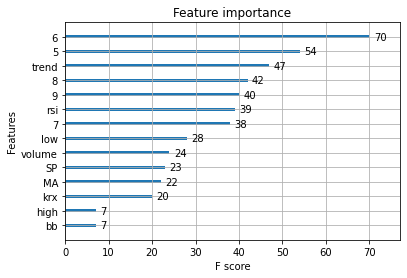

In [17]:
from xgboost import plot_importance
# from lightgbm import plot_importance
plot_importance(model)

In [18]:
sub = pd.read_csv("sample_submission.csv")
for i in range(1,371):
    sub.iloc[:, i] = np.pad((result[i - 1] * data.iloc[-1, i - 1] / 100) + data.iloc[-1, i - 1], (5, 0), 'constant', constant_values=0)
sub["031390"] = 0
sub

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-11-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
1,2021-11-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
2,2021-11-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
3,2021-11-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
4,2021-11-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
5,2021-11-29,31876.472656,30206.773438,58850.914062,128910.732375,117675.789869,15500.136719,43482.101562,78565.900683,113981.542833,...,43882.820312,47847.355469,101296.320312,40013.925781,19646.328125,50529.441406,363976.06250,272132.43750,24964.816406,17396.107422
6,2021-11-30,32062.240234,31027.943359,59867.652344,129623.363960,121754.805355,15367.448242,44219.500000,80566.035473,115010.110445,...,44832.242188,48910.449219,102413.023438,39511.644531,19910.996094,50850.140625,373458.40625,273379.21875,24961.804688,16686.792969
7,2021-12-01,31914.716797,31235.859375,59657.113281,129963.140170,121092.864182,15572.625000,44324.062500,79847.783245,115547.808533,...,44834.453125,49118.375000,102463.468750,39708.230469,20423.933594,50832.585938,374092.62500,277920.43750,25110.748047,16804.312500
8,2021-12-02,31940.794922,31447.468750,59607.933594,130187.842162,121010.679493,15591.872070,44500.031250,80028.353938,116376.085445,...,44865.652344,48983.929688,102598.335938,39518.152344,20072.914062,50865.792969,374253.37500,277499.15625,25118.332031,16677.785156
9,2021-12-03,31811.902344,30992.105469,59514.359375,130032.180951,120985.178596,15514.937500,44149.328125,81119.978270,115807.289656,...,44465.222656,49006.925781,102176.101562,39527.480469,20178.281250,50831.730469,372498.09375,277520.75000,25472.845703,16657.179688


In [20]:
linear_stock_predict = pd.read_csv("arima_end1.csv")
linear_stock_predict
sub.iloc[0, 1:] = linear_stock_predict.iloc[0, 1:]
sub.iloc[1:, 1:] = linear_stock_predict.iloc[1:, 1:] * 0.7 + sub.iloc[1:, 1:] * 0.3
sub

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-11-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000
1,2021-11-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000
2,2021-11-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000
3,2021-11-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000
4,2021-11-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000
5,2021-11-29,31792.443359,30327.839844,59014.390625,129265.143370,119712.310736,15326.842773,43885.511719,80032.048630,115194.203574,...,44349.847656,48479.207031,101870.437500,39899.503906,19732.626953,50436.175781,369592.81250,274756.5625,24941.728516,16868.587891
6,2021-11-30,31881.384766,30168.753906,59222.808594,129373.143137,120882.574830,15152.088867,43980.921875,80609.236130,115696.748933,...,44634.671875,48798.136719,102286.992188,40442.792969,19681.273438,50532.386719,372437.53125,274697.4375,24893.109375,16650.546875
7,2021-12-01,31888.816406,29720.539062,59032.304688,129369.286291,120636.466167,15046.651367,43692.585938,80376.622489,116011.769382,...,44635.335938,48860.511719,102383.664062,41256.621094,19681.871094,50527.121094,372627.78125,275626.6250,24890.076172,16680.558594
8,2021-12-02,31941.001953,29294.412109,58922.097656,129330.907180,120563.974946,14900.126953,43448.031250,80413.154264,116315.800068,...,44644.695312,48820.179688,102505.664062,41791.375000,19483.369141,50537.082031,372676.00000,275067.0625,24844.636719,16637.355469
9,2021-12-03,31946.587891,28708.224609,58776.972656,129178.419108,120508.505060,14719.014648,43116.164062,80723.046131,116091.679406,...,44524.566406,48827.078125,102460.531250,42393.820312,19361.587891,50526.863281,372149.43750,274640.3750,24903.275391,16625.927734


In [40]:
sub.set_index(sub['Day'], inplace=True)

In [41]:
sub

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
Day,,,,,,,,,,,,,,,,,,,,,
2021-11-01,2021-11-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000
2021-11-02,2021-11-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000
2021-11-03,2021-11-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000
2021-11-04,2021-11-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000
2021-11-05,2021-11-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000
2021-11-29,2021-11-29,31792.443359,30327.839844,59014.390625,129265.143370,119712.310736,15326.842773,43885.511719,80032.048630,115194.203574,...,44349.847656,48479.207031,101870.437500,39899.503906,19732.626953,50436.175781,369592.81250,274756.5625,24941.728516,16868.587891
2021-11-30,2021-11-30,31881.384766,30168.753906,59222.808594,129373.143137,120882.574830,15152.088867,43980.921875,80609.236130,115696.748933,...,44634.671875,48798.136719,102286.992188,40442.792969,19681.273438,50532.386719,372437.53125,274697.4375,24893.109375,16650.546875
2021-12-01,2021-12-01,31888.816406,29720.539062,59032.304688,129369.286291,120636.466167,15046.651367,43692.585938,80376.622489,116011.769382,...,44635.335938,48860.511719,102383.664062,41256.621094,19681.871094,50527.121094,372627.78125,275626.6250,24890.076172,16680.558594
2021-12-02,2021-12-02,31941.001953,29294.412109,58922.097656,129330.907180,120563.974946,14900.126953,43448.031250,80413.154264,116315.800068,...,44644.695312,48820.179688,102505.664062,41791.375000,19483.369141,50537.082031,372676.00000,275067.0625,24844.636719,16637.355469


In [54]:
sub.set_index(pd.to_datetime(sub['Day']), inplace=True)

In [56]:
sub.iloc[5:, 1:].mean(axis=1)

Day
2021-11-29    85220.496218
2021-11-30    85405.769791
2021-12-01    85414.410737
2021-12-02    85416.885151
2021-12-03    85291.720819
dtype: float64

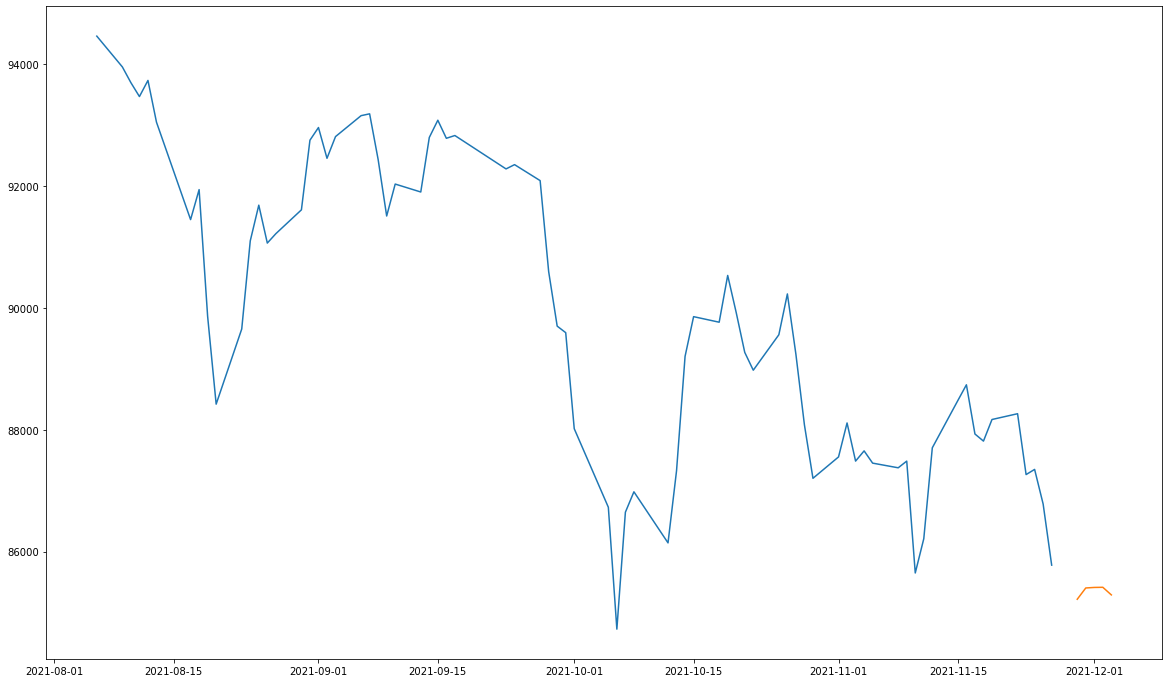

In [59]:
sub.set_index(pd.to_datetime(sub['Day']), inplace=True)
plt.figure(figsize=(20,12))
plt.plot(data.iloc[1300:, :].mean(axis=1))
plt.plot(sub.iloc[5:, 1:].mean(axis=1))

In [ ]:
#평가셋
#valid_data = pd.DataFrame()

# start_date = '20211122'
# end_date = '20211126'
# for stock_code in stock_list["종목코드"]:
#     stock = fdr.DataReader(stock_code, start = start_date, end = end_date)
#     valid_data = pd.concat([valid_data,stock["Close"]], axis=1)
# valid_data.columns = stock_list["종목코드"]
# valid_data = valid_data[stock_list.sort_values("종목코드")["종목코드"]]
# valid_data = valid_data.fillna(method="ffill")
# sub["031390"] = 0
# valid_data["031390"] = sub["031390"][:5].values

# from sklearn.metrics import mean_absolute_error
# mean_absolute_error(valid_data, sub.iloc[5:,1:]) / mean_absolute_error(valid_data, np.zeros((5,370))) * 100

In [61]:
sub.to_csv("result1.csv", index=0)